In [1]:
%reload_ext autoreload
%autoreload 2

In [35]:

import warnings
from collections import Counter
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import xgboost as xgb
from fraud_detection.config import (
    DATA_CSV_PATH,
    DATA_PICKLE_PATH,
    MAX_TRIAL,
    SEED,
    SRC_DIR,
    TEST_SIZE,
)
from fraud_detection.utils import (
    build_model,
    display_model_result,
    display_performance,
    get_pipeline,
    load_model,
    load_pickle_dataset,
    plot_confusion_matrix,
    preprocess,
    save_model,
    save_pickle_dataset,
)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import (
    AllKNN,
    ClusterCentroids,
    NearMiss,
    RandomUnderSampler,
)
from lightgbm import LGBMClassifier
from sklearn import set_config
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    IsolationForest,
    RandomForestClassifier,
    VotingClassifier,
)
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')
%matplotlib inline
import pygwalker as pyg

set_config(enable_metadata_routing=True)


## 1. Data Preparation

In [3]:
if Path(DATA_PICKLE_PATH).exists():
    print("⏳ Load dataset from pickle")
    data = load_pickle_dataset()
    print("✅ Data loaded")
else:
    print("⏳ Loading dataset from csv")
    data = pd.read_csv(f"{DATA_CSV_PATH}")
    print("✅ Data loaded")
    
    print("⏳ Saving dataset to pickle file")
    save_pickle_dataset(data)
    print("✅ Data Saved")

⏳ Load dataset from pickle
✅ Data loaded


In [7]:
data.tail()

step      type      amount     nameOrig  oldbalanceOrg  \
6362615   743  CASH_OUT   339682.13   C786484425      339682.13   
6362616   743  TRANSFER  6311409.28  C1529008245     6311409.28   
6362617   743  CASH_OUT  6311409.28  C1162922333     6311409.28   
6362618   743  TRANSFER   850002.52  C1685995037      850002.52   
6362619   743  CASH_OUT   850002.52  C1280323807      850002.52   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  
6362615             0.0   C776919290            0.00       339682.13        1  
6362616             0.0  C1881841831            0.00            0.00        1  
6362617             0.0  C1365125890        68488.84      6379898.11        1  
6362618             0.0  C2080388513            0.00            0.00        1  
6362619             0.0   C873221189      6510099.11      7360101.63        1

In [5]:
# Remove non desire column
data.drop('isFlaggedFraud', axis=1, inplace=True)

In [8]:
data.sample(5)

step     type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
2194630   185  CASH_IN  139502.42  C1117865604    13773624.22     13913126.64   
6296779   681  CASH_IN   38980.00  C1238772975      116834.00       155814.00   
2492520   204  PAYMENT   10943.10   C348660979           0.00            0.00   
2587809   207  PAYMENT     202.40  C1278763014       16069.00        15866.60   
5003084   353  CASH_IN  284784.60   C821450100        1745.00       286529.60   

            nameDest  oldbalanceDest  newbalanceDest  isFraud  
2194630   C252005374       205372.45        65870.03        0  
6296779  C1077836975       557610.74       518630.73        0  
2492520  M2120259961            0.00            0.00        0  
2587809  M1851997237            0.00            0.00        0  
5003084   C361041218            0.00            0.00        0

TypeError: Cannot perform 'rand_' with a dtyped [float64] array and scalar of type [bool]

In [15]:
# Define feature and target
X = data.drop(columns=['nameOrig', 'nameDest', 'isFraud'])
y = data['isFraud']

In [16]:
# Data splitting with a test sizie of 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=SEED)

print(f"Training repartition: {Counter(y_train)}")
print(f"Testing repartition: {Counter(y_test)}")
X_train.shape, X_test.shape, y_train.shape, y_test.shape

Training repartition: Counter({0: 4448085, 1: 5749})
Testing repartition: Counter({0: 1906322, 1: 2464})


((4453834, 7), (1908786, 7), (4453834,), (1908786,))

# 2. Model Definition

## Base Model

### 1. *Logistic Regression*

In [20]:
lr = build_model(LogisticRegression(max_iter=1000), X_train, y_train, resampled=False)

[Pipeline] .......... (step 1 of 2) Processing pipeline, total=   1.1s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   3.3s


Accuracy  Recall  Roc_Auc  Precision  F1 Score
LogisticRegression_base    0.9991  0.3608   0.6804     0.9193    0.5182

Model Score: 0.9991340045452973

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.92      0.36      0.52      2464

    accuracy                           1.00   1908786
   macro avg       0.96      0.68      0.76   1908786
weighted avg       1.00      1.00      1.00   1908786



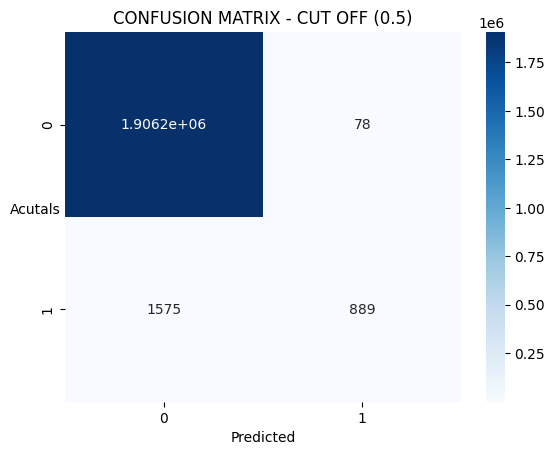

In [25]:
lr_performance = display_performance(lr, X_test, y_test, model_name='LogisticRegression_base')
lr_pred = lr.predict(X_test)
lr_score = lr.score(X_test, y_test)

display_model_result(y_test, lr_pred, lr_score)
plot_confusion_matrix(y_test, lr.predict(X_test))
lr_performance

### 2. *Gaussian NB*

In [ ]:
nb = build_model(GaussianNB(), X_train, y_train, resampled=False)

[Pipeline] .......... (step 1 of 2) Processing pipeline, total=   1.2s
[Pipeline] ........ (step 2 of 2) Processing gaussiannb, total=   0.7s
Model Score: 0.5657056369860215

              precision    recall  f1-score   support

           0       1.00      0.57      0.72   1906322
           1       0.00      1.00      0.01      2464

    accuracy                           0.57   1908786
   macro avg       0.50      0.78      0.36   1908786
weighted avg       1.00      0.57      0.72   1908786



Accuracy  Recall  Roc_Auc  Precision  F1 Score
GaussianNB_base    0.5657     1.0   0.7826      0.003    0.0059

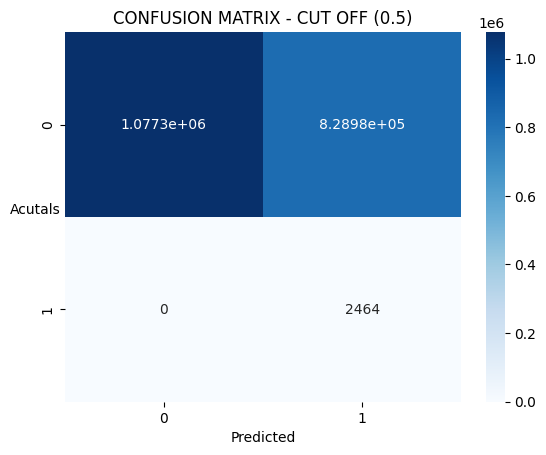

In [27]:

nb_performance = display_performance(nb, X_test, y_test, model_name='GaussianNB_base')
nb_pred = nb.predict(X_test)
nb_score = nb.score(X_test, y_test)

display_model_result(y_test, nb_pred, nb_score)
plot_confusion_matrix(y_test, nb.predict(X_test))

nb_performance

### 3. *Random Forest*

In [ ]:
rf = build_model(RandomForestClassifier(), X_train, y_train, resampled=False)

[Pipeline] .......... (step 1 of 2) Processing pipeline, total=   1.2s
[Pipeline]  (step 2 of 2) Processing randomforestclassifier, total= 8.8min
Model Score: 0.9996725667518517

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.97      0.77      0.86      2464

    accuracy                           1.00   1908786
   macro avg       0.98      0.89      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786



Accuracy  Recall  Roc_Auc  Precision  F1 Score
RandomForestClassifier_base    0.9997  0.7719   0.8859     0.9679    0.8589

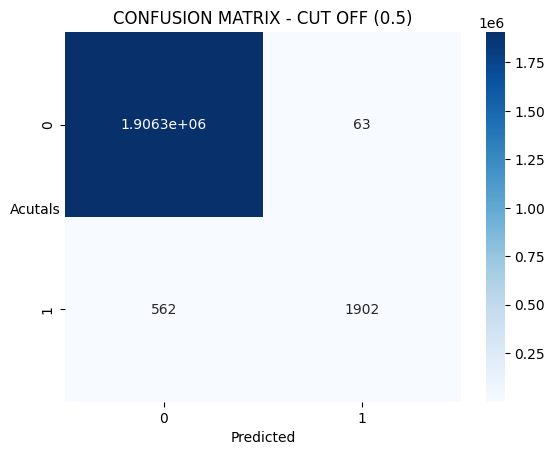

In [28]:
rf_performance = display_performance(rf, X_test, y_test, model_name='RandomForestClassifier_base')
rf_pred = rf.predict(X_test)
rf_score = rf.score(X_test, y_test)

display_model_result(y_test, rf_pred, rf_score)
plot_confusion_matrix(y_test, rf.predict(X_test))

rf_performance

### 4. *SVC*

[Pipeline] .......... (step 1 of 2) Processing pipeline, total=   1.3s
[Pipeline] ............... (step 2 of 2) Processing svc, total=99.7min
Model Score: 0.9992188752432174

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.99      0.40      0.57      2464

    accuracy                           1.00   1908786
   macro avg       1.00      0.70      0.78   1908786
weighted avg       1.00      1.00      1.00   1908786



Accuracy  Recall  Roc_Auc  Precision  F1 Score
RandomForestClassifier_base    0.9992  0.3973   0.6987     0.9939    0.5677

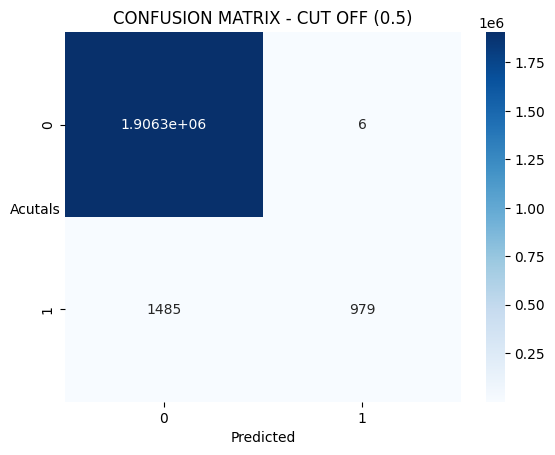

In [29]:
svc = build_model(SVC(gamma='auto'), X_train, y_train, resampled=False)
svc_performance = display_performance(svc, X_test, y_test, model_name='RandomForestClassifier_base')
svc_pred = svc.predict(X_test)
svc_score = svc.score(X_test, y_test)

display_model_result(y_test, svc_pred, svc_score)
plot_confusion_matrix(y_test, svc.predict(X_test))

svc_performance

### 5. *AdaBoosting*

[Pipeline] .......... (step 1 of 2) Processing pipeline, total=   1.5s
[Pipeline]  (step 2 of 2) Processing adaboostclassifier, total= 5.4min
Model Score: 0.9993603264064175

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.93      0.55      0.69      2464

    accuracy                           1.00   1908786
   macro avg       0.96      0.77      0.84   1908786
weighted avg       1.00      1.00      1.00   1908786



Accuracy  Recall  Roc_Auc  Precision  F1 Score
AdaBoostingClassifier_base    0.9994  0.5455   0.7727     0.9301    0.6876

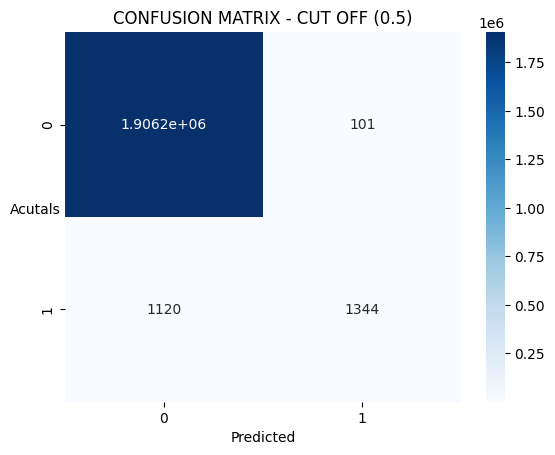

In [30]:
ada = build_model(AdaBoostClassifier(n_estimators=100), X_train, y_train, resampled=False)
ada_performance = display_performance(ada, X_test, y_test, model_name='AdaBoostingClassifier_base')
ada_pred = ada.predict(X_test)
ada_score = ada.score(X_test, y_test)

display_model_result(y_test, ada_pred, ada_score)
plot_confusion_matrix(y_test, ada.predict(X_test))

ada_performance

### 6. *BaggingClassifier*

[Pipeline] .......... (step 1 of 2) Processing pipeline, total=   1.2s
[Pipeline] . (step 2 of 2) Processing baggingclassifier, total=23.3min
Model Score: 0.9997647719545303

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.94      0.87      0.91      2464

    accuracy                           1.00   1908786
   macro avg       0.97      0.94      0.95   1908786
weighted avg       1.00      1.00      1.00   1908786



Accuracy  Recall  Roc_Auc  Precision  F1 Score
BaggingClassifier_base    0.9998  0.8746   0.9373      0.939    0.9057

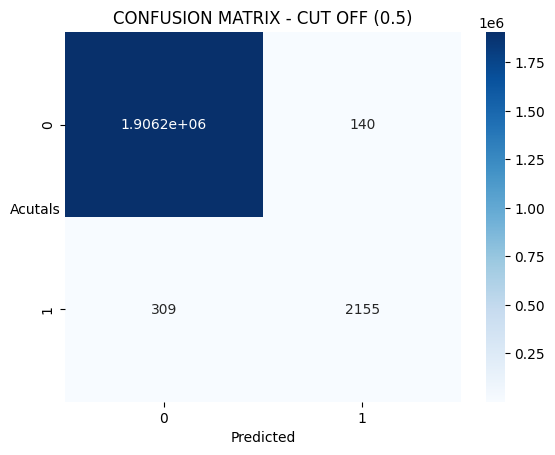

In [31]:
bag= build_model(BaggingClassifier(n_estimators=100), X_train, y_train, resampled=False)
bag_performance = display_performance(bag, X_test, y_test, model_name='BaggingClassifier_base')
bag_pred = bag.predict(X_test)
bag_score = bag.score(X_test, y_test)

display_model_result(y_test, bag_pred, bag_score)
plot_confusion_matrix(y_test, bag.predict(X_test))

bag_performance

### 7. *XGBClassifier*

[Pipeline] .......... (step 1 of 2) Processing pipeline, total=   1.4s
[Pipeline] ..... (step 2 of 2) Processing xgbclassifier, total=   7.5s
Model Score: 0.9996558021695465

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.95      0.77      0.85      2464

    accuracy                           1.00   1908786
   macro avg       0.98      0.88      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786



Accuracy  Recall  Roc_Auc  Precision  F1 Score
XGBClassifier_base    0.9997  0.7699   0.8849     0.9547    0.8524

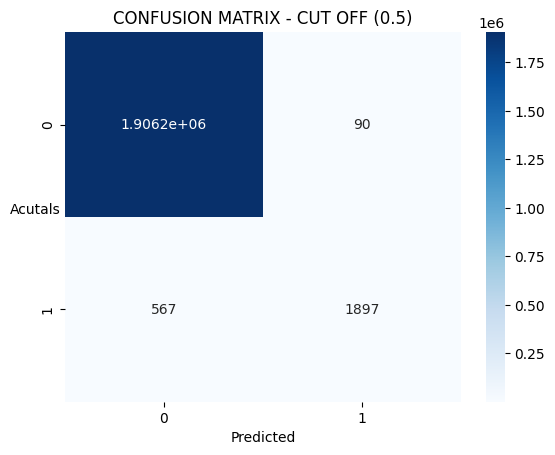

In [32]:
xgb = build_model(XGBClassifier(n_estimators=100), X_train, y_train, resampled=False)
xgb_performance = display_performance(xgb, X_test, y_test, model_name='XGBClassifier_base')
xgb_pred = xgb.predict(X_test)
xgb_score = xgb.score(X_test, y_test)

display_model_result(y_test, xgb_pred, xgb_score)
plot_confusion_matrix(y_test, xgb.predict(X_test))

xgb_performance

### 8. *LGBMClassifier*

[Pipeline] .......... (step 1 of 2) Processing pipeline, total=   1.3s
[LightGBM] [Info] Number of positive: 5749, number of negative: 4448085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1285
[LightGBM] [Info] Number of data points in the train set: 4453834, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001291 -> initscore=-6.651203
[LightGBM] [Info] Start training from score -6.651203
[Pipeline] .... (step 2 of 2) Processing lgbmclassifier, total=   5.3s
Model Score: 0.9956967412795358

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.11      0.32      0.16      2464

    accuracy                           1.00   1908786
   macro avg       0.55      0.66      0.58   

Accuracy  Recall  Roc_Auc  Precision  F1 Score
LGBMClassifier_base    0.9957  0.3235     0.66     0.1085    0.1625

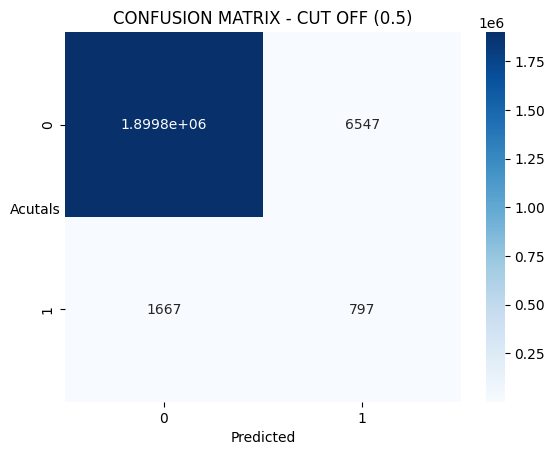

In [34]:
lgbm = build_model(LGBMClassifier(n_estimators=100), X_train, y_train, resampled=False)
lgbm_performance = display_performance(lgbm, X_test, y_test, model_name='LGBMClassifier_base')
lgbm_pred = lgbm.predict(X_test)
lgbm_score = lgbm.score(X_test, y_test)

display_model_result(y_test, lgbm_pred, lgbm_score)
plot_confusion_matrix(y_test, lgbm.predict(X_test))

lgbm_performance

### Base model perfomance check

In [36]:
lr_performance['Comptime'] = [0.05]
nb_performance['Comptime'] = [0.12]
rf_performance['Comptime'] = [9.30]
svc_performance['Comptime'] = [138.20]
ada_performance['Comptime'] = [6.00]
bag_performance['Comptime'] = [25.00]
xgb_performance['Comptime'] = [0.26]
lgbm_performance['Comptime'] = [0.28]

### Performance summary

In [37]:
base_perfomance = pd.concat([lr_performance, nb_performance, rf_performance, svc_performance, ada_performance, bag_performance, xgb_performance, lgbm_performance], axis=0)
base_perfomance

Accuracy  Recall  Roc_Auc  Precision  F1 Score  \
LogisticRegression_base        0.9991  0.3608   0.6804     0.9193    0.5182   
GaussianNB_base                0.5657  1.0000   0.7826     0.0030    0.0059   
RandomForestClassifier_base    0.9997  0.7719   0.8859     0.9679    0.8589   
RandomForestClassifier_base    0.9992  0.3973   0.6987     0.9939    0.5677   
AdaBoostingClassifier_base     0.9994  0.5455   0.7727     0.9301    0.6876   
BaggingClassifier_base         0.9998  0.8746   0.9373     0.9390    0.9057   
XGBClassifier_base             0.9997  0.7699   0.8849     0.9547    0.8524   
LGBMClassifier_base            0.9957  0.3235   0.6600     0.1085    0.1625   

                             Comptime  
LogisticRegression_base          0.05  
GaussianNB_base                  0.12  
RandomForestClassifier_base      9.30  
RandomForestClassifier_base    138.20  
AdaBoostingClassifier_base       6.00  
BaggingClassifier_base          25.00  
XGBClassifier_base               0.26  
LGBMClassifier_base              0.28

from these baseline model and regarding these criteria: **Roc_Auc Socre**, **F1 Score** and **Comptime (min)** <br/>
We decide to move: *LogisticRegression*, *RandomForest*, *BagginClassifier* and *XGBClassifier*

# 3. Selected Model Improvement

- ### Over-Sampling technique **SMOTE**

In [10]:
smote = SMOTE(random_state=SEED)
X_train_transformed = preprocess().fit_transform(X_train)
X_test_transformed = preprocess().fit_transform(X_test)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

print(f"Before Over-Sampling: {Counter(y_train)}")
print(f"After Over-Sampling: {Counter(y_train_resampled)}")

Before Over-Sampling: Counter({0: 4448085, 1: 5749})
After Over-Sampling: Counter({0: 4448085, 1: 4448085})


#### 1. *Logistic Regression*

Model Score: 0.9471973285638097

              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1906322
           1       0.02      0.95      0.04      2464

    accuracy                           0.95   1908786
   macro avg       0.51      0.95      0.51   1908786
weighted avg       1.00      0.95      0.97   1908786



Accuracy  Recall  Roc_Auc  Precision  F1 Score
LogisticRegression_with_os    0.9472  0.9497   0.9484     0.0227    0.0444

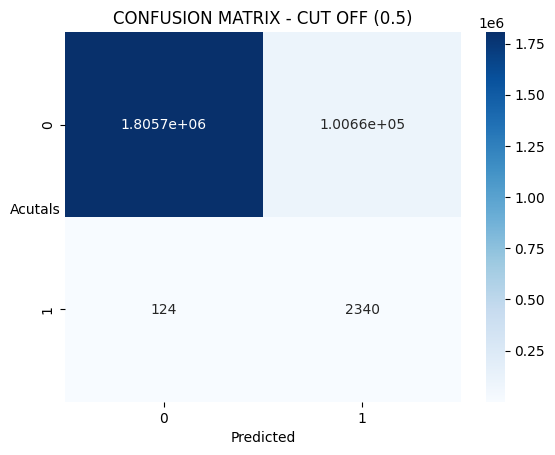

In [45]:
lr_os = LogisticRegression(max_iter=1000).fit(X_train_resampled, y_train_resampled)
lr_os_performance = display_performance(lr_os, X_test_transformed, y_test, model_name='LogisticRegression_with_os')
lr_os_pred = lr_os.predict(X_test_transformed)
lr_os_score = lr_os.score(X_test_transformed, y_test)

display_model_result(y_test, lr_os_pred, lr_os_score)
plot_confusion_matrix(y_test, lr_os.predict(X_test_transformed))

lr_os_performance

#### 2. *Ramdom Forest*

Model Score: 0.9989076826841773

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.99      0.16      0.27      2464

    accuracy                           1.00   1908786
   macro avg       1.00      0.58      0.63   1908786
weighted avg       1.00      1.00      1.00   1908786



Accuracy  Recall  Roc_Auc  Precision  F1 Score
RandomForest_with_os    0.9989   0.155   0.5775     0.9922    0.2682

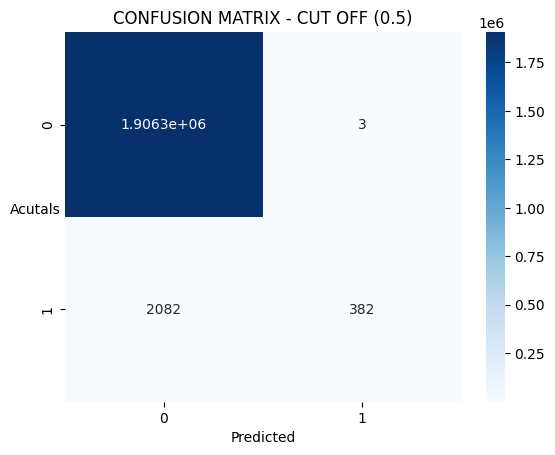

In [46]:
rf_os = RandomForestClassifier(n_estimators=100).fit(X_train_resampled, y_train_resampled)
rf_os_performance = display_performance(rf_os, X_test_transformed, y_test, model_name='RandomForest_with_os')
rf_os_pred = rf_os.predict(X_test_transformed)
rf_os_score = rf_os.score(X_test_transformed, y_test)

display_model_result(y_test, rf_os_pred, rf_os_score)
plot_confusion_matrix(y_test, rf_os.predict(X_test_transformed))

rf_os_performance

#### 3. *BaggingClassifier*

Model Score: 0.9987840438896765

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.61      0.16      0.25      2464

    accuracy                           1.00   1908786
   macro avg       0.81      0.58      0.62   1908786
weighted avg       1.00      1.00      1.00   1908786



Accuracy  Recall  Roc_Auc  Precision  F1 Score
BaggingClassifier_with_os    0.9988  0.1567   0.5783     0.6137    0.2496

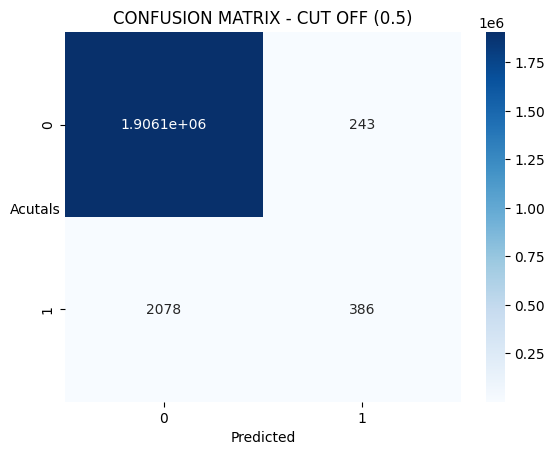

In [47]:
bag_os = BaggingClassifier(n_estimators=100).fit(X_train_resampled, y_train_resampled)
bag_os_performance = display_performance(bag_os, X_test_transformed, y_test, model_name='BaggingClassifier_with_os')
bag_os_pred = bag_os.predict(X_test_transformed)
bag_os_score = bag_os.score(X_test_transformed, y_test)

display_model_result(y_test, bag_os_pred, bag_os_score)
plot_confusion_matrix(y_test, bag_os.predict(X_test_transformed))

bag_os_performance

#### 4. *XGBCLassifier*

Model Score: 0.9988977287134335

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.96      0.15      0.26      2464

    accuracy                           1.00   1908786
   macro avg       0.98      0.58      0.63   1908786
weighted avg       1.00      1.00      1.00   1908786



Accuracy  Recall  Roc_Auc  Precision  F1 Score
XGBClassifier_with_os    0.9989   0.153   0.5765     0.9569    0.2638

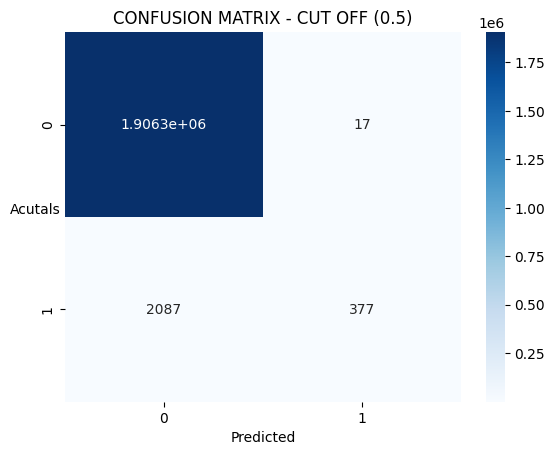

In [48]:
xgb_os = XGBClassifier(n_estimators=100).fit(X_train_resampled, y_train_resampled)
xgb_os_performance = display_performance(xgb_os, X_test_transformed, y_test, model_name='XGBClassifier_with_os')
xgb_os_pred = xgb_os.predict(X_test_transformed)
xgb_os_score = xgb_os.score(X_test_transformed, y_test)

display_model_result(y_test, xgb_os_pred, xgb_os_score)
plot_confusion_matrix(y_test, xgb_os.predict(X_test_transformed))

xgb_os_performance

In [61]:
lr_os_performance['Comptime'] = [0.31]
rf_os_performance['Comptime'] = [23.20]
bag_os_performance['Comptime'] = [59.30]
xgb_os_performance['Comptime'] = [0.36]

### Performance summary

In [62]:
# Over-Sampling performance
os_performance = pd.concat([lr_os_performance, rf_os_performance, bag_os_performance, xgb_os_performance], axis=0)
os_performance

Accuracy  Recall  Roc_Auc  Precision  F1 Score  \
LogisticRegression_with_os    0.9472  0.9497   0.9484     0.0227    0.0444   
RandomForest_with_os          0.9989  0.1550   0.5775     0.9922    0.2682   
BaggingClassifier_with_os     0.9988  0.1567   0.5783     0.6137    0.2496   
XGBClassifier_with_os         0.9989  0.1530   0.5765     0.9569    0.2638   

                            Comptime  
LogisticRegression_with_os      0.31  
RandomForest_with_os           23.20  
BaggingClassifier_with_os      59.30  
XGBClassifier_with_os           0.36

- ### Under-Sampling technique *RandomUnderSampler*

In [11]:
rus = RandomUnderSampler(random_state=SEED)
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train_transformed, y_train)

print(f"Before Under-Sampling: {Counter(y_train)}")
print(f"After Under-Sampling: {Counter(y_train_undersampled)}")

Before Under-Sampling: Counter({0: 4448085, 1: 5749})
After Under-Sampling: Counter({0: 5749, 1: 5749})


#### *Logistic Regression*

Model Score: 0.9400257545895664

              precision    recall  f1-score   support

           0       1.00      0.94      0.97   1906322
           1       0.02      0.89      0.04      2464

    accuracy                           0.94   1908786
   macro avg       0.51      0.92      0.50   1908786
weighted avg       1.00      0.94      0.97   1908786



Accuracy  Recall  Roc_Auc  Precision  F1 Score
LogisticRegression_with_us      0.94  0.8908   0.9155     0.0189    0.0369

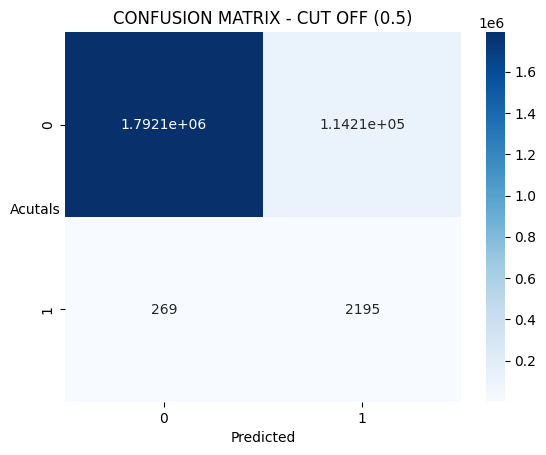

In [55]:
lr_us = LogisticRegression(max_iter=1000).fit(X_train_undersampled, y_train_undersampled)
lr_us_performance = display_performance(lr_us, X_test_transformed, y_test, model_name='LogisticRegression_with_us')
lr_us_pred = lr_us.predict(X_test_transformed)
lr_us_score = lr_us.score(X_test_transformed, y_test)

display_model_result(y_test, lr_us_pred, lr_us_score)
plot_confusion_matrix(y_test, lr_us.predict(X_test_transformed))

lr_us_performance

#### 2. *Random Forest*

Model Score: 0.9990287020126929

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.67      0.49      0.57      2464

    accuracy                           1.00   1908786
   macro avg       0.83      0.75      0.78   1908786
weighted avg       1.00      1.00      1.00   1908786



Accuracy  Recall  Roc_Auc  Precision  F1 Score
RandomForest_with_us     0.999  0.4919   0.7458     0.6681    0.5666

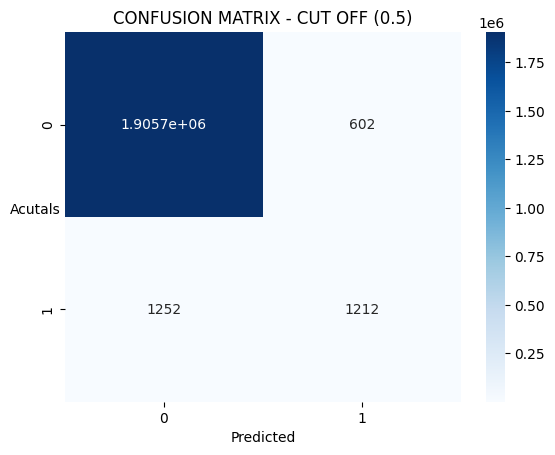

In [57]:
rf_us = RandomForestClassifier(n_estimators=100).fit(X_train_undersampled, y_train_undersampled)
rf_us_performance = display_performance(rf_us, X_test_transformed, y_test, model_name='RandomForest_with_us')
rf_us_pred = rf_us.predict(X_test_transformed)
rf_us_score = rf_us.score(X_test_transformed, y_test)

display_model_result(y_test, rf_us_pred, rf_us_score)
plot_confusion_matrix(y_test, rf_us.predict(X_test_transformed))

rf_us_performance

#### 3. *BaggingClassifier*

Model Score: 0.9951943277035771

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.15      0.60      0.24      2464

    accuracy                           1.00   1908786
   macro avg       0.58      0.80      0.62   1908786
weighted avg       1.00      1.00      1.00   1908786



Accuracy  Recall  Roc_Auc  Precision  F1 Score
BaggingClassifier_with_os    0.9952  0.6019   0.7988     0.1533    0.2443

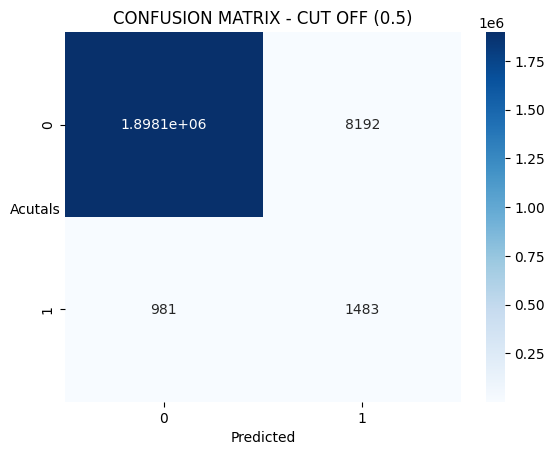

In [58]:
bag_us = BaggingClassifier(n_estimators=100).fit(X_train_undersampled, y_train_undersampled)
bag_us_performance = display_performance(bag_us, X_test_transformed, y_test, model_name='BaggingClassifier_with_os')
bag_us_pred = bag_us.predict(X_test_transformed)
bag_us_score = bag_us.score(X_test_transformed, y_test)

display_model_result(y_test, bag_us_pred, bag_us_score)
plot_confusion_matrix(y_test, bag_us.predict(X_test_transformed))

bag_us_performance

#### 4. *XGBClassifier*

Model Score: 0.9972899004917262

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.21      0.39      0.27      2464

    accuracy                           1.00   1908786
   macro avg       0.60      0.69      0.63   1908786
weighted avg       1.00      1.00      1.00   1908786



Accuracy  Recall  Roc_Auc  Precision  F1 Score
XGBClassifier_with_us    0.9973  0.3888   0.6934     0.2071    0.2703

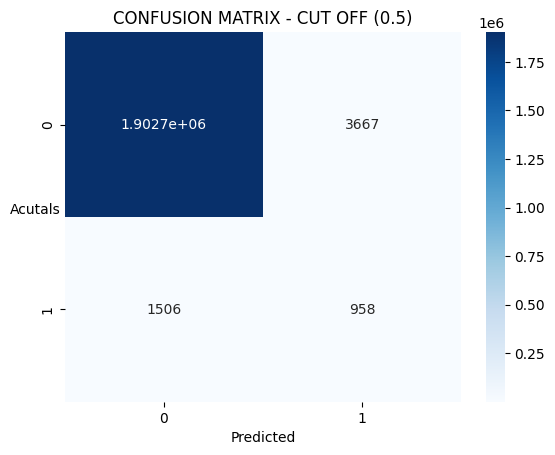

In [59]:
xgb_us = XGBClassifier(n_estimators=100).fit(X_train_undersampled, y_train_undersampled)
xgb_us_performance = display_performance(xgb_us, X_test_transformed, y_test, model_name='XGBClassifier_with_us')
xgb_us_pred = xgb_us.predict(X_test_transformed)
xgb_us_score = xgb_us.score(X_test_transformed, y_test)

display_model_result(y_test, xgb_us_pred, xgb_us_score)
plot_confusion_matrix(y_test, xgb_us.predict(X_test_transformed))

xgb_us_performance

In [63]:
lr_us_performance['Comptime'] = [0.31]
rf_us_performance['Comptime'] = [23.20]
bag_us_performance['Comptime'] = [59.30]
xgb_us_performance['Comptime'] = [0.36]

In [64]:
# Under-Sampling performance
us_performance = pd.concat([lr_us_performance, rf_us_performance, bag_us_performance, xgb_us_performance], axis=0)
us_performance

Accuracy  Recall  Roc_Auc  Precision  F1 Score  \
LogisticRegression_with_us    0.9400  0.8908   0.9155     0.0189    0.0369   
RandomForest_with_us          0.9990  0.4919   0.7458     0.6681    0.5666   
BaggingClassifier_with_os     0.9952  0.6019   0.7988     0.1533    0.2443   
XGBClassifier_with_us         0.9973  0.3888   0.6934     0.2071    0.2703   

                            Comptime  
LogisticRegression_with_us      0.31  
RandomForest_with_us           23.20  
BaggingClassifier_with_os      59.30  
XGBClassifier_with_us           0.36

## ---------------------

- ### Cost-Sensitive Learning **class_weight** / **scale_pos_weight**

#### *Logistic Regression*

Model Score: 0.9468772298204199

              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1906322
           1       0.02      0.94      0.04      2464

    accuracy                           0.95   1908786
   macro avg       0.51      0.94      0.51   1908786
weighted avg       1.00      0.95      0.97   1908786



Accuracy  Recall  Roc_Auc  Precision  \
LogisticRegression_with_class_weight    0.9469  0.9383   0.9426     0.0223   

                                      F1 Score  
LogisticRegression_with_class_weight    0.0436

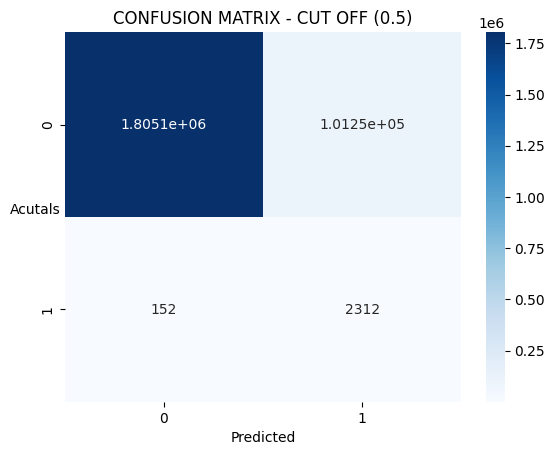

In [66]:
lr_cs = LogisticRegression(class_weight='balanced', max_iter=1000).fit(X_train_transformed, y_train)
lr_cs_performance = display_performance(lr_cs, X_test_transformed, y_test, model_name='LogisticRegression_with_class_weight')
lr_cs_pred = lr_cs.predict(X_test_transformed)
lr_cs_score = lr_cs.score(X_test_transformed, y_test)

display_model_result(y_test, lr_cs_pred, lr_cs_score)
plot_confusion_matrix(y_test, lr_cs.predict(X_test_transformed))

lr_cs_performance

Model Score: 0.9962138238650116

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.20      0.67      0.31      2464

    accuracy                           1.00   1908786
   macro avg       0.60      0.83      0.66   1908786
weighted avg       1.00      1.00      1.00   1908786



Accuracy  Recall  Roc_Auc  Precision  \
LogisticRegression_with_class_weight    0.9962   0.668   0.8323     0.2043   

                                      F1 Score  
LogisticRegression_with_class_weight     0.313

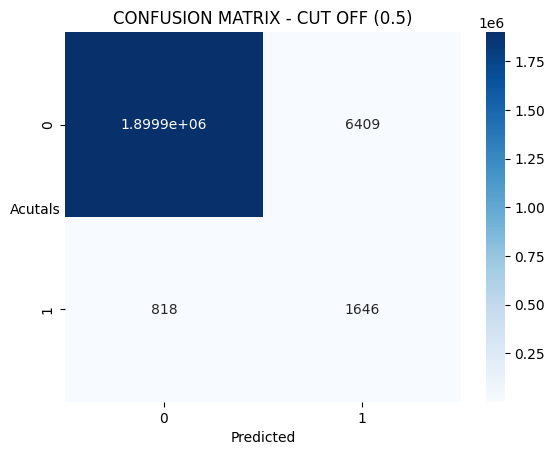

In [68]:

weight = {0:(1-0.99), 1: 0.99}

lr_cs_custom = LogisticRegression(class_weight=weight, max_iter=1000).fit(X_train_transformed, y_train)
lr_cs_custom_performance = display_performance(lr_cs_custom, X_test_transformed, y_test, model_name='LogisticRegression_with_class_weight')
lr_cs_custom_pred = lr_cs_custom.predict(X_test_transformed)
lr_cs_custom_score = lr_cs_custom.score(X_test_transformed, y_test)

display_model_result(y_test, lr_cs_custom_pred, lr_cs_custom_score)
plot_confusion_matrix(y_test, lr_cs_custom.predict(X_test_transformed))

lr_cs_custom_performance

#### *Random Forest*

Model Score: 0.9987295589971846

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       1.00      0.02      0.03      2464

    accuracy                           1.00   1908786
   macro avg       1.00      0.51      0.52   1908786
weighted avg       1.00      1.00      1.00   1908786



Accuracy  Recall  Roc_Auc  Precision  F1 Score
RandomForest_with_us    0.9987  0.0158   0.5079        1.0    0.0312

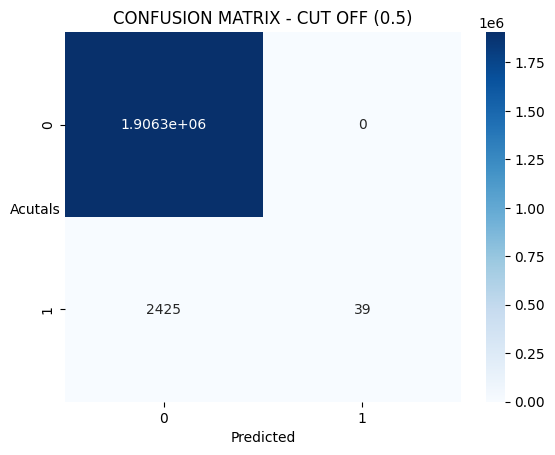

In [70]:
rf_cs = RandomForestClassifier(n_estimators=100, class_weight='balanced').fit(X_train_transformed, y_train)
rf_cs_performance = display_performance(rf_cs, X_test_transformed, y_test, model_name='RandomForest_with_us')
rf_cs_pred = rf_cs.predict(X_test_transformed)
rf_cs_score = rf_cs.score(X_test_transformed, y_test)

display_model_result(y_test, rf_cs_pred, rf_cs_score)
plot_confusion_matrix(y_test, rf_cs.predict(X_test_transformed))

rf_cs_performance

Model Score: 0.9989113499365565

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       1.00      0.16      0.27      2464

    accuracy                           1.00   1908786
   macro avg       1.00      0.58      0.64   1908786
weighted avg       1.00      1.00      1.00   1908786



Accuracy  Recall  Roc_Auc  Precision  F1 Score
RandomForest_with_us    0.9989  0.1567   0.5783        1.0    0.2709

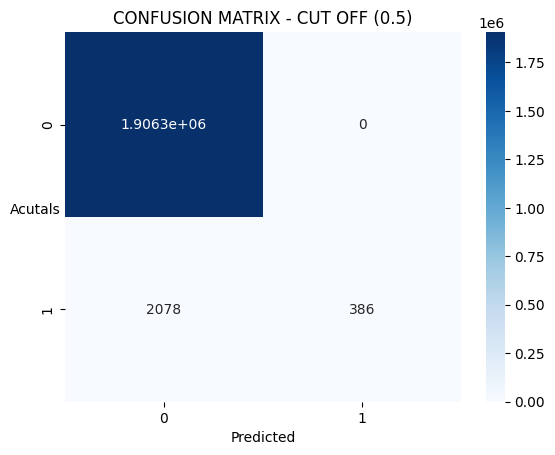

In [71]:
rf_cs_custom = RandomForestClassifier(n_estimators=100, class_weight=weight).fit(X_train_transformed, y_train)
rf_cs_custom_performance = display_performance(rf_cs_custom, X_test_transformed, y_test, model_name='RandomForest_with_us')
rf_cs_custom_pred = rf_cs_custom.predict(X_test_transformed)
rf_cs_custom_score = rf_cs_custom.score(X_test_transformed, y_test)

display_model_result(y_test, rf_cs_custom_pred, rf_cs_custom_score)
plot_confusion_matrix(y_test, rf_cs_custom.predict(X_test_transformed))

rf_cs_custom_performance

#### *XGBClassifier*

Model Score: 0.9987924261808291

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       1.00      0.06      0.12      2464

    accuracy                           1.00   1908786
   macro avg       1.00      0.53      0.56   1908786
weighted avg       1.00      1.00      1.00   1908786



Accuracy  Recall  Roc_Auc  Precision  F1 Score
XGBClassifier_with_us    0.9988  0.0645   0.5323        1.0    0.1212

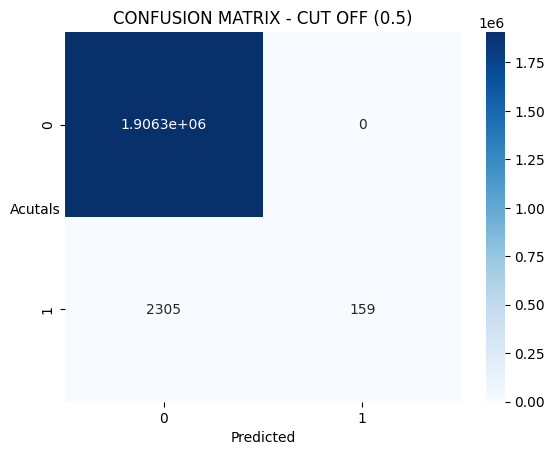

In [72]:
xgb_cs = XGBClassifier(n_estimators=100, scale_pos_weight=1).fit(X_train_transformed, y_train)
xgb_cs_performance = display_performance(xgb_cs, X_test_transformed, y_test, model_name='XGBClassifier_with_cs')
xgb_cs_pred = xgb_cs.predict(X_test_transformed)
xgb_cs_score = xgb_cs.score(X_test_transformed, y_test)

display_model_result(y_test, xgb_cs_pred, xgb_cs_score)
plot_confusion_matrix(y_test, xgb_cs.predict(X_test_transformed))

xgb_cs_performance

Model Score: 0.9987300828903817

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       1.00      0.02      0.03      2464

    accuracy                           1.00   1908786
   macro avg       1.00      0.51      0.52   1908786
weighted avg       1.00      1.00      1.00   1908786



Accuracy  Recall  Roc_Auc  Precision  F1 Score
XGBClassifier_with_cs_3    0.9987  0.0162   0.5081        1.0    0.0319

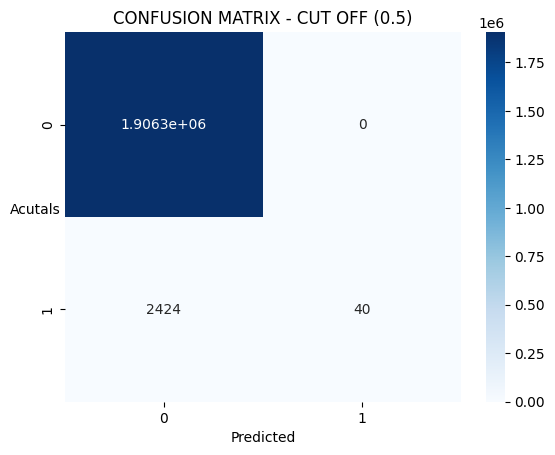

In [75]:
xgb_cs_3 = XGBClassifier(n_estimators=100, scale_pos_weight=3, random_state=SEED).fit(X_train_transformed, y_train)
xgb_cs_3_performance = display_performance(xgb_cs_3, X_test_transformed, y_test, model_name='XGBClassifier_with_cs_3')
xgb_cs_3_pred = xgb_cs_3.predict(X_test_transformed)
xgb_cs_3_score = xgb_cs_3.score(X_test_transformed, y_test)

display_model_result(y_test, xgb_cs_3_pred, xgb_cs_3_score)
plot_confusion_matrix(y_test, xgb_cs_3.predict(X_test_transformed))

xgb_cs_3_performance

Model Score: 0.9988290987046217

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       1.00      0.09      0.17      2464

    accuracy                           1.00   1908786
   macro avg       1.00      0.55      0.58   1908786
weighted avg       1.00      1.00      1.00   1908786



Accuracy  Recall  Roc_Auc  Precision  F1 Score
XGBClassifier_with_cs_5    0.9988  0.0929   0.5465        1.0    0.1701

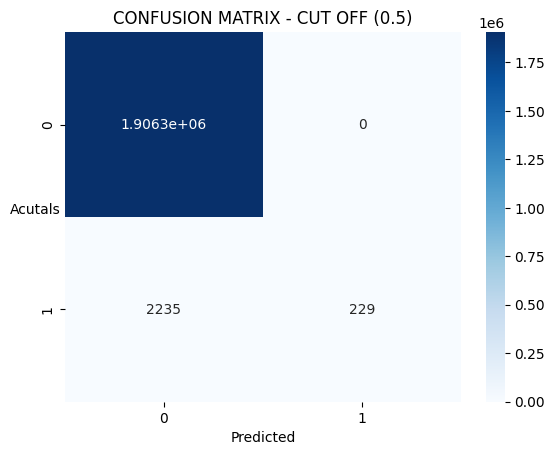

In [76]:
xgb_cs_5 = XGBClassifier(n_estimators=100, scale_pos_weight=5, random_state=SEED).fit(X_train_transformed, y_train)
xgb_cs_5_performance = display_performance(xgb_cs_5, X_test_transformed, y_test, model_name='XGBClassifier_with_cs_5')
xgb_cs_5_pred = xgb_cs_5.predict(X_test_transformed)
xgb_cs_5_score = xgb_cs_5.score(X_test_transformed, y_test)

display_model_result(y_test, xgb_cs_5_pred, xgb_cs_5_score)
plot_confusion_matrix(y_test, xgb_cs_5.predict(X_test_transformed))

xgb_cs_5_performance

Model Score: 0.9982266215280288

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.38      0.56      0.45      2464

    accuracy                           1.00   1908786
   macro avg       0.69      0.78      0.72   1908786
weighted avg       1.00      1.00      1.00   1908786



Accuracy  Recall  Roc_Auc  Precision  F1 Score
XGBClassifier_with_cs_custom    0.9982  0.5625   0.7806     0.3753    0.4502

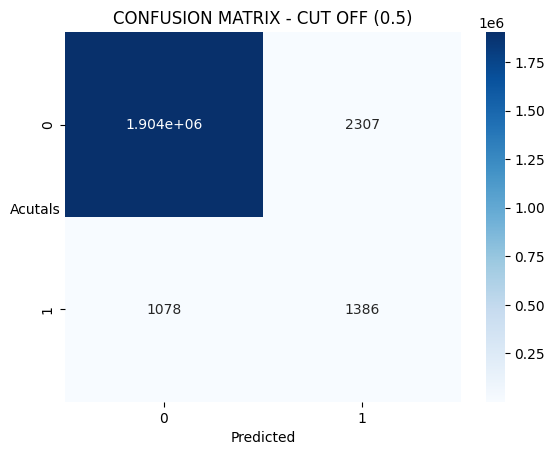

In [79]:
weight = y_train.value_counts()[0] / y_train.value_counts()[1]
xgb_cs_custom = XGBClassifier(n_estimators=1000, scale_pos_weight=weight, random_state=SEED).fit(X_train_transformed, y_train)
xgb_cs_custom_performance = display_performance(xgb_cs_custom, X_test_transformed, y_test, model_name='XGBClassifier_with_cs_custom')
xgb_cs_custom_pred = xgb_cs_custom.predict(X_test_transformed)
xgb_cs_custom_score = xgb_cs_custom.score(X_test_transformed, y_test)

display_model_result(y_test, xgb_cs_custom_pred, xgb_cs_custom_score)
plot_confusion_matrix(y_test, xgb_cs_custom.predict(X_test_transformed))

xgb_cs_custom_performance

### performance summary

In [80]:
# Cross-Snsitive Learning performance
us_performance = pd.concat([lr_cs_performance, lr_cs_custom_performance, rf_cs_performance, rf_cs_custom_performance, xgb_cs_performance, xgb_cs_3_performance, xgb_cs_5_performance, xgb_cs_custom_performance], axis=0)
us_performance

Accuracy  Recall  Roc_Auc  Precision  \
LogisticRegression_with_class_weight    0.9469  0.9383   0.9426     0.0223   
LogisticRegression_with_class_weight    0.9962  0.6680   0.8323     0.2043   
RandomForest_with_us                    0.9987  0.0158   0.5079     1.0000   
RandomForest_with_us                    0.9989  0.1567   0.5783     1.0000   
XGBClassifier_with_us                   0.9988  0.0645   0.5323     1.0000   
XGBClassifier_with_cs_3                 0.9987  0.0162   0.5081     1.0000   
XGBClassifier_with_cs_5                 0.9988  0.0929   0.5465     1.0000   
XGBClassifier_with_cs_custom            0.9982  0.5625   0.7806     0.3753   

                                      F1 Score  
LogisticRegression_with_class_weight    0.0436  
LogisticRegression_with_class_weight    0.3130  
RandomForest_with_us                    0.0312  
RandomForest_with_us                    0.2709  
XGBClassifier_with_us                   0.1212  
XGBClassifier_with_cs_3                 0.0319  
XGBClassifier_with_cs_5                 0.1701  
XGBClassifier_with_cs_custom            0.4502

# ---------------------

- ### Tuning Hyperparameter and Cross-Validation With **optuna**

In [12]:
# Study definition
MAX_TRIAL = 30
def tune_model(objective: callable, study_name: str, *args, **kwargs) -> optuna.Study:
    def max_trial_callback(study, trial):
        n_complete = len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE or t.state == optuna.trial.TrialState.RUNNING])
        if n_complete >= MAX_TRIAL:
            study.stop()
            
    study = optuna.create_study(
        direction='maximize',
        study_name=study_name,
        sampler=optuna.samplers.TPESampler(),
        storage=f'sqlite:///{study_name}.sqlite3',
        load_if_exists=True)

    study.optimize(
        objective,
        callbacks=[max_trial_callback], n_jobs=-1)
    
    return study

### ------------------- Logistic Regression --------------------

In [138]:
# LogisticRegression objective
def lr_objective(trial: optuna.Trial) -> float:
    solver = trial.suggest_categorical('solver', choices=['liblinear', 'saga', 'lbfgs', 'newton-cg'])
    penalty = trial.suggest_categorical('penalty', choices=['l2'])
    C = trial.suggest_float('C', 1e-6, 1e6, log=True)
    class_weight = trial.suggest_categorical('class_weight', choices=[{0: i,  1: 1-i} for i in np.linspace(.1, .99, 200)])


    
    model = LogisticRegression(
        max_iter=1000,
        random_state=SEED,
        penalty=penalty,
        C=C,
        class_weight=class_weight,
        solver=solver,
		n_jobs=-1,
		verbose=1,
    )
    
    fit_params = {
		'sample_weight': compute_sample_weight(class_weight={0: 0.90, 1: 1 - 0.90}, y=y_train)
	}
    score = cross_val_score(model,
                            X_train_transformed,
                            y_train,
                            n_jobs=-1,
                            cv=5,
                            scoring='roc_auc',
                            fit_params=fit_params).mean()

    if trial.should_prune():
        raise optuna.TrialPruned()

    return score

In [139]:
lr_study = tune_model(lr_objective, 'logistic-regression')

[I 2024-06-27 14:05:28,215] A new study created in RDB with name: logistic-regression
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


[LibLinear]RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99712D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99712D-01


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99712D-01


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99612D-01
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.4999382540917239 <= 0.0001 False


 This problem is unconstrained.


Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.49992422544760334 <= 0.0001 False
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.49981042084518146 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.12084764236133652 <= 0.0001 False
iter  1 act 1.126e+07 pre 9.933e+06 delta 2.020e+00 f 1.384e+07 |g| 1.135e+07 CG   1
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.120833117383954 <= 0.0001 False
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 0.04265439799312031 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.12076877852653231 <= 0.0001 False
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 0.04263670615538977 <= 0.0001 False

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Newton-CG iter = 5
  Check Convergence
    max |gradient| <= tol: 0.0020964070672135704 <= 0.0001 False
iter  3 act 5.569e+05 pre 4.425e+05 delta 2.020e+00 f 8.775e+05 |g| 9.584e+05 CG   1
Newton-CG iter = 5
  Check Convergence
    max |gradient| <= tol: 0.002067889430850762 <= 0.0001 False
Newton-CG iter = 4
  Check Convergence
    max |gradient| <= tol: 0.005624166531239697 <= 0.0001 False
iter  4 act 1.967e+05 pre 1.559e+05 delta 2.020e+00 f 3.206e+05 |g| 3.472e+05 CG   1
iter  5 act 7.054e+04 pre 5.595e+04 delta 2.020e+00 f 1.239e+05 |g| 1.267e+05 CG   1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99712D-01
Newton-CG iter = 6
  Check Convergence
    max |gradient| <= tol: 0.0007418250195460646 <= 0.0001 False


 This problem is unconstrained.


Newton-CG iter = 6
  Check Convergence
    max |gradient| <= tol: 0.001546433607485108 <= 0.0001 False
iter  6 act 2.503e+04 pre 1.991e+04 delta 2.020e+00 f 5.340e+04 |g| 4.610e+04 CG   1
Newton-CG iter = 5
  Check Convergence
    max |gradient| <= tol: 0.002022593896661163 <= 0.0001 False
iter  7 act -3.936e+03 pre 7.243e+03 delta 3.553e-01 f 2.837e+04 |g| 1.664e+04 CG   2


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


[LibLinear]cg reaches trust region boundary
[LibLinear][LibLinear]iter  7 act 4.807e+03 pre 4.659e+03 delta 9.510e-01 f 2.837e+04 |g| 1.664e+04 CG   1
Newton-CG iter = 7
  Check Convergence
    max |gradient| <= tol: 0.00044954446593577273 <= 0.0001 False
Newton-CG iter = 7
  Check Convergence
    max |gradient| <= tol: 0.0005971875356960688 <= 0.0001 False
Newton-CG iter = 6
  Check Convergence
    max |gradient| <= tol: 0.00849969822050996 <= 0.0001 False

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     16     19      1     0     0   5.406D-05   1.946D-03
  F =   1.9455563332622865E-003

CONVERGENCE: NORM_OF_P

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


[LibLinear]Newton-CG iter = 8
  Check Convergence
    max |gradient| <= tol: 0.000205675625811416 <= 0.0001 False
Newton-CG iter = 7
  Check Convergence
    max |gradient| <= tol: 0.004297984306771736 <= 0.0001 False
iter  9 act 2.453e+03 pre 2.232e+03 delta 6.965e-01 f 2.062e+04 |g| 6.562e+04 CG   1
iter  2 act 1.701e+06 pre 1.364e+06 delta 2.020e+00 f 2.578e+06 |g| 2.727e+06 CG   1
iter  2 act 1.701e+06 pre 1.364e+06 delta 2.020e+00 f 2.578e+06 |g| 2.727e+06 CG   1
iter  2 act 1.701e+06 pre 1.364e+06 delta 2.020e+00 f 2.579e+06 |g| 2.727e+06 CG   1
iter 10 act 1.620e+03 pre 1.350e+03 delta 7.991e-01 f 1.817e+04 |g| 1.312e+04 CG   2
Newton-CG iter = 8
  Check Convergence
    max |gradient| <= tol: 0.0005075932651054337 <= 0.0001 False
iter  3 act 5.564e+05 pre 4.421e+05 delta 2.020e+00 f 8.767e+05 |g| 9.575e+05 CG   1
Newton-CG iter = 9
  Check Convergence
    max |gradient| <= tol: 6.770642147019196e-05 <= 0.0001 True
  Solver did converge at loss = 0.0005894532704403348.
Newton-CG i

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


iter  7 act -4.278e+03 pre 7.244e+03 delta 3.494e-01 f 2.836e+04 |g| 1.662e+04 CG   2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


cg reaches trust region boundary
cg reaches trust region boundary
iter  7 act 4.989e+03 pre 4.819e+03 delta 9.571e-01 f 2.837e+04 |g| 1.664e+04 CG   1
iter  7 act -4.316e+03 pre 7.246e+03 delta 3.484e-01 f 2.836e+04 |g| 1.663e+04 CG   2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99712D-01


 This problem is unconstrained.


iter  7 act 4.739e+03 pre 4.598e+03 delta 9.496e-01 f 2.836e+04 |g| 1.662e+04 CG   1
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.49993825409172393 <= 0.0001 False
iter  7 act -4.375e+03 pre 7.245e+03 delta 3.473e-01 f 2.837e+04 |g| 1.663e+04 CG   2
cg reaches trust region boundary
Newton-CG iter = 10
  Check Convergence
    max |gradient| <= tol: 0.00010305964162295192 <= 0.0001 False
iter  7 act 4.730e+03 pre 4.591e+03 delta 9.495e-01 f 2.836e+04 |g| 1.663e+04 CG   1
cg reaches trust region boundary
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.12081475067186787 <= 0.0001 False
cg reaches trust region boundary
iter 14 act -2.290e+03 pre 9.737e+02 delta 5.954e-01 f 1.410e+04 |g| 1.816e+03 CG   3
iter  7 act 4.718e+03 pre 4.580e+03 delta 9.489e-01 f 2.837e+04 |g| 1.663e+04 CG   1
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 0.042616503588330634 <= 0.0001 False
cg reaches trust region boundary
iter  8 act 2.603e+03 pre 4.

[I 2024-06-27 14:07:09,922] Trial 0 finished with value: 0.9230021924113865 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 1.0, 'class_weight': {'0': 0.33256281407035176, '1': 0.6674371859296482}}. Best is trial 0 with value: 0.9230021924113865.


cg reaches trust region boundary
iter 11 act 7.961e+02 pre 7.153e+02 delta 1.319e+00 f 1.653e+04 |g| 3.868e+03 CG   2
iter 10 act 1.645e+03 pre 1.370e+03 delta 8.080e-01 f 1.816e+04 |g| 1.338e+04 CG   2
Newton-CG iter = 5
  Check Convergence
    max |gradient| <= tol: 0.002093969399267593 <= 0.0001 False
iter 10 act 1.608e+03 pre 1.338e+03 delta 8.268e-01 f 1.795e+04 |g| 1.195e+04 CG   3
iter 12 act 7.128e+02 pre 7.763e+02 delta 1.494e+00 f 1.555e+04 |g| 1.963e+03 CG   3
cg reaches trust region boundary
iter 17 act 4.715e+01 pre 8.387e+01 delta 5.099e-02 f 1.374e+04 |g| 1.895e+03 CG   1
cg reaches trust region boundary
cg reaches trust region boundary
iter 11 act 8.270e+02 pre 7.470e+02 delta 1.373e+00 f 1.652e+04 |g| 3.888e+03 CG   2
cg reaches trust region boundary
iter 12 act 6.238e+02 pre 7.558e+02 delta 1.319e+00 f 1.574e+04 |g| 1.791e+03 CG   2
cg reaches trust region boundary
cg reaches trust region boundary
iter 11 act 8.713e+02 pre 8.173e+02 delta 1.501e+00 f 1.634e+04 |g| 3.4

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


cg reaches trust region boundary
Newton-CG iter = 6
  Check Convergence
    max |gradient| <= tol: 0.0016789825357324097 <= 0.0001 False
cg reaches trust region boundary
iter 13 act 1.050e+03 pre 9.247e+02 delta 2.449e+00 f 1.511e+04 |g| 3.885e+03 CG   3
iter 19 act 3.220e+01 pre 3.273e+01 delta 1.360e-01 f 1.366e+04 |g| 6.805e+02 CG   2
cg reaches trust region boundary
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.499810420845182 <= 0.0001 False
iter 13 act 1.083e+03 pre 9.531e+02 delta 2.437e+00 f 1.514e+04 |g| 5.124e+03 CG   3
cg reaches trust region boundary
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.49981042084518146 <= 0.0001 False
iter 13 act 9.714e+02 pre 8.834e+02 delta 2.959e+00 f 1.470e+04 |g| 4.681e+03 CG   3
cg reaches trust region boundary
Newton-CG iter = 7
  Check Convergence
    max |gradient| <= tol: 0.0004597853709700271 <= 0.0001 False
cg reaches trust region boundary
cg reaches trust region boundary
iter 15 act 1.077e+

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


iter 17 act 4.834e+01 pre 3.337e+02 delta 2.302e-01 f 1.255e+04 |g| 1.197e+03 CG   1
iter 16 act 8.944e+02 pre 8.663e+02 delta 7.989e+00 f 1.192e+04 |g| 7.995e+02 CG   5
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.49993825409172377 <= 0.0001 False
cg reaches trust region boundary
iter 18 act 1.885e+02 pre 4.386e+02 delta 1.545e-01 f 1.250e+04 |g| 3.210e+03 CG   1
cg reaches trust region boundary
iter 24 act 7.671e+02 pre 9.595e+02 delta 9.500e+00 f 1.157e+04 |g| 3.193e+02 CG   4
cg reaches trust region boundary
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.12083745286021254 <= 0.0001 False
cg reaches trust region boundary
cg reaches trust region boundary
iter 19 act 7.453e+01 pre 1.242e+02 delta 1.478e-01 f 1.232e+04 |g| 1.010e+03 CG   1
Newton-CG iter = 6
  Check Convergence
    max |gradient| <= tol: 0.008445865340197662 <= 0.0001 False
iter 17 act 2.594e+02 pre 2.742e+02 delta 9.999e-01 f 1.263e+04 |g| 1.144e+03 CG   4
iter 17 act 6.981e

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


iter 25 act 1.046e+01 pre 8.476e+00 delta 8.788e+00 f 1.003e+04 |g| 1.198e+02 CG   3
iter 29 act 1.325e+02 pre 1.110e+02 delta 6.683e+00 f 1.017e+04 |g| 3.429e+02 CG   6
iter 30 act 2.844e-01 pre 2.806e-01 delta 9.500e+00 f 1.003e+04 |g| 2.404e+00 CG   7
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.4999382540917231 <= 0.0001 False
iter 30 act 9.383e+00 pre 8.193e+00 delta 6.683e+00 f 1.004e+04 |g| 1.268e+02 CG   3
iter 26 act 1.855e+01 pre 1.637e+01 delta 8.788e+00 f 1.002e+04 |g| 3.814e+01 CG   6
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.12081812422380321 <= 0.0001 False


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


iter 31 act 2.061e+01 pre 1.865e+01 delta 6.683e+00 f 1.003e+04 |g| 2.317e+01 CG   6
iter 27 act 9.855e+00 pre 7.778e+00 delta 8.788e+00 f 1.000e+04 |g| 2.551e+01 CG   7
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 0.04262166656830117 <= 0.0001 False
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.499810420845182 <= 0.0001 False
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.49993824066660847 <= 0.0001 False
iter 32 act 3.425e+00 pre 2.898e+00 delta 6.683e+00 f 1.001e+04 |g| 1.910e+01 CG   6
Newton-CG iter = 3
  Check Convergence
    max |gradient| <= tol: 0.015502716736734002 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.12073929313932188 <= 0.0001 False
iter 28 act 2.932e+00 pre 2.629e+00 delta 8.788e+00 f 9.993e+03 |g| 1.026e+01 CG   7
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.12082523921445606 <= 0.0001 False
Newton-CG iter = 4
  Check Convergence
    max |g

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 0.042630056856956436 <= 0.0001 False
iter 33 act 8.091e-01 pre 7.745e-01 delta 6.683e+00 f 1.000e+04 |g| 4.663e+00 CG   7
Newton-CG iter = 3
  Check Convergence
    max |gradient| <= tol: 0.015434956554475082 <= 0.0001 False
Newton-CG iter = 3
  Check Convergence
    max |gradient| <= tol: 0.015506626310765376 <= 0.0001 False
Newton-CG iter = 4
  Check Convergence
    max |gradient| <= tol: 0.005618525967059987 <= 0.0001 False
Newton-CG iter = 5
  Check Convergence
    max |gradient| <= tol: 0.0020943157027909646 <= 0.0001 False
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99612D-01
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.49992422544760323 <= 0.0001 False


 This problem is unconstrained.


Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.49992422544760345 <= 0.0001 False
iter 29 act 1.097e-01 pre 1.073e-01 delta 8.788e+00 f 9.990e+03 |g| 2.369e+00 CG   7
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.12080022309938902 <= 0.0001 False
Newton-CG iter = 4
  Check Convergence
    max |gradient| <= tol: 0.005690036803726636 <= 0.0001 False
Newton-CG iter = 5
  Check Convergence
    max |gradient| <= tol: 0.002020436097484734 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.12082292884470472 <= 0.0001 False
Newton-CG iter = 6
  Check Convergence
    max |gradient| <= tol: 0.0016900382648616702 <= 0.0001 False


[I 2024-06-27 14:09:00,935] Trial 1 finished with value: 0.9746221572176476 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 10, 'class_weight': {'0': 0.6232663316582914, '1': 0.3767336683417086}}. Best is trial 1 with value: 0.9746221572176476.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 0.04259882774631831 <= 0.0001 False

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     17     18      1     0     0   4.800D-05   2.704D-03
  F =   2.7039428613546469E-003

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Newton-CG iter = 7
  Check Convergence
    max |gradient| <= tol: 0.00045826645014440724 <= 0.0001 False
Newton-CG iter = 5
  Check Convergence
    max |gradient| <= tol: 0.0020948586468998286 <= 0.0001 False
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 0.04262604013176298 <= 0.0001 False
Newton-CG 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99612D-01


 This problem is unconstrained.


Newton-CG iter = 4
  Check Convergence
    max |gradient| <= tol: 0.005662724950244215 <= 0.0001 False
Newton-CG iter = 3
  Check Convergence
    max |gradient| <= tol: 0.015491367763601521 <= 0.0001 False


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Newton-CG iter = 6
  Check Convergence
    max |gradient| <= tol: 0.008780860374822846 <= 0.0001 False
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99612D-01
Newton-CG iter = 5
  Check Convergence
    max |gradient| <= tol: 0.002065449884534312 <= 0.0001 False
Newton-CG iter = 4
  Check Convergence
    max |gradient| <= tol: 0.005667368145241359 <= 0.0001 False


 This problem is unconstrained.


Newton-CG iter = 7
  Check Convergence
    max |gradient| <= tol: 0.005060037560448103 <= 0.0001 False
Newton-CG iter = 6
  Check Convergence
    max |gradient| <= tol: 0.0016679856538244877 <= 0.0001 False
Newton-CG iter = 5
  Check Convergence
    max |gradient| <= tol: 0.0020671770948262162 <= 0.0001 False
Newton-CG iter = 6
  Check Convergence
    max |gradient| <= tol: 0.0007409017656068959 <= 0.0001 False
Newton-CG iter = 8
  Check Convergence
    max |gradient| <= tol: 0.00014562284314943144 <= 0.0001 False

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     17     18      1     0     0   9.462D-05   2.704D-

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Newton-CG iter = 7
  Check Convergence
    max |gradient| <= tol: 0.0005946745633739188 <= 0.0001 False


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Newton-CG iter = 8
  Check Convergence
    max |gradient| <= tol: 0.00015092127028142378 <= 0.0001 False

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     18     21      1     0     0   3.170D-05   2.658D-03
  F =   2.6583699193193588E-003

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.4998103796311768 <= 0.0001 False
Newton-CG iter = 8
  Check Convergence
    max |gradient| <= tol: 0.00020586770751190468 <= 0.0001 False

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.12080360378998814 <= 0.0001 False


[I 2024-06-27 14:09:35,081] Trial 5 finished with value: 0.9219632476335878 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.1, 'class_weight': {'0': 0.2699497487437186, '1': 0.7300502512562814}}. Best is trial 1 with value: 0.9746221572176476.
[I 2024-06-27 14:09:35,377] Trial 3 finished with value: 0.9162840714060476 and parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.01, 'class_weight': {'0': 0.6992964824120602, '1': 0.3007035175879398}}. Best is trial 1 with value: 0.9746221572176476.


Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 0.04255920072352664 <= 0.0001 False
Newton-CG iter = 9
  Check Convergence
    max |gradient| <= tol: 6.784977861701537e-05 <= 0.0001 True
  Solver did converge at loss = 0.000588725896788836.
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 0.042603985609451334 <= 0.0001 False
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.4999242089725416 <= 0.0001 False
Newton-CG iter = 9
  Check Convergence
    max |gradient| <= tol: 6.758262220240795e-05 <= 0.0001 True
  Solver did converge at loss = 0.0005865348597481059.
Newton-CG iter = 3
  Check Convergence
    max |gradient| <= tol: 0.015438861937310696 <= 0.0001 False
Newton-CG iter = 3
  Check Convergence
    max |gradient| <= tol: 0.015481623490968885 <= 0.0001 False


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.12081071305266088 <= 0.0001 False


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Newton-CG iter = 4
  Check Convergence
    max |gradient| <= tol: 0.005620014317693528 <= 0.0001 False
Newton-CG iter = 4
  Check Convergence
    max |gradient| <= tol: 0.005663652467100377 <= 0.0001 False


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99953D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99953D-01


 This problem is unconstrained.
 This problem is unconstrained.


Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 0.04261237433591431 <= 0.0001 False
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99953D-01


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99953D-01


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99953D-01
Newton-CG iter = 5
  Check Convergence
    max |gradient| <= tol: 0.0020209834980311823 <= 0.0001 False
Newton-CG iter = 5
  Check Convergence
    max |gradient| <= tol: 0.002065796469880182 <= 0.0001 False


 This problem is unconstrained.


Newton-CG iter = 3
  Check Convergence
    max |gradient| <= tol: 0.015485527885644598 <= 0.0001 False
Newton-CG iter = 6
  Check Convergence
    max |gradient| <= tol: 0.0007410169457722575 <= 0.0001 False
Newton-CG iter = 4
  Check Convergence
    max |gradient| <= tol: 0.005665139363130813 <= 0.0001 False

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     12     13      1     0     0   9.864D-05   5.250D-04
  F =   5.2497442751404477E-004

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Newton-CG iter = 5
  Check Convergence
    max |gradient| <= tol: 0.0020663341504429354 <= 0.0001 False

        

[I 2024-06-27 14:09:59,870] Trial 7 finished with value: 0.8296753642152496 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 100, 'class_weight': {'0': 0.752964824120603, '1': 0.24703517587939705}}. Best is trial 1 with value: 0.9746221572176476.


Newton-CG iter = 7
  Check Convergence
    max |gradient| <= tol: 0.0043543178489501635 <= 0.0001 False
Newton-CG iter = 6
  Check Convergence
    max |gradient| <= tol: 0.0007412171031538871 <= 0.0001 False


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Newton-CG iter = 7
  Check Convergence
    max |gradient| <= tol: 0.0006000108077446543 <= 0.0001 False
Newton-CG iter = 8
  Check Convergence
    max |gradient| <= tol: 0.00043306061171940655 <= 0.0001 False
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.4997883037015453 <= 0.0001 False
Newton-CG iter = 8
  Check Convergence
    max |gradient| <= tol: 0.00020673426722417538 <= 0.0001 False
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.49978830370154503 <= 0.0001 False
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.49978830370154514 <= 0.0001 False
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.49978825768035084 <= 0.0001 False
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.4997883037015451 <= 0.0001 False
Newton-CG iter = 7
  Check Convergence
    max |gradient| <= tol: 0.0005990052482464899 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.120756

[I 2024-06-27 14:10:19,579] Trial 4 finished with value: 0.9596179285186215 and parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 1.0, 'class_weight': {'0': 0.654572864321608, '1': 0.345427135678392}}. Best is trial 1 with value: 0.9746221572176476.


Newton-CG iter = 6
  Check Convergence
    max |gradient| <= tol: 0.008661829879691559 <= 0.0001 False
Newton-CG iter = 11
  Check Convergence
    max |gradient| <= tol: 6.374498008018596e-05 <= 0.0001 True
  Solver did converge at loss = 0.0014200814387628933.
Newton-CG iter = 7
  Check Convergence
    max |gradient| <= tol: 0.004790547251946345 <= 0.0001 False


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Newton-CG iter = 6
  Check Convergence
    max |gradient| <= tol: 0.008921007564036116 <= 0.0001 False


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[I 2024-06-27 14:10:21,590] Trial 2 finished with value: 0.9439164801685458 and parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.1, 'class_weight': {'0': 0.4309547738693468, '1': 0.5690452261306532}}. Best is trial 1 with value: 0.9746221572176476.


Newton-CG iter = 6
  Check Convergence
    max |gradient| <= tol: 0.008632510957615528 <= 0.0001 False
Newton-CG iter = 7
  Check Convergence
    max |gradient| <= tol: 0.004772967398565185 <= 0.0001 False
Newton-CG iter = 6
  Check Convergence
    max |gradient| <= tol: 0.008760086894537594 <= 0.0001 False
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99506D-01


 This problem is unconstrained.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99506D-01


 This problem is unconstrained.


Newton-CG iter = 8
  Check Convergence
    max |gradient| <= tol: 0.00037241163794110484 <= 0.0001 False
Newton-CG iter = 7
  Check Convergence
    max |gradient| <= tol: 0.004347232994600215 <= 0.0001 False
Newton-CG iter = 7
  Check Convergence
    max |gradient| <= tol: 0.005412381067881285 <= 0.0001 False
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99506D-01
Newton-CG iter = 7
  Check Convergence
    max |gradient| <= tol: 0.005104748155695047 <= 0.0001 False


 This problem is unconstrained.


Newton-CG iter = 8
  Check Convergence
    max |gradient| <= tol: 0.0004398542188667031 <= 0.0001 False
Newton-CG iter = 8
  Check Convergence
    max |gradient| <= tol: 0.0012358110437554754 <= 0.0001 False
Newton-CG iter = 8
  Check Convergence
    max |gradient| <= tol: 0.0005666499540509922 <= 0.0001 False
Newton-CG iter = 8
  Check Convergence
    max |gradient| <= tol: 0.00036900076339140345 <= 0.0001 False
Newton-CG iter = 9
  Check Convergence
    max |gradient| <= tol: 0.0001664974453018256 <= 0.0001 False
Newton-CG iter = 9
  Check Convergence
    max |gradient| <= tol: 0.0001257936365593359 <= 0.0001 False

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit  

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     18     21      1     0     0   7.589D-05   2.842D-03
  F =   2.8423045520058914E-003

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Newton-CG iter = 10
  Check Convergence
    max |gradient| <= tol: 0.00011368903016126667 <= 0.0001 False
Newton-CG iter = 10
  Check Convergence
    max |gradient| <= tol: 0.0001711005747281706 <= 0.0001 False
Newton-CG iter = 10
  Check Convergence
    max |gradient| <= tol: 9.637637561730602e-05 <= 0.0001 True
  Solver did converge at loss = 0.0015595419784212132.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99506D-01
Newton-CG iter = 11
  Check Convergence
    max |gradient| <= tol: 8.749822689688378e-05 <= 0.0001 True
  Solver did converge at loss = 0.001547541944985626.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99506D-01
Newton-CG iter = 11
  Check Convergence
    max |gradient| <= tol: 0.00011646149588875559 <= 0.0001 False


 This problem is unconstrained.


Newton-CG iter = 12
  Check Convergence
    max |gradient| <= tol: 0.00010078314031853614 <= 0.0001 False


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Newton-CG iter = 13
  Check Convergence
    max |gradient| <= tol: 6.770084158239537e-05 <= 0.0001 True
  Solver did converge at loss = 0.0015581460606627485.
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.49987233753431154 <= 0.0001 False
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.4998723375343118 <= 0.0001 False

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     18     23      1     0     0   9.843D-05   2.833D-03
  F =   2.8326098122477095E-003

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= 

[I 2024-06-27 14:10:41,881] Trial 6 finished with value: 0.9449034018428885 and parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.1, 'class_weight': {'0': 0.40412060301507535, '1': 0.5958793969849246}}. Best is trial 1 with value: 0.9746221572176476.


Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 0.04260093467613311 <= 0.0001 False
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.4998723097791112 <= 0.0001 False
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.49987233753431154 <= 0.0001 False


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 0.04261159890015234 <= 0.0001 False
Newton-CG iter = 3
  Check Convergence
    max |gradient| <= tol: 0.015468924049105335 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.12077376782929893 <= 0.0001 False
Newton-CG iter = 3
  Check Convergence
    max |gradient| <= tol: 0.015473829846237177 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.12078085880044319 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.12077036397810462 <= 0.0001 False

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tni

[I 2024-06-27 14:10:50,395] Trial 8 finished with value: 0.9443799391190135 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 1.0, 'class_weight': {'0': 0.22522613065326633, '1': 0.7747738693467336}}. Best is trial 1 with value: 0.9746221572176476.


Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 0.04257372694870795 <= 0.0001 False


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Newton-CG iter = 5
  Check Convergence
    max |gradient| <= tol: 0.0020456023579606694 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.12076903698220842 <= 0.0001 False
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 0.042587273300546485 <= 0.0001 False
Newton-CG iter = 5
  Check Convergence
    max |gradient| <= tol: 0.0020448704648944214 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.12080194191536475 <= 0.0001 False
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.49987002660180013 <= 0.0001 False
Newton-CG iter = 3
  Check Convergence
    max |gradient| <= tol: 0.01545917539821043 <= 0.0001 False
Newton-CG iter = 6
  Check Convergence
    max |gradient| <= tol: 0.003018864132797211 <= 0.0001 False
Newton-CG iter = 3
  Check Convergence
    max |gradient| <= tol: 0.015456813373389576 <= 0.0001 False
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 0.0425726

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Newton-CG iter = 11
  Check Convergence
    max |gradient| <= tol: 8.617831368280814e-05 <= 0.0001 True
  Solver did converge at loss = 0.0007341612990459134.
Newton-CG iter = 10
  Check Convergence
    max |gradient| <= tol: 0.00013328893066400735 <= 0.0001 False
Newton-CG iter = 10
  Check Convergence
    max |gradient| <= tol: 0.00012525080396381694 <= 0.0001 False
Newton-CG iter = 11
  Check Convergence
    max |gradient| <= tol: 9.429190102514114e-05 <= 0.0001 True
  Solver did converge at loss = 0.0007395003411703665.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Newton-CG iter = 11
  Check Convergence
    max |gradient| <= tol: 8.531450707656023e-05 <= 0.0001 True
  Solver did converge at loss = 0.0007371676401269057.
Newton-CG iter = 10
  Check Convergence
    max |gradient| <= tol: 0.00012853132799860167 <= 0.0001 False
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.49987002660180024 <= 0.0001 False
Newton-CG iter = 11
  Check Convergence
    max |gradient| <= tol: 8.534663540526944e-05 <= 0.0001 True
  Solver did converge at loss = 0.0007548765245016136.
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.4998699983442427 <= 0.0001 False
Newton-CG iter = 11
  Check Convergence
    max |gradient| <= tol: 9.389056504710883e-05 <= 0.0001 True
  Solver did converge at loss = 0.0007425320992608512.
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.12077244186464309 <= 0.0001 False


[I 2024-06-27 14:11:25,499] Trial 9 finished with value: 0.9712541337697431 and parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 10, 'class_weight': {'0': 0.5293467336683417, '1': 0.47065326633165827}}. Best is trial 1 with value: 0.9746221572176476.


Newton-CG iter = 11
  Check Convergence
    max |gradient| <= tol: 8.843600881856795e-05 <= 0.0001 True
  Solver did converge at loss = 0.0007401426238716707.
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.12077953202088315 <= 0.0001 False
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 0.042577758971328226 <= 0.0001 False
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 0.04258615970138351 <= 0.0001 False
Newton-CG iter = 3
  Check Convergence
    max |gradient| <= tol: 0.01545818103810149 <= 0.0001 False
Newton-CG iter = 3
  Check Convergence
    max |gradient| <= tol: 0.015462085062127474 <= 0.0001 False
Newton-CG iter = 4
  Check Convergence
    max |gradient| <= tol: 0.005640678002398715 <= 0.0001 False
Newton-CG iter = 4
  Check Convergence
    max |gradient| <= tol: 0.005642164235331677 <= 0.0001 False
Newton-CG iter = 5
  Check Convergence
    max |gradient| <= tol: 0.002042492521700465 <= 0.0001 False


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Newton-CG iter = 5
  Check Convergence
    max |gradient| <= tol: 0.002043032799636862 <= 0.0001 False
Newton-CG iter = 6
  Check Convergence
    max |gradient| <= tol: 0.0032697484618211697 <= 0.0001 False
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99051D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99051D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99051D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =      

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Newton-CG iter = 6
  Check Convergence
    max |gradient| <= tol: 0.0032769613746174973 <= 0.0001 False
Newton-CG iter = 7
  Check Convergence
    max |gradient| <= tol: 0.0006120854706923798 <= 0.0001 False
Newton-CG iter = 7
  Check Convergence
    max |gradient| <= tol: 0.0006218404725922101 <= 0.0001 False


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Newton-CG iter = 8
  Check Convergence
    max |gradient| <= tol: 0.0008389071532753393 <= 0.0001 False
Newton-CG iter = 8
  Check Convergence
    max |gradient| <= tol: 0.0008306011549075668 <= 0.0001 False
Newton-CG iter = 9
  Check Convergence
    max |gradient| <= tol: 0.00026821538447007706 <= 0.0001 False
Newton-CG iter = 9
  Check Convergence
    max |gradient| <= tol: 0.00026786638003921707 <= 0.0001 False

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     21     22      1     0     0   9.816D-05   4.313D-03
  F =   4.3133196875000052E-003

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

    

[I 2024-06-27 14:11:32,605] Trial 10 finished with value: 0.9581922384389493 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 100, 'class_weight': {'0': 0.1313065326633166, '1': 0.8686934673366834}}. Best is trial 1 with value: 0.9746221572176476.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Newton-CG iter = 11
  Check Convergence
    max |gradient| <= tol: 8.663111497999093e-05 <= 0.0001 True
  Solver did converge at loss = 0.000743306971568504.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Newton-CG iter = 11
  Check Convergence
    max |gradient| <= tol: 8.679265284132548e-05 <= 0.0001 True
  Solver did converge at loss = 0.000745054544111205.
Epoch 2, change: 0.03574931


[I 2024-06-27 14:11:34,673] Trial 11 finished with value: 0.9716820408437984 and parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 10, 'class_weight': {'0': 0.5248743718592965, '1': 0.47512562814070347}}. Best is trial 1 with value: 0.9746221572176476.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99553D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99553D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99553D-01


 This problem is unconstrained.


Epoch 3, change: 0.01441580
Epoch 1, change: 1.00000000
Epoch 1, change: 1.00000000
Epoch 1, change: 1.00000000
Epoch 1, change: 1.00000000
Epoch 4, change: 0.01089431

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     17     19      1     0     0   7.415D-05   3.010D-03
  F =   3.0097791823233788E-003

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.03658802


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.03555257
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99553D-01
Epoch 5, change: 0.00966721
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99553D-01


 This problem is unconstrained.
 This problem is unconstrained.


Epoch 3, change: 0.01335001
Epoch 3, change: 0.01493164


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99564D-01
Epoch 6, change: 0.00849196
Epoch 3, change: 0.01451763
Epoch 3, change: 0.01448005
Epoch 4, change: 0.01104033
Epoch 4, change: 0.00996709

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     16     19      1     0     0   4.147D-05   2.995D-03
  F =   2.9954914511264022E-003

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

           * * *

Tit   = total number of iterations


[I 2024-06-27 14:11:44,425] Trial 13 finished with value: 0.9322069856942441 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.1, 'class_weight': {'0': 0.24311557788944724, '1': 0.7568844221105527}}. Best is trial 1 with value: 0.9746221572176476.


Epoch 7, change: 0.00782953


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 5, change: 0.00978951
Epoch 5, change: 0.00908959
Epoch 4, change: 0.01088182
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99564D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99564D-01
Epoch 4, change: 0.01088933


 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     19     21      1     0     0   4.305D-05   2.946D-03
  F =   2.9456862041897973E-003

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Epoch 8, change: 0.00721586
Epoch 6, change: 0.00887519
Epoch 6, change: 0.00830917


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99564D-01


 This problem is unconstrained.


Epoch 5, change: 0.00961946
Epoch 5, change: 0.00968466

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     17     19      1     0     0   7.765D-05   2.943D-03
  F =   2.9426155827380744E-003

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Epoch 9, change: 0.00674705

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function va

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99564D-01
Epoch 10, change: 0.00632665

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     18     20      1     0     0   6.354D-05   2.941D-03
  F =   2.9409466315975584E-003

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Epoch 6, change: 0.00853505
Epoch 8, change: 0.00739404
Epoch 6, change: 0.00847617
Epoch 8, change: 0.00687175


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


[LibLinear]

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 11, change: 0.00595908
[LibLinear]iter  1 act 1.554e+05 pre 1.371e+05 delta 2.020e+00 f 1.910e+05 |g| 1.567e+05 CG   1
Epoch 9, change: 0.00684656

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     17     19      1     0     0   7.755D-05   2.949D-03
  F =   2.9494422913504429E-003

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
iter  2 act 2.350e+04 pre 1.884e+04 delta 2.020e+00 f 3.556e+04 |g| 3.766e+04 CG   1
Epoch 9, change: 0.00646033
iter  3 act 7.701e+03 pre 6.118e+03 delta 2.020e+00 f 1.205e+04 |g| 1.324e+04 CG   1
Epoch 7, change: 0.00782789
iter  4 act 2.728e+03 pre 2.162e+03 delta 2.

[I 2024-06-27 14:11:54,071] Trial 14 finished with value: 0.9304662788242293 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.1, 'class_weight': {'0': 0.24758793969849247, '1': 0.7524120603015075}}. Best is trial 1 with value: 0.9746221572176476.


iter  1 act 1.554e+05 pre 1.371e+05 delta 2.020e+00 f 1.910e+05 |g| 1.567e+05 CG   1
iter  5 act 9.852e+02 pre 7.806e+02 delta 2.020e+00 f 1.625e+03 |g| 1.754e+03 CG   1


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter  6 act 3.539e+02 pre 2.810e+02 delta 2.020e+00 f 6.394e+02 |g| 6.410e+02 CG   1
[LibLinear]iter  2 act 2.350e+04 pre 1.884e+04 delta 2.020e+00 f 3.554e+04 |g| 3.764e+04 CG   1
iter  7 act 1.229e+02 pre 9.817e+01 delta 2.020e+00 f 2.855e+02 |g| 2.321e+02 CG   1
Epoch 12, change: 0.00563351
iter  3 act 7.695e+03 pre 6.113e+03 delta 2.020e+00 f 1.204e+04 |g| 1.322e+04 CG   1
Epoch 10, change: 0.00641742
Epoch 10, change: 0.00607409
iter  8 act -2.958e+01 pre 3.302e+01 delta 2.912e-01 f 1.626e+02 |g| 8.201e+01 CG   2
iter  1 act 1.554e+05 pre 1.371e+05 delta 2.020e+00 f 1.910e+05 |g| 1.567e+05 CG   1
cg reaches trust region boundary
iter  4 act 2.725e+03 pre 2.159e+03 delta 2.020e+00 f 4.348e+03 |g| 4.794e+03 CG   1
Epoch 8, change: 0.00724821
iter  8 act 1.984e+01 pre 1.940e+01 delta 8.614e-01 f 1.626e+02 |g| 8.201e+01 CG   1
Epoch 8, change: 0.00725976
iter  2 act 2.350e+04 pre 1.884e+04 delta 2.020e+00 f 3.555e+04 |g| 3.765e+04 CG   1
iter  9 act -1.001e+02 pre 2.164e+01 delta 2.03

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter 18 act 3.021e-04 pre 3.021e-04 delta 1.116e+00 f 1.088e+02 |g| 3.860e-02 CG   6
[LibLinear]

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


[LibLinear]iter  1 act 1.554e+05 pre 1.371e+05 delta 2.020e+00 f 1.910e+05 |g| 1.567e+05 CG   1
Epoch 18, change: 0.00425230
Epoch 16, change: 0.00466615
iter  2 act 2.350e+04 pre 1.884e+04 delta 2.020e+00 f 3.555e+04 |g| 3.764e+04 CG   1
iter  3 act 7.696e+03 pre 6.114e+03 delta 2.020e+00 f 1.204e+04 |g| 1.323e+04 CG   1
iter  4 act 2.726e+03 pre 2.160e+03 delta 2.020e+00 f 4.349e+03 |g| 4.794e+03 CG   1
Epoch 16, change: 0.00451316
iter  5 act 9.842e+02 pre 7.798e+02 delta 2.020e+00 f 1.623e+03 |g| 1.752e+03 CG   1
iter  1 act 1.554e+05 pre 1.371e+05 delta 2.020e+00 f 1.910e+05 |g| 1.567e+05 CG   1
Epoch 14, change: 0.00510877
iter  2 act 2.350e+04 pre 1.884e+04 delta 2.020e+00 f 3.555e+04 |g| 3.765e+04 CG   1
iter  6 act 3.535e+02 pre 2.807e+02 delta 2.020e+00 f 6.389e+02 |g| 6.403e+02 CG   1
iter  3 act 7.697e+03 pre 6.115e+03 delta 2.020e+00 f 1.205e+04 |g| 1.323e+04 CG   1
Epoch 14, change: 0.00510232
iter  7 act 1.228e+02 pre 9.807e+01 delta 2.020e+00 f 2.853e+02 |g| 2.319e+02 C

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


cg reaches trust region boundary
iter  8 act 1.893e+01 pre 1.855e+01 delta 8.572e-01 f 1.625e+02 |g| 8.194e+01 CG   1
Epoch 19, change: 0.00408734
Epoch 17, change: 0.00446597
Epoch 17, change: 0.00433183
iter  6 act 3.536e+02 pre 2.808e+02 delta 2.020e+00 f 6.390e+02 |g| 6.405e+02 CG   1
iter  7 act 1.228e+02 pre 9.810e+01 delta 2.020e+00 f 2.854e+02 |g| 2.320e+02 CG   1
iter  9 act -1.012e+02 pre 2.218e+01 delta 2.044e-01 f 1.436e+02 |g| 5.698e+01 CG   2
Epoch 15, change: 0.00487104
cg reaches trust region boundary
iter  9 act 1.015e+01 pre 1.004e+01 delta 7.971e-01 f 1.436e+02 |g| 5.698e+01 CG   1
Epoch 15, change: 0.00486453
iter  8 act -3.429e+01 pre 3.303e+01 delta 2.778e-01 f 1.626e+02 |g| 8.196e+01 CG   2
cg reaches trust region boundary
cg reaches trust region boundary
iter 10 act -6.294e+01 pre 1.616e+01 delta 1.993e-01 f 1.335e+02 |g| 4.293e+01 CG   3
cg reaches trust region boundary
iter  8 act 1.908e+01 pre 1.870e+01 delta 8.578e-01 f 1.626e+02 |g| 8.196e+01 CG   1
iter 10

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 21, change: 0.00381771
Epoch 23, change: 0.00354254


[I 2024-06-27 14:12:49,900] Trial 15 finished with value: 0.9221863892078372 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.1, 'class_weight': {'0': 0.8603015075376884, '1': 0.13969849246231159}}. Best is trial 1 with value: 0.9746221572176476.


Epoch 21, change: 0.00373627
Epoch 3, change: 0.00718093


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 19, change: 0.00410942
Epoch 19, change: 0.00410443
Epoch 24, change: 0.00342934
Epoch 22, change: 0.00368500
Epoch 22, change: 0.00361324
Epoch 20, change: 0.00395656
Epoch 20, change: 0.00395139
Epoch 1, change: 1.00000000
Epoch 4, change: 0.00397894
Epoch 25, change: 0.00332392
Epoch 23, change: 0.00356162
Epoch 1, change: 1.00000000
Epoch 23, change: 0.00349937
Epoch 21, change: 0.00381522
Epoch 21, change: 0.00381041
Epoch 26, change: 0.00322500
Epoch 24, change: 0.00344643
Epoch 2, change: 0.02518078
Epoch 24, change: 0.00339234
Epoch 5, change: 0.00318955
Epoch 22, change: 0.00368354
Epoch 2, change: 0.02204396
Epoch 22, change: 0.00367897
Epoch 27, change: 0.00313226
Epoch 25, change: 0.00333914
Epoch 25, change: 0.00329310
Epoch 23, change: 0.00356174
Epoch 23, change: 0.00355696
Epoch 3, change: 0.00727763
Epoch 28, change: 0.00304517
Epoch 3, change: 0.00550804
Epoch 26, change: 0.00323867
Epoch 6, change: 0.00271524
Epoch 26, change: 0.00319969
Epoch 24, change: 0.003

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 998, change: 0.00049790
Epoch 998, change: 0.00049132
Epoch 707, change: 0.00126354
Epoch 703, change: 0.00098273
Epoch 999, change: 0.00051147
Epoch 711, change: 0.00124766
Epoch 998, change: 0.00049793
Epoch 999, change: 0.00049758


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 999, change: 0.00049100
Epoch 708, change: 0.00125929
Epoch 1000, change: 0.00051113
max_iter reached after 4088 seconds
Epoch 704, change: 0.00097871


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 999, change: 0.00049753


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 712, change: 0.00124346
Epoch 1000, change: 0.00049723
max_iter reached after 4092 seconds
Epoch 1000, change: 0.00049060
max_iter reached after 4093 seconds


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 1, change: 1.00000000
Epoch 1000, change: 0.00049725
max_iter reached after 4094 seconds


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 709, change: 0.00125506
Epoch 705, change: 0.00097470


[I 2024-06-27 15:19:48,505] Trial 12 finished with value: 0.927063006424784 and parameters: {'solver': 'saga', 'penalty': 'l2', 'C': 1.0, 'class_weight': {'0': 0.7037688442211055, '1': 0.2962311557788945}}. Best is trial 1 with value: 0.9746221572176476.
/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 713, change: 0.00123927
[LibLinear][LibLinear][LibLinear]Epoch 1, change: 1.00000000
Epoch 2, change: 0.02627941
Epoch 710, change: 0.00125083
Epoch 706, change: 0.00097073
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.997e+05 |g| 7.295e+05 CG   1
Epoch 714, change: 0.00123509
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.996e+05 |g| 7.295e+05 CG   1
iter  3 act 1.460e+05 pre 1.163e+05 delta 2.017e+00 f 2.472e+05 |g| 2.554e+05 CG   1
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.995e+05 |g| 7.292e+05 CG   1
iter  4 act 4.996e+04 pre 3.982e+04 delta 2.017e+00 f 1.012e+05 |g| 9.167e+04 CG   1
iter  3 act 1.460e+05 pre 1.163e+05 delta 2.017e+00 f 2.472e+05 |g| 2.553e+05 CG   1
Epoch 2, change: 0.0262688

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter 17 act 7.220e-03 pre 7.169e-03 delta 1.393e+01 f 1.483e+04 |g| 4.374e-01 CG   7
Epoch 711, change: 0.00095106
iter 16 act 1.897e-01 pre 1.893e-01 delta 1.314e+01 f 1.484e+04 |g| 3.836e+00 CG   6
Epoch 715, change: 0.00122989
Epoch 719, change: 0.00121438
[LibLinear]iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.995e+05 |g| 7.293e+05 CG   1
Epoch 7, change: 0.00271660


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter  3 act 1.459e+05 pre 1.162e+05 delta 2.017e+00 f 2.471e+05 |g| 2.551e+05 CG   1
Epoch 8, change: 0.00277393
[LibLinear]iter  4 act 4.992e+04 pre 3.979e+04 delta 2.017e+00 f 1.011e+05 |g| 9.158e+04 CG   1
iter  5 act 1.628e+04 pre 1.390e+04 delta 2.017e+00 f 5.120e+04 |g| 3.281e+04 CG   3
Epoch 712, change: 0.00094717
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
Epoch 716, change: 0.00122574
Epoch 720, change: 0.00121030
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.995e+05 |g| 7.293e+05 CG   1
iter  6 act 5.883e+03 pre 4.891e+03 delta 2.017e+00 f 3.492e+04 |g| 3.056e+04 CG   2
iter  3 act 1.460e+05 pre 1.162e+05 delta 2.017e+00 f 2.471e+05 |g| 2.552e+05 CG   1
cg reaches trust region boundary
iter  4 act 4.993e+04 pre 3.980e+04 delta 2.017e+00 f 1.012e+05 |g| 9.160e+04 CG   1
iter  7 act 4.047e+03 pre 3.690e+03 delta 2.451e+00 f 2.904e+04 |g| 6.822e+03 CG   4
Epoch 8, change: 0.00271783
iter  5 act 1.623e+04 pre 1.390e+04 delta 2.0

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 9, change: 0.00281897
[LibLinear]iter  6 act 5.924e+03 pre 4.932e+03 delta 2.017e+00 f 3.499e+04 |g| 3.181e+04 CG   2
cg reaches trust region boundary
iter  8 act 2.637e+03 pre 2.065e+03 delta 3.681e+00 f 2.499e+04 |g| 1.130e+04 CG   5
cg reaches trust region boundary
Epoch 713, change: 0.00094329
iter  7 act 4.038e+03 pre 3.755e+03 delta 2.389e+00 f 2.907e+04 |g| 6.952e+03 CG   4
Epoch 721, change: 0.00120620
Epoch 717, change: 0.00122160
iter  1 act 7.863e+06 pre 6.938e+06 delta 2.019e+00 f 9.668e+06 |g| 7.929e+06 CG   1
cg reaches trust region boundary
Epoch 9, change: 0.00276951
iter  2 act 1.187e+06 pre 9.516e+05 delta 2.019e+00 f 1.805e+06 |g| 1.905e+06 CG   1
iter  8 act 2.629e+03 pre 2.055e+03 delta 3.580e+00 f 2.503e+04 |g| 1.210e+04 CG   5
Epoch 10, change: 0.00281689
iter  3 act 3.876e+05 pre 3.081e+05 delta 2.019e+00 f 6.180e+05 |g| 6.689e+05 CG   1
cg reaches trust region boundary
iter  9 act 2.143e+03 pre 1.875e+03 delta 7.386e+00 f 2.236e+04 |g| 4.731e+03 CG   3
cg

[I 2024-06-27 15:20:56,069] Trial 17 finished with value: 0.9815413280986267 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 10, 'class_weight': {'0': 0.1670854271356784, '1': 0.8329145728643216}}. Best is trial 17 with value: 0.9815413280986267.
/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter 18 act 1.392e+01 pre 1.128e+01 delta 1.157e+01 f 1.309e+04 |g| 3.565e+01 CG   6


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 14, change: 0.00338308
Epoch 15, change: 0.00360128
[LibLinear][LibLinear]iter 19 act 7.485e+00 pre 6.461e+00 delta 1.157e+01 f 1.308e+04 |g| 1.933e+01 CG   7
Epoch 719, change: 0.00092036
Epoch 727, change: 0.00118192
Epoch 723, change: 0.00119704
iter  1 act 7.863e+06 pre 6.938e+06 delta 2.019e+00 f 9.668e+06 |g| 7.929e+06 CG   1
iter  1 act 7.863e+06 pre 6.938e+06 delta 2.019e+00 f 9.668e+06 |g| 7.929e+06 CG   1
iter 20 act 6.099e-01 pre 5.809e-01 delta 1.157e+01 f 1.307e+04 |g| 5.053e+00 CG   7
iter  2 act 1.187e+06 pre 9.517e+05 delta 2.019e+00 f 1.805e+06 |g| 1.904e+06 CG   1
iter  3 act 3.873e+05 pre 3.078e+05 delta 2.019e+00 f 6.175e+05 |g| 6.683e+05 CG   1
Epoch 15, change: 0.00355599
iter  2 act 1.187e+06 pre 9.516e+05 delta 2.019e+00 f 1.805e+06 |g| 1.905e+06 CG   1
iter  4 act 1.359e+05 pre 1.079e+05 delta 2.019e+00 f 2.301e+05 |g| 2.417e+05 CG   1
Epoch 16, change: 0.00375548
iter  3 act 3.875e+05 pre 3.080e+05 delta 2.019e+00 f 6.179e+05 |g| 6.687e+05 CG   1
iter  5

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 724, change: 0.00119300
iter  6 act 1.191e+04 pre 1.371e+04 delta 2.019e+00 f 4.614e+04 |g| 3.175e+04 CG   2
[LibLinear]iter  7 act 8.524e+03 pre 7.591e+03 delta 2.019e+00 f 3.423e+04 |g| 9.536e+04 CG   2
cg reaches trust region boundary
iter  8 act 4.090e+03 pre 3.107e+03 delta 3.030e+00 f 2.536e+04 |g| 8.575e+03 CG   5
Epoch 17, change: 0.00389483
iter  1 act 7.863e+06 pre 6.938e+06 delta 2.019e+00 f 9.668e+06 |g| 7.929e+06 CG   1
Epoch 16, change: 0.00371303
cg reaches trust region boundary
iter  8 act 4.260e+03 pre 3.253e+03 delta 3.043e+00 f 2.570e+04 |g| 1.226e+04 CG   5
iter  2 act 1.187e+06 pre 9.517e+05 delta 2.019e+00 f 1.805e+06 |g| 1.904e+06 CG   1
cg reaches trust region boundary
iter  9 act 2.819e+03 pre 2.218e+03 delta 4.446e+00 f 2.127e+04 |g| 6.017e+03 CG   4
iter  3 act 3.874e+05 pre 3.079e+05 delta 2.019e+00 f 6.175e+05 |g| 6.684e+05 CG   1
cg reaches trust region boundary
iter  4 act 1.360e+05 pre 1.079e+05 delta 2.019e+00 f 2.302e+05 |g| 2.417e+05 CG   1
iter

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


cg reaches trust region boundary
[LibLinear]iter 26 act 3.365e+02 pre 2.928e+02 delta 9.140e+00 f 1.353e+04 |g| 8.198e+02 CG   6
Epoch 21, change: 0.00431418
Epoch 22, change: 0.00443409
iter  1 act 7.863e+06 pre 6.938e+06 delta 2.019e+00 f 9.668e+06 |g| 7.929e+06 CG   1
iter 27 act 1.278e+02 pre 1.084e+02 delta 9.140e+00 f 1.319e+04 |g| 3.773e+02 CG   6
iter  2 act 1.187e+06 pre 9.517e+05 delta 2.019e+00 f 1.805e+06 |g| 1.904e+06 CG   1
Epoch 726, change: 0.00089432
Epoch 734, change: 0.00115415
iter  3 act 3.874e+05 pre 3.079e+05 delta 2.019e+00 f 6.177e+05 |g| 6.685e+05 CG   1
iter 28 act 1.570e+01 pre 1.258e+01 delta 9.140e+00 f 1.307e+04 |g| 1.654e+02 CG   3
Epoch 730, change: 0.00116895
iter  4 act 1.360e+05 pre 1.079e+05 delta 2.019e+00 f 2.302e+05 |g| 2.418e+05 CG   1
iter  5 act 4.811e+04 pre 3.825e+04 delta 2.019e+00 f 9.425e+04 |g| 8.785e+04 CG   1
iter 29 act 2.108e+01 pre 1.790e+01 delta 9.140e+00 f 1.305e+04 |g| 5.871e+01 CG   6
iter  6 act 1.131e+04 pre 1.371e+04 delta 2

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 22, change: 0.00440630
[LibLinear]Epoch 23, change: 0.00451804
iter  7 act 8.895e+03 pre 8.188e+03 delta 2.019e+00 f 3.483e+04 |g| 1.026e+05 CG   2
iter 30 act 1.170e+01 pre 9.125e+00 delta 9.140e+00 f 1.303e+04 |g| 3.259e+01 CG   6
Epoch 727, change: 0.00089066
Epoch 735, change: 0.00115024
Epoch 731, change: 0.00116498
iter  1 act 9.480e+06 pre 8.364e+06 delta 2.019e+00 f 1.165e+07 |g| 9.559e+06 CG   1
cg reaches trust region boundary
iter  2 act 1.432e+06 pre 1.148e+06 delta 2.019e+00 f 2.174e+06 |g| 2.297e+06 CG   1
iter  8 act 4.365e+03 pre 3.335e+03 delta 3.037e+00 f 2.593e+04 |g| 1.033e+04 CG   5
Epoch 23, change: 0.00449210
iter  3 act 4.682e+05 pre 3.721e+05 delta 2.019e+00 f 7.416e+05 |g| 8.068e+05 CG   1
iter 31 act 6.135e+00 pre 5.503e+00 delta 9.140e+00 f 1.302e+04 |g| 1.538e+01 CG   7
iter  4 act 1.649e+05 pre 1.308e+05 delta 2.019e+00 f 2.734e+05 |g| 2.921e+05 CG   1
Epoch 24, change: 0.00459528
cg reaches trust region boundary
iter  9 act 2.871e+03 pre 2.315e+03 d

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 25, change: 0.00466701
[LibLinear]iter 12 act 1.125e+03 pre 1.063e+03 delta 1.025e+01 f 1.485e+04 |g| 1.400e+03 CG   6
cg reaches trust region boundary
iter 10 act 1.454e+03 pre 1.137e+03 delta 2.865e+00 f 1.793e+04 |g| 5.633e+03 CG   4
cg reaches trust region boundary
Epoch 737, change: 0.00114243
iter 11 act 1.291e+03 pre 1.091e+03 delta 5.957e+00 f 1.647e+04 |g| 3.702e+03 CG   3
iter 13 act 2.018e+02 pre 1.585e+02 delta 1.025e+01 f 1.372e+04 |g| 1.049e+03 CG   3
Epoch 729, change: 0.00088339
iter  1 act 9.480e+06 pre 8.365e+06 delta 2.020e+00 f 1.165e+07 |g| 9.558e+06 CG   1
Epoch 733, change: 0.00115708
iter  2 act 1.432e+06 pre 1.148e+06 delta 2.020e+00 f 2.173e+06 |g| 2.296e+06 CG   1
cg reaches trust region boundary
iter 12 act -7.498e+04 pre 1.634e+03 delta 1.489e+00 f 1.518e+04 |g| 2.123e+03 CG   4
iter  3 act 4.678e+05 pre 3.718e+05 delta 2.020e+00 f 7.409e+05 |g| 8.060e+05 CG   1
iter  4 act 1.647e+05 pre 1.307e+05 delta 2.020e+00 f 2.731e+05 |g| 2.917e+05 CG   1
cg re

[I 2024-06-27 15:22:11,703] Trial 18 finished with value: 0.9781712082896886 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 10, 'class_weight': {'0': 0.435427135678392, '1': 0.564572864321608}}. Best is trial 17 with value: 0.9815413280986267.


cg reaches trust region boundary
iter 13 act 1.084e+03 pre 1.166e+03 delta 6.741e+00 f 1.425e+04 |g| 1.272e+03 CG   4
iter 20 act 6.150e+02 pre 5.336e+02 delta 9.372e+00 f 1.285e+04 |g| 4.285e+02 CG   6


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter 21 act 1.199e+02 pre 9.738e+01 delta 9.372e+00 f 1.223e+04 |g| 6.368e+02 CG   3
[LibLinear]Epoch 27, change: 0.00477564
cg reaches trust region boundary
Epoch 28, change: 0.00485366
iter 14 act 7.519e+02 pre 8.594e+02 delta 6.821e+00 f 1.316e+04 |g| 1.513e+03 CG   6
iter 22 act 2.869e+02 pre 2.404e+02 delta 9.741e+00 f 1.211e+04 |g| 2.182e+02 CG   6
iter  1 act 9.480e+06 pre 8.365e+06 delta 2.019e+00 f 1.165e+07 |g| 9.559e+06 CG   1
iter  2 act 1.432e+06 pre 1.148e+06 delta 2.019e+00 f 2.173e+06 |g| 2.296e+06 CG   1
Epoch 740, change: 0.00113081
cg reaches trust region boundary
Epoch 736, change: 0.00114534
iter 15 act 5.266e+02 pre 4.481e+02 delta 9.351e+00 f 1.241e+04 |g| 9.784e+02 CG   6
Epoch 732, change: 0.00087255
iter  3 act 4.681e+05 pre 3.720e+05 delta 2.019e+00 f 7.414e+05 |g| 8.066e+05 CG   1
iter 23 act 6.044e+01 pre 4.940e+01 delta 9.741e+00 f 1.183e+04 |g| 2.136e+02 CG   6
iter  4 act 1.649e+05 pre 1.308e+05 delta 2.019e+00 f 2.733e+05 |g| 2.920e+05 CG   1
iter 16 ac

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter 10 act 1.595e+03 pre 1.284e+03 delta 3.663e+00 f 1.745e+04 |g| 3.987e+03 CG   5
Epoch 29, change: 0.00488938
[LibLinear]Epoch 30, change: 0.00495767
iter 20 act 3.834e+00 pre 3.474e+00 delta 9.351e+00 f 1.165e+04 |g| 1.295e+01 CG   7
cg reaches trust region boundary
Epoch 742, change: 0.00112314
Epoch 738, change: 0.00113757
iter 11 act 1.164e+03 pre 8.833e+02 delta 5.386e+00 f 1.585e+04 |g| 2.157e+03 CG   5
iter  1 act 9.480e+06 pre 8.365e+06 delta 2.020e+00 f 1.165e+07 |g| 9.558e+06 CG   1
iter 12 act 2.305e+02 pre 1.778e+02 delta 5.386e+00 f 1.469e+04 |g| 3.584e+03 CG   1
Epoch 734, change: 0.00086541
iter  2 act 1.432e+06 pre 1.148e+06 delta 2.020e+00 f 2.173e+06 |g| 2.296e+06 CG   1
iter 21 act 1.206e-01 pre 1.182e-01 delta 9.351e+00 f 1.164e+04 |g| 2.619e+00 CG   6
cg reaches trust region boundary
iter  3 act 4.679e+05 pre 3.718e+05 delta 2.020e+00 f 7.410e+05 |g| 8.061e+05 CG   1
iter 13 act 6.530e+02 pre 1.076e+03 delta 4.206e+00 f 1.446e+04 |g| 1.470e+03 CG   4
Epoch 30, 

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 735, change: 0.00086187
cg reaches trust region boundary
iter 16 act 2.073e+02 pre 3.752e+02 delta 7.544e-01 f 1.326e+04 |g| 1.942e+03 CG   4
[LibLinear]cg reaches trust region boundary
iter  7 act 5.673e+03 pre 6.959e+03 delta 2.020e+00 f 2.900e+04 |g| 1.386e+04 CG   5
iter  8 act 2.672e+03 pre 2.501e+03 delta 2.020e+00 f 2.332e+04 |g| 6.512e+04 CG   1
cg reaches trust region boundary
iter 17 act 8.381e+01 pre 1.704e+02 delta 5.083e-01 f 1.306e+04 |g| 5.207e+02 CG   4
iter  1 act 9.480e+06 pre 8.365e+06 delta 2.020e+00 f 1.165e+07 |g| 9.558e+06 CG   1
Epoch 31, change: 0.00498839
Epoch 32, change: 0.00504849
iter  2 act 1.432e+06 pre 1.148e+06 delta 2.020e+00 f 2.173e+06 |g| 2.296e+06 CG   1
iter  9 act 3.215e+03 pre 2.499e+03 delta 2.572e+00 f 2.065e+04 |g| 1.117e+04 CG   5
cg reaches trust region boundary
Epoch 744, change: 0.00111550
iter 18 act 9.084e+01 pre 2.787e+02 delta 3.067e-01 f 1.297e+04 |g| 1.757e+03 CG   3
Epoch 740, change: 0.00112984
iter  3 act 4.680e+05 pre 3.7

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


[LibLinear]iter 19 act 1.524e+01 pre 1.365e+01 delta 8.490e+00 f 1.170e+04 |g| 5.892e+01 CG   6
iter 35 act 6.299e+00 pre 4.946e+00 delta 5.334e+00 f 1.168e+04 |g| 2.836e+01 CG   6
Epoch 37, change: 0.00521637
Epoch 38, change: 0.00525796
iter  1 act 9.480e+06 pre 8.364e+06 delta 2.019e+00 f 1.165e+07 |g| 9.559e+06 CG   1
Epoch 750, change: 0.00109289
Epoch 746, change: 0.00110696
Epoch 742, change: 0.00083743
iter  2 act 1.432e+06 pre 1.148e+06 delta 2.019e+00 f 2.174e+06 |g| 2.297e+06 CG   1
iter 20 act 1.018e+00 pre 9.809e-01 delta 8.490e+00 f 1.168e+04 |g| 8.586e+00 CG   6
iter 36 act 3.623e+00 pre 3.063e+00 delta 5.334e+00 f 1.168e+04 |g| 1.470e+01 CG   6
iter  3 act 4.682e+05 pre 3.721e+05 delta 2.019e+00 f 7.416e+05 |g| 8.068e+05 CG   1
iter  4 act 1.649e+05 pre 1.308e+05 delta 2.019e+00 f 2.734e+05 |g| 2.921e+05 CG   1
Epoch 38, change: 0.00524635
iter  5 act 5.878e+04 pre 4.667e+04 delta 2.019e+00 f 1.084e+05 |g| 1.064e+05 CG   1
iter  6 act 2.063e+04 pre 1.645e+04 delta 2.019

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 751, change: 0.00108917
Epoch 747, change: 0.00110318
Epoch 743, change: 0.00083399
cg reaches trust region boundary
iter  7 act 5.372e+03 pre 6.962e+03 delta 2.019e+00 f 2.902e+04 |g| 1.387e+04 CG   5
[LibLinear]

[I 2024-06-27 15:22:46,419] Trial 19 finished with value: 0.9768564217332922 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 10, 'class_weight': {'0': 0.5248743718592965, '1': 0.47512562814070347}}. Best is trial 17 with value: 0.9815413280986267.


iter  8 act 2.919e+03 pre 2.700e+03 delta 2.019e+00 f 2.364e+04 |g| 6.897e+04 CG   1
Epoch 39, change: 0.00527438


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter  9 act 2.800e+03 pre 2.207e+03 delta 2.019e+00 f 2.073e+04 |g| 1.222e+04 CG   4
iter  1 act 9.480e+06 pre 8.365e+06 delta 2.020e+00 f 1.165e+07 |g| 9.558e+06 CG   1
[LibLinear]Epoch 40, change: 0.00531126
iter  2 act 1.432e+06 pre 1.148e+06 delta 2.020e+00 f 2.173e+06 |g| 2.296e+06 CG   1
iter  3 act 4.678e+05 pre 3.718e+05 delta 2.020e+00 f 7.409e+05 |g| 8.060e+05 CG   1
Epoch 752, change: 0.00108545
Epoch 748, change: 0.00109943
iter  4 act 1.647e+05 pre 1.307e+05 delta 2.020e+00 f 2.731e+05 |g| 2.917e+05 CG   1
Epoch 744, change: 0.00083056
iter  1 act 9.480e+06 pre 8.365e+06 delta 2.019e+00 f 1.165e+07 |g| 9.559e+06 CG   1
cg reaches trust region boundary
iter  5 act 5.871e+04 pre 4.662e+04 delta 2.020e+00 f 1.083e+05 |g| 1.062e+05 CG   1
iter 10 act 1.454e+03 pre 1.137e+03 delta 2.865e+00 f 1.793e+04 |g| 5.633e+03 CG   4
iter  2 act 1.432e+06 pre 1.148e+06 delta 2.019e+00 f 2.173e+06 |g| 2.296e+06 CG   1
iter  6 act 2.061e+04 pre 1.644e+04 delta 2.020e+00 f 4.962e+04 |g| 3.85

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter 25 act 4.799e+01 pre 4.596e+01 delta 6.481e-01 f 1.249e+04 |g| 2.257e+02 CG   3
Epoch 755, change: 0.00107343
Epoch 759, change: 0.00105976
[LibLinear]Epoch 47, change: 0.00545058


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 751, change: 0.00080699
cg reaches trust region boundary
iter 26 act 5.234e+01 pre 5.511e+01 delta 8.327e-01 f 1.244e+04 |g| 1.840e+02 CG   3
[LibLinear]cg reaches trust region boundary
iter 27 act 7.695e+01 pre 7.526e+01 delta 1.324e+00 f 1.238e+04 |g| 2.333e+02 CG   3
iter  1 act 9.480e+06 pre 8.365e+06 delta 2.020e+00 f 1.165e+07 |g| 9.558e+06 CG   1
iter  1 act 9.480e+06 pre 8.365e+06 delta 2.020e+00 f 1.165e+07 |g| 9.558e+06 CG   1
iter  2 act 1.432e+06 pre 1.148e+06 delta 2.020e+00 f 2.173e+06 |g| 2.296e+06 CG   1
Epoch 47, change: 0.00544272
iter  2 act 1.432e+06 pre 1.148e+06 delta 2.020e+00 f 2.173e+06 |g| 2.296e+06 CG   1
cg reaches trust region boundary
iter 28 act 9.160e+01 pre 8.703e+01 delta 1.721e+00 f 1.231e+04 |g| 1.919e+02 CG   4
iter  3 act 4.679e+05 pre 3.718e+05 delta 2.020e+00 f 7.410e+05 |g| 8.061e+05 CG   1
iter  3 act 4.680e+05 pre 3.719e+05 delta 2.020e+00 f 7.412e+05 |g| 8.063e+05 CG   1
Epoch 756, change: 0.00106975
Epoch 760, change: 0.00105613
iter  

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter 18 act 7.038e+01 pre 5.899e+01 delta 8.490e+00 f 1.177e+04 |g| 2.135e+02 CG   6
Epoch 761, change: 0.00105159
[LibLinear]Epoch 765, change: 0.00103819
Epoch 53, change: 0.00552725
Epoch 757, change: 0.00078730
iter 18 act 1.605e-01 pre 1.572e-01 delta 1.111e+01 f 1.171e+04 |g| 2.682e+00 CG   7
iter 19 act 1.524e+01 pre 1.365e+01 delta 8.490e+00 f 1.170e+04 |g| 5.892e+01 CG   6
iter  1 act 1.126e+07 pre 9.933e+06 delta 2.020e+00 f 1.384e+07 |g| 1.135e+07 CG   1
iter  2 act 1.701e+06 pre 1.364e+06 delta 2.020e+00 f 2.579e+06 |g| 2.728e+06 CG   1
Epoch 53, change: 0.00552091
iter 20 act 1.018e+00 pre 9.809e-01 delta 8.490e+00 f 1.168e+04 |g| 8.586e+00 CG   6
Epoch 762, change: 0.00104800
iter  3 act 5.569e+05 pre 4.425e+05 delta 2.020e+00 f 8.775e+05 |g| 9.584e+05 CG   1
iter  4 act 1.967e+05 pre 1.559e+05 delta 2.020e+00 f 3.206e+05 |g| 3.472e+05 CG   1
Epoch 766, change: 0.00103462


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 54, change: 0.00553706
Epoch 758, change: 0.00078407
iter  5 act 7.054e+04 pre 5.595e+04 delta 2.020e+00 f 1.239e+05 |g| 1.267e+05 CG   1


[I 2024-06-27 15:23:24,752] Trial 20 finished with value: 0.9768564217332922 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 10, 'class_weight': {'0': 0.5248743718592965, '1': 0.47512562814070347}}. Best is trial 17 with value: 0.9815413280986267.


iter  6 act 2.503e+04 pre 1.991e+04 delta 2.020e+00 f 5.340e+04 |g| 4.610e+04 CG   1
[LibLinear]

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


[LibLinear]iter  7 act -3.936e+03 pre 7.243e+03 delta 3.553e-01 f 2.837e+04 |g| 1.664e+04 CG   2
cg reaches trust region boundary
iter  7 act 4.807e+03 pre 4.659e+03 delta 9.510e-01 f 2.837e+04 |g| 1.664e+04 CG   1
iter  1 act 1.126e+07 pre 9.934e+06 delta 2.020e+00 f 1.384e+07 |g| 1.135e+07 CG   1
Epoch 54, change: 0.00553098
Epoch 763, change: 0.00104441
iter  2 act 1.701e+06 pre 1.364e+06 delta 2.020e+00 f 2.578e+06 |g| 2.727e+06 CG   1
cg reaches trust region boundary
iter  1 act 1.126e+07 pre 9.934e+06 delta 2.020e+00 f 1.384e+07 |g| 1.135e+07 CG   1
iter  3 act 5.564e+05 pre 4.421e+05 delta 2.020e+00 f 8.767e+05 |g| 9.575e+05 CG   1
iter  8 act 2.946e+03 pre 4.676e+03 delta 6.965e-01 f 2.357e+04 |g| 1.082e+04 CG   4
Epoch 767, change: 0.00103109
iter  2 act 1.701e+06 pre 1.364e+06 delta 2.020e+00 f 2.579e+06 |g| 2.727e+06 CG   1
iter  4 act 1.965e+05 pre 1.558e+05 delta 2.020e+00 f 3.203e+05 |g| 3.468e+05 CG   1
iter  9 act 2.453e+03 pre 2.232e+03 delta 6.965e-01 f 2.062e+04 |g| 

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 766, change: 0.00075331
[LibLinear]

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 62, change: 0.00558774
[LibLinear]iter  1 act 1.126e+07 pre 9.934e+06 delta 2.020e+00 f 1.384e+07 |g| 1.135e+07 CG   1
Epoch 771, change: 0.00101611
iter  2 act 1.701e+06 pre 1.364e+06 delta 2.020e+00 f 2.578e+06 |g| 2.727e+06 CG   1
Epoch 775, change: 0.00100314
iter  3 act 5.565e+05 pre 4.421e+05 delta 2.020e+00 f 8.768e+05 |g| 9.576e+05 CG   1
Epoch 63, change: 0.00559670
iter  4 act 1.965e+05 pre 1.558e+05 delta 2.020e+00 f 3.203e+05 |g| 3.469e+05 CG   1
iter  1 act 1.126e+07 pre 9.934e+06 delta 2.020e+00 f 1.384e+07 |g| 1.135e+07 CG   1
iter  5 act 7.047e+04 pre 5.589e+04 delta 2.020e+00 f 1.238e+05 |g| 1.265e+05 CG   1
Epoch 767, change: 0.00074949
iter  2 act 1.701e+06 pre 1.364e+06 delta 2.020e+00 f 2.578e+06 |g| 2.727e+06 CG   1


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter  6 act 2.501e+04 pre 1.990e+04 delta 2.020e+00 f 5.336e+04 |g| 4.605e+04 CG   1
iter  3 act 5.566e+05 pre 4.422e+05 delta 2.020e+00 f 8.770e+05 |g| 9.579e+05 CG   1
[LibLinear]iter  7 act -4.316e+03 pre 7.246e+03 delta 3.484e-01 f 2.836e+04 |g| 1.663e+04 CG   2
Epoch 63, change: 0.00559240
cg reaches trust region boundary
iter  7 act 4.730e+03 pre 4.591e+03 delta 9.495e-01 f 2.836e+04 |g| 1.663e+04 CG   1
Epoch 772, change: 0.00101263
iter  4 act 1.965e+05 pre 1.558e+05 delta 2.020e+00 f 3.204e+05 |g| 3.470e+05 CG   1
Epoch 776, change: 0.00099969
iter  1 act 1.522e+07 pre 1.343e+07 delta 2.020e+00 f 1.870e+07 |g| 1.534e+07 CG   1
Epoch 64, change: 0.00560070
iter  2 act 2.301e+06 pre 1.845e+06 delta 2.020e+00 f 3.482e+06 |g| 3.688e+06 CG   1
iter  5 act 7.048e+04 pre 5.591e+04 delta 2.020e+00 f 1.239e+05 |g| 1.266e+05 CG   1
Epoch 768, change: 0.00074569
cg reaches trust region boundary
iter  8 act 3.270e+03 pre 4.710e+03 delta 7.300e-01 f 2.363e+04 |g| 1.091e+04 CG   4
iter  6 a

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter 27 act 9.855e+00 pre 7.778e+00 delta 8.788e+00 f 1.000e+04 |g| 2.551e+01 CG   7
Epoch 71, change: 0.00561376
[LibLinear]Epoch 784, change: 0.00097253
Epoch 780, change: 0.00098513
iter 32 act 3.425e+00 pre 2.898e+00 delta 6.683e+00 f 1.001e+04 |g| 1.910e+01 CG   6
iter  1 act 1.522e+07 pre 1.343e+07 delta 2.020e+00 f 1.870e+07 |g| 1.534e+07 CG   1
iter 28 act 2.932e+00 pre 2.629e+00 delta 8.788e+00 f 9.993e+03 |g| 1.026e+01 CG   7
Epoch 72, change: 0.00561797
iter  2 act 2.301e+06 pre 1.845e+06 delta 2.020e+00 f 3.481e+06 |g| 3.686e+06 CG   1
Epoch 776, change: 0.00071610
iter  3 act 7.538e+05 pre 5.987e+05 delta 2.020e+00 f 1.179e+06 |g| 1.295e+06 CG   1
iter 33 act 8.091e-01 pre 7.745e-01 delta 6.683e+00 f 1.000e+04 |g| 4.663e+00 CG   7
iter  4 act 2.672e+05 pre 2.117e+05 delta 2.020e+00 f 4.254e+05 |g| 4.695e+05 CG   1
Epoch 72, change: 0.00561473
iter 29 act 1.097e-01 pre 1.073e-01 delta 8.788e+00 f 9.990e+03 |g| 2.369e+00 CG   7
iter  5 act 9.674e+04 pre 7.661e+04 delta 2.020

[I 2024-06-27 15:24:35,643] Trial 21 finished with value: 0.9746221572176476 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 10, 'class_weight': {'0': 0.6232663316582914, '1': 0.3767336683417086}}. Best is trial 17 with value: 0.9815413280986267.
/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter  8 act -9.446e+03 pre 3.657e+03 delta 2.310e-01 f 1.389e+04 |g| 8.302e+03 CG   2
cg reaches trust region boundary


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter  8 act 1.677e+03 pre 1.656e+03 delta 9.189e-01 f 1.389e+04 |g| 8.302e+03 CG   1
[LibLinear]Epoch 73, change: 0.00561549
cg reaches trust region boundary
iter  9 act -1.438e+04 pre 2.775e+03 delta 2.297e-01 f 1.221e+04 |g| 6.306e+03 CG   2
[LibLinear]cg reaches trust region boundary
iter  9 act 1.266e+03 pre 1.250e+03 delta 9.110e-01 f 1.221e+04 |g| 6.306e+03 CG   1
Epoch 782, change: 0.00097837
Epoch 786, change: 0.00096586
iter  1 act 1.522e+07 pre 1.343e+07 delta 2.020e+00 f 1.870e+07 |g| 1.534e+07 CG   1
iter  1 act 1.522e+07 pre 1.343e+07 delta 2.020e+00 f 1.870e+07 |g| 1.534e+07 CG   1
cg reaches trust region boundary
Epoch 778, change: 0.00070892
Epoch 74, change: 0.00561887
iter 10 act -9.109e+03 pre 2.085e+03 delta 2.278e-01 f 1.095e+04 |g| 4.784e+03 CG   3
cg reaches trust region boundary
iter  2 act 2.301e+06 pre 1.845e+06 delta 2.020e+00 f 3.481e+06 |g| 3.686e+06 CG   1
iter  2 act 2.301e+06 pre 1.845e+06 delta 2.020e+00 f 3.481e+06 |g| 3.687e+06 CG   1
iter 10 act 9.49

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 785, change: 0.00068444
[LibLinear]iter 25 act 4.084e+01 pre 3.310e+01 delta 6.166e+00 f 5.231e+03 |g| 2.529e+02 CG   6
Epoch 81, change: 0.00561113
iter 26 act 1.416e+01 pre 1.264e+01 delta 6.166e+00 f 5.190e+03 |g| 1.373e+02 CG   3
iter  1 act 1.522e+07 pre 1.343e+07 delta 2.020e+00 f 1.870e+07 |g| 1.534e+07 CG   1
Epoch 790, change: 0.00095176
iter  2 act 2.301e+06 pre 1.845e+06 delta 2.020e+00 f 3.481e+06 |g| 3.687e+06 CG   1
Epoch 794, change: 0.00093957
Epoch 82, change: 0.00561181
Epoch 786, change: 0.00068102
iter  3 act 7.540e+05 pre 5.989e+05 delta 2.020e+00 f 1.180e+06 |g| 1.295e+06 CG   1
iter 27 act 1.906e+01 pre 1.750e+01 delta 6.166e+00 f 5.176e+03 |g| 2.912e+01 CG   7
iter  4 act 2.673e+05 pre 2.117e+05 delta 2.020e+00 f 4.256e+05 |g| 4.697e+05 CG   1
iter 28 act 5.997e-01 pre 5.852e-01 delta 6.166e+00 f 5.157e+03 |g| 2.022e+01 CG   5
iter  5 act 9.678e+04 pre 7.664e+04 delta 2.020e+00 f 1.583e+05 |g| 1.718e+05 CG   1
Epoch 82, change: 0.00560951


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter  6 act 3.508e+04 pre 2.781e+04 delta 2.020e+00 f 6.152e+04 |g| 6.293e+04 CG   1
[LibLinear]Epoch 791, change: 0.00094850
iter  7 act 1.254e+04 pre 9.968e+03 delta 2.020e+00 f 2.643e+04 |g| 2.296e+04 CG   1
Epoch 795, change: 0.00093632
Epoch 787, change: 0.00067762
Epoch 83, change: 0.00560987
iter  8 act -9.691e+03 pre 3.659e+03 delta 2.309e-01 f 1.389e+04 |g| 8.306e+03 CG   2
cg reaches trust region boundary
iter  8 act 1.677e+03 pre 1.656e+03 delta 9.190e-01 f 1.389e+04 |g| 8.306e+03 CG   1
cg reaches trust region boundary
iter  9 act -1.489e+04 pre 2.775e+03 delta 2.298e-01 f 1.222e+04 |g| 6.310e+03 CG   2


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


cg reaches trust region boundary
iter  1 act 1.102e+07 pre 9.720e+06 delta 2.020e+00 f 1.354e+07 |g| 1.111e+07 CG   1
Epoch 83, change: 0.00560764
iter  9 act 1.267e+03 pre 1.251e+03 delta 9.111e-01 f 1.222e+04 |g| 6.310e+03 CG   1
[LibLinear]iter  2 act 1.665e+06 pre 1.334e+06 delta 2.020e+00 f 2.524e+06 |g| 2.669e+06 CG   1
cg reaches trust region boundary
iter 10 act -8.209e+03 pre 2.085e+03 delta 2.278e-01 f 1.095e+04 |g| 4.787e+03 CG   3
Epoch 792, change: 0.00094523
Epoch 796, change: 0.00093310
cg reaches trust region boundary
iter  3 act 5.448e+05 pre 4.329e+05 delta 2.020e+00 f 8.590e+05 |g| 9.378e+05 CG   1
iter 10 act 9.498e+02 pre 9.403e+02 delta 8.834e-01 f 1.095e+04 |g| 4.787e+03 CG   1
Epoch 84, change: 0.00560771
iter  1 act 1.102e+07 pre 9.720e+06 delta 2.020e+00 f 1.354e+07 |g| 1.111e+07 CG   1
Epoch 788, change: 0.00067424
iter  4 act 1.923e+05 pre 1.525e+05 delta 2.020e+00 f 3.142e+05 |g| 3.397e+05 CG   1
cg reaches trust region boundary
iter 11 act 1.801e+03 pre 1.

[I 2024-06-27 15:26:26,015] Trial 22 finished with value: 0.9658066991511293 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 10, 'class_weight': {'0': 0.8424120603015075, '1': 0.1575879396984925}}. Best is trial 17 with value: 0.9815413280986267.


cg reaches trust region boundary
Epoch 88, change: 0.00559552
iter 18 act 2.882e+02 pre 2.318e+02 delta 1.824e+00 f 1.269e+04 |g| 5.772e+02 CG   4


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter 20 act 1.393e+02 pre 1.174e+02 delta 8.068e+00 f 1.045e+04 |g| 3.408e+02 CG   6
cg reaches trust region boundary
iter 19 act -1.179e+05 pre 2.922e+02 delta 4.559e-01 f 1.240e+04 |g| 3.175e+02 CG   2
cg reaches trust region boundary
iter 19 act 1.063e+02 pre 1.265e+02 delta 8.579e-01 f 1.240e+04 |g| 3.175e+02 CG   1
[LibLinear]Epoch 797, change: 0.00092904
iter 21 act 2.442e+01 pre 2.119e+01 delta 8.068e+00 f 1.031e+04 |g| 1.184e+02 CG   5
Epoch 801, change: 0.00091712
Epoch 793, change: 0.00065764
Epoch 89, change: 0.00559434
cg reaches trust region boundary
iter 20 act 1.968e+02 pre 1.860e+02 delta 2.696e+00 f 1.230e+04 |g| 4.252e+02 CG   3
iter  1 act 1.102e+07 pre 9.720e+06 delta 2.020e+00 f 1.354e+07 |g| 1.111e+07 CG   1
iter  2 act 1.665e+06 pre 1.334e+06 delta 2.020e+00 f 2.523e+06 |g| 2.669e+06 CG   1
cg reaches trust region boundary
iter 21 act -3.992e+03 pre 3.578e+02 delta 6.741e-01 f 1.210e+04 |g| 2.811e+02 CG   3
iter 22 act 4.788e+00 pre 3.942e+00 delta 8.068e+00 f 1.

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


cg reaches trust region boundary
cg reaches trust region boundary
iter 25 act 5.245e+02 pre 5.116e+02 delta 8.090e+00 f 1.129e+04 |g| 3.138e+02 CG   4
[LibLinear]iter 10 act 2.082e+03 pre 1.725e+03 delta 1.341e+00 f 1.834e+04 |g| 1.101e+04 CG   3
Epoch 90, change: 0.00558946
cg reaches trust region boundary
iter  1 act 1.102e+07 pre 9.720e+06 delta 2.020e+00 f 1.354e+07 |g| 1.111e+07 CG   1
iter 11 act 1.076e+03 pre 8.895e+02 delta 1.874e+00 f 1.626e+04 |g| 4.724e+03 CG   4
iter 26 act 2.901e+02 pre 2.440e+02 delta 8.090e+00 f 1.077e+04 |g| 3.396e+02 CG   5
iter  2 act 1.665e+06 pre 1.334e+06 delta 2.020e+00 f 2.523e+06 |g| 2.668e+06 CG   1
iter  3 act 5.444e+05 pre 4.326e+05 delta 2.020e+00 f 8.583e+05 |g| 9.370e+05 CG   1
cg reaches trust region boundary
Epoch 799, change: 0.00092264
iter 12 act 5.688e+02 pre 6.984e+02 delta 1.874e+00 f 1.519e+04 |g| 2.408e+03 CG   4
iter 27 act 9.319e+01 pre 8.095e+01 delta 8.090e+00 f 1.048e+04 |g| 4.345e+02 CG   3
iter  4 act 1.922e+05 pre 1.524e+

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


cg reaches trust region boundary
iter 13 act -1.608e+03 pre 9.539e+02 delta 5.973e-01 f 1.445e+04 |g| 2.193e+03 CG   3
iter 19 act 7.235e+01 pre 5.924e+01 delta 1.002e+01 f 1.032e+04 |g| 2.318e+02 CG   5
[LibLinear]cg reaches trust region boundary
iter 13 act 4.005e+02 pre 3.964e+02 delta 9.395e-01 f 1.445e+04 |g| 2.193e+03 CG   2
Epoch 801, change: 0.00091628
Epoch 93, change: 0.00558071
Epoch 797, change: 0.00064469
Epoch 805, change: 0.00090452
iter  1 act 1.102e+07 pre 9.720e+06 delta 2.020e+00 f 1.354e+07 |g| 1.111e+07 CG   1
cg reaches trust region boundary
iter  2 act 1.665e+06 pre 1.334e+06 delta 2.020e+00 f 2.523e+06 |g| 2.668e+06 CG   1
iter 14 act 3.734e+02 pre 3.423e+02 delta 1.492e+00 f 1.405e+04 |g| 9.422e+02 CG   3
iter 20 act 1.542e+01 pre 1.389e+01 delta 1.002e+01 f 1.024e+04 |g| 8.339e+01 CG   6
iter  3 act 5.445e+05 pre 4.326e+05 delta 2.020e+00 f 8.585e+05 |g| 9.372e+05 CG   1
Epoch 93, change: 0.00557912
iter  4 act 1.922e+05 pre 1.524e+05 delta 2.020e+00 f 3.140e+

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


[LibLinear]cg reaches trust region boundary
iter 15 act -1.522e+03 pre 4.790e+02 delta 4.281e-01 f 1.354e+04 |g| 1.044e+03 CG   3
iter 23 act 3.229e+01 pre 2.840e+01 delta 9.259e+00 f 1.029e+04 |g| 1.417e+02 CG   6
Epoch 804, change: 0.00090683
Epoch 800, change: 0.00063518
Epoch 96, change: 0.00556896
Epoch 808, change: 0.00089517
cg reaches trust region boundary
iter 15 act 1.592e+02 pre 1.679e+02 delta 7.441e-01 f 1.354e+04 |g| 1.044e+03 CG   2
iter 24 act 1.723e+00 pre 1.579e+00 delta 9.259e+00 f 1.025e+04 |g| 3.098e+01 CG   5
iter  1 act 7.944e+06 pre 7.009e+06 delta 2.019e+00 f 9.767e+06 |g| 8.011e+06 CG   1
Epoch 96, change: 0.00556754
iter  2 act 1.199e+06 pre 9.615e+05 delta 2.019e+00 f 1.824e+06 |g| 1.924e+06 CG   1
cg reaches trust region boundary
iter  3 act 3.917e+05 pre 3.113e+05 delta 2.019e+00 f 6.242e+05 |g| 6.758e+05 CG   1
iter 16 act 2.153e+02 pre 1.889e+02 delta 1.186e+00 f 1.338e+04 |g| 4.308e+02 CG   3
iter  4 act 1.375e+05 pre 1.091e+05 delta 2.019e+00 f 2.325e+

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


cg reaches trust region boundary
iter  8 act 4.201e+03 pre 3.211e+03 delta 3.050e+00 f 2.559e+04 |g| 9.567e+03 CG   5
cg reaches trust region boundary
iter 20 act 2.463e+02 pre 2.353e+02 delta 1.455e+00 f 1.266e+04 |g| 8.858e+02 CG   4
[LibLinear]Epoch 806, change: 0.00090057
cg reaches trust region boundary
Epoch 98, change: 0.00556053
Epoch 810, change: 0.00088900
cg reaches trust region boundary
iter  9 act 2.890e+03 pre 2.334e+03 delta 4.569e+00 f 2.139e+04 |g| 5.560e+03 CG   4
Epoch 802, change: 0.00062893
iter 21 act 2.756e+02 pre 2.820e+02 delta 2.501e+00 f 1.241e+04 |g| 3.514e+02 CG   3
iter  1 act 7.944e+06 pre 7.010e+06 delta 2.019e+00 f 9.767e+06 |g| 8.010e+06 CG   1
iter  2 act 1.199e+06 pre 9.615e+05 delta 2.019e+00 f 1.823e+06 |g| 1.924e+06 CG   1
Epoch 98, change: 0.00555920
cg reaches trust region boundary
iter  3 act 3.913e+05 pre 3.110e+05 delta 2.019e+00 f 6.236e+05 |g| 6.752e+05 CG   1
iter 22 act 5.378e+02 pre 5.134e+02 delta 6.306e+00 f 1.214e+04 |g| 8.291e+02 CG 

[I 2024-06-27 15:27:16,134] Trial 23 finished with value: 0.9749707944065287 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 10, 'class_weight': {'0': 0.6098492462311558, '1': 0.3901507537688442}}. Best is trial 17 with value: 0.9815413280986267.
/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 810, change: 0.00088819
[LibLinear]Epoch 102, change: 0.00554222
cg reaches trust region boundary
Epoch 806, change: 0.00061663
iter 16 act -3.153e+03 pre 2.421e+02 delta 3.511e-01 f 1.521e+04 |g| 3.375e+02 CG   3


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 814, change: 0.00087677
[LibLinear]cg reaches trust region boundary
iter 16 act 6.041e+01 pre 6.675e+01 delta 3.687e-01 f 1.521e+04 |g| 3.375e+02 CG   2
iter  1 act 7.944e+06 pre 7.009e+06 delta 2.019e+00 f 9.767e+06 |g| 8.011e+06 CG   1
iter  2 act 1.199e+06 pre 9.615e+05 delta 2.019e+00 f 1.823e+06 |g| 1.924e+06 CG   1
cg reaches trust region boundary
iter 17 act 9.296e+01 pre 9.052e+01 delta 5.629e-01 f 1.515e+04 |g| 4.679e+02 CG   3
Epoch 102, change: 0.00554107
iter  3 act 3.916e+05 pre 3.112e+05 delta 2.019e+00 f 6.240e+05 |g| 6.756e+05 CG   1
iter  1 act 7.944e+06 pre 7.010e+06 delta 2.019e+00 f 9.767e+06 |g| 8.010e+06 CG   1
iter  4 act 1.375e+05 pre 1.091e+05 delta 2.019e+00 f 2.325e+05 |g| 2.444e+05 CG   1
cg reaches trust region boundary
iter  2 act 1.199e+06 pre 9.615e+05 delta 2.019e+00 f 1.823e+06 |g| 1.924e+06 CG   1
iter 18 act 9.679e+01 pre 1.007e+02 delta 7.731e-01 f 1.505e+04 |g| 2.838e+02 CG   3
iter  5 act 4.866e+04 pre 3.868e+04 delta 2.019e+00 f 9.498e+04 |

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 108, change: 0.00551086
cg reaches trust region boundary
iter 36 act 1.693e+02 pre 1.567e+02 delta 7.724e+00 f 1.310e+04 |g| 1.656e+02 CG   6
[LibLinear]iter 21 act 4.301e+01 pre 3.663e+01 delta 1.005e+01 f 1.301e+04 |g| 1.764e+02 CG   6
Epoch 817, change: 0.00086690
Epoch 109, change: 0.00550641
iter  1 act 7.944e+06 pre 7.010e+06 delta 2.019e+00 f 9.767e+06 |g| 8.010e+06 CG   1
Epoch 821, change: 0.00085574
iter 22 act 9.669e+00 pre 8.536e+00 delta 1.005e+01 f 1.296e+04 |g| 3.993e+01 CG   6
iter 37 act 2.919e+01 pre 2.441e+01 delta 7.724e+00 f 1.293e+04 |g| 1.005e+02 CG   6
Epoch 813, change: 0.00059577
iter  2 act 1.199e+06 pre 9.615e+05 delta 2.019e+00 f 1.823e+06 |g| 1.924e+06 CG   1
Epoch 109, change: 0.00550552
iter  3 act 3.915e+05 pre 3.111e+05 delta 2.019e+00 f 6.238e+05 |g| 6.754e+05 CG   1
Epoch 818, change: 0.00086390
iter 38 act 1.634e+01 pre 1.300e+01 delta 7.724e+00 f 1.290e+04 |g| 3.868e+01 CG   6
iter  4 act 1.374e+05 pre 1.091e+05 delta 2.019e+00 f 2.324e+05 |g

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 815, change: 0.00058995
[LibLinear]cg reaches trust region boundary
iter 10 act 2.066e+03 pre 1.705e+03 delta 7.870e+00 f 1.853e+04 |g| 3.362e+03 CG   5


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 111, change: 0.00549457
[LibLinear]cg reaches trust region boundary
Epoch 820, change: 0.00085793
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
iter 11 act 1.859e+03 pre 1.542e+03 delta 1.119e+01 f 1.647e+04 |g| 1.675e+03 CG   6
Epoch 112, change: 0.00548979
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.997e+05 |g| 7.295e+05 CG   1
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
Epoch 824, change: 0.00084688
iter  3 act 1.460e+05 pre 1.163e+05 delta 2.017e+00 f 2.472e+05 |g| 2.554e+05 CG   1
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.995e+05 |g| 7.292e+05 CG   1
iter 12 act 9.461e+02 pre 8.598e+02 delta 1.119e+01 f 1.461e+04 |g| 1.152e+03 CG   6
Epoch 816, change: 0.00058707
iter  4 act 4.996e+04 pre 3.982e+04 delta 2.017e+00 f 1.012e+05 |g| 9.167e+04 CG   1
iter  3 act 1.459e+05 pre 1.162e+05 delta 2.017e+00 f 2.470e+05 |g| 2.551e+05 CG   1
iter 13 act 2.079e+02 pre 1.607e+02 delta

[I 2024-06-27 15:27:57,359] Trial 24 finished with value: 0.9781220947085784 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 10, 'class_weight': {'0': 0.4398994974874372, '1': 0.5601005025125628}}. Best is trial 17 with value: 0.9815413280986267.


Epoch 115, change: 0.00547178
iter 12 act 1.762e+02 pre 1.570e+02 delta 1.314e+01 f 1.532e+04 |g| 7.019e+02 CG   3
iter 12 act 6.736e+02 pre 5.660e+02 delta 1.377e+01 f 1.583e+04 |g| 3.220e+02 CG   6
Epoch 824, change: 0.00084609
iter 13 act 3.718e+01 pre 3.470e+01 delta 1.377e+01 f 1.516e+04 |g| 3.683e+02 CG   3


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 116, change: 0.00546658
[LibLinear]Epoch 828, change: 0.00083521
iter 13 act 2.610e+02 pre 2.284e+02 delta 1.314e+01 f 1.515e+04 |g| 1.546e+02 CG   6
Epoch 820, change: 0.00057570
iter 14 act 1.184e+02 pre 1.075e+02 delta 1.377e+01 f 1.512e+04 |g| 4.671e+01 CG   7
iter 14 act 4.457e+01 pre 3.882e+01 delta 1.314e+01 f 1.489e+04 |g| 1.605e+02 CG   6
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
Epoch 116, change: 0.00546589
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.996e+05 |g| 7.295e+05 CG   1
Epoch 825, change: 0.00084317
iter 15 act 2.801e+00 pre 2.634e+00 delta 1.377e+01 f 1.501e+04 |g| 6.370e+01 CG   5
iter  3 act 1.460e+05 pre 1.163e+05 delta 2.017e+00 f 2.472e+05 |g| 2.553e+05 CG   1
iter 15 act 6.246e+00 pre 5.697e+00 delta 1.314e+01 f 1.484e+04 |g| 3.432e+01 CG   6
Epoch 117, change: 0.00546063
iter  4 act 4.995e+04 pre 3.981e+04 delta 2.017e+00 f 1.012e+05 |g| 9.164e+04 CG   1
Epoch 829, change: 0.00083230
iter  5 act 1.

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 822, change: 0.00057011
[LibLinear]Epoch 118, change: 0.00545398


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


cg reaches trust region boundary
iter  8 act 2.525e+03 pre 1.879e+03 delta 6.521e+00 f 2.239e+04 |g| 2.484e+03 CG   6
[LibLinear]Epoch 827, change: 0.00083734
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
cg reaches trust region boundary
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.995e+05 |g| 7.293e+05 CG   1
iter  9 act 2.224e+03 pre 1.917e+03 delta 1.132e+01 f 1.987e+04 |g| 1.366e+03 CG   5
Epoch 119, change: 0.00544854
iter  3 act 1.459e+05 pre 1.162e+05 delta 2.017e+00 f 2.471e+05 |g| 2.551e+05 CG   1
Epoch 831, change: 0.00082654
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
iter  4 act 4.992e+04 pre 3.979e+04 delta 2.017e+00 f 1.011e+05 |g| 9.158e+04 CG   1
cg reaches trust region boundary
Epoch 823, change: 0.00056733
iter 10 act 1.767e+03 pre 1.507e+03 delta 1.393e+01 f 1.764e+04 |g| 1.155e+03 CG   5
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.995e+05 |g| 7.293e+05 CG   1
Epoch

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 124, change: 0.00541719
Epoch 836, change: 0.00081230
iter 17 act 4.400e+00 pre 4.319e+00 delta 1.376e+01 f 1.492e+04 |g| 5.379e+00 CG   6
[LibLinear]iter 16 act 2.507e+01 pre 2.359e+01 delta 1.414e+01 f 1.487e+04 |g| 9.853e+01 CG   6
Epoch 828, change: 0.00055371
iter 18 act 8.569e-03 pre 8.611e-03 delta 1.376e+01 f 1.491e+04 |g| 2.725e+00 CG   5
Epoch 124, change: 0.00541669
iter  1 act 7.863e+06 pre 6.938e+06 delta 2.019e+00 f 9.668e+06 |g| 7.929e+06 CG   1
iter  2 act 1.187e+06 pre 9.516e+05 delta 2.019e+00 f 1.805e+06 |g| 1.905e+06 CG   1
iter 17 act 3.571e+00 pre 3.588e+00 delta 1.414e+01 f 1.484e+04 |g| 1.232e+01 CG   7
Epoch 833, change: 0.00082005
iter  3 act 3.876e+05 pre 3.081e+05 delta 2.019e+00 f 6.180e+05 |g| 6.689e+05 CG   1
iter  4 act 1.361e+05 pre 1.080e+05 delta 2.019e+00 f 2.304e+05 |g| 2.419e+05 CG   1
Epoch 125, change: 0.00541077
Epoch 837, change: 0.00080948


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter 18 act 3.464e-02 pre 3.504e-02 delta 1.414e+01 f 1.484e+04 |g| 1.587e+00 CG   6
iter  5 act 4.814e+04 pre 3.827e+04 delta 2.019e+00 f 9.429e+04 |g| 8.791e+04 CG   1
[LibLinear]Epoch 829, change: 0.00055103
iter  6 act 1.154e+04 pre 1.371e+04 delta 2.019e+00 f 4.615e+04 |g| 3.176e+04 CG   2
Epoch 125, change: 0.00541029
iter  7 act 8.924e+03 pre 8.187e+03 delta 2.019e+00 f 3.461e+04 |g| 9.936e+04 CG   2


[I 2024-06-27 15:28:22,246] Trial 25 finished with value: 0.9815413280986267 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 10, 'class_weight': {'0': 0.1670854271356784, '1': 0.8329145728643216}}. Best is trial 17 with value: 0.9815413280986267.


iter  1 act 7.863e+06 pre 6.938e+06 delta 2.019e+00 f 9.668e+06 |g| 7.929e+06 CG   1
Epoch 834, change: 0.00081722
iter  2 act 1.187e+06 pre 9.517e+05 delta 2.019e+00 f 1.805e+06 |g| 1.904e+06 CG   1


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


cg reaches trust region boundary
iter  8 act 4.207e+03 pre 3.216e+03 delta 3.054e+00 f 2.569e+04 |g| 9.250e+03 CG   5
Epoch 126, change: 0.00540430
iter  3 act 3.873e+05 pre 3.078e+05 delta 2.019e+00 f 6.175e+05 |g| 6.683e+05 CG   1
[LibLinear]Epoch 838, change: 0.00080668
iter  4 act 1.359e+05 pre 1.079e+05 delta 2.019e+00 f 2.301e+05 |g| 2.417e+05 CG   1
Epoch 830, change: 0.00054836
cg reaches trust region boundary
iter  5 act 4.809e+04 pre 3.823e+04 delta 2.019e+00 f 9.421e+04 |g| 8.781e+04 CG   1
iter  9 act 2.877e+03 pre 2.294e+03 delta 4.500e+00 f 2.148e+04 |g| 5.533e+03 CG   4
iter  6 act 1.132e+04 pre 1.370e+04 delta 2.019e+00 f 4.612e+04 |g| 3.172e+04 CG   2
cg reaches trust region boundary
iter 10 act 2.081e+03 pre 1.743e+03 delta 8.048e+00 f 1.861e+04 |g| 3.310e+03 CG   3
Epoch 126, change: 0.00540387
iter  7 act 9.446e+03 pre 8.554e+03 delta 2.019e+00 f 3.480e+04 |g| 1.010e+05 CG   2
iter  1 act 7.863e+06 pre 6.938e+06 delta 2.019e+00 f 9.668e+06 |g| 7.929e+06 CG   1
iter 

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


[LibLinear]Epoch 844, change: 0.00079002
iter 17 act 4.087e+02 pre 3.313e+02 delta 9.635e+00 f 1.354e+04 |g| 6.585e+02 CG   6
cg reaches trust region boundary
iter 22 act 4.112e+02 pre 3.551e+02 delta 1.016e+01 f 1.359e+04 |g| 3.621e+02 CG   5
Epoch 836, change: 0.00053267
Epoch 132, change: 0.00536450
iter  1 act 7.863e+06 pre 6.938e+06 delta 2.019e+00 f 9.668e+06 |g| 7.929e+06 CG   1
Epoch 132, change: 0.00536415
iter 23 act 1.933e+02 pre 1.699e+02 delta 1.016e+01 f 1.317e+04 |g| 3.376e+02 CG   6
iter 18 act 1.217e+02 pre 9.993e+01 delta 9.635e+00 f 1.313e+04 |g| 3.634e+02 CG   6
iter  2 act 1.187e+06 pre 9.517e+05 delta 2.019e+00 f 1.805e+06 |g| 1.904e+06 CG   1
Epoch 841, change: 0.00079755
iter  3 act 3.874e+05 pre 3.079e+05 delta 2.019e+00 f 6.175e+05 |g| 6.684e+05 CG   1
iter 24 act 3.769e+01 pre 3.345e+01 delta 1.016e+01 f 1.298e+04 |g| 1.441e+02 CG   6
Epoch 845, change: 0.00078726
iter  4 act 1.360e+05 pre 1.079e+05 delta 2.019e+00 f 2.302e+05 |g| 2.417e+05 CG   1
iter 19 act

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


cg reaches trust region boundary
iter 10 act 5.746e+02 pre 7.010e+02 delta 1.121e+00 f 1.859e+04 |g| 3.574e+03 CG   3
Epoch 847, change: 0.00078181
Epoch 839, change: 0.00052502
[LibLinear]Epoch 135, change: 0.00534403
cg reaches trust region boundary
iter 11 act 7.335e+02 pre 6.028e+02 delta 1.928e+00 f 1.802e+04 |g| 3.979e+03 CG   4
Epoch 135, change: 0.00534375
iter  1 act 7.863e+06 pre 6.938e+06 delta 2.019e+00 f 9.668e+06 |g| 7.929e+06 CG   1
cg reaches trust region boundary
iter 12 act 7.552e+02 pre 8.204e+02 delta 2.390e+00 f 1.728e+04 |g| 2.154e+03 CG   4
Epoch 844, change: 0.00078928
iter  2 act 1.187e+06 pre 9.517e+05 delta 2.019e+00 f 1.805e+06 |g| 1.904e+06 CG   1
iter  3 act 3.874e+05 pre 3.079e+05 delta 2.019e+00 f 6.177e+05 |g| 6.685e+05 CG   1
cg reaches trust region boundary
iter 13 act 7.712e+02 pre 8.062e+02 delta 2.965e+00 f 1.653e+04 |g| 1.166e+03 CG   4
iter  4 act 1.360e+05 pre 1.079e+05 delta 2.019e+00 f 2.302e+05 |g| 2.418e+05 CG   1
Epoch 848, change: 0.000779

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


cg reaches trust region boundary
[LibLinear]iter 16 act 2.380e+02 pre 3.851e+02 delta 2.139e-01 f 1.519e+04 |g| 2.934e+03 CG   2
cg reaches trust region boundary
Epoch 849, change: 0.00077638
iter  8 act 4.365e+03 pre 3.335e+03 delta 3.037e+00 f 2.593e+04 |g| 1.033e+04 CG   5
cg reaches trust region boundary
Epoch 137, change: 0.00533019
iter 17 act 2.148e+01 pre 6.744e+01 delta 1.353e-01 f 1.495e+04 |g| 4.789e+02 CG   1
Epoch 841, change: 0.00051998
cg reaches trust region boundary
iter 18 act 6.937e+01 pre 7.143e+01 delta 1.627e-01 f 1.493e+04 |g| 1.695e+03 CG   2
cg reaches trust region boundary
iter  1 act 1.619e+07 pre 1.428e+07 delta 2.020e+00 f 1.989e+07 |g| 1.632e+07 CG   1
iter  9 act 2.871e+03 pre 2.315e+03 delta 4.249e+00 f 2.157e+04 |g| 5.589e+03 CG   5
Epoch 137, change: 0.00532997
cg reaches trust region boundary
iter 19 act 2.642e+01 pre 2.993e+01 delta 3.097e-01 f 1.486e+04 |g| 2.202e+02 CG   1
iter  2 act 2.448e+06 pre 1.962e+06 delta 2.020e+00 f 3.703e+06 |g| 3.923e+0

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter 31 act 6.135e+00 pre 5.503e+00 delta 9.140e+00 f 1.302e+04 |g| 1.538e+01 CG   7
Epoch 142, change: 0.00529503
Epoch 846, change: 0.00050763
[LibLinear]Epoch 851, change: 0.00077027
Epoch 142, change: 0.00529486
iter 32 act 2.581e-01 pre 2.503e-01 delta 9.140e+00 f 1.301e+04 |g| 3.873e+00 CG   6
iter 19 act 1.314e+01 pre 1.142e+01 delta 8.522e+00 f 3.731e+03 |g| 4.656e+01 CG   5
iter  1 act 1.619e+07 pre 1.429e+07 delta 2.020e+00 f 1.989e+07 |g| 1.632e+07 CG   1
Epoch 855, change: 0.00076032
iter  2 act 2.448e+06 pre 1.962e+06 delta 2.020e+00 f 3.702e+06 |g| 3.921e+06 CG   1
iter 20 act 1.151e+00 pre 1.130e+00 delta 8.522e+00 f 3.718e+03 |g| 2.348e+01 CG   5
Epoch 847, change: 0.00050520
Epoch 143, change: 0.00528791


[I 2024-06-27 15:30:09,790] Trial 26 finished with value: 0.9781712082896886 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 10, 'class_weight': {'0': 0.435427135678392, '1': 0.564572864321608}}. Best is trial 17 with value: 0.9815413280986267.


iter  3 act 8.021e+05 pre 6.371e+05 delta 2.020e+00 f 1.253e+06 |g| 1.378e+06 CG   1


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter  4 act 2.845e+05 pre 2.254e+05 delta 2.020e+00 f 4.511e+05 |g| 4.996e+05 CG   1
Epoch 852, change: 0.00076758
Epoch 143, change: 0.00528774
iter  5 act 1.032e+05 pre 8.170e+04 delta 2.020e+00 f 1.667e+05 |g| 1.828e+05 CG   1
[LibLinear]iter  6 act 3.757e+04 pre 2.976e+04 delta 2.020e+00 f 6.346e+04 |g| 6.704e+04 CG   1
iter  7 act 1.356e+04 pre 1.076e+04 delta 2.020e+00 f 2.588e+04 |g| 2.453e+04 CG   1
Epoch 856, change: 0.00075769


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter  8 act 4.791e+03 pre 3.818e+03 delta 2.020e+00 f 1.232e+04 |g| 8.914e+03 CG   1
Epoch 144, change: 0.00528073
iter  1 act 1.619e+07 pre 1.428e+07 delta 2.020e+00 f 1.989e+07 |g| 1.632e+07 CG   1
[LibLinear]Epoch 848, change: 0.00050279
iter  9 act -3.065e+04 pre 1.452e+03 delta 2.399e-01 f 7.532e+03 |g| 3.216e+03 CG   2
iter  2 act 2.448e+06 pre 1.962e+06 delta 2.020e+00 f 3.702e+06 |g| 3.922e+06 CG   1
cg reaches trust region boundary
iter  3 act 8.026e+05 pre 6.375e+05 delta 2.020e+00 f 1.254e+06 |g| 1.379e+06 CG   1
iter  9 act 6.703e+02 pre 6.617e+02 delta 9.139e-01 f 7.532e+03 |g| 3.216e+03 CG   1
Epoch 853, change: 0.00076492
iter  4 act 2.847e+05 pre 2.255e+05 delta 2.020e+00 f 4.515e+05 |g| 5.000e+05 CG   1
Epoch 144, change: 0.00528061
cg reaches trust region boundary
iter  5 act 1.033e+05 pre 8.176e+04 delta 2.020e+00 f 1.668e+05 |g| 1.830e+05 CG   1
iter  1 act 1.619e+07 pre 1.429e+07 delta 2.020e+00 f 1.989e+07 |g| 1.632e+07 CG   1
iter 10 act -1.493e+03 pre 1.046e+03 

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 149, change: 0.00524444
Epoch 858, change: 0.00075170
iter 18 act 1.835e+00 pre 1.830e+00 delta 4.536e+00 f 3.707e+03 |g| 8.803e+00 CG   7
[LibLinear]Epoch 150, change: 0.00523720
iter  1 act 1.619e+07 pre 1.429e+07 delta 2.020e+00 f 1.989e+07 |g| 1.632e+07 CG   1
Epoch 862, change: 0.00074200
Epoch 854, change: 0.00048856
iter  2 act 2.448e+06 pre 1.962e+06 delta 2.020e+00 f 3.702e+06 |g| 3.922e+06 CG   1
iter  3 act 8.023e+05 pre 6.373e+05 delta 2.020e+00 f 1.254e+06 |g| 1.378e+06 CG   1
Epoch 150, change: 0.00523712
iter  4 act 2.846e+05 pre 2.254e+05 delta 2.020e+00 f 4.513e+05 |g| 4.998e+05 CG   1
Epoch 859, change: 0.00074909
iter  5 act 1.032e+05 pre 8.173e+04 delta 2.020e+00 f 1.667e+05 |g| 1.829e+05 CG   1


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter  6 act 3.759e+04 pre 2.977e+04 delta 2.020e+00 f 6.348e+04 |g| 6.707e+04 CG   1
[LibLinear]iter  7 act 1.357e+04 pre 1.076e+04 delta 2.020e+00 f 2.589e+04 |g| 2.454e+04 CG   1
[LibLinear]iter  8 act 4.793e+03 pre 3.820e+03 delta 2.020e+00 f 1.233e+04 |g| 8.918e+03 CG   1
Epoch 863, change: 0.00073941
Epoch 151, change: 0.00522985
iter  9 act -3.101e+04 pre 1.451e+03 delta 2.395e-01 f 7.534e+03 |g| 3.218e+03 CG   2
cg reaches trust region boundary
Epoch 855, change: 0.00048623
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
iter  9 act 6.697e+02 pre 6.611e+02 delta 9.136e-01 f 7.534e+03 |g| 3.218e+03 CG   1
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
cg reaches trust region boundary
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.997e+05 |g| 7.295e+05 CG   1
iter 10 act -1.394e+03 pre 1.044e+03 delta 2.728e-01 f 6.864e+03 |g| 2.410e+03 CG   3
cg reaches trust region boundary
iter  2 act 4.524e+05 

[I 2024-06-27 15:30:38,202] Trial 27 finished with value: 0.9623594628431981 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 10, 'class_weight': {'0': 0.8960804020100502, '1': 0.10391959798994976}}. Best is trial 17 with value: 0.9815413280986267.


iter 15 act 6.246e+00 pre 5.697e+00 delta 1.314e+01 f 1.484e+04 |g| 3.432e+01 CG   6
Epoch 868, change: 0.00072663
iter 16 act 3.451e+00 pre 3.394e+00 delta 1.377e+01 f 1.500e+04 |g| 5.148e+00 CG   6
Epoch 156, change: 0.00519276
Epoch 860, change: 0.00047478
[LibLinear]

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter 16 act 1.897e-01 pre 1.893e-01 delta 1.314e+01 f 1.484e+04 |g| 3.836e+00 CG   6
Epoch 156, change: 0.00519277
iter 17 act 1.199e-02 pre 1.203e-02 delta 1.377e+01 f 1.500e+04 |g| 2.266e+00 CG   6
Epoch 865, change: 0.00073358
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.996e+05 |g| 7.295e+05 CG   1
iter  3 act 1.460e+05 pre 1.163e+05 delta 2.017e+00 f 2.472e+05 |g| 2.553e+05 CG   1
Epoch 869, change: 0.00072409
[LibLinear]iter  4 act 4.995e+04 pre 3.981e+04 delta 2.017e+00 f 1.012e+05 |g| 9.164e+04 CG   1
Epoch 157, change: 0.00518529


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 861, change: 0.00047253
iter  5 act 1.697e+04 pre 1.384e+04 delta 2.017e+00 f 5.122e+04 |g| 3.284e+04 CG   2
[LibLinear]Epoch 157, change: 0.00518528
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.995e+05 |g| 7.293e+05 CG   1
Epoch 866, change: 0.00073102
cg reaches trust region boundary
iter  3 act 1.459e+05 pre 1.162e+05 delta 2.017e+00 f 2.471e+05 |g| 2.551e+05 CG   1
iter  6 act 7.948e+03 pre 6.368e+03 delta 2.801e+00 f 3.426e+04 |g| 1.731e+04 CG   6
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
iter  4 act 4.992e+04 pre 3.979e+04 delta 2.017e+00 f 1.011e+05 |g| 9.158e+04 CG   1
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.995e+05 |g| 7.293e+05 CG   1
Epoch 870, change: 0.00072157
iter  5 act 1.628e+04 pre 1.390e+04 delta 2.017e+00 f 5.120e+04 |g| 3.281e+04 CG   3
iter  3 act 1.460e+05 pre 1.162e+05 delta 2.017e+00 f 2.471e+05 |g| 2.5

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
[I 2024-06-27 15:30:55,318] Trial 28 finished with value: 0.9815413280986267 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 10, 'class_weight': {'0': 0.1670854271356784, '1': 0.8329145728643216}}. Best is trial 17 with value: 0.9815413280986267.


Epoch 876, change: 0.00070641
[LibLinear]Epoch 868, change: 0.00045709
[LibLinear]

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


[LibLinear]Epoch 164, change: 0.00513236
Epoch 164, change: 0.00513241
iter  1 act 8.186e+06 pre 7.223e+06 delta 2.019e+00 f 1.006e+07 |g| 8.255e+06 CG   1
iter  1 act 8.187e+06 pre 7.224e+06 delta 2.019e+00 f 1.006e+07 |g| 8.255e+06 CG   1
Epoch 873, change: 0.00071337
iter  2 act 1.236e+06 pre 9.909e+05 delta 2.019e+00 f 1.879e+06 |g| 1.983e+06 CG   1
iter  1 act 8.186e+06 pre 7.223e+06 delta 2.019e+00 f 1.006e+07 |g| 8.255e+06 CG   1
iter  2 act 1.236e+06 pre 9.909e+05 delta 2.019e+00 f 1.878e+06 |g| 1.982e+06 CG   1
iter  3 act 4.038e+05 pre 3.209e+05 delta 2.019e+00 f 6.427e+05 |g| 6.965e+05 CG   1
iter  2 act 1.236e+06 pre 9.909e+05 delta 2.019e+00 f 1.879e+06 |g| 1.983e+06 CG   1
iter  3 act 4.034e+05 pre 3.206e+05 delta 2.019e+00 f 6.422e+05 |g| 6.958e+05 CG   1
iter  4 act 1.418e+05 pre 1.126e+05 delta 2.019e+00 f 2.390e+05 |g| 2.520e+05 CG   1
Epoch 877, change: 0.00070332
iter  3 act 4.037e+05 pre 3.208e+05 delta 2.019e+00 f 6.426e+05 |g| 6.963e+05 CG   1
Epoch 869, change: 

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 879, change: 0.00069859
[LibLinear][LibLinear]Epoch 883, change: 0.00068507
iter  1 act 8.187e+06 pre 7.224e+06 delta 2.019e+00 f 1.006e+07 |g| 8.255e+06 CG   1
iter  1 act 8.186e+06 pre 7.224e+06 delta 2.019e+00 f 1.006e+07 |g| 8.255e+06 CG   1
Epoch 875, change: 0.00044221
Epoch 171, change: 0.00507872
iter  2 act 1.236e+06 pre 9.909e+05 delta 2.019e+00 f 1.878e+06 |g| 1.983e+06 CG   1
iter  2 act 1.236e+06 pre 9.909e+05 delta 2.019e+00 f 1.878e+06 |g| 1.983e+06 CG   1
Epoch 171, change: 0.00507857


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter  3 act 4.035e+05 pre 3.207e+05 delta 2.019e+00 f 6.422e+05 |g| 6.959e+05 CG   1
iter  3 act 4.035e+05 pre 3.207e+05 delta 2.019e+00 f 6.424e+05 |g| 6.961e+05 CG   1
iter  4 act 1.417e+05 pre 1.124e+05 delta 2.019e+00 f 2.388e+05 |g| 2.517e+05 CG   1
[LibLinear]Epoch 880, change: 0.00069614
iter  4 act 1.417e+05 pre 1.125e+05 delta 2.019e+00 f 2.388e+05 |g| 2.518e+05 CG   1
iter  5 act 5.022e+04 pre 3.991e+04 delta 2.019e+00 f 9.705e+04 |g| 9.151e+04 CG   1
iter  5 act 5.023e+04 pre 3.992e+04 delta 2.019e+00 f 9.707e+04 |g| 9.153e+04 CG   1
iter  6 act 1.261e+04 pre 1.431e+04 delta 2.019e+00 f 4.683e+04 |g| 3.309e+04 CG   2
iter  6 act 1.264e+04 pre 1.431e+04 delta 2.019e+00 f 4.685e+04 |g| 3.309e+04 CG   2
iter  1 act 2.282e+03 pre 2.015e+03 delta 2.013e+00 f 2.818e+03 |g| 2.308e+03 CG   1
Epoch 884, change: 0.00068209
iter  7 act 8.882e+03 pre 8.011e+03 delta 2.019e+00 f 3.422e+04 |g| 9.835e+04 CG   2
iter  2 act 3.396e+02 pre 2.729e+02 delta 2.013e+00 f 5.361e+02 |g| 5.522e+02 C

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 880, change: 0.00043193
Epoch 176, change: 0.00503972
[LibLinear]iter 17 act 5.325e+00 pre 5.137e+00 delta 1.106e+01 f 1.274e+04 |g| 7.068e+01 CG   5
iter 18 act 3.481e+00 pre 3.405e+00 delta 1.040e+01 f 1.277e+04 |g| 5.656e+00 CG   7
iter  1 act 2.282e+03 pre 2.015e+03 delta 2.013e+00 f 2.818e+03 |g| 2.308e+03 CG   1
Epoch 885, change: 0.00068344
iter 18 act 1.428e+00 pre 1.420e+00 delta 1.106e+01 f 1.274e+04 |g| 4.921e+00 CG   7
iter 19 act 6.110e-03 pre 6.100e-03 delta 1.040e+01 f 1.277e+04 |g| 2.732e+00 CG   5
iter  2 act 3.396e+02 pre 2.729e+02 delta 2.013e+00 f 5.359e+02 |g| 5.520e+02 CG   1
Epoch 177, change: 0.00503209
Epoch 889, change: 0.00066738
Epoch 881, change: 0.00042990
iter  3 act 1.066e+02 pre 8.527e+01 delta 2.013e+00 f 1.963e+02 |g| 1.917e+02 CG   1
Epoch 177, change: 0.00503190


[I 2024-06-27 15:31:30,865] Trial 29 finished with value: 0.9780612970263374 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 10, 'class_weight': {'0': 0.4533165829145729, '1': 0.5466834170854271}}. Best is trial 17 with value: 0.9815413280986267.


iter  4 act 3.360e+01 pre 2.718e+01 delta 2.013e+00 f 8.976e+01 |g| 6.734e+01 CG   1


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter  5 act 9.853e+00 pre 8.146e+00 delta 2.013e+00 f 5.615e+01 |g| 2.255e+01 CG   5
Epoch 886, change: 0.00068047
[LibLinear][LibLinear]Epoch 178, change: 0.00502428
iter  6 act 1.787e+00 pre 1.576e+00 delta 2.013e+00 f 4.630e+01 |g| 7.243e+00 CG   5
Epoch 890, change: 0.00066448
Epoch 882, change: 0.00042788
Epoch 178, change: 0.00502408
iter  1 act 2.282e+03 pre 2.015e+03 delta 2.013e+00 f 2.818e+03 |g| 2.308e+03 CG   1
iter  1 act 2.282e+03 pre 2.015e+03 delta 2.013e+00 f 2.818e+03 |g| 2.308e+03 CG   1
iter  7 act 1.284e-01 pre 1.189e-01 delta 2.013e+00 f 4.451e+01 |g| 2.156e+00 CG   3
iter  2 act 3.396e+02 pre 2.729e+02 delta 2.013e+00 f 5.360e+02 |g| 5.520e+02 CG   1
iter  2 act 3.396e+02 pre 2.729e+02 delta 2.013e+00 f 5.361e+02 |g| 5.522e+02 CG   1
iter  3 act 1.066e+02 pre 8.528e+01 delta 2.013e+00 f 1.963e+02 |g| 1.918e+02 CG   1
iter  3 act 1.066e+02 pre 8.532e+01 delta 2.013e+00 f 1.964e+02 |g| 1.919e+02 CG   1
Epoch 887, change: 0.00067751
iter  4 act 3.361e+01 pre 2.718e+

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 889, change: 0.00067163
iter  9 act 1.038e-04 pre 1.037e-04 delta 2.013e+00 f 4.437e+01 |g| 4.708e-02 CG   5
[LibLinear]iter  9 act 2.621e-05 pre 2.621e-05 delta 2.013e+00 f 4.442e+01 |g| 2.446e-02 CG   5
Epoch 181, change: 0.00500073
Epoch 181, change: 0.00500052
Epoch 885, change: 0.00042190
Epoch 893, change: 0.00065589
iter 10 act 1.002e-06 pre 1.002e-06 delta 2.013e+00 f 4.437e+01 |g| 2.567e-03 CG   6
iter 10 act 5.972e-07 pre 5.972e-07 delta 2.013e+00 f 4.442e+01 |g| 1.921e-03 CG   6
iter  1 act 2.282e+03 pre 2.015e+03 delta 2.013e+00 f 2.818e+03 |g| 2.308e+03 CG   1
iter  2 act 3.396e+02 pre 2.729e+02 delta 2.013e+00 f 5.360e+02 |g| 5.521e+02 CG   1
iter  3 act 1.066e+02 pre 8.529e+01 delta 2.013e+00 f 1.964e+02 |g| 1.918e+02 CG   1
Epoch 890, change: 0.00066872
Epoch 182, change: 0.00499285
iter  4 act 3.362e+01 pre 2.719e+01 delta 2.013e+00 f 8.979e+01 |g| 6.737e+01 CG   1
Epoch 182, change: 0.00499264
Epoch 894, change: 0.00065304
Epoch 886, change: 0.00041993
iter  5 a

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 183, change: 0.00498499
iter  7 act 1.222e-01 pre 1.135e-01 delta 2.013e+00 f 4.454e+01 |g| 2.040e+00 CG   3
Epoch 183, change: 0.00498478
Epoch 895, change: 0.00065022
Epoch 887, change: 0.00041797
iter  8 act 6.796e-03 pre 6.737e-03 delta 2.013e+00 f 4.441e+01 |g| 4.794e-01 CG   5
Epoch 892, change: 0.00066293
iter  9 act 2.621e-05 pre 2.621e-05 delta 2.013e+00 f 4.441e+01 |g| 2.946e-02 CG   5
Epoch 184, change: 0.00497711
Epoch 896, change: 0.00064742
Epoch 184, change: 0.00497687
Epoch 888, change: 0.00041602
iter 10 act 5.702e-07 pre 5.702e-07 delta 2.013e+00 f 4.441e+01 |g| 1.838e-03 CG   6
Epoch 1, change: 1.00000000
Epoch 1, change: 1.00000000


[I 2024-06-27 15:31:48,692] Trial 30 finished with value: 0.9101156033735622 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.01, 'class_weight': {'0': 0.12683417085427137, '1': 0.8731658291457286}}. Best is trial 17 with value: 0.9815413280986267.


Epoch 893, change: 0.00066006


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 185, change: 0.00496920
Epoch 185, change: 0.00496897
Epoch 897, change: 0.00064462
Epoch 889, change: 0.00041407
Epoch 2, change: 0.03728896
Epoch 2, change: 0.03738079
Epoch 894, change: 0.00065720
Epoch 186, change: 0.00496129
Epoch 186, change: 0.00496104
Epoch 898, change: 0.00064184
Epoch 890, change: 0.00041214
Epoch 1, change: 1.00000000
Epoch 187, change: 0.00495335
Epoch 895, change: 0.00065435
Epoch 3, change: 0.01804953
Epoch 3, change: 0.01746053
Epoch 187, change: 0.00495311
Epoch 899, change: 0.00063907
Epoch 891, change: 0.00041022
Epoch 2, change: 0.03327927
Epoch 188, change: 0.00494542
Epoch 896, change: 0.00065154
Epoch 188, change: 0.00494516
Epoch 900, change: 0.00063631
Epoch 892, change: 0.00040830
Epoch 4, change: 0.01073135
Epoch 4, change: 0.00992768
Epoch 897, change: 0.00064872
Epoch 189, change: 0.00493748
Epoch 3, change: 0.02024526
Epoch 901, change: 0.00063357
Epoch 189, change: 0.00493722
Epoch 893, change: 0.00040640
Epoch 5, change: 0.00702487


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 992, change: 0.00025872
Epoch 288, change: 0.00412190


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 87, change: 0.00623135
Epoch 89, change: 0.00556226
Epoch 289, change: 0.00411403
Epoch 82, change: 0.00570505
Epoch 993, change: 0.00025757
Epoch 997, change: 0.00042660
Epoch 289, change: 0.00411353
Epoch 88, change: 0.00620120
Epoch 90, change: 0.00554027
Epoch 290, change: 0.00410566
Epoch 994, change: 0.00025642
Epoch 290, change: 0.00410516
Epoch 998, change: 0.00042487
Epoch 1, change: 1.00000000
Epoch 89, change: 0.00617119
Epoch 83, change: 0.00568312
Epoch 91, change: 0.00551830
Epoch 291, change: 0.00409728
Epoch 995, change: 0.00025528
Epoch 291, change: 0.00409679
Epoch 999, change: 0.00042314
Epoch 90, change: 0.00614138
Epoch 92, change: 0.00549636
Epoch 2, change: 0.03825975
Epoch 292, change: 0.00408890
Epoch 996, change: 0.00025414
Epoch 292, change: 0.00408840
Epoch 84, change: 0.00566119
Epoch 1000, change: 0.00042142
max_iter reached after 5234 seconds


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 91, change: 0.00611170
Epoch 93, change: 0.00547452


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 293, change: 0.00408053
Epoch 997, change: 0.00025302
Epoch 293, change: 0.00408003
Epoch 3, change: 0.01786655
Epoch 92, change: 0.00608202
Epoch 85, change: 0.00563928
Epoch 94, change: 0.00545263
Epoch 294, change: 0.00407218
Epoch 998, change: 0.00025189
Epoch 294, change: 0.00407165
Epoch 1, change: 1.00000000
Epoch 93, change: 0.00605268
Epoch 95, change: 0.00543084
Epoch 4, change: 0.00955516
Epoch 86, change: 0.00561731
Epoch 295, change: 0.00406375
Epoch 999, change: 0.00025077
Epoch 295, change: 0.00406326
Epoch 94, change: 0.00602343
Epoch 2, change: 0.03818798
Epoch 96, change: 0.00540908
Epoch 296, change: 0.00405540
Epoch 1000, change: 0.00024965
max_iter reached after 5240 seconds


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 5, change: 0.00731289
Epoch 296, change: 0.00405492
Epoch 87, change: 0.00559536
Epoch 95, change: 0.00599426
Epoch 97, change: 0.00538739
Epoch 3, change: 0.01760635
Epoch 297, change: 0.00404703
Epoch 297, change: 0.00404651


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 6, change: 0.00571282
Epoch 96, change: 0.00596530
Epoch 88, change: 0.00557343
Epoch 98, change: 0.00536575
Epoch 298, change: 0.00403817
Epoch 298, change: 0.00403865
Epoch 4, change: 0.01083215
Epoch 97, change: 0.00593639
Epoch 99, change: 0.00534414
Epoch 7, change: 0.00482669
Epoch 89, change: 0.00555147
Epoch 1, change: 1.00000000
Epoch 299, change: 0.00402975
Epoch 299, change: 0.00403027
Epoch 5, change: 0.00689208
Epoch 98, change: 0.00590776
Epoch 100, change: 0.00532260
Epoch 300, change: 0.00402139
Epoch 300, change: 0.00402189
Epoch 8, change: 0.00450423
Epoch 90, change: 0.00552952
Epoch 2, change: 0.06217490
Epoch 99, change: 0.00587917
Epoch 6, change: 0.00563111
Epoch 101, change: 0.00530114
Epoch 301, change: 0.00401299
Epoch 301, change: 0.00401353
Epoch 91, change: 0.00550761
Epoch 9, change: 0.00420879
Epoch 100, change: 0.00585080
Epoch 3, change: 0.02506873
Epoch 102, change: 0.00527973
Epoch 7, change: 0.00483145
Epoch 302, change: 0.00400462
Epoch 302, c

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 758, change: 0.00018261
Epoch 439, change: 0.00123001
Epoch 457, change: 0.00076195
Epoch 958, change: 0.00050001
Epoch 958, change: 0.00049827
Epoch 653, change: 0.00033451
Epoch 759, change: 0.00018154
Epoch 523, change: 0.00075453
Epoch 458, change: 0.00075678
Epoch 959, change: 0.00049794
Epoch 959, change: 0.00049620
Epoch 654, change: 0.00033246
Epoch 760, change: 0.00018047
Epoch 1, change: 1.00000000
Epoch 440, change: 0.00122393
Epoch 459, change: 0.00075165
Epoch 960, change: 0.00049587
Epoch 960, change: 0.00049414
Epoch 655, change: 0.00033042
Epoch 761, change: 0.00017942
Epoch 524, change: 0.00074962
Epoch 460, change: 0.00074658
Epoch 961, change: 0.00049381
Epoch 961, change: 0.00049210
Epoch 2, change: 0.06215321
Epoch 656, change: 0.00032840
Epoch 441, change: 0.00121785
Epoch 762, change: 0.00017837
Epoch 525, change: 0.00074476
Epoch 461, change: 0.00074153
Epoch 962, change: 0.00049177
Epoch 962, change: 0.00049006
Epoch 657, change: 0.00032639
Epoch 763, cha

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 801, change: 0.00014182
Epoch 499, change: 0.00057501


[I 2024-06-27 16:13:49,429] Trial 16 finished with value: 0.9140238164604927 and parameters: {'solver': 'saga', 'penalty': 'l2', 'C': 0.01, 'class_weight': {'0': 0.8826633165829145, '1': 0.11733668341708547}}. Best is trial 17 with value: 0.9815413280986267.


Epoch 477, change: 0.00100807


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 696, change: 0.00025716
Epoch 802, change: 0.00014099
Epoch 29, change: 0.00659949
Epoch 500, change: 0.00057123
Epoch 478, change: 0.00100200
Epoch 552, change: 0.00062558
Epoch 697, change: 0.00025560
Epoch 803, change: 0.00014017
Epoch 501, change: 0.00056746
Epoch 479, change: 0.00099594
Epoch 1, change: 1.00000000
Epoch 1, change: 1.00000000
Epoch 698, change: 0.00025405
Epoch 30, change: 0.00662657
Epoch 804, change: 0.00013934
Epoch 502, change: 0.00056374
Epoch 553, change: 0.00062159
Epoch 480, change: 0.00098995
Epoch 699, change: 0.00025251
Epoch 2, change: 0.06287300
Epoch 805, change: 0.00013853
Epoch 2, change: 0.05636246
Epoch 503, change: 0.00056002
Epoch 481, change: 0.00098398
Epoch 31, change: 0.00664828
Epoch 554, change: 0.00061763
Epoch 700, change: 0.00025098
Epoch 806, change: 0.00013772
Epoch 504, change: 0.00055636
Epoch 482, change: 0.00097805
Epoch 3, change: 0.02508283
Epoch 3, change: 0.02150815
Epoch 701, change: 0.00024946
Epoch 32, change: 0.00666

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 756, change: 0.00017888
Epoch 560, change: 0.00038645
Epoch 538, change: 0.00069847
Epoch 70, change: 0.00580404
Epoch 41, change: 0.00662485
Epoch 593, change: 0.00048238
Epoch 757, change: 0.00017780
Epoch 41, change: 0.00768205
Epoch 561, change: 0.00038397
Epoch 539, change: 0.00069430
Epoch 1, change: 1.00000000
Epoch 71, change: 0.00577183
Epoch 758, change: 0.00017674
Epoch 42, change: 0.00660796
Epoch 562, change: 0.00038151
Epoch 540, change: 0.00069016
Epoch 594, change: 0.00047936
Epoch 42, change: 0.00764176
Epoch 2, change: 0.06283217
Epoch 759, change: 0.00017568
Epoch 541, change: 0.00068585
Epoch 563, change: 0.00037907
Epoch 72, change: 0.00573924
Epoch 43, change: 0.00659020
Epoch 595, change: 0.00047636
Epoch 43, change: 0.00760160
Epoch 760, change: 0.00017462
Epoch 3, change: 0.02537678
Epoch 542, change: 0.00068144
Epoch 564, change: 0.00037665
Epoch 73, change: 0.00570698
Epoch 44, change: 0.00656995
Epoch 761, change: 0.00017358
Epoch 543, change: 0.000677

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 637, change: 0.00037479
Epoch 116, change: 0.00446377
Epoch 116, change: 0.00471213
Epoch 76, change: 0.00559731
Epoch 660, change: 0.00020507
Epoch 668, change: 0.00030307
Epoch 146, change: 0.00381196
Epoch 638, change: 0.00037249
Epoch 1, change: 1.00000000
Epoch 661, change: 0.00020379
Epoch 117, change: 0.00443928
Epoch 117, change: 0.00468311
Epoch 77, change: 0.00556558
Epoch 669, change: 0.00030122
Epoch 147, change: 0.00379265
Epoch 639, change: 0.00037019
Epoch 2, change: 0.03510248
Epoch 662, change: 0.00020252
Epoch 118, change: 0.00465383
Epoch 640, change: 0.00036791
Epoch 118, change: 0.00441480
Epoch 78, change: 0.00553338
Epoch 670, change: 0.00029938
Epoch 148, change: 0.00377298
Epoch 3, change: 0.01622111
Epoch 663, change: 0.00020126
Epoch 641, change: 0.00036565
Epoch 119, change: 0.00462537
Epoch 79, change: 0.00550228
Epoch 119, change: 0.00439094
Epoch 671, change: 0.00029755
Epoch 149, change: 0.00375351
Epoch 664, change: 0.00020000
Epoch 4, change: 0.0

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 172, change: 0.00333043
Epoch 755, change: 0.00018281
Epoch 242, change: 0.00237580
Epoch 213, change: 0.00267428
Epoch 97, change: 0.00543859
Epoch 212, change: 0.00273704
Epoch 765, change: 0.00016830
Epoch 756, change: 0.00018171
Epoch 173, change: 0.00331382
Epoch 1, change: 1.00000000
Epoch 243, change: 0.00236443
Epoch 98, change: 0.00541869
Epoch 214, change: 0.00265910
Epoch 213, change: 0.00272386
Epoch 757, change: 0.00018062
Epoch 766, change: 0.00016729
Epoch 174, change: 0.00329738
Epoch 2, change: 0.03499087
Epoch 244, change: 0.00235299
Epoch 99, change: 0.00539882
Epoch 215, change: 0.00264393
Epoch 758, change: 0.00017954
Epoch 214, change: 0.00271070
Epoch 767, change: 0.00016628
Epoch 175, change: 0.00328100
Epoch 3, change: 0.01685028
Epoch 245, change: 0.00234161
Epoch 759, change: 0.00017846
Epoch 100, change: 0.00537896
Epoch 216, change: 0.00262881
Epoch 215, change: 0.00269758
Epoch 768, change: 0.00016529
Epoch 176, change: 0.00326465
Epoch 4, change: 0.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 300, change: 0.00160617
Epoch 184, change: 0.00391546
convergence after 852 epochs took 3510 seconds
Epoch 260, change: 0.00217060
Epoch 299, change: 0.00179208
Epoch 88, change: 0.00562914
Epoch 330, change: 0.00154154


[I 2024-06-27 16:30:16,833] Trial 31 finished with value: 0.9157049544991593 and parameters: {'solver': 'saga', 'penalty': 'l2', 'C': 0.01, 'class_weight': {'0': 0.4398994974874372, '1': 0.5601005025125628}}. Best is trial 17 with value: 0.9815413280986267.


Epoch 1, change: 1.00000000


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 301, change: 0.00159642
Epoch 185, change: 0.00390060
Epoch 261, change: 0.00216003
Epoch 300, change: 0.00178330
Epoch 89, change: 0.00560910
Epoch 331, change: 0.00153378
Epoch 2, change: 0.03114392
Epoch 302, change: 0.00158682
Epoch 262, change: 0.00214951
Epoch 1, change: 1.00000000
Epoch 301, change: 0.00177445
Epoch 186, change: 0.00388580
Epoch 90, change: 0.00558904
Epoch 3, change: 0.01961948
Epoch 332, change: 0.00152604
Epoch 263, change: 0.00213915
Epoch 303, change: 0.00157720
Epoch 302, change: 0.00176571
Epoch 91, change: 0.00556896
Epoch 2, change: 0.03599011
Epoch 187, change: 0.00387106
Epoch 4, change: 0.01121911
Epoch 264, change: 0.00212886
Epoch 333, change: 0.00151835
Epoch 303, change: 0.00175698
Epoch 92, change: 0.00554889
Epoch 304, change: 0.00156762
Epoch 3, change: 0.01724254
Epoch 188, change: 0.00385636
Epoch 5, change: 0.00724530
Epoch 265, change: 0.00211852
Epoch 304, change: 0.00174823
Epoch 93, change: 0.00552885
Epoch 334, change: 0.00151071

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 657, change: 0.00011999
Epoch 358, change: 0.00192932
Epoch 567, change: 0.00061732
Epoch 548, change: 0.00070767
Epoch 481, change: 0.00072227
Epoch 742, change: 0.00012475
Epoch 687, change: 0.00017807
Epoch 1, change: 1.00000000
Epoch 568, change: 0.00061369
Epoch 549, change: 0.00070316
Epoch 359, change: 0.00192072
Epoch 658, change: 0.00011912
Epoch 482, change: 0.00071725
Epoch 743, change: 0.00012399
Epoch 688, change: 0.00017697
Epoch 569, change: 0.00061008
Epoch 2, change: 0.03591986
Epoch 550, change: 0.00069868
Epoch 483, change: 0.00071228
Epoch 744, change: 0.00012322
Epoch 360, change: 0.00191215
Epoch 659, change: 0.00011826
Epoch 551, change: 0.00069423
Epoch 570, change: 0.00060649
Epoch 484, change: 0.00070733
Epoch 689, change: 0.00017587
Epoch 745, change: 0.00012246
Epoch 3, change: 0.01650389
Epoch 361, change: 0.00190361
Epoch 660, change: 0.00011740
Epoch 552, change: 0.00068980
Epoch 571, change: 0.00060293
Epoch 485, change: 0.00070242
Epoch 746, chang

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 714, change: 0.00015056


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 585, change: 0.00055983
Epoch 518, change: 0.00055856
Epoch 604, change: 0.00049650
Epoch 29, change: 0.00607301
Epoch 386, change: 0.00169928
Epoch 1, change: 1.00000000
Epoch 715, change: 0.00014963
Epoch 586, change: 0.00055633
Epoch 519, change: 0.00055470
Epoch 605, change: 0.00049360
Epoch 1, change: 1.00000000
Epoch 387, change: 0.00169146
Epoch 30, change: 0.00610844
Epoch 2, change: 0.02658550
Epoch 587, change: 0.00055285
Epoch 520, change: 0.00055087
Epoch 716, change: 0.00014871
Epoch 606, change: 0.00049070
Epoch 2, change: 0.02635509
Epoch 388, change: 0.00168368
Epoch 521, change: 0.00054707
Epoch 588, change: 0.00054940
Epoch 607, change: 0.00048783
Epoch 3, change: 0.00778960
Epoch 31, change: 0.00613989
Epoch 717, change: 0.00014779
Epoch 3, change: 0.00788857
Epoch 522, change: 0.00054330
Epoch 589, change: 0.00054597
Epoch 608, change: 0.00048498
Epoch 389, change: 0.00167593
Epoch 32, change: 0.00616754
Epoch 4, change: 0.00473985
Epoch 718, change: 0.0001468

[I 2024-06-27 17:12:46,785] Trial 32 finished with value: 0.9173924335847199 and parameters: {'solver': 'saga', 'penalty': 'l2', 'C': 0.01, 'class_weight': {'0': 0.1670854271356784, '1': 0.8329145728643216}}. Best is trial 17 with value: 0.9815413280986267.


Epoch 460, change: 0.00119372


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 95, change: 0.00548327
Epoch 671, change: 0.00032945
Epoch 68, change: 0.00572931
Epoch 690, change: 0.00030016
Epoch 75, change: 0.00570059
Epoch 604, change: 0.00030852
Epoch 461, change: 0.00118785
Epoch 672, change: 0.00032746
Epoch 691, change: 0.00029842
Epoch 96, change: 0.00546332
Epoch 69, change: 0.00572812
Epoch 76, change: 0.00569734
Epoch 1, change: 1.00000000
Epoch 605, change: 0.00030641
Epoch 462, change: 0.00118200
Epoch 673, change: 0.00032547
Epoch 692, change: 0.00029668
Epoch 77, change: 0.00569388
Epoch 606, change: 0.00030431
Epoch 97, change: 0.00544339
Epoch 70, change: 0.00572655
Epoch 463, change: 0.00117617
Epoch 2, change: 0.02313161
Epoch 674, change: 0.00032350
Epoch 693, change: 0.00029496
Epoch 78, change: 0.00569013
Epoch 607, change: 0.00030222
Epoch 464, change: 0.00117038
Epoch 98, change: 0.00542345
Epoch 675, change: 0.00032154
Epoch 694, change: 0.00029324
Epoch 3, change: 0.00747382
Epoch 71, change: 0.00572466
Epoch 79, change: 0.00568615

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 240, change: 0.00424960
Epoch 857, change: 0.00011364
Epoch 627, change: 0.00043381
Epoch 838, change: 0.00012140
Epoch 118, change: 0.00621879
Epoch 241, change: 0.00423985
Epoch 187, change: 0.00477665
Epoch 214, change: 0.00349716
Epoch 858, change: 0.00011299
Epoch 1, change: 1.00000000
Epoch 839, change: 0.00012069
Epoch 628, change: 0.00043114
Epoch 119, change: 0.00620526
Epoch 242, change: 0.00423012
Epoch 859, change: 0.00011233
Epoch 840, change: 0.00011998
Epoch 629, change: 0.00042850
Epoch 215, change: 0.00348377
Epoch 188, change: 0.00476683
Epoch 2, change: 0.02744478
Epoch 243, change: 0.00422039
Epoch 860, change: 0.00011168
Epoch 841, change: 0.00011927
Epoch 630, change: 0.00042586
Epoch 120, change: 0.00619161
Epoch 244, change: 0.00421066
Epoch 216, change: 0.00347039
Epoch 861, change: 0.00011103
Epoch 189, change: 0.00475703
Epoch 3, change: 0.00803167
Epoch 842, change: 0.00011857
Epoch 631, change: 0.00042325
Epoch 121, change: 0.00617795
Epoch 245, chang

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 862, change: 0.00010537
Epoch 651, change: 0.00037441
Epoch 17, change: 0.00414955
Epoch 135, change: 0.00598525
Epoch 265, change: 0.00400698
Epoch 231, change: 0.00327496
Epoch 863, change: 0.00010475
Epoch 204, change: 0.00460969
Epoch 652, change: 0.00037213
Epoch 1, change: 1.00000000
Epoch 18, change: 0.00427872
Epoch 136, change: 0.00597138
Epoch 266, change: 0.00399732
Epoch 864, change: 0.00010413
Epoch 653, change: 0.00036986
Epoch 232, change: 0.00326224
Epoch 205, change: 0.00459987
Epoch 2, change: 0.02742123
Epoch 267, change: 0.00398767
Epoch 19, change: 0.00439690
Epoch 137, change: 0.00595752
Epoch 865, change: 0.00010352
Epoch 654, change: 0.00036761
Epoch 233, change: 0.00324956
Epoch 206, change: 0.00459001
Epoch 268, change: 0.00397800
Epoch 3, change: 0.00754743
Epoch 866, change: 0.00010291
Epoch 655, change: 0.00036537
Epoch 20, change: 0.00450461
Epoch 138, change: 0.00594364
Epoch 234, change: 0.00323695
Epoch 269, change: 0.00396839
Epoch 207, change: 0

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 661, change: 0.00035224
Epoch 238, change: 0.00318679
Epoch 211, change: 0.00454089
Epoch 8, change: 0.00446809
Epoch 143, change: 0.00587414
Epoch 275, change: 0.00391061
Epoch 25, change: 0.00492377
Epoch 662, change: 0.00035010
Epoch 1, change: 1.00000000
Epoch 276, change: 0.00390097
Epoch 239, change: 0.00317436
Epoch 212, change: 0.00453106
Epoch 9, change: 0.00441884
Epoch 663, change: 0.00034798
Epoch 144, change: 0.00586021
Epoch 26, change: 0.00498886
Epoch 2, change: 0.02700150
Epoch 277, change: 0.00389137
Epoch 240, change: 0.00316197
Epoch 664, change: 0.00034587
Epoch 213, change: 0.00452122
Epoch 10, change: 0.00429590
Epoch 145, change: 0.00584629
Epoch 27, change: 0.00504847
Epoch 278, change: 0.00388178
Epoch 3, change: 0.00800777
Epoch 665, change: 0.00034377
Epoch 241, change: 0.00314961
Epoch 214, change: 0.00451143
Epoch 11, change: 0.00418327
Epoch 146, change: 0.00583237
Epoch 279, change: 0.00387219
Epoch 28, change: 0.00510414
Epoch 666, change: 0.00034

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 182, change: 0.00482297
Epoch 351, change: 0.00313016
Epoch 188, change: 0.00476377
Epoch 159, change: 0.00499490
Epoch 396, change: 0.00162569
Epoch 487, change: 0.00207863
Epoch 370, change: 0.00303156
Epoch 352, change: 0.00311853
Epoch 189, change: 0.00475396
Epoch 1, change: 1.00000000
Epoch 183, change: 0.00481318
Epoch 160, change: 0.00498459
Epoch 488, change: 0.00207142
Epoch 397, change: 0.00161817
Epoch 353, change: 0.00310693
Epoch 190, change: 0.00474413
Epoch 371, change: 0.00302266
Epoch 184, change: 0.00480336
Epoch 2, change: 0.02677917
Epoch 489, change: 0.00206421
Epoch 354, change: 0.00309530
Epoch 191, change: 0.00473432
Epoch 161, change: 0.00497432
Epoch 398, change: 0.00161065
Epoch 372, change: 0.00301379
Epoch 490, change: 0.00205705
Epoch 185, change: 0.00479356
Epoch 3, change: 0.00810753
Epoch 192, change: 0.00472451
Epoch 355, change: 0.00308376
Epoch 162, change: 0.00496402
Epoch 399, change: 0.00160319
Epoch 491, change: 0.00204987
Epoch 373, chang

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 702, change: 0.00091277
Epoch 388, change: 0.00274869


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 866, change: 0.00022647
Epoch 759, change: 0.00068992
Epoch 548, change: 0.00155140
Epoch 785, change: 0.00017022
Epoch 572, change: 0.00152692
Epoch 703, change: 0.00090903
Epoch 867, change: 0.00022522
Epoch 389, change: 0.00273993
Epoch 1, change: 1.00000000
Epoch 704, change: 0.00090530
Epoch 760, change: 0.00068637
Epoch 549, change: 0.00154536
Epoch 573, change: 0.00152115
Epoch 786, change: 0.00016922
Epoch 868, change: 0.00022398
Epoch 705, change: 0.00090158
Epoch 390, change: 0.00273116
Epoch 2, change: 0.02352453
Epoch 761, change: 0.00068286
Epoch 550, change: 0.00153935
Epoch 869, change: 0.00022275
Epoch 574, change: 0.00151539
Epoch 787, change: 0.00016822
Epoch 706, change: 0.00089788
Epoch 870, change: 0.00022152
Epoch 3, change: 0.00842733
Epoch 391, change: 0.00272243
Epoch 762, change: 0.00067936
Epoch 551, change: 0.00153335
Epoch 788, change: 0.00016722
Epoch 575, change: 0.00150965
Epoch 707, change: 0.00089421
Epoch 871, change: 0.00022030
Epoch 4, change:

[I 2024-06-27 18:00:00,172] Trial 33 finished with value: 0.9151732136789092 and parameters: {'solver': 'saga', 'penalty': 'l2', 'C': 0.01, 'class_weight': {'0': 0.4935678391959799, '1': 0.5064321608040201}}. Best is trial 17 with value: 0.9815413280986267.


Epoch 985, change: 0.00011828
Epoch 479, change: 0.00201478


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 822, change: 0.00049639
Epoch 92, change: 0.00654694
Epoch 640, change: 0.00106971
Epoch 664, change: 0.00106521
Epoch 852, change: 0.00043251
Epoch 986, change: 0.00011764
Epoch 823, change: 0.00049392
Epoch 480, change: 0.00200748
Epoch 93, change: 0.00653351
Epoch 1, change: 1.00000000
Epoch 641, change: 0.00106526
Epoch 665, change: 0.00106093
Epoch 853, change: 0.00043040
Epoch 987, change: 0.00011701
Epoch 824, change: 0.00049147
Epoch 481, change: 0.00200022
Epoch 94, change: 0.00651996
Epoch 988, change: 0.00011638
Epoch 2, change: 0.02786536
Epoch 854, change: 0.00042829
Epoch 825, change: 0.00048904
Epoch 642, change: 0.00106083
Epoch 666, change: 0.00105666
Epoch 989, change: 0.00011575
Epoch 482, change: 0.00199297
Epoch 95, change: 0.00650632
Epoch 826, change: 0.00048661
Epoch 3, change: 0.00824802
Epoch 643, change: 0.00105642
Epoch 855, change: 0.00042619
Epoch 667, change: 0.00105240
Epoch 990, change: 0.00011513
Epoch 827, change: 0.00048420
Epoch 483, change: 0

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 837, change: 0.00046080
Epoch 104, change: 0.00638090
Epoch 491, change: 0.00192849
Epoch 12, change: 0.00428097
Epoch 864, change: 0.00040781
Epoch 652, change: 0.00101732
Epoch 676, change: 0.00101479
Epoch 838, change: 0.00045852
Epoch 1, change: 1.00000000
Epoch 105, change: 0.00636672
Epoch 492, change: 0.00192142
Epoch 13, change: 0.00396200
Epoch 865, change: 0.00040582
Epoch 653, change: 0.00101306
Epoch 677, change: 0.00101069
Epoch 839, change: 0.00045626
Epoch 2, change: 0.02783757
Epoch 493, change: 0.00191435
Epoch 14, change: 0.00375508
Epoch 654, change: 0.00100881
Epoch 866, change: 0.00040385
Epoch 106, change: 0.00635247
Epoch 840, change: 0.00045401
Epoch 678, change: 0.00100659
Epoch 3, change: 0.00776409
Epoch 494, change: 0.00190731
Epoch 841, change: 0.00045178
Epoch 15, change: 0.00393009
Epoch 867, change: 0.00040187
Epoch 655, change: 0.00100457
Epoch 107, change: 0.00633819
Epoch 679, change: 0.00100252
Epoch 842, change: 0.00044956
Epoch 495, change: 0

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 148, change: 0.00511527
Epoch 136, change: 0.00523621
Epoch 240, change: 0.00441296
Epoch 788, change: 0.00050204
Epoch 628, change: 0.00112681
Epoch 812, change: 0.00051992


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 149, change: 0.00510502
Epoch 137, change: 0.00522618
Epoch 241, change: 0.00439906
Epoch 789, change: 0.00049945
Epoch 629, change: 0.00112217
Epoch 813, change: 0.00051733
Epoch 1, change: 1.00000000
Epoch 1, change: 1.00000000
Epoch 150, change: 0.00509476
Epoch 138, change: 0.00521609
Epoch 242, change: 0.00438523
Epoch 630, change: 0.00111753
Epoch 790, change: 0.00049687
Epoch 2, change: 0.06215321
Epoch 2, change: 0.06217490
Epoch 814, change: 0.00051475
Epoch 151, change: 0.00508448
Epoch 139, change: 0.00520599
Epoch 243, change: 0.00437139
Epoch 631, change: 0.00111290
Epoch 791, change: 0.00049432
Epoch 815, change: 0.00051219
Epoch 3, change: 0.02509761
Epoch 3, change: 0.02506873
Epoch 152, change: 0.00507420
Epoch 140, change: 0.00519589
Epoch 244, change: 0.00435758
Epoch 632, change: 0.00110830
Epoch 792, change: 0.00049177
Epoch 816, change: 0.00050964
Epoch 4, change: 0.01656436
Epoch 4, change: 0.01658418
Epoch 153, change: 0.00506392
Epoch 141, change: 0.00518

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 324, change: 0.00333393


[I 2024-06-27 18:33:15,878] Trial 34 finished with value: 0.9157581151536206 and parameters: {'solver': 'saga', 'penalty': 'l2', 'C': 0.01, 'class_weight': {'0': 0.8155778894472362, '1': 0.1844221105527638}}. Best is trial 17 with value: 0.9815413280986267.


Epoch 189, change: 0.00307167


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 428, change: 0.00216143
Epoch 189, change: 0.00305631
Epoch 816, change: 0.00044251
Epoch 976, change: 0.00019559
Epoch 337, change: 0.00321083
Epoch 325, change: 0.00332440
Epoch 1, change: 1.00000000
Epoch 429, change: 0.00215193
Epoch 190, change: 0.00305660
Epoch 190, change: 0.00304127
Epoch 817, change: 0.00044025
Epoch 977, change: 0.00019464
Epoch 338, change: 0.00320143
Epoch 326, change: 0.00331488
Epoch 191, change: 0.00304174
Epoch 2, change: 0.05636246
Epoch 430, change: 0.00214246
Epoch 191, change: 0.00302642
Epoch 818, change: 0.00043801
Epoch 978, change: 0.00019369
Epoch 339, change: 0.00319202
Epoch 327, change: 0.00330535
Epoch 431, change: 0.00213301
Epoch 3, change: 0.02150815
Epoch 192, change: 0.00302687
Epoch 192, change: 0.00301158
Epoch 819, change: 0.00043577
Epoch 979, change: 0.00019274
Epoch 340, change: 0.00318266
Epoch 328, change: 0.00329584
Epoch 432, change: 0.00212360
Epoch 193, change: 0.00301208
Epoch 4, change: 0.01411767
Epoch 193, change:

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 25, change: 0.00794735
Epoch 453, change: 0.00193278
Epoch 214, change: 0.00271977
Epoch 361, change: 0.00298838
Epoch 349, change: 0.00309872
Epoch 214, change: 0.00270552


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 841, change: 0.00038963
Epoch 26, change: 0.00796859
Epoch 454, change: 0.00192404
Epoch 215, change: 0.00270669
Epoch 362, change: 0.00297924
Epoch 350, change: 0.00308944
Epoch 215, change: 0.00269253
Epoch 1, change: 1.00000000
Epoch 842, change: 0.00038765
Epoch 27, change: 0.00798124
Epoch 455, change: 0.00191530
Epoch 216, change: 0.00269356
Epoch 363, change: 0.00297013
Epoch 351, change: 0.00308019
Epoch 216, change: 0.00267944
Epoch 2, change: 0.06287300
Epoch 843, change: 0.00038570
Epoch 28, change: 0.00798731
Epoch 456, change: 0.00190661
Epoch 217, change: 0.00268062
Epoch 364, change: 0.00296103
Epoch 352, change: 0.00307098
Epoch 217, change: 0.00266651
Epoch 3, change: 0.02508283
Epoch 844, change: 0.00038375
Epoch 29, change: 0.00798746
Epoch 457, change: 0.00189794
Epoch 218, change: 0.00266765
Epoch 365, change: 0.00295196
Epoch 353, change: 0.00306173
Epoch 218, change: 0.00265351
Epoch 4, change: 0.01659135
Epoch 845, change: 0.00038181
Epoch 30, change: 0.00

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 160, change: 0.00353863
Epoch 374, change: 0.00123078
Epoch 185, change: 0.00313740
Epoch 521, change: 0.00172257
Epoch 509, change: 0.00180238
Epoch 613, change: 0.00084551


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 374, change: 0.00122238
Epoch 161, change: 0.00352074
Epoch 375, change: 0.00122442
Epoch 186, change: 0.00311965
Epoch 522, change: 0.00171604
Epoch 510, change: 0.00179563
Epoch 614, change: 0.00084018
Epoch 1, change: 1.00000000
Epoch 375, change: 0.00121606
Epoch 162, change: 0.00350268
Epoch 376, change: 0.00121804
Epoch 187, change: 0.00310182
Epoch 523, change: 0.00170952
Epoch 615, change: 0.00083489
Epoch 511, change: 0.00178889
Epoch 2, change: 0.06283217
Epoch 376, change: 0.00120970
Epoch 163, change: 0.00348525
Epoch 188, change: 0.00308432
Epoch 377, change: 0.00121176
Epoch 524, change: 0.00170304
Epoch 616, change: 0.00082964
Epoch 512, change: 0.00178219
Epoch 3, change: 0.02537678
Epoch 377, change: 0.00120344
Epoch 164, change: 0.00346747
Epoch 189, change: 0.00306664
Epoch 378, change: 0.00120543
Epoch 525, change: 0.00169657
Epoch 617, change: 0.00082443
Epoch 513, change: 0.00177550
Epoch 4, change: 0.01685626
Epoch 378, change: 0.00119715
Epoch 165, change:

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 556, change: 0.00025161
Epoch 371, change: 0.00124582
Epoch 760, change: 0.00011326
Epoch 897, change: 0.00028943
convergence after 776 epochs took 3580 seconds
Epoch 903, change: 0.00028193
Epoch 571, change: 0.00036259
Epoch 557, change: 0.00024975
Epoch 372, change: 0.00123938
Epoch 761, change: 0.00011257
Epoch 898, change: 0.00028800
Epoch 1, change: 1.00000000


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 904, change: 0.00028053
Epoch 572, change: 0.00036027
Epoch 558, change: 0.00024792
Epoch 373, change: 0.00123297
Epoch 762, change: 0.00011187
Epoch 899, change: 0.00028656
Epoch 905, change: 0.00027913
Epoch 573, change: 0.00035798
Epoch 559, change: 0.00024609
Epoch 2, change: 0.06825005
Epoch 374, change: 0.00122655
Epoch 763, change: 0.00011119
Epoch 900, change: 0.00028514
Epoch 1, change: 1.00000000
Epoch 906, change: 0.00027775
Epoch 574, change: 0.00035569
Epoch 560, change: 0.00024428
Epoch 375, change: 0.00122022
Epoch 764, change: 0.00011050
Epoch 901, change: 0.00028372
Epoch 907, change: 0.00027637
Epoch 3, change: 0.03167550
Epoch 575, change: 0.00035342
Epoch 561, change: 0.00024247
Epoch 376, change: 0.00121388
Epoch 765, change: 0.00010982
Epoch 2, change: 0.06822900
Epoch 902, change: 0.00028231
Epoch 908, change: 0.00027500
Epoch 576, change: 0.00035118
Epoch 562, change: 0.00024069
Epoch 766, change: 0.00010915
Epoch 377, change: 0.00120760
Epoch 903, change:

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 924, change: 0.00025402
Epoch 578, change: 0.00021391
Epoch 393, change: 0.00111056
Epoch 919, change: 0.00025946
Epoch 12, change: 0.01040237
Epoch 593, change: 0.00031509
Epoch 579, change: 0.00021234
Epoch 925, change: 0.00025277
Epoch 14, change: 0.00924700
Epoch 1, change: 1.00000000
Epoch 394, change: 0.00110475
Epoch 920, change: 0.00025818
Epoch 594, change: 0.00031310
Epoch 13, change: 0.00979263
Epoch 580, change: 0.00021078
Epoch 926, change: 0.00025152
Epoch 395, change: 0.00109891
Epoch 921, change: 0.00025690
Epoch 15, change: 0.00877285
Epoch 2, change: 0.06368967
Epoch 595, change: 0.00031111
Epoch 581, change: 0.00020923
Epoch 927, change: 0.00025028
Epoch 396, change: 0.00109313
Epoch 14, change: 0.00925609
Epoch 922, change: 0.00025563
Epoch 596, change: 0.00030914
Epoch 582, change: 0.00020770
Epoch 16, change: 0.00834892
Epoch 928, change: 0.00024905
Epoch 3, change: 0.02941339
Epoch 397, change: 0.00108740
Epoch 923, change: 0.00025437
Epoch 597, change: 0.0

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 52, change: 0.00353914


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 995, change: 0.00017858
Epoch 64, change: 0.00291771
Epoch 669, change: 0.00019519
Epoch 655, change: 0.00012175
Epoch 470, change: 0.00070674
Epoch 64, change: 0.00292096
Epoch 996, change: 0.00017771
Epoch 670, change: 0.00019397
Epoch 53, change: 0.00347093
Epoch 656, change: 0.00012087
Epoch 1, change: 1.00000000
Epoch 471, change: 0.00070200
Epoch 65, change: 0.00288242
Epoch 997, change: 0.00017684
Epoch 671, change: 0.00019277
Epoch 65, change: 0.00288528
Epoch 657, change: 0.00011999
Epoch 472, change: 0.00069729
Epoch 54, change: 0.00342084
Epoch 2, change: 0.06894166
Epoch 66, change: 0.00286548
Epoch 998, change: 0.00017598
Epoch 672, change: 0.00019156
Epoch 658, change: 0.00011912
Epoch 473, change: 0.00069260
Epoch 66, change: 0.00285032
Epoch 55, change: 0.00337187
Epoch 999, change: 0.00017513
Epoch 673, change: 0.00019037
Epoch 3, change: 0.03169167
Epoch 659, change: 0.00011826
Epoch 474, change: 0.00068796
Epoch 67, change: 0.00284719
Epoch 1000, change: 0.0001

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 67, change: 0.00281635
Epoch 660, change: 0.00011740
Epoch 475, change: 0.00068337
Epoch 56, change: 0.00332453


[I 2024-06-27 19:17:36,941] Trial 35 finished with value: 0.9160813871630058 and parameters: {'solver': 'saga', 'penalty': 'l2', 'C': 0.01, 'class_weight': {'0': 0.79321608040201, '1': 0.20678391959799003}}. Best is trial 17 with value: 0.9815413280986267.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 4, change: 0.02323617
Epoch 68, change: 0.00282847
Epoch 675, change: 0.00018801
Epoch 661, change: 0.00011655
Epoch 476, change: 0.00067881
Epoch 68, change: 0.00279194
Epoch 57, change: 0.00330035
Epoch 676, change: 0.00018684
Epoch 1, change: 1.00000000
Epoch 5, change: 0.01970878
Epoch 69, change: 0.00281385
Epoch 662, change: 0.00011570
Epoch 477, change: 0.00067425
Epoch 677, change: 0.00018567
Epoch 69, change: 0.00277469
Epoch 58, change: 0.00327614
Epoch 663, change: 0.00011486
Epoch 478, change: 0.00066977
Epoch 2, change: 0.06889920
Epoch 70, change: 0.00279488
Epoch 6, change: 0.01718522
Epoch 678, change: 0.00018452
Epoch 664, change: 0.00011403
Epoch 479, change: 0.00066527
Epoch 70, change: 0.00276075
Epoch 59, change: 0.00325502
Epoch 3, change: 0.03197876
Epoch 71, change: 0.00278206
Epoch 679, change: 0.00018337
Epoch 7, change: 0.01545079
Epoch 665, change: 0.00011320
Epoch 480, change: 0.00066085
Epoch 71, change: 0.00274445
Epoch 60, change: 0.00323494
Epoch 

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


[LibLinear]Epoch 499, change: 0.00058240
Epoch 74, change: 0.00297937
Epoch 18, change: 0.00764574
iter  1 act 9.641e+06 pre 8.507e+06 delta 2.019e+00 f 1.185e+07 |g| 9.721e+06 CG   1
iter  2 act 1.457e+06 pre 1.167e+06 delta 2.019e+00 f 2.210e+06 |g| 2.336e+06 CG   1
Epoch 22, change: 0.00654110
iter  3 act 4.763e+05 pre 3.785e+05 delta 2.019e+00 f 7.539e+05 |g| 8.206e+05 CG   1
Epoch 699, change: 0.00016188
Epoch 86, change: 0.00258379
iter  4 act 1.678e+05 pre 1.331e+05 delta 2.019e+00 f 2.776e+05 |g| 2.971e+05 CG   1
iter  5 act 5.984e+04 pre 4.751e+04 delta 2.019e+00 f 1.098e+05 |g| 1.082e+05 CG   1
Epoch 500, change: 0.00057856
iter  6 act 2.103e+04 pre 1.676e+04 delta 2.019e+00 f 5.000e+04 |g| 3.925e+04 CG   1
Epoch 86, change: 0.00254732
iter  7 act 1.469e+03 pre 6.058e+03 delta 5.095e-01 f 2.897e+04 |g| 1.412e+04 CG   2
iter  8 act 5.532e+03 pre 5.141e+03 delta 5.095e-01 f 2.750e+04 |g| 9.936e+04 CG   1
cg reaches trust region boundary
iter  9 act 1.871e+03 pre 1.677e+03 delta

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


[LibLinear]Epoch 90, change: 0.00250116
iter  1 act 9.642e+06 pre 8.508e+06 delta 2.020e+00 f 1.185e+07 |g| 9.721e+06 CG   1
Epoch 705, change: 0.00015595
iter  2 act 1.456e+06 pre 1.168e+06 delta 2.020e+00 f 2.210e+06 |g| 2.335e+06 CG   1
Epoch 506, change: 0.00055609
iter  3 act 4.759e+05 pre 3.782e+05 delta 2.020e+00 f 7.533e+05 |g| 8.198e+05 CG   1
Epoch 23, change: 0.00634980
iter  4 act 1.676e+05 pre 1.329e+05 delta 2.020e+00 f 2.774e+05 |g| 2.967e+05 CG   1
iter  5 act 5.977e+04 pre 4.746e+04 delta 2.020e+00 f 1.097e+05 |g| 1.081e+05 CG   1
Epoch 79, change: 0.00289935
Epoch 27, change: 0.00587597
iter  6 act 2.101e+04 pre 1.675e+04 delta 2.020e+00 f 4.996e+04 |g| 3.920e+04 CG   1
iter  7 act 1.514e+03 pre 6.065e+03 delta 5.130e-01 f 2.895e+04 |g| 1.411e+04 CG   2
iter  8 act 5.581e+03 pre 5.175e+03 delta 5.130e-01 f 2.744e+04 |g| 9.945e+04 CG   1
Epoch 91, change: 0.00252547
cg reaches trust region boundary
Epoch 706, change: 0.00015498
iter  9 act 1.889e+03 pre 1.700e+03 delta

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


[LibLinear]Epoch 95, change: 0.00244779
iter  1 act 9.641e+06 pre 8.507e+06 delta 2.019e+00 f 1.185e+07 |g| 9.721e+06 CG   1
Epoch 712, change: 0.00014931
iter  2 act 1.456e+06 pre 1.168e+06 delta 2.019e+00 f 2.210e+06 |g| 2.336e+06 CG   1
Epoch 513, change: 0.00053108
iter  3 act 4.762e+05 pre 3.784e+05 delta 2.019e+00 f 7.537e+05 |g| 8.204e+05 CG   1
Epoch 28, change: 0.00575000
iter  4 act 1.678e+05 pre 1.330e+05 delta 2.019e+00 f 2.776e+05 |g| 2.970e+05 CG   1
Epoch 32, change: 0.00531697
Epoch 84, change: 0.00282868
iter  5 act 5.982e+04 pre 4.750e+04 delta 2.019e+00 f 1.098e+05 |g| 1.082e+05 CG   1
Epoch 96, change: 0.00247192
iter  6 act 2.103e+04 pre 1.676e+04 delta 2.019e+00 f 4.998e+04 |g| 3.924e+04 CG   1
iter  7 act 1.400e+03 pre 6.079e+03 delta 5.084e-01 f 2.896e+04 |g| 1.412e+04 CG   2
iter  8 act 5.709e+03 pre 5.256e+03 delta 5.084e-01 f 2.756e+04 |g| 9.925e+04 CG   1
Epoch 96, change: 0.00243720
Epoch 713, change: 0.00014839
cg reaches trust region boundary
iter  9 act 

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 33, change: 0.00520835
Epoch 89, change: 0.00276083
Epoch 37, change: 0.00474679
[LibLinear]Epoch 101, change: 0.00241980
Epoch 719, change: 0.00014296
Epoch 520, change: 0.00050728
iter  1 act 9.642e+06 pre 8.508e+06 delta 2.020e+00 f 1.185e+07 |g| 9.721e+06 CG   1
iter  2 act 1.456e+06 pre 1.168e+06 delta 2.020e+00 f 2.210e+06 |g| 2.335e+06 CG   1
Epoch 101, change: 0.00238678
iter  3 act 4.760e+05 pre 3.782e+05 delta 2.020e+00 f 7.534e+05 |g| 8.199e+05 CG   1
iter  4 act 1.677e+05 pre 1.330e+05 delta 2.020e+00 f 2.774e+05 |g| 2.968e+05 CG   1
iter  5 act 5.979e+04 pre 4.747e+04 delta 2.020e+00 f 1.097e+05 |g| 1.081e+05 CG   1
iter  6 act 2.102e+04 pre 1.675e+04 delta 2.020e+00 f 4.996e+04 |g| 3.921e+04 CG   1
Epoch 720, change: 0.00014208
Epoch 90, change: 0.00274826
Epoch 34, change: 0.00508336
Epoch 38, change: 0.00468297
iter  7 act 2.496e+03 pre 6.051e+03 delta 5.632e-01 f 2.895e+04 |g| 1.411e+04 CG   2
Epoch 102, change: 0.00240895
Epoch 521, change: 0.00050397
iter  8 ac

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 97, change: 0.00266153
[LibLinear]Epoch 45, change: 0.00403969
iter  1 act 9.642e+06 pre 8.507e+06 delta 2.020e+00 f 1.185e+07 |g| 9.721e+06 CG   1
Epoch 109, change: 0.00231123
Epoch 730, change: 0.00013353
Epoch 531, change: 0.00047217
Epoch 112, change: 0.00231594
iter  2 act 1.456e+06 pre 1.168e+06 delta 2.020e+00 f 2.210e+06 |g| 2.335e+06 CG   1
iter  3 act 4.760e+05 pre 3.783e+05 delta 2.020e+00 f 7.535e+05 |g| 8.201e+05 CG   1
iter  4 act 1.677e+05 pre 1.330e+05 delta 2.020e+00 f 2.775e+05 |g| 2.969e+05 CG   1
Epoch 42, change: 0.00431898
Epoch 98, change: 0.00265020
iter  5 act 5.980e+04 pre 4.748e+04 delta 2.020e+00 f 1.098e+05 |g| 1.081e+05 CG   1
Epoch 46, change: 0.00397846
iter  6 act 2.102e+04 pre 1.676e+04 delta 2.020e+00 f 4.998e+04 |g| 3.922e+04 CG   1
iter  7 act 2.243e+03 pre 6.054e+03 delta 5.491e-01 f 2.896e+04 |g| 1.411e+04 CG   2
Epoch 731, change: 0.00013271
Epoch 113, change: 0.00230776
Epoch 532, change: 0.00046910
iter  8 act 4.857e+03 pre 4.598e+03 del

[I 2024-06-27 19:21:06,009] Trial 38 finished with value: 0.9767062989983545 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 10, 'class_weight': {'0': 0.5338190954773869, '1': 0.46618090452261307}}. Best is trial 17 with value: 0.9815413280986267.


Epoch 739, change: 0.00012629
Epoch 540, change: 0.00044537
Epoch 121, change: 0.00224065
Epoch 116, change: 0.00225159


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


[LibLinear]Epoch 740, change: 0.00012551
Epoch 49, change: 0.00374572
Epoch 105, change: 0.00257103
Epoch 541, change: 0.00044249
Epoch 122, change: 0.00223200
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
Epoch 53, change: 0.00345259
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.997e+05 |g| 7.295e+05 CG   1
iter  3 act 1.460e+05 pre 1.163e+05 delta 2.017e+00 f 2.472e+05 |g| 2.554e+05 CG   1
iter  4 act 4.996e+04 pre 3.982e+04 delta 2.017e+00 f 1.012e+05 |g| 9.167e+04 CG   1
Epoch 117, change: 0.00224258
iter  5 act 1.702e+04 pre 1.376e+04 delta 2.017e+00 f 5.124e+04 |g| 3.284e+04 CG   2
Epoch 741, change: 0.00012474
Epoch 542, change: 0.00043963
cg reaches trust region boundary
Epoch 123, change: 0.00222419
iter  6 act 7.796e+03 pre 6.188e+03 delta 2.767e+00 f 3.422e+04 |g| 1.390e+04 CG   6
Epoch 106, change: 0.00256200
Epoch 50, change: 0.00367251
cg reaches trust region boundary
iter  7 act 3.923e+03 pre 3.103e+03 delta 4.170e+00 f 2.

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


[LibLinear]Epoch 110, change: 0.00251962
Epoch 54, change: 0.00341579
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
Epoch 747, change: 0.00012019
Epoch 58, change: 0.00314743
Epoch 129, change: 0.00217673
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.995e+05 |g| 7.292e+05 CG   1
Epoch 548, change: 0.00042289
iter  3 act 1.459e+05 pre 1.162e+05 delta 2.017e+00 f 2.470e+05 |g| 2.551e+05 CG   1
iter  4 act 4.991e+04 pre 3.978e+04 delta 2.017e+00 f 1.011e+05 |g| 9.156e+04 CG   1
Epoch 122, change: 0.00220255
iter  5 act 1.703e+04 pre 1.376e+04 delta 2.017e+00 f 5.121e+04 |g| 3.281e+04 CG   2
cg reaches trust region boundary
Epoch 748, change: 0.00011945
iter  6 act 7.837e+03 pre 6.230e+03 delta 2.763e+00 f 3.417e+04 |g| 1.396e+04 CG   6
Epoch 130, change: 0.00216976
Epoch 111, change: 0.00250884
Epoch 549, change: 0.00042018
Epoch 55, change: 0.00335296
cg reaches trust region boundary
Epoch 59, change: 0.00310578
iter  7 act 3.934e+03 pre 3

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


[LibLinear]Epoch 126, change: 0.00217307
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
Epoch 753, change: 0.00011581
Epoch 135, change: 0.00213288
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.996e+05 |g| 7.295e+05 CG   1
Epoch 554, change: 0.00040684
iter  3 act 1.460e+05 pre 1.163e+05 delta 2.017e+00 f 2.472e+05 |g| 2.553e+05 CG   1
Epoch 59, change: 0.00312312
iter  4 act 4.995e+04 pre 3.981e+04 delta 2.017e+00 f 1.012e+05 |g| 9.164e+04 CG   1
Epoch 115, change: 0.00246858
iter  5 act 1.697e+04 pre 1.384e+04 delta 2.017e+00 f 5.122e+04 |g| 3.284e+04 CG   2
Epoch 63, change: 0.00295049
cg reaches trust region boundary
Epoch 127, change: 0.00216456
iter  6 act 7.948e+03 pre 6.368e+03 delta 2.801e+00 f 3.426e+04 |g| 1.731e+04 CG   6
Epoch 754, change: 0.00011510
Epoch 136, change: 0.00212548
Epoch 555, change: 0.00040423
cg reaches trust region boundary
iter  7 act 3.920e+03 pre 3.095e+03 delta 4.242e+00 f 2.631e+04 |g| 7.768e+03 CG   6


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 131, change: 0.00213468
[LibLinear]iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.995e+05 |g| 7.293e+05 CG   1
Epoch 64, change: 0.00291699
Epoch 760, change: 0.00011091
iter  3 act 1.459e+05 pre 1.162e+05 delta 2.017e+00 f 2.471e+05 |g| 2.551e+05 CG   1
Epoch 142, change: 0.00208518
Epoch 120, change: 0.00242285
Epoch 561, change: 0.00038893
iter  4 act 4.992e+04 pre 3.979e+04 delta 2.017e+00 f 1.011e+05 |g| 9.158e+04 CG   1
Epoch 68, change: 0.00283871
iter  5 act 1.628e+04 pre 1.390e+04 delta 2.017e+00 f 5.120e+04 |g| 3.281e+04 CG   3
Epoch 132, change: 0.00212763
iter  6 act 5.883e+03 pre 4.891e+03 delta 2.017e+00 f 3.492e+04 |g| 3.056e+04 CG   2
cg reaches trust region boundary
iter  7 act 4.047e+03 pre 3.690e+03 delta 2.451e+00 f 2.904e+04 |g| 6.822e+03 CG   4
Epoch 761, change: 0.00011023
Epoch 562, change: 0.00038642
Epoch 143, change: 0.00207820
Epoch 65, change: 0.00289540
cg r

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 567, change: 0.00037424
[LibLinear]Epoch 148, change: 0.00204572
Epoch 766, change: 0.00010687
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.995e+05 |g| 7.293e+05 CG   1
Epoch 69, change: 0.00282376
iter  3 act 1.460e+05 pre 1.162e+05 delta 2.017e+00 f 2.471e+05 |g| 2.552e+05 CG   1
iter  4 act 4.993e+04 pre 3.980e+04 delta 2.017e+00 f 1.012e+05 |g| 9.160e+04 CG   1
Epoch 125, change: 0.00237895
Epoch 137, change: 0.00209314
Epoch 568, change: 0.00037184
iter  5 act 1.623e+04 pre 1.390e+04 delta 2.017e+00 f 5.122e+04 |g| 3.282e+04 CG   3
Epoch 767, change: 0.00010622
Epoch 73, change: 0.00276081
Epoch 149, change: 0.00203840
iter  6 act 5.924e+03 pre 4.932e+03 delta 2.017e+00 f 3.499e+04 |g| 3.181e+04 CG   2
cg reaches trust region boundary
iter  7 act 4.038e+03 pre 3.755e+03 delta 2.389e+00 f 2.907e+04 |g| 6.952e+03 CG   4
Epoch 70, change: 0.00280972
cg reaches trust region boundary
E

[I 2024-06-27 19:22:55,512] Trial 39 finished with value: 0.9815413280986267 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 10, 'class_weight': {'0': 0.1670854271356784, '1': 0.8329145728643216}}. Best is trial 17 with value: 0.9815413280986267.


Epoch 574, change: 0.00035782
Epoch 773, change: 0.00010235
Epoch 155, change: 0.00200226
Epoch 74, change: 0.00274717
Epoch 130, change: 0.00233495


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


[LibLinear]Epoch 78, change: 0.00269275
Epoch 142, change: 0.00206029
Epoch 575, change: 0.00035555
iter  1 act 1.473e+07 pre 1.300e+07 delta 2.020e+00 f 1.811e+07 |g| 1.485e+07 CG   1
Epoch 156, change: 0.00199589
Epoch 774, change: 0.00010172
iter  2 act 2.228e+06 pre 1.786e+06 delta 2.020e+00 f 3.371e+06 |g| 3.570e+06 CG   1
iter  3 act 7.302e+05 pre 5.800e+05 delta 2.020e+00 f 1.143e+06 |g| 1.255e+06 CG   1
iter  4 act 2.588e+05 pre 2.050e+05 delta 2.020e+00 f 4.130e+05 |g| 4.550e+05 CG   1
iter  5 act 9.362e+04 pre 7.415e+04 delta 2.020e+00 f 1.542e+05 |g| 1.664e+05 CG   1
iter  6 act 3.386e+04 pre 2.685e+04 delta 2.020e+00 f 6.056e+04 |g| 6.090e+04 CG   1
Epoch 75, change: 0.00273552
Epoch 131, change: 0.00232716
iter  7 act 1.205e+04 pre 9.585e+03 delta 2.020e+00 f 2.671e+04 |g| 2.219e+04 CG   1
Epoch 576, change: 0.00035327
Epoch 79, change: 0.00267624
Epoch 157, change: 0.00199009
Epoch 775, change: 0.00010110
iter  8 act -1.486e+04 pre 3.537e+03 delta 2.320e-01 f 1.466e+04 |g

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


[LibLinear]Epoch 579, change: 0.00034657
Epoch 160, change: 0.00197203
cg reaches trust region boundary
iter  1 act 1.474e+07 pre 1.300e+07 delta 2.020e+00 f 1.811e+07 |g| 1.485e+07 CG   1
iter 18 act 2.542e+02 pre 2.437e+02 delta 2.892e+00 f 7.088e+03 |g| 4.581e+02 CG   4
iter  2 act 2.228e+06 pre 1.786e+06 delta 2.020e+00 f 3.370e+06 |g| 3.569e+06 CG   1
iter  3 act 7.296e+05 pre 5.796e+05 delta 2.020e+00 f 1.142e+06 |g| 1.254e+06 CG   1
cg reaches trust region boundary
iter 19 act 3.452e+02 pre 3.331e+02 delta 9.018e+00 f 6.834e+03 |g| 1.794e+02 CG   3
iter  4 act 2.585e+05 pre 2.048e+05 delta 2.020e+00 f 4.125e+05 |g| 4.545e+05 CG   1
Epoch 78, change: 0.00269176
iter  5 act 9.352e+04 pre 7.407e+04 delta 2.020e+00 f 1.540e+05 |g| 1.662e+05 CG   1
Epoch 134, change: 0.00230223
iter  6 act 3.382e+04 pre 2.682e+04 delta 2.020e+00 f 6.050e+04 |g| 6.083e+04 CG   1
cg reaches trust region boundary
Epoch 146, change: 0.00203323
iter 20 act 5.026e+02 pre 4.714e+02 delta 9.850e+00 f 6.489e+

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 84, change: 0.00261343
cg reaches trust region boundary
iter 18 act 1.975e+02 pre 1.858e+02 delta 1.893e+00 f 7.235e+03 |g| 4.778e+02 CG   4
[LibLinear]Epoch 81, change: 0.00265311
cg reaches trust region boundary
Epoch 149, change: 0.00201512
iter  1 act 1.473e+07 pre 1.300e+07 delta 2.020e+00 f 1.811e+07 |g| 1.485e+07 CG   1
iter 19 act 2.618e+02 pre 2.690e+02 delta 3.206e+00 f 7.038e+03 |g| 3.104e+02 CG   4
Epoch 583, change: 0.00033783
Epoch 137, change: 0.00227888
iter  2 act 2.228e+06 pre 1.786e+06 delta 2.020e+00 f 3.371e+06 |g| 3.570e+06 CG   1
iter  3 act 7.300e+05 pre 5.799e+05 delta 2.020e+00 f 1.143e+06 |g| 1.255e+06 CG   1
cg reaches trust region boundary
Epoch 164, change: 0.00194935
iter 20 act 3.779e+02 pre 3.238e+02 delta 7.075e+00 f 6.776e+03 |g| 3.171e+02 CG   4
iter  4 act 2.587e+05 pre 2.050e+05 delta 2.020e+00 f 4.128e+05 |g| 4.549e+05 CG   1
iter  5 act 9.359e+04 pre 7.413e+04 delta 2.020e+00 f 1.541e+05 |g| 1.663e+05 CG   1
Epoch 85, change: 0.00260327
cg 

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


cg reaches trust region boundary
iter 19 act 1.199e+02 pre 1.395e+02 delta 1.079e+00 f 7.176e+03 |g| 2.862e+02 CG   4
Epoch 88, change: 0.00256643
[LibLinear]cg reaches trust region boundary
Epoch 85, change: 0.00260158
iter 20 act 2.133e+02 pre 2.025e+02 delta 1.960e+00 f 7.056e+03 |g| 4.689e+02 CG   4
Epoch 153, change: 0.00199047
Epoch 141, change: 0.00224773
Epoch 587, change: 0.00032932
iter  1 act 1.474e+07 pre 1.300e+07 delta 2.020e+00 f 1.811e+07 |g| 1.485e+07 CG   1
Epoch 168, change: 0.00192765
cg reaches trust region boundary
iter 21 act 2.526e+02 pre 2.470e+02 delta 7.758e+00 f 6.843e+03 |g| 2.146e+02 CG   3
Epoch 89, change: 0.00255580
iter  2 act 2.228e+06 pre 1.786e+06 delta 2.020e+00 f 3.370e+06 |g| 3.569e+06 CG   1
cg reaches trust region boundary
iter  3 act 7.297e+05 pre 5.796e+05 delta 2.020e+00 f 1.142e+06 |g| 1.254e+06 CG   1
iter 22 act 5.581e+02 pre 4.916e+02 delta 1.021e+01 f 6.590e+03 |g| 1.467e+02 CG   4
Epoch 86, change: 0.00258804
iter  4 act 2.585e+05 pre 

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


cg reaches trust region boundary
iter 15 act 5.763e+02 pre 4.775e+02 delta 5.751e+00 f 7.423e+03 |g| 5.176e+02 CG   4
Epoch 92, change: 0.00251935
[LibLinear]cg reaches trust region boundary
iter 16 act 5.634e+02 pre 5.203e+02 delta 8.233e+00 f 6.846e+03 |g| 3.064e+02 CG   5
Epoch 89, change: 0.00255369
iter  1 act 1.474e+07 pre 1.300e+07 delta 2.020e+00 f 1.811e+07 |g| 1.485e+07 CG   1
Epoch 157, change: 0.00196745
iter 17 act 3.375e+02 pre 3.309e+02 delta 8.233e+00 f 6.283e+03 |g| 2.527e+02 CG   6
Epoch 591, change: 0.00032105
iter  2 act 2.228e+06 pre 1.786e+06 delta 2.020e+00 f 3.370e+06 |g| 3.569e+06 CG   1
Epoch 145, change: 0.00221943
iter  3 act 7.298e+05 pre 5.797e+05 delta 2.020e+00 f 1.142e+06 |g| 1.254e+06 CG   1
Epoch 172, change: 0.00190606
iter 18 act 3.586e+01 pre 2.886e+01 delta 8.233e+00 f 5.945e+03 |g| 3.392e+02 CG   2
Epoch 93, change: 0.00250941
iter  4 act 2.586e+05 pre 2.049e+05 delta 2.020e+00 f 4.127e+05 |g| 4.547e+05 CG   1
Epoch 90, change: 0.00254130
Epoch 5

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter 16 act 8.592e+01 pre 9.591e+01 delta 3.129e-01 f 7.633e+03 |g| 1.014e+03 CG   3
[LibLinear]cg reaches trust region boundary
iter 17 act 9.415e+01 pre 9.333e+01 delta 8.789e-01 f 7.547e+03 |g| 1.132e+03 CG   2
Epoch 93, change: 0.00250733
Epoch 595, change: 0.00031299
Epoch 161, change: 0.00194562
Epoch 149, change: 0.00218963
cg reaches trust region boundary
iter 18 act 1.668e+02 pre 1.419e+02 delta 1.679e+00 f 7.452e+03 |g| 2.570e+02 CG   1
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
Epoch 97, change: 0.00246650
Epoch 176, change: 0.00188460
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.997e+05 |g| 7.295e+05 CG   1
cg reaches trust region boundary
iter 19 act -8.235e+03 pre 2.526e+02 delta 4.198e-01 f 7.286e+03 |g| 7.046e+02 CG   3
iter  3 act 1.460e+05 pre 1.163e+05 delta 2.017e+00 f 2.472e+05 |g| 2.554e+05 CG   1
cg reaches trust region boundary
iter 19 act 6.732e+01 pre 8.498e+01 delta 4.198e-01 f 7.286e+03 |g| 7.046e+02 CG   

[I 2024-06-27 19:25:01,065] Trial 40 finished with value: 0.9673214651029449 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 10, 'class_weight': {'0': 0.8155778894472362, '1': 0.1844221105527638}}. Best is trial 17 with value: 0.9815413280986267.


Epoch 181, change: 0.00185910
Epoch 102, change: 0.00241623


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


[LibLinear]Epoch 99, change: 0.00244260


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


[LibLinear]Epoch 601, change: 0.00030129
Epoch 155, change: 0.00214935
Epoch 167, change: 0.00191164
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.996e+05 |g| 7.295e+05 CG   1
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.995e+05 |g| 7.292e+05 CG   1
Epoch 182, change: 0.00185412
Epoch 103, change: 0.00240826
iter  3 act 1.460e+05 pre 1.163e+05 delta 2.017e+00 f 2.472e+05 |g| 2.553e+05 CG   1
iter  3 act 1.459e+05 pre 1.162e+05 delta 2.017e+00 f 2.470e+05 |g| 2.551e+05 CG   1
iter  4 act 4.995e+04 pre 3.981e+04 delta 2.017e+00 f 1.012e+05 |g| 9.164e+04 CG   1
iter  4 act 4.991e+04 pre 3.978e+04 delta 2.017e+00 f 1.011e+05 |g| 9.156e+04 CG   1
Epoch 100, change: 0.00243198
iter  5 act 1.697e+04 pre 1.384e+04 delta 2.017e+00 f 5.122e+04 |g| 3.284e+04 CG   2
iter  5 act 1.703e+04 pre 1.376e+04 delta 2.

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 104, change: 0.00239364
[LibLinear]Epoch 606, change: 0.00029188
Epoch 172, change: 0.00188580
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
Epoch 160, change: 0.00211660


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


[LibLinear]iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.995e+05 |g| 7.293e+05 CG   1
Epoch 187, change: 0.00182982
iter  3 act 1.459e+05 pre 1.162e+05 delta 2.017e+00 f 2.471e+05 |g| 2.551e+05 CG   1
iter  4 act 4.992e+04 pre 3.979e+04 delta 2.017e+00 f 1.011e+05 |g| 9.158e+04 CG   1
Epoch 108, change: 0.00235938
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
iter  5 act 1.628e+04 pre 1.390e+04 delta 2.017e+00 f 5.120e+04 |g| 3.281e+04 CG   3
Epoch 105, change: 0.00238103
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.995e+05 |g| 7.293e+05 CG   1
Epoch 607, change: 0.00029005
iter  6 act 5.883e+03 pre 4.891e+03 delta 2.017e+00 f 3.492e+04 |g| 3.056e+04 CG   2
Epoch 173, change: 0.00188031
Epoch 161, change: 0.00211073
iter  3 act 1.460e+05 pre 1.162e+05 delta 2.017e+00 f 2.471e+05 |g| 2.552e+05 CG   1
Epoch 188, change: 0.00182537
iter  4 act 4.993e+04 pre 3.980e+04 delta 2.017e+00 f 1.012e+05 |g| 9.160e+04 CG   1
cg reaches tru

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
[I 2024-06-27 19:25:37,687] Trial 41 finished with value: 0.9815413280986267 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 10, 'class_weight': {'0': 0.1670854271356784, '1': 0.8329145728643216}}. Best is trial 17 with value: 0.9815413280986267.


Epoch 112, change: 0.00231556
Epoch 614, change: 0.00027747
[LibLinear][LibLinear]

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 180, change: 0.00184487
Epoch 168, change: 0.00206662
iter  1 act 1.465e+07 pre 1.293e+07 delta 2.020e+00 f 1.801e+07 |g| 1.477e+07 CG   1
iter  1 act 1.465e+07 pre 1.293e+07 delta 2.020e+00 f 1.801e+07 |g| 1.477e+07 CG   1
Epoch 195, change: 0.00179301
Epoch 116, change: 0.00228900
iter  2 act 2.216e+06 pre 1.776e+06 delta 2.020e+00 f 3.352e+06 |g| 3.549e+06 CG   1
iter  2 act 2.216e+06 pre 1.776e+06 delta 2.020e+00 f 3.353e+06 |g| 3.550e+06 CG   1
Epoch 113, change: 0.00230626
iter  3 act 7.256e+05 pre 5.764e+05 delta 2.020e+00 f 1.136e+06 |g| 1.247e+06 CG   1
Epoch 615, change: 0.00027573
iter  3 act 7.262e+05 pre 5.768e+05 delta 2.020e+00 f 1.137e+06 |g| 1.248e+06 CG   1
Epoch 181, change: 0.00183995
iter  4 act 2.573e+05 pre 2.039e+05 delta 2.020e+00 f 4.108e+05 |g| 4.525e+05 CG   1
iter  4 act 2.571e+05 pre 2.037e+05 delta 2.020e+00 f 4.104e+05 |g| 4.520e+05 CG   1
Epoch 169, change: 0.00206063
iter  5 act 9.309e+04 pre 7.373e+04 delta 2.020e+00 f 1.535e+05 |g| 1.655e+05 CG

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 201, change: 0.00176616
Epoch 122, change: 0.00223924
iter 27 act 7.253e+00 pre 6.745e+00 delta 6.691e+00 f 5.951e+03 |g| 6.368e+01 CG   6
[LibLinear]Epoch 621, change: 0.00026547
Epoch 119, change: 0.00225575
Epoch 187, change: 0.00181108
iter 28 act 3.988e-01 pre 3.585e-01 delta 6.691e+00 f 5.943e+03 |g| 9.720e+00 CG   6
iter  1 act 1.465e+07 pre 1.293e+07 delta 2.020e+00 f 1.801e+07 |g| 1.477e+07 CG   1
Epoch 175, change: 0.00202513
iter  2 act 2.216e+06 pre 1.776e+06 delta 2.020e+00 f 3.352e+06 |g| 3.550e+06 CG   1
iter  3 act 7.260e+05 pre 5.767e+05 delta 2.020e+00 f 1.137e+06 |g| 1.248e+06 CG   1
iter  4 act 2.573e+05 pre 2.038e+05 delta 2.020e+00 f 4.107e+05 |g| 4.524e+05 CG   1
Epoch 202, change: 0.00176186
Epoch 123, change: 0.00223014


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter  5 act 9.306e+04 pre 7.370e+04 delta 2.020e+00 f 1.534e+05 |g| 1.654e+05 CG   1
Epoch 622, change: 0.00026380
Epoch 120, change: 0.00224685
iter  6 act 3.364e+04 pre 2.668e+04 delta 2.020e+00 f 6.038e+04 |g| 6.054e+04 CG   1
[LibLinear]iter  7 act 1.196e+04 pre 9.518e+03 delta 2.020e+00 f 2.674e+04 |g| 2.205e+04 CG   1
Epoch 188, change: 0.00180693
Epoch 176, change: 0.00201966
iter  8 act -1.438e+04 pre 3.520e+03 delta 2.325e-01 f 1.478e+04 |g| 7.963e+03 CG   2
cg reaches trust region boundary
iter  8 act 1.616e+03 pre 1.596e+03 delta 9.145e-01 f 1.478e+04 |g| 7.963e+03 CG   1
Epoch 203, change: 0.00175826
iter  1 act 1.465e+07 pre 1.293e+07 delta 2.020e+00 f 1.801e+07 |g| 1.477e+07 CG   1
Epoch 124, change: 0.00222336
iter  2 act 2.216e+06 pre 1.776e+06 delta 2.020e+00 f 3.352e+06 |g| 3.549e+06 CG   1
iter  9 act -1.268e+04 pre 2.636e+03 delta 2.282e-01 f 1.317e+04 |g| 6.028e+03 CG   2
iter  3 act 7.256e+05 pre 5.764e+05 delta 2.020e+00 f 1.136e+06 |g| 1.247e+06 CG   1
Epoch 121

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


[LibLinear]Epoch 184, change: 0.00197481
iter  1 act 1.465e+07 pre 1.293e+07 delta 2.020e+00 f 1.801e+07 |g| 1.477e+07 CG   1
Epoch 211, change: 0.00172407
Epoch 132, change: 0.00216228
iter  2 act 2.216e+06 pre 1.776e+06 delta 2.020e+00 f 3.352e+06 |g| 3.550e+06 CG   1
iter  3 act 7.258e+05 pre 5.765e+05 delta 2.020e+00 f 1.136e+06 |g| 1.247e+06 CG   1
Epoch 129, change: 0.00217498
iter  4 act 2.572e+05 pre 2.038e+05 delta 2.020e+00 f 4.105e+05 |g| 4.522e+05 CG   1
Epoch 197, change: 0.00176646
Epoch 631, change: 0.00024925
iter  5 act 9.302e+04 pre 7.368e+04 delta 2.020e+00 f 1.534e+05 |g| 1.654e+05 CG   1
iter  6 act 3.363e+04 pre 2.666e+04 delta 2.020e+00 f 6.036e+04 |g| 6.051e+04 CG   1
iter  7 act 1.196e+04 pre 9.514e+03 delta 2.020e+00 f 2.674e+04 |g| 2.204e+04 CG   1


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 185, change: 0.00196977
[LibLinear]iter  8 act -1.645e+04 pre 3.519e+03 delta 2.323e-01 f 1.478e+04 |g| 7.960e+03 CG   2
cg reaches trust region boundary
iter  8 act 1.615e+03 pre 1.594e+03 delta 9.145e-01 f 1.478e+04 |g| 7.960e+03 CG   1
Epoch 212, change: 0.00171936
Epoch 133, change: 0.00215471
iter  9 act -1.396e+04 pre 2.632e+03 delta 2.277e-01 f 1.317e+04 |g| 6.027e+03 CG   2
cg reaches trust region boundary
iter  9 act 1.198e+03 pre 1.185e+03 delta 8.971e-01 f 1.317e+04 |g| 6.027e+03 CG   1
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
Epoch 130, change: 0.00216698
Epoch 632, change: 0.00024769
Epoch 198, change: 0.00176168
cg reaches trust region boundary
iter 10 act 2.153e+03 pre 1.899e+03 delta 1.055e+00 f 1.197e+04 |g| 4.549e+03 CG   3
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.997e+05 |g| 7.295e+05 CG   1
iter 11 act 6.560e+02 pre 5.512e+02 delta 1.055e+00 f 9.816e+03 |g| 5.435e+03 CG   2
Epoch 186, change: 0.0019657

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 218, change: 0.00169520
Epoch 139, change: 0.00211303
[LibLinear]iter 35 act 5.379e+01 pre 4.393e+01 delta 8.346e+00 f 6.030e+03 |g| 1.872e+02 CG   6
Epoch 136, change: 0.00212464
Epoch 204, change: 0.00173572
Epoch 638, change: 0.00023851
Epoch 192, change: 0.00193393
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
Epoch 219, change: 0.00169168
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.995e+05 |g| 7.292e+05 CG   1
Epoch 140, change: 0.00210697
iter 36 act 1.645e+01 pre 1.463e+01 delta 8.346e+00 f 5.976e+03 |g| 8.064e+01 CG   6
iter  3 act 1.459e+05 pre 1.162e+05 delta 2.017e+00 f 2.470e+05 |g| 2.551e+05 CG   1
Epoch 137, change: 0.00211649
Epoch 205, change: 0.00173173
Epoch 639, change: 0.00023701
iter  4 act 4.991e+04 pre 3.978e+04 delta 2.017e+00 f 1.011e+05 |g| 9.156e+04 CG   1
iter 37 act 3.424e+00 pre 3.271e+00 delta 8.346e+00 f 5.960e+03 |g| 1.798e+01 CG   7
iter  5 act 1.703e+04 pre 1.376e+04 delta 2.017e+00 f 5.121e+04 

[I 2024-06-27 19:27:19,129] Trial 42 finished with value: 0.9675982816482476 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 10, 'class_weight': {'0': 0.8111055276381909, '1': 0.18889447236180912}}. Best is trial 17 with value: 0.9815413280986267.


Epoch 142, change: 0.00209297
Epoch 221, change: 0.00168438


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 139, change: 0.00210120
cg reaches trust region boundary
iter  7 act 3.934e+03 pre 3.109e+03 delta 4.153e+00 f 2.634e+04 |g| 7.710e+03 CG   6
[LibLinear]Epoch 207, change: 0.00172333
Epoch 641, change: 0.00023406
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
cg reaches trust region boundary
Epoch 195, change: 0.00191894
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.996e+05 |g| 7.295e+05 CG   1
iter  8 act 2.486e+03 pre 1.901e+03 delta 6.490e+00 f 2.240e+04 |g| 2.421e+03 CG   5
iter  3 act 1.460e+05 pre 1.163e+05 delta 2.017e+00 f 2.472e+05 |g| 2.553e+05 CG   1
Epoch 143, change: 0.00208658
Epoch 222, change: 0.00167986
iter  4 act 4.995e+04 pre 3.981e+04 delta 2.017e+00 f 1.012e+05 |g| 9.164e+04 CG   1
Epoch 140, change: 0.00209603
iter  5 act 1.697e+04 pre 1.384e+04 delta 2.017e+00 f 5.122e+04 |g| 3.284e+04 CG   2
cg reaches trust region boundary
Epoch 642, change: 0.00023259
iter  9 act 2.195e+03 pre 1.808e+03 delta 1.094e+01 f 1

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 147, change: 0.00206022
[LibLinear]Epoch 226, change: 0.00166489
Epoch 144, change: 0.00206810
iter 17 act 7.220e-03 pre 7.169e-03 delta 1.393e+01 f 1.483e+04 |g| 4.374e-01 CG   7
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
Epoch 646, change: 0.00022683
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.995e+05 |g| 7.293e+05 CG   1
Epoch 212, change: 0.00170280
iter  3 act 1.459e+05 pre 1.162e+05 delta 2.017e+00 f 2.471e+05 |g| 2.551e+05 CG   1
iter  4 act 4.992e+04 pre 3.979e+04 delta 2.017e+00 f 1.011e+05 |g| 9.158e+04 CG   1


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 200, change: 0.00189480
[LibLinear]iter  5 act 1.628e+04 pre 1.390e+04 delta 2.017e+00 f 5.120e+04 |g| 3.281e+04 CG   3
Epoch 148, change: 0.00205411
Epoch 145, change: 0.00206150
iter  6 act 5.883e+03 pre 4.891e+03 delta 2.017e+00 f 3.492e+04 |g| 3.056e+04 CG   2
Epoch 227, change: 0.00166129
Epoch 647, change: 0.00022540
Epoch 213, change: 0.00169897
Epoch 201, change: 0.00188969
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
Epoch 149, change: 0.00204681
Epoch 228, change: 0.00165768
Epoch 146, change: 0.00205581
Epoch 648, change: 0.00022399
Epoch 214, change: 0.00169517
cg reaches trust region boundary
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.995e+05 |g| 7.293e+05 CG   1
iter  7 act 4.047e+03 pre 3.690e+03 delta 2.451e+00 f 2.904e+04 |g| 6.822e+03 CG   4
Epoch 202, change: 0.00188503
Epoch 150, change: 0.00204064
cg reaches trust region boundary
iter  3 act 1.460e+05 pre 1.162e+05 delta 2.017e+00 f 2.471e+05 |g| 2.552e+05 

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


[LibLinear]Epoch 219, change: 0.00167564


[I 2024-06-27 19:28:12,364] Trial 43 finished with value: 0.9815413280986267 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 10, 'class_weight': {'0': 0.1670854271356784, '1': 0.8329145728643216}}. Best is trial 17 with value: 0.9815413280986267.


Epoch 207, change: 0.00186108
Epoch 155, change: 0.00201061
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.997e+05 |g| 7.295e+05 CG   1


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 234, change: 0.00163541
Epoch 152, change: 0.00201650
iter  3 act 1.460e+05 pre 1.163e+05 delta 2.017e+00 f 2.472e+05 |g| 2.554e+05 CG   1
Epoch 654, change: 0.00021572
[LibLinear]iter  4 act 4.996e+04 pre 3.982e+04 delta 2.017e+00 f 1.012e+05 |g| 9.167e+04 CG   1
Epoch 220, change: 0.00167146
iter  5 act 1.702e+04 pre 1.376e+04 delta 2.017e+00 f 5.124e+04 |g| 3.284e+04 CG   2
Epoch 208, change: 0.00185696
Epoch 156, change: 0.00200500
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
cg reaches trust region boundary
iter  6 act 7.796e+03 pre 6.188e+03 delta 2.767e+00 f 3.422e+04 |g| 1.390e+04 CG   6
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.995e+05 |g| 7.292e+05 CG   1
Epoch 235, change: 0.00163207
Epoch 655, change: 0.00021437
Epoch 153, change: 0.00201185
iter  3 act 1.459e+05 pre 1.162e+05 delta 2.017e+00 f 2.470e+05 |g| 2.551e+05 CG   1
cg reaches trust region boundary
iter  7 act 3.923e+03 pre 3.103e+03 delta 4.170e+00 f 2.64

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter 15 act 6.246e+00 pre 5.697e+00 delta 1.314e+01 f 1.484e+04 |g| 3.432e+01 CG   6
Epoch 226, change: 0.00164909
[LibLinear]Epoch 214, change: 0.00183045
Epoch 162, change: 0.00196872
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
iter 16 act 1.897e-01 pre 1.893e-01 delta 1.314e+01 f 1.484e+04 |g| 3.836e+00 CG   6
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.996e+05 |g| 7.295e+05 CG   1
Epoch 661, change: 0.00020647
Epoch 241, change: 0.00161134
iter  3 act 1.460e+05 pre 1.163e+05 delta 2.017e+00 f 2.472e+05 |g| 2.553e+05 CG   1
Epoch 159, change: 0.00197508
iter  4 act 4.995e+04 pre 3.981e+04 delta 2.017e+00 f 1.012e+05 |g| 9.164e+04 CG   1
iter  5 act 1.697e+04 pre 1.384e+04 delta 2.017e+00 f 5.122e+04 |g| 3.284e+04 CG   2
Epoch 227, change: 0.00164573
Epoch 215, change: 0.00182641


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 163, change: 0.00196463
cg reaches trust region boundary
iter  6 act 7.948e+03 pre 6.368e+03 delta 2.801e+00 f 3.426e+04 |g| 1.731e+04 CG   6
[LibLinear]Epoch 662, change: 0.00020518
Epoch 242, change: 0.00160777
Epoch 160, change: 0.00196925
cg reaches trust region boundary
iter  7 act 3.920e+03 pre 3.095e+03 delta 4.242e+00 f 2.631e+04 |g| 7.768e+03 CG   6
Epoch 228, change: 0.00164225
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
Epoch 216, change: 0.00182139
Epoch 164, change: 0.00195777
cg reaches trust region boundary
iter  8 act 2.525e+03 pre 1.879e+03 delta 6.521e+00 f 2.239e+04 |g| 2.484e+03 CG   6
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.995e+05 |g| 7.293e+05 CG   1
Epoch 663, change: 0.00020390
cg reaches trust region boundary
Epoch 243, change: 0.00160463
iter  9 act 2.224e+03 pre 1.917e+03 delta 1.132e+01 f 1.987e+04 |g| 1.366e+03 CG   5
iter  3 act 1.459e+05 pre 1.162e+05 delta 2.017e+00 f 2.471e+05 |g| 2.551e+05

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 234, change: 0.00162021
[LibLinear]Epoch 222, change: 0.00179625
Epoch 170, change: 0.00192519
iter 15 act 1.166e+02 pre 1.061e+02 delta 1.376e+01 f 1.504e+04 |g| 4.353e+01 CG   7
iter  1 act 3.012e+06 pre 2.658e+06 delta 2.017e+00 f 3.712e+06 |g| 3.041e+06 CG   1
iter  2 act 4.524e+05 pre 3.630e+05 delta 2.017e+00 f 6.995e+05 |g| 7.293e+05 CG   1
Epoch 669, change: 0.00019640
Epoch 249, change: 0.00158444
iter  3 act 1.460e+05 pre 1.162e+05 delta 2.017e+00 f 2.471e+05 |g| 2.552e+05 CG   1
iter 16 act 4.016e+00 pre 3.735e+00 delta 1.376e+01 f 1.492e+04 |g| 6.276e+01 CG   5
Epoch 167, change: 0.00192969
iter  4 act 4.993e+04 pre 3.980e+04 delta 2.017e+00 f 1.012e+05 |g| 9.160e+04 CG   1
Epoch 235, change: 0.00161696
iter  5 act 1.623e+04 pre 1.390e+04 delta 2.017e+00 f 5.122e+04 |g| 3.282e+04 CG   3
Epoch 223, change: 0.00179203
iter 17 act 4.400e+00 pre 4.319e+00 delta 1.376e+01 f 1.492e+04 |g| 5.379e+00 CG   6
iter  6 act 5.924e+03 pre 4.932e+03 delta 2.017e+00 f 3.499e+04 |g| 3

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 237, change: 0.00160989
[LibLinear]Epoch 225, change: 0.00178417
Epoch 173, change: 0.00190944
iter 13 act 7.569e+02 pre 6.240e+02 delta 1.414e+01 f 1.587e+04 |g| 4.065e+02 CG   6
iter  1 act 3.012e+07 pre 2.658e+07 delta 2.017e+00 f 3.712e+07 |g| 3.041e+07 CG   1
Epoch 672, change: 0.00019275
Epoch 252, change: 0.00157431
Epoch 170, change: 0.00191336
Epoch 238, change: 0.00160654
iter  2 act 4.524e+06 pre 3.630e+06 delta 2.017e+00 f 6.997e+06 |g| 7.295e+06 CG   1
Epoch 226, change: 0.00177963
iter 14 act 6.288e+01 pre 5.684e+01 delta 1.414e+01 f 1.512e+04 |g| 4.556e+02 CG   3
iter  3 act 1.460e+06 pre 1.163e+06 delta 2.017e+00 f 2.472e+06 |g| 2.554e+06 CG   1
Epoch 174, change: 0.00190433
iter  4 act 4.996e+05 pre 3.982e+05 delta 2.017e+00 f 1.012e+06 |g| 9.167e+05 CG   1
Epoch 673, change: 0.00019154
iter  5 act 1.702e+05 pre 1.376e+05 delta 2.017e+00 f 5.123e+05 |g| 3.284e+05 CG   2
Epoch 253, change: 0.00157164
iter 15 act 1.851e+02 pre 1.651e+02 delta 1.414e+01 f 1.505e+04 

[I 2024-06-27 19:30:32,087] Trial 44 finished with value: 0.9815413280986267 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 10, 'class_weight': {'0': 0.1670854271356784, '1': 0.8329145728643216}}. Best is trial 17 with value: 0.9815413280986267.


Epoch 675, change: 0.00018917
Epoch 173, change: 0.00189702
Epoch 255, change: 0.00156514


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter 11 act 1.016e+04 pre 7.647e+03 delta 1.475e+01 f 1.578e+05 |g| 1.405e+04 CG   5
[LibLinear]iter 12 act 2.531e+03 pre 2.295e+03 delta 1.475e+01 f 1.477e+05 |g| 8.451e+03 CG   3
Epoch 241, change: 0.00159664
Epoch 229, change: 0.00176838
Epoch 177, change: 0.00188784
Epoch 676, change: 0.00018799
Epoch 256, change: 0.00156198
Epoch 174, change: 0.00189200
iter  1 act 3.012e+07 pre 2.658e+07 delta 2.017e+00 f 3.712e+07 |g| 3.041e+07 CG   1
cg reaches trust region boundary
iter 13 act 6.675e+03 pre 5.741e+03 delta 2.238e+01 f 1.451e+05 |g| 2.121e+03 CG   6
iter  2 act 4.524e+06 pre 3.630e+06 delta 2.017e+00 f 6.995e+06 |g| 7.292e+06 CG   1
Epoch 242, change: 0.00159317
iter  3 act 1.459e+06 pre 1.162e+06 delta 2.017e+00 f 2.470e+06 |g| 2.551e+06 CG   1
Epoch 230, change: 0.00176418
iter 14 act 4.768e+03 pre 3.772e+03 delta 2.867e+01 f 1.385e+05 |g| 2.969e+03 CG   6
iter  4 act 4.991e+05 pre 3.978e+05 delta 2.017e+00 f 1.011e+06 |g| 9.156e+05 CG   1
Epoch 178, change: 0.00188394
iter 1

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


[LibLinear]iter 11 act 9.755e+03 pre 7.444e+03 delta 1.418e+01 f 1.570e+05 |g| 1.327e+04 CG   6
Epoch 245, change: 0.00158316
Epoch 233, change: 0.00175213
iter 12 act 2.888e+03 pre 2.515e+03 delta 1.418e+01 f 1.472e+05 |g| 9.034e+03 CG   3
Epoch 181, change: 0.00186830
Epoch 680, change: 0.00018336
cg reaches trust region boundary
Epoch 260, change: 0.00154960
iter 13 act 6.465e+03 pre 5.187e+03 delta 1.943e+01 f 1.443e+05 |g| 2.191e+03 CG   4
iter  1 act 3.012e+07 pre 2.658e+07 delta 2.017e+00 f 3.712e+07 |g| 3.041e+07 CG   1
iter  2 act 4.524e+06 pre 3.630e+06 delta 2.017e+00 f 6.996e+06 |g| 7.295e+06 CG   1
Epoch 178, change: 0.00187090
iter  3 act 1.460e+06 pre 1.163e+06 delta 2.017e+00 f 2.472e+06 |g| 2.553e+06 CG   1
iter 14 act 4.425e+03 pre 3.274e+03 delta 2.461e+01 f 1.379e+05 |g| 3.420e+03 CG   6
Epoch 246, change: 0.00157942
Epoch 234, change: 0.00174829
iter  4 act 4.995e+05 pre 3.982e+05 delta 2.017e+00 f 1.012e+06 |g| 9.164e+05 CG   1
iter 15 act 8.580e+02 pre 7.373e+02 

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 181, change: 0.00185588
iter 12 act 2.564e+03 pre 2.302e+03 delta 1.549e+01 f 1.460e+05 |g| 8.094e+03 CG   3
[LibLinear]Epoch 249, change: 0.00156998
cg reaches trust region boundary
Epoch 237, change: 0.00173682
iter 13 act 6.469e+03 pre 5.246e+03 delta 2.020e+01 f 1.435e+05 |g| 1.991e+03 CG   6
Epoch 185, change: 0.00184906
iter  1 act 3.012e+07 pre 2.658e+07 delta 2.017e+00 f 3.712e+07 |g| 3.041e+07 CG   1
iter  2 act 4.524e+06 pre 3.630e+06 delta 2.017e+00 f 6.995e+06 |g| 7.293e+06 CG   1
Epoch 264, change: 0.00153708
Epoch 684, change: 0.00017884
iter 14 act 3.330e+03 pre 2.569e+03 delta 2.024e+01 f 1.370e+05 |g| 3.871e+03 CG   6
iter  3 act 1.459e+06 pre 1.162e+06 delta 2.017e+00 f 2.471e+06 |g| 2.551e+06 CG   1
Epoch 182, change: 0.00185126
iter  4 act 4.992e+05 pre 3.979e+05 delta 2.017e+00 f 1.011e+06 |g| 9.158e+05 CG   1
iter 15 act 1.019e+03 pre 7.276e+02 delta 2.024e+01 f 1.337e+05 |g| 1.852e+03 CG   5
iter  5 act 1.628e+05 pre 1.390e+05 delta 2.017e+00 f 5.119e+05 |g

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 687, change: 0.00017553
[LibLinear]Epoch 185, change: 0.00183573
iter 15 act 4.752e+03 pre 3.647e+03 delta 2.464e+01 f 1.381e+05 |g| 3.933e+03 CG   6
iter  1 act 3.012e+07 pre 2.658e+07 delta 2.017e+00 f 3.712e+07 |g| 3.041e+07 CG   1
Epoch 253, change: 0.00155727
iter  2 act 4.524e+06 pre 3.630e+06 delta 2.017e+00 f 6.995e+06 |g| 7.293e+06 CG   1
Epoch 241, change: 0.00172217
Epoch 189, change: 0.00182999
Epoch 268, change: 0.00152533
Epoch 688, change: 0.00017444
iter  3 act 1.460e+06 pre 1.162e+06 delta 2.017e+00 f 2.471e+06 |g| 2.552e+06 CG   1
iter 16 act 1.135e+03 pre 1.684e+03 delta 1.182e+01 f 1.334e+05 |g| 2.351e+03 CG   6
Epoch 186, change: 0.00183099
iter  4 act 4.993e+05 pre 3.980e+05 delta 2.017e+00 f 1.011e+06 |g| 9.161e+05 CG   1
iter 17 act 7.238e+02 pre 7.127e+02 delta 1.182e+01 f 1.322e+05 |g| 1.460e+03 CG   6
Epoch 254, change: 0.00155386
iter  5 act 1.623e+05 pre 1.390e+05 delta 2.017e+00 f 5.121e+05 |g| 3.282e+05 CG   3
iter  6 act 5.927e+04 pre 4.934e+04 del

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


[LibLinear]Epoch 693, change: 0.00016909
Epoch 194, change: 0.00180689
Epoch 273, change: 0.00151082
iter 20 act 1.374e+02 pre 1.307e+02 delta 1.718e+01 f 1.287e+05 |g| 1.396e+02 CG   7
Epoch 191, change: 0.00180733
iter  1 act 3.012e+07 pre 2.658e+07 delta 2.017e+00 f 3.712e+07 |g| 3.041e+07 CG   1
iter 21 act 1.714e-01 pre 1.713e-01 delta 1.718e+01 f 1.286e+05 |g| 1.062e+02 CG   2
iter  2 act 4.524e+06 pre 3.630e+06 delta 2.017e+00 f 6.997e+06 |g| 7.295e+06 CG   1
Epoch 259, change: 0.00153866
iter  3 act 1.460e+06 pre 1.163e+06 delta 2.017e+00 f 2.472e+06 |g| 2.554e+06 CG   1
Epoch 247, change: 0.00170031
iter  4 act 4.996e+05 pre 3.982e+05 delta 2.017e+00 f 1.012e+06 |g| 9.167e+05 CG   1
iter  5 act 1.702e+05 pre 1.376e+05 delta 2.017e+00 f 5.123e+05 |g| 3.284e+05 CG   2
Epoch 694, change: 0.00016804
iter 22 act 1.053e+00 pre 1.053e+00 delta 1.718e+01 f 1.286e+05 |g| 6.811e+00 CG   9
Epoch 195, change: 0.00180249
Epoch 274, change: 0.00150784
cg reaches trust region boundary
iter  

[I 2024-06-27 19:31:51,609] Trial 45 finished with value: 0.9881684475758341 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 100, 'class_weight': {'0': 0.1670854271356784, '1': 0.8329145728643216}}. Best is trial 45 with value: 0.9881684475758341.


Epoch 192, change: 0.00180299


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


cg reaches trust region boundary
Epoch 260, change: 0.00153564
iter  7 act 3.937e+04 pre 3.111e+04 delta 4.177e+00 f 2.641e+05 |g| 7.406e+04 CG   6
[LibLinear]Epoch 248, change: 0.00169688
cg reaches trust region boundary
iter  8 act 2.533e+04 pre 1.943e+04 delta 6.722e+00 f 2.247e+05 |g| 2.490e+04 CG   5
Epoch 695, change: 0.00016700
Epoch 196, change: 0.00179790
Epoch 275, change: 0.00150494
iter  1 act 3.012e+07 pre 2.658e+07 delta 2.017e+00 f 3.712e+07 |g| 3.041e+07 CG   1
cg reaches trust region boundary
iter  9 act 2.352e+04 pre 1.964e+04 delta 1.210e+01 f 1.994e+05 |g| 1.434e+04 CG   5
iter  2 act 4.524e+06 pre 3.630e+06 delta 2.017e+00 f 6.995e+06 |g| 7.292e+06 CG   1
Epoch 193, change: 0.00179800
iter  3 act 1.459e+06 pre 1.162e+06 delta 2.017e+00 f 2.470e+06 |g| 2.551e+06 CG   1
cg reaches trust region boundary
iter 10 act 1.804e+04 pre 1.745e+04 delta 1.302e+01 f 1.759e+05 |g| 1.242e+04 CG   6
iter  4 act 4.991e+05 pre 3.978e+05 delta 2.017e+00 f 1.011e+06 |g| 9.156e+05 CG  

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


[LibLinear]Epoch 197, change: 0.00178043
iter 17 act 2.312e+02 pre 2.773e+02 delta 2.461e+01 f 1.310e+05 |g| 1.222e+03 CG   5
iter  1 act 3.012e+07 pre 2.658e+07 delta 2.017e+00 f 3.712e+07 |g| 3.041e+07 CG   1
Epoch 265, change: 0.00152041
iter  2 act 4.524e+06 pre 3.630e+06 delta 2.017e+00 f 6.996e+06 |g| 7.295e+06 CG   1
Epoch 253, change: 0.00167938
iter 18 act 9.898e+01 pre 9.670e+01 delta 2.461e+01 f 1.308e+05 |g| 2.724e+02 CG   6
iter  3 act 1.460e+06 pre 1.163e+06 delta 2.017e+00 f 2.472e+06 |g| 2.553e+06 CG   1
iter  4 act 4.995e+05 pre 3.982e+05 delta 2.017e+00 f 1.012e+06 |g| 9.164e+05 CG   1
Epoch 201, change: 0.00177571
Epoch 700, change: 0.00016188
iter  5 act 1.697e+05 pre 1.384e+05 delta 2.017e+00 f 5.121e+05 |g| 3.284e+05 CG   2
Epoch 280, change: 0.00149081
iter 19 act 6.277e+00 pre 6.408e+00 delta 2.461e+01 f 1.307e+05 |g| 5.696e+01 CG   6
Epoch 198, change: 0.00177548
cg reaches trust region boundary
iter  6 act 7.953e+04 pre 6.370e+04 delta 2.802e+00 f 3.424e+05 |g

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


cg reaches trust region boundary
[LibLinear]iter  9 act 2.314e+04 pre 1.996e+04 delta 1.177e+01 f 1.980e+05 |g| 1.379e+04 CG   5
Epoch 199, change: 0.00177122
cg reaches trust region boundary
iter 10 act 2.001e+04 pre 1.722e+04 delta 1.549e+01 f 1.749e+05 |g| 1.187e+04 CG   5
Epoch 267, change: 0.00151460
iter  1 act 3.012e+07 pre 2.658e+07 delta 2.017e+00 f 3.712e+07 |g| 3.041e+07 CG   1
Epoch 255, change: 0.00167281
iter 11 act 8.871e+03 pre 6.758e+03 delta 1.549e+01 f 1.549e+05 |g| 1.008e+04 CG   6
iter  2 act 4.524e+06 pre 3.630e+06 delta 2.017e+00 f 6.995e+06 |g| 7.293e+06 CG   1
iter 12 act 2.564e+03 pre 2.302e+03 delta 1.549e+01 f 1.460e+05 |g| 8.094e+03 CG   3
Epoch 702, change: 0.00015988
Epoch 203, change: 0.00176759
iter  3 act 1.459e+06 pre 1.162e+06 delta 2.017e+00 f 2.471e+06 |g| 2.551e+06 CG   1
Epoch 282, change: 0.00148535
iter  4 act 4.992e+05 pre 3.979e+05 delta 2.017e+00 f 1.011e+06 |g| 9.158e+05 CG   1
cg reaches trust region boundary
Epoch 200, change: 0.00176665


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 203, change: 0.00175336
iter 15 act 4.752e+03 pre 3.647e+03 delta 2.464e+01 f 1.381e+05 |g| 3.933e+03 CG   6
[LibLinear]Epoch 271, change: 0.00150301
Epoch 259, change: 0.00165935
iter 16 act 1.135e+03 pre 1.684e+03 delta 1.182e+01 f 1.334e+05 |g| 2.351e+03 CG   6
iter  1 act 3.012e+07 pre 2.658e+07 delta 2.017e+00 f 3.712e+07 |g| 3.041e+07 CG   1
iter  2 act 4.524e+06 pre 3.630e+06 delta 2.017e+00 f 6.995e+06 |g| 7.293e+06 CG   1
Epoch 706, change: 0.00015595
Epoch 286, change: 0.00147457
Epoch 207, change: 0.00174986
iter 17 act 7.238e+02 pre 7.127e+02 delta 1.182e+01 f 1.322e+05 |g| 1.460e+03 CG   6
iter  3 act 1.460e+06 pre 1.162e+06 delta 2.017e+00 f 2.471e+06 |g| 2.552e+06 CG   1
iter  4 act 4.993e+05 pre 3.980e+05 delta 2.017e+00 f 1.011e+06 |g| 9.161e+05 CG   1
Epoch 204, change: 0.00174879
iter  5 act 1.623e+05 pre 1.390e+05 delta 2.017e+00 f 5.121e+05 |g| 3.282e+05 CG   3
iter 18 act 2.776e+01 pre 2.199e+02 delta 3.264e+00 f 1.315e+05 |g| 3.319e+02 CG   7
iter  6 act 5.

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


[LibLinear]Epoch 276, change: 0.00148872
iter 20 act 1.374e+02 pre 1.307e+02 delta 1.718e+01 f 1.287e+05 |g| 1.396e+02 CG   7
Epoch 264, change: 0.00164266
iter  1 act 3.012e+07 pre 2.658e+07 delta 2.017e+00 f 3.712e+07 |g| 3.041e+07 CG   1
iter 21 act 1.714e-01 pre 1.713e-01 delta 1.718e+01 f 1.286e+05 |g| 1.062e+02 CG   2
iter  2 act 4.524e+06 pre 3.630e+06 delta 2.017e+00 f 6.997e+06 |g| 7.295e+06 CG   1
Epoch 711, change: 0.00015119
Epoch 291, change: 0.00146137
iter  3 act 1.460e+06 pre 1.163e+06 delta 2.017e+00 f 2.472e+06 |g| 2.554e+06 CG   1
Epoch 212, change: 0.00172907
iter  4 act 4.996e+05 pre 3.982e+05 delta 2.017e+00 f 1.012e+06 |g| 9.167e+05 CG   1
iter  5 act 1.702e+05 pre 1.376e+05 delta 2.017e+00 f 5.123e+05 |g| 3.284e+05 CG   2
Epoch 209, change: 0.00172813
iter 22 act 1.053e+00 pre 1.053e+00 delta 1.718e+01 f 1.286e+05 |g| 6.811e+00 CG   9
Epoch 277, change: 0.00148615
cg reaches trust region boundary
iter  6 act 7.801e+04 pre 6.190e+04 delta 2.768e+00 f 3.421e+05 |g

[I 2024-06-27 19:32:45,411] Trial 46 finished with value: 0.9881684475758341 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 100, 'class_weight': {'0': 0.1670854271356784, '1': 0.8329145728643216}}. Best is trial 45 with value: 0.9881684475758341.
/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 712, change: 0.00015025
cg reaches trust region boundary
Epoch 292, change: 0.00145829
iter  7 act 3.937e+04 pre 3.111e+04 delta 4.177e+00 f 2.641e+05 |g| 7.406e+04 CG   6
Epoch 213, change: 0.00172530
[LibLinear]Epoch 210, change: 0.00172388
cg reaches trust region boundary
iter  8 act 2.533e+04 pre 1.943e+04 delta 6.722e+00 f 2.247e+05 |g| 2.490e+04 CG   5
iter  1 act 3.012e+07 pre 2.658e+07 delta 2.017e+00 f 3.712e+07 |g| 3.041e+07 CG   1
Epoch 278, change: 0.00148328
iter  2 act 4.524e+06 pre 3.630e+06 delta 2.017e+00 f 6.995e+06 |g| 7.292e+06 CG   1
cg reaches trust region boundary
iter  9 act 2.352e+04 pre 1.964e+04 delta 1.210e+01 f 1.994e+05 |g| 1.434e+04 CG   5
Epoch 266, change: 0.00163618
iter  3 act 1.459e+06 pre 1.162e+06 delta 2.017e+00 f 2.470e+06 |g| 2.551e+06 CG   1
iter  4 act 4.991e+05 pre 3.978e+05 delta 2.017e+00 f 1.011e+06 |g| 9.156e+05 CG   1
cg reaches trust region boundary
Epoch 293, change: 0.00145590
iter 10 act 1.804e+04 pre 1.745e+04 delta 1.302e+01 

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter 17 act 2.312e+02 pre 2.773e+02 delta 2.461e+01 f 1.310e+05 |g| 1.222e+03 CG   5
[LibLinear]Epoch 282, change: 0.00147223
Epoch 270, change: 0.00162335
iter 18 act 9.898e+01 pre 9.670e+01 delta 2.461e+01 f 1.308e+05 |g| 2.724e+02 CG   6
Epoch 717, change: 0.00014566
Epoch 297, change: 0.00144558
iter  1 act 3.012e+07 pre 2.658e+07 delta 2.017e+00 f 3.712e+07 |g| 3.041e+07 CG   1
iter 19 act 6.277e+00 pre 6.408e+00 delta 2.461e+01 f 1.307e+05 |g| 5.696e+01 CG   6
Epoch 218, change: 0.00170574
iter  2 act 4.524e+06 pre 3.630e+06 delta 2.017e+00 f 6.996e+06 |g| 7.295e+06 CG   1
iter  3 act 1.460e+06 pre 1.163e+06 delta 2.017e+00 f 2.472e+06 |g| 2.553e+06 CG   1
Epoch 215, change: 0.00170408
iter  4 act 4.995e+05 pre 3.982e+05 delta 2.017e+00 f 1.012e+06 |g| 9.164e+05 CG   1
iter 20 act 1.744e+00 pre 1.737e+00 delta 2.461e+01 f 1.307e+05 |g| 5.463e+00 CG   9
iter  5 act 1.697e+05 pre 1.384e+05 delta 2.017e+00 f 5.121e+05 |g| 3.284e+05 CG   2
Epoch 283, change: 0.00146953
Epoch 271, cha

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 219, change: 0.00170188
cg reaches trust region boundary
iter  7 act 3.934e+04 pre 3.103e+04 delta 4.251e+00 f 2.629e+05 |g| 7.770e+04 CG   6
[LibLinear]Epoch 216, change: 0.00169972
cg reaches trust region boundary
iter  8 act 2.552e+04 pre 1.898e+04 delta 6.568e+00 f 2.236e+05 |g| 2.487e+04 CG   5
iter  1 act 3.012e+07 pre 2.658e+07 delta 2.017e+00 f 3.712e+07 |g| 3.041e+07 CG   1
Epoch 284, change: 0.00146678
iter  2 act 4.524e+06 pre 3.630e+06 delta 2.017e+00 f 6.995e+06 |g| 7.293e+06 CG   1
Epoch 272, change: 0.00161742
iter  3 act 1.459e+06 pre 1.162e+06 delta 2.017e+00 f 2.471e+06 |g| 2.551e+06 CG   1
cg reaches trust region boundary
iter  9 act 2.314e+04 pre 1.996e+04 delta 1.177e+01 f 1.980e+05 |g| 1.379e+04 CG   5
iter  4 act 4.992e+05 pre 3.979e+05 delta 2.017e+00 f 1.011e+06 |g| 9.158e+05 CG   1
Epoch 299, change: 0.00144058
Epoch 719, change: 0.00014386
Epoch 220, change: 0.00169748
cg reaches trust region boundary
iter  5 act 1.628e+05 pre 1.390e+05 delta 2.017e+00 

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 303, change: 0.00143062
Epoch 723, change: 0.00014033
[LibLinear]iter 19 act -1.053e+03 pre 5.417e+02 delta 7.694e-01 f 1.315e+05 |g| 5.080e+02 CG   5
Epoch 224, change: 0.00168267
cg reaches trust region boundary
iter 19 act 6.383e+01 pre 1.936e+02 delta 4.787e-01 f 1.315e+05 |g| 5.080e+02 CG   4
Epoch 221, change: 0.00167981
cg reaches trust region boundary
Epoch 289, change: 0.00145352
iter 20 act 4.468e+01 pre 1.273e+02 delta 2.939e-01 f 1.314e+05 |g| 9.026e+02 CG   5
iter  1 act 3.012e+07 pre 2.658e+07 delta 2.017e+00 f 3.712e+07 |g| 3.041e+07 CG   1
Epoch 277, change: 0.00160234
iter  2 act 4.524e+06 pre 3.630e+06 delta 2.017e+00 f 6.995e+06 |g| 7.293e+06 CG   1
cg reaches trust region boundary
iter 21 act 2.392e+01 pre 6.282e+01 delta 1.845e-01 f 1.314e+05 |g| 4.237e+02 CG   2
iter  3 act 1.460e+06 pre 1.162e+06 delta 2.017e+00 f 2.471e+06 |g| 2.552e+06 CG   1
iter  4 act 4.993e+05 pre 3.980e+05 delta 2.017e+00 f 1.011e+06 |g| 9.161e+05 CG   1
Epoch 304, change: 0.00142817

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 224, change: 0.00166861
Epoch 292, change: 0.00144548
[LibLinear]iter 15 act 5.410e+03 pre 3.998e+03 delta 2.809e+01 f 1.381e+05 |g| 3.920e+03 CG   6
Epoch 280, change: 0.00159330
Epoch 727, change: 0.00013690
Epoch 307, change: 0.00142075
Epoch 228, change: 0.00166787
iter  1 act 3.012e+07 pre 2.658e+07 delta 2.017e+00 f 3.712e+07 |g| 3.041e+07 CG   1
iter 16 act 1.253e+03 pre 1.124e+03 delta 2.809e+01 f 1.327e+05 |g| 2.756e+03 CG   5
iter  2 act 4.524e+06 pre 3.630e+06 delta 2.017e+00 f 6.997e+06 |g| 7.295e+06 CG   1
Epoch 225, change: 0.00166457
Epoch 293, change: 0.00144308
iter  3 act 1.460e+06 pre 1.163e+06 delta 2.017e+00 f 2.472e+06 |g| 2.554e+06 CG   1
Epoch 281, change: 0.00159025
iter  4 act 4.996e+05 pre 3.982e+05 delta 2.017e+00 f 1.012e+06 |g| 9.167e+05 CG   1
Epoch 728, change: 0.00013605
iter 17 act 1.354e+03 pre 2.367e+03 delta 1.718e+01 f 1.314e+05 |g| 6.681e+02 CG   7
Epoch 308, change: 0.00141816
iter  5 act 1.702e+05 pre 1.376e+05 delta 2.017e+00 f 5.123e+05 

[I 2024-06-27 19:33:45,622] Trial 47 finished with value: 0.9881684475758341 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 100, 'class_weight': {'0': 0.1670854271356784, '1': 0.8329145728643216}}. Best is trial 45 with value: 0.9881684475758341.
/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter 12 act 2.531e+03 pre 2.295e+03 delta 1.475e+01 f 1.477e+05 |g| 8.451e+03 CG   3
Epoch 228, change: 0.00165290
Epoch 296, change: 0.00143559
[LibLinear]Epoch 731, change: 0.00013355
cg reaches trust region boundary
iter 13 act 6.675e+03 pre 5.741e+03 delta 2.238e+01 f 1.451e+05 |g| 2.121e+03 CG   6
Epoch 284, change: 0.00158143
Epoch 311, change: 0.00141133
iter  1 act 3.012e+07 pre 2.658e+07 delta 2.017e+00 f 3.712e+07 |g| 3.041e+07 CG   1
Epoch 232, change: 0.00165290
iter  2 act 4.524e+06 pre 3.630e+06 delta 2.017e+00 f 6.995e+06 |g| 7.292e+06 CG   1
iter 14 act 4.768e+03 pre 3.772e+03 delta 2.867e+01 f 1.385e+05 |g| 2.969e+03 CG   6
iter  3 act 1.459e+06 pre 1.162e+06 delta 2.017e+00 f 2.470e+06 |g| 2.551e+06 CG   1
iter 15 act 1.204e+02 pre 1.191e+02 delta 2.867e+01 f 1.337e+05 |g| 2.419e+03 CG   3
iter  4 act 4.991e+05 pre 3.978e+05 delta 2.017e+00 f 1.011e+06 |g| 9.156e+05 CG   1
Epoch 229, change: 0.00164992
iter  5 act 1.703e+05 pre 1.376e+05 delta 2.017e+00 f 5.119e+05 |g

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


[LibLinear]Epoch 734, change: 0.00013109
Epoch 287, change: 0.00157303
cg reaches trust region boundary
iter 13 act 6.465e+03 pre 5.187e+03 delta 1.943e+01 f 1.443e+05 |g| 2.191e+03 CG   4
Epoch 314, change: 0.00140391
Epoch 235, change: 0.00164234
iter  1 act 3.012e+07 pre 2.658e+07 delta 2.017e+00 f 3.712e+07 |g| 3.041e+07 CG   1
iter  2 act 4.524e+06 pre 3.630e+06 delta 2.017e+00 f 6.996e+06 |g| 7.295e+06 CG   1
iter 14 act 4.425e+03 pre 3.274e+03 delta 2.461e+01 f 1.379e+05 |g| 3.420e+03 CG   6
iter  3 act 1.460e+06 pre 1.163e+06 delta 2.017e+00 f 2.472e+06 |g| 2.553e+06 CG   1
iter  4 act 4.995e+05 pre 3.982e+05 delta 2.017e+00 f 1.012e+06 |g| 9.164e+05 CG   1
iter 15 act 8.580e+02 pre 7.373e+02 delta 2.461e+01 f 1.334e+05 |g| 2.339e+03 CG   5
iter  5 act 1.697e+05 pre 1.384e+05 delta 2.017e+00 f 5.121e+05 |g| 3.284e+05 CG   2
Epoch 232, change: 0.00163855
Epoch 735, change: 0.00013028
Epoch 300, change: 0.00142564
cg reaches trust region boundary
Epoch 288, change: 0.00156976
ite

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 290, change: 0.00156413
Epoch 302, change: 0.00142064
Epoch 737, change: 0.00012868
cg reaches trust region boundary
[LibLinear]iter 13 act 6.469e+03 pre 5.246e+03 delta 2.020e+01 f 1.435e+05 |g| 1.991e+03 CG   6
Epoch 317, change: 0.00139724
Epoch 238, change: 0.00163163
iter 14 act 3.330e+03 pre 2.569e+03 delta 2.024e+01 f 1.370e+05 |g| 3.871e+03 CG   6
iter  1 act 3.012e+07 pre 2.658e+07 delta 2.017e+00 f 3.712e+07 |g| 3.041e+07 CG   1
iter  2 act 4.524e+06 pre 3.630e+06 delta 2.017e+00 f 6.995e+06 |g| 7.293e+06 CG   1
iter 15 act 1.019e+03 pre 7.276e+02 delta 2.024e+01 f 1.337e+05 |g| 1.852e+03 CG   5
iter  3 act 1.459e+06 pre 1.162e+06 delta 2.017e+00 f 2.471e+06 |g| 2.551e+06 CG   1
Epoch 235, change: 0.00162843
iter  4 act 4.992e+05 pre 3.979e+05 delta 2.017e+00 f 1.011e+06 |g| 9.158e+05 CG   1
Epoch 303, change: 0.00141800
cg reaches trust region boundary
Epoch 291, change: 0.00156193
iter 16 act 1.909e+03 pre 2.342e+03 delta 2.024e+01 f 1.326e+05 |g| 4.622e+02 CG   6
Epo

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter 13 act 1.065e+04 pre 8.474e+03 delta 1.738e+01 f 1.552e+05 |g| 4.539e+03 CG   6
[LibLinear]Epoch 320, change: 0.00138992
Epoch 241, change: 0.00162142
iter 14 act 6.423e+03 pre 5.078e+03 delta 1.818e+01 f 1.446e+05 |g| 5.116e+03 CG   5
iter  1 act 3.012e+07 pre 2.658e+07 delta 2.017e+00 f 3.712e+07 |g| 3.041e+07 CG   1
Epoch 238, change: 0.00161708
iter  2 act 4.524e+06 pre 3.630e+06 delta 2.017e+00 f 6.995e+06 |g| 7.293e+06 CG   1
iter  3 act 1.460e+06 pre 1.162e+06 delta 2.017e+00 f 2.471e+06 |g| 2.552e+06 CG   1
iter 15 act 4.752e+03 pre 3.647e+03 delta 2.464e+01 f 1.381e+05 |g| 3.933e+03 CG   6
Epoch 306, change: 0.00141080
iter  4 act 4.993e+05 pre 3.980e+05 delta 2.017e+00 f 1.011e+06 |g| 9.161e+05 CG   1
Epoch 294, change: 0.00155346
Epoch 741, change: 0.00012553
iter  5 act 1.623e+05 pre 1.390e+05 delta 2.017e+00 f 5.121e+05 |g| 3.282e+05 CG   3
iter 16 act 1.135e+03 pre 1.684e+03 delta 1.182e+01 f 1.334e+05 |g| 2.351e+03 CG   6
iter  6 act 5.927e+04 pre 4.934e+04 delta 2.

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


[LibLinear]Epoch 243, change: 0.00160016
iter 22 act 1.053e+00 pre 1.053e+00 delta 1.718e+01 f 1.286e+05 |g| 6.811e+00 CG   9
Epoch 311, change: 0.00139884
Epoch 299, change: 0.00153940
Epoch 746, change: 0.00012170
iter  1 act 1.037e+06 pre 9.149e+05 delta 2.019e+00 f 1.275e+06 |g| 1.045e+06 CG   1
Epoch 247, change: 0.00160122
Epoch 326, change: 0.00137639
iter  2 act 1.567e+05 pre 1.256e+05 delta 2.019e+00 f 2.376e+05 |g| 2.512e+05 CG   1


[I 2024-06-27 19:34:20,708] Trial 48 finished with value: 0.9881684475758341 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 100, 'class_weight': {'0': 0.1670854271356784, '1': 0.8329145728643216}}. Best is trial 45 with value: 0.9881684475758341.
/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter  3 act 5.125e+04 pre 4.072e+04 delta 2.019e+00 f 8.096e+04 |g| 8.826e+04 CG   1
[LibLinear]iter  4 act 1.808e+04 pre 1.433e+04 delta 2.019e+00 f 2.971e+04 |g| 3.196e+04 CG   1
Epoch 244, change: 0.00159673
iter  5 act 6.461e+03 pre 5.127e+03 delta 2.019e+00 f 1.163e+04 |g| 1.165e+04 CG   1
Epoch 312, change: 0.00139636
Epoch 300, change: 0.00153720
Epoch 747, change: 0.00012095
iter  6 act 2.277e+03 pre 1.814e+03 delta 2.019e+00 f 5.169e+03 |g| 4.230e+03 CG   1
iter  1 act 1.037e+06 pre 9.150e+05 delta 2.020e+00 f 1.275e+06 |g| 1.045e+06 CG   1
Epoch 248, change: 0.00159818
iter  7 act -4.702e+02 pre 6.574e+02 delta 3.302e-01 f 2.892e+03 |g| 1.523e+03 CG   2
Epoch 327, change: 0.00137405
cg reaches trust region boundary
iter  2 act 1.567e+05 pre 1.256e+05 delta 2.020e+00 f 2.376e+05 |g| 2.511e+05 CG   1
iter  7 act 4.129e+02 pre 4.027e+02 delta 9.231e-01 f 2.892e+03 |g| 1.523e+03 CG   1
iter  3 act 5.121e+04 pre 4.069e+04 delta 2.020e+00 f 8.089e+04 |g| 8.818e+04 CG   1
Epoch 245,

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 333, change: 0.00136101
iter 25 act 4.679e-02 pre 4.377e-02 delta 4.308e+00 f 1.344e+03 |g| 4.045e+00 CG   3
[LibLinear]Epoch 319, change: 0.00138037
Epoch 251, change: 0.00157351
Epoch 307, change: 0.00151847
Epoch 754, change: 0.00011583
iter 26 act 8.719e-03 pre 8.662e-03 delta 4.308e+00 f 1.344e+03 |g| 4.999e-01 CG   7
iter  1 act 1.037e+06 pre 9.149e+05 delta 2.020e+00 f 1.275e+06 |g| 1.045e+06 CG   1
Epoch 255, change: 0.00157560
Epoch 334, change: 0.00135877
iter  2 act 1.567e+05 pre 1.256e+05 delta 2.020e+00 f 2.376e+05 |g| 2.512e+05 CG   1
iter  3 act 5.124e+04 pre 4.071e+04 delta 2.020e+00 f 8.094e+04 |g| 8.824e+04 CG   1
iter  4 act 1.807e+04 pre 1.433e+04 delta 2.020e+00 f 2.970e+04 |g| 3.195e+04 CG   1
Epoch 320, change: 0.00137807


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Epoch 252, change: 0.00157033
Epoch 308, change: 0.00151590
Epoch 755, change: 0.00011512
iter  5 act 6.459e+03 pre 5.126e+03 delta 2.020e+00 f 1.163e+04 |g| 1.165e+04 CG   1
[LibLinear]iter  6 act 2.277e+03 pre 1.814e+03 delta 2.020e+00 f 5.168e+03 |g| 4.229e+03 CG   1
Epoch 256, change: 0.00157242
Epoch 335, change: 0.00135668
iter  7 act -3.969e+02 pre 6.583e+02 delta 3.452e-01 f 2.891e+03 |g| 1.522e+03 CG   2
cg reaches trust region boundary
iter  7 act 4.282e+02 pre 4.163e+02 delta 9.310e-01 f 2.891e+03 |g| 1.522e+03 CG   1
iter  1 act 1.037e+06 pre 9.150e+05 delta 2.020e+00 f 1.275e+06 |g| 1.045e+06 CG   1
Epoch 321, change: 0.00137589
cg reaches trust region boundary
Epoch 309, change: 0.00151363
Epoch 253, change: 0.00156731
iter  8 act 5.074e+02 pre 4.110e+02 delta 1.221e+00 f 2.463e+03 |g| 9.886e+02 CG   3
iter  2 act 1.567e+05 pre 1.256e+05 delta 2.020e+00 f 2.376e+05 |g| 2.511e+05 CG   1
Epoch 756, change: 0.00011441
iter  3 act 5.122e+04 pre 4.070e+04 delta 2.020e+00 f 8.0

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


iter 15 act 3.911e+01 pre 3.859e+01 delta 7.672e-01 f 1.407e+03 |g| 3.571e+02 CG   1
[LibLinear]cg reaches trust region boundary
iter 16 act -2.069e+01 pre 1.247e+01 delta 1.992e-01 f 1.368e+03 |g| 6.336e+01 CG   4
cg reaches trust region boundary
iter 16 act -2.729e+01 pre 6.845e+00 delta 4.979e-02 f 1.368e+03 |g| 6.336e+01 CG   1
cg reaches trust region boundary
iter 16 act 2.019e+00 pre 2.794e+00 delta 6.915e-02 f 1.368e+03 |g| 6.336e+01 CG   1
Epoch 325, change: 0.00136662
iter  1 act 1.037e+06 pre 9.149e+05 delta 2.020e+00 f 1.275e+06 |g| 1.045e+06 CG   1
Epoch 257, change: 0.00155474
cg reaches trust region boundary
Epoch 313, change: 0.00150329
iter 17 act 1.242e+00 pre 1.236e+00 delta 1.346e-01 f 1.366e+03 |g| 3.463e+01 CG   2
Epoch 760, change: 0.00011162
iter  2 act 1.567e+05 pre 1.256e+05 delta 2.020e+00 f 2.376e+05 |g| 2.512e+05 CG   1
cg reaches trust region boundary
iter 18 act 1.644e+00 pre 1.641e+00 delta 3.472e-01 f 1.365e+03 |g| 1.770e+01 CG   2
Epoch 261, change: 0.0

[I 2024-06-27 19:34:58,524] Trial 49 finished with value: 0.9574226069706026 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 1.0, 'class_weight': {'0': 0.574070351758794, '1': 0.42592964824120605}}. Best is trial 45 with value: 0.9881684475758341.


Epoch 329, change: 0.00135785
Epoch 265, change: 0.00154462
Epoch 344, change: 0.00133755
Epoch 262, change: 0.00153895
Epoch 318, change: 0.00149059
Epoch 765, change: 0.00010822
Epoch 330, change: 0.00135575
Epoch 266, change: 0.00154137
Epoch 345, change: 0.00133574
Epoch 263, change: 0.00153592
Epoch 319, change: 0.00148829
Epoch 766, change: 0.00010756
Epoch 331, change: 0.00135392
Epoch 267, change: 0.00153869
Epoch 346, change: 0.00133355
Epoch 264, change: 0.00153306
Epoch 320, change: 0.00148591
Epoch 767, change: 0.00010689
Epoch 332, change: 0.00135179
Epoch 268, change: 0.00153554
Epoch 347, change: 0.00133178
Epoch 265, change: 0.00152994
Epoch 321, change: 0.00148324
Epoch 768, change: 0.00010624
Epoch 333, change: 0.00134941
Epoch 269, change: 0.00153291
Epoch 348, change: 0.00132955
Epoch 266, change: 0.00152685
Epoch 322, change: 0.00148098
Epoch 769, change: 0.00010558
Epoch 334, change: 0.00134720
Epoch 270, change: 0.00152947
Epoch 349, change: 0.00132753
Epoch 267,

[I 2024-06-27 19:35:16,717] Trial 36 finished with value: 0.9173924335847199 and parameters: {'solver': 'saga', 'penalty': 'l2', 'C': 0.01, 'class_weight': {'0': 0.1670854271356784, '1': 0.8329145728643216}}. Best is trial 45 with value: 0.9881684475758341.


Epoch 276, change: 0.00149760
Epoch 332, change: 0.00145767
Epoch 344, change: 0.00132631
Epoch 280, change: 0.00150136
Epoch 359, change: 0.00130784
Epoch 277, change: 0.00149474
Epoch 333, change: 0.00145506
Epoch 345, change: 0.00132460
Epoch 281, change: 0.00149855
Epoch 360, change: 0.00130598
Epoch 278, change: 0.00149217
Epoch 334, change: 0.00145261
Epoch 346, change: 0.00132212
Epoch 282, change: 0.00149590
Epoch 361, change: 0.00130387
Epoch 279, change: 0.00148941
Epoch 335, change: 0.00145035
Epoch 347, change: 0.00132068
Epoch 283, change: 0.00149319
Epoch 362, change: 0.00130197
Epoch 280, change: 0.00148635
Epoch 336, change: 0.00144824
Epoch 348, change: 0.00131847
Epoch 284, change: 0.00149013
Epoch 363, change: 0.00130016
Epoch 281, change: 0.00148352
Epoch 337, change: 0.00144570
Epoch 349, change: 0.00131638
Epoch 364, change: 0.00129799
Epoch 285, change: 0.00148752
Epoch 282, change: 0.00148078
Epoch 350, change: 0.00131447
Epoch 338, change: 0.00144361
Epoch 365,

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 918, change: 0.00074861
Epoch 985, change: 0.00070013
Epoch 922, change: 0.00074971
Epoch 976, change: 0.00070169
Epoch 919, change: 0.00074767
Epoch 986, change: 0.00069936
Epoch 923, change: 0.00074884
Epoch 977, change: 0.00070091
Epoch 920, change: 0.00074685
Epoch 987, change: 0.00069851
Epoch 924, change: 0.00074794
Epoch 978, change: 0.00070013
Epoch 921, change: 0.00074597
Epoch 988, change: 0.00069781
Epoch 925, change: 0.00074704
Epoch 979, change: 0.00069931
Epoch 922, change: 0.00074506
Epoch 989, change: 0.00069701
Epoch 926, change: 0.00074620
Epoch 980, change: 0.00069857
Epoch 923, change: 0.00074419
Epoch 990, change: 0.00069625
Epoch 927, change: 0.00074530
Epoch 981, change: 0.00069780
Epoch 924, change: 0.00074335
Epoch 991, change: 0.00069546
Epoch 928, change: 0.00074446
Epoch 982, change: 0.00069707
Epoch 925, change: 0.00074246
Epoch 992, change: 0.00069477
Epoch 929, change: 0.00074360
Epoch 983, change: 0.00069632
Epoch 926, change: 0.00074159
Epoch 993,

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 937, change: 0.00073679
Epoch 991, change: 0.00069018
Epoch 934, change: 0.00073474
Epoch 938, change: 0.00073589
Epoch 992, change: 0.00068948
Epoch 935, change: 0.00073389
Epoch 939, change: 0.00073501
Epoch 993, change: 0.00068874
Epoch 936, change: 0.00073302
Epoch 940, change: 0.00073425
Epoch 994, change: 0.00068800
Epoch 937, change: 0.00073218
Epoch 941, change: 0.00073342
Epoch 995, change: 0.00068722
Epoch 938, change: 0.00073139
Epoch 942, change: 0.00073252
Epoch 996, change: 0.00068648
Epoch 939, change: 0.00073051
Epoch 943, change: 0.00073172
Epoch 997, change: 0.00068571
Epoch 940, change: 0.00072974
Epoch 944, change: 0.00073086
Epoch 998, change: 0.00068495
Epoch 941, change: 0.00072882
Epoch 945, change: 0.00073006
Epoch 999, change: 0.00068424
Epoch 942, change: 0.00072800
Epoch 946, change: 0.00072919
Epoch 1000, change: 0.00068351
max_iter reached after 2102 seconds


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 943, change: 0.00072713
Epoch 947, change: 0.00072835
Epoch 944, change: 0.00072635
Epoch 948, change: 0.00072761
Epoch 945, change: 0.00072559
Epoch 949, change: 0.00072671
Epoch 946, change: 0.00072468
Epoch 950, change: 0.00072592
Epoch 947, change: 0.00072387
Epoch 951, change: 0.00072511
Epoch 948, change: 0.00072310
Epoch 952, change: 0.00072422
Epoch 949, change: 0.00072218
Epoch 953, change: 0.00072350
Epoch 950, change: 0.00072140
Epoch 954, change: 0.00072263
Epoch 951, change: 0.00072059
Epoch 955, change: 0.00072184
Epoch 952, change: 0.00071978
Epoch 956, change: 0.00072104
Epoch 953, change: 0.00071898
Epoch 957, change: 0.00072022
Epoch 954, change: 0.00071813
Epoch 958, change: 0.00071945
Epoch 955, change: 0.00071732
Epoch 959, change: 0.00071865
Epoch 956, change: 0.00071649
Epoch 960, change: 0.00071781
Epoch 957, change: 0.00071569
Epoch 961, change: 0.00071702
Epoch 958, change: 0.00071492
Epoch 962, change: 0.00071617
Epoch 959, change: 0.00071410
Epoch 963,

/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 997, change: 0.00068489
Epoch 998, change: 0.00068407
Epoch 999, change: 0.00068336
Epoch 1000, change: 0.00068262
max_iter reached after 1935 seconds


/Users/sylvain/.pyenv/versions/3.10.6/envs/fraud-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2024-06-27 19:49:56,041] Trial 37 finished with value: 0.939609705864912 and parameters: {'solver': 'saga', 'penalty': 'l2', 'C': 100, 'class_weight': {'0': 0.1670854271356784, '1': 0.8329145728643216}}. Best is trial 45 with value: 0.9881684475758341.


In [140]:
lr_study.trials_dataframe().head(5)

number     value             datetime_start          datetime_complete  \
0       0  0.923002 2024-06-27 14:05:28.225302 2024-06-27 14:07:09.889342   
1       1  0.974622 2024-06-27 14:05:28.229440 2024-06-27 14:09:00.544529   
2       2  0.943916 2024-06-27 14:05:28.241031 2024-06-27 14:10:21.548720   
3       3  0.916284 2024-06-27 14:05:28.246517 2024-06-27 14:09:35.203767   
4       4  0.959618 2024-06-27 14:05:28.256915 2024-06-27 14:10:19.479391   

                duration  params_C  \
0 0 days 00:01:41.664040      1.00   
1 0 days 00:03:32.315089     10.00   
2 0 days 00:04:53.307689      0.10   
3 0 days 00:04:06.957250      0.01   
4 0 days 00:04:51.222476      1.00   

                                 params_class_weight params_penalty  \
0  {'0': 0.33256281407035176, '1': 0.667437185929...             l2   
1  {'0': 0.6232663316582914, '1': 0.3767336683417...             l2   
2  {'0': 0.4309547738693468, '1': 0.5690452261306...             l2   
3  {'0': 0.6992964824120602, '1': 0.3007035175879...             l2   
4   {'0': 0.654572864321608, '1': 0.345427135678392}             l2   

  params_solver     state  
0         lbfgs  COMPLETE  
1     liblinear  COMPLETE  
2     newton-cg  COMPLETE  
3     newton-cg  COMPLETE  
4     newton-cg  COMPLETE

In [141]:
optuna.visualization.plot_param_importances(lr_study)

In [142]:
optuna.visualization.plot_param_importances(
	lr_study, 
	target=lambda t: t.duration.total_seconds(),
	target_name="duration"
)

In [143]:
print("Best trial:")
trial = lr_study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
print(lr_study.best_params)
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value: 0.9881684475758341
  Params: 
{'solver': 'liblinear', 'penalty': 'l2', 'C': 100, 'class_weight': {'0': 0.1670854271356784, '1': 0.8329145728643216}}
    solver: liblinear
    penalty: l2
    C: 100
    class_weight: {'0': 0.1670854271356784, '1': 0.8329145728643216}


In [164]:
# lr_best_params = lr_study.best_params
# cast_class_weight = {int(key): value for key, value in lr_best_params['class_weight'].items()}
# lr_best_params['class_weight'] = cast_class_weight
# lr_best_params

{'solver': 'liblinear',
 'penalty': 'l2',
 'C': 100,
 'class_weight': {0: 0.1670854271356784, 1: 0.8329145728643216}}

In [19]:
lr_best_params = {
    'solver': 'liblinear',
    'penalty': 'l2',
    'C': 100,
    'class_weight': {0: 0.1670854271356784, 1: 0.8329145728643216}
}

lr_best_model = LogisticRegression(random_state=SEED, max_iter=1000, **lr_best_params).set_fit_request(sample_weight=True)
lr_pipeline = get_pipeline(lr_best_model, preprocess())
lr_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x137ea1ae0>),
                                                                  ('pipeline',
                                                                   Pipeline(steps=[('standardscaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x137ea27a0>)]))])),
                ('logisticregression',
                 LogisticRegression(C=100,
                                    class_weight={0: 0.1670854271356784,
                                                  1: 0.8329145728643216},
                                    max_iter=1000, random_state=42,
                                    solver='liblinear'))],
         verbose=True)

In [22]:
lr_pipeline.fit(
    X_train,
    y_train,
)

[Pipeline] .......... (step 1 of 2) Processing pipeline, total=   1.7s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=  21.3s


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x137ea1ae0>),
                                                                  ('pipeline',
                                                                   Pipeline(steps=[('standardscaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x137ea27a0>)]))])),
                ('logisticregression',
                 LogisticRegression(C=100,
                                    class_weight={0: 0.1670854271356784,
                                                  1: 0.8329145728643216},
                                    max_iter=1000, random_state=42,
                                    solver='liblinear'))],
         verbose=True)

In [23]:
lr_pipeline.score(X_test, y_test)

0.9991161921765981

### ------------------- XGBoost --------------------

#### *XGBClassifier* objective

In [104]:
# XGBClassifier objective
def xgb_objective(trial: optuna.Trial) -> float:
    params = {
		'n_estimators': trial.suggest_int('n_estimators', 100, 300, step=50),
		'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.7),
		'max_depth': trial.suggest_int('max_depth', 3, 7),
		'subsample': trial.suggest_float('subsample', 0.8, 1.0),
		'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0),
		'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, int(y_train.value_counts()[0] / y_train.value_counts()[1])),
		'reg_alpha': trial.suggest_float('reg_alpha', 0, 0.5, step=.1),
		'reg_lambda': trial.suggest_float('reg_lambda', 1, 2, step=.5)
	}
    
    model = XGBClassifier(
        random_state=SEED,
		eval_metric='auc',
		verbosity=0,
        use_label_encoder=False,
        enable_categorical=True,
        early_stopping_rounds=30,
        **params,
    )
    
    fit_params = {
		'eval_set': [(X_test_transformed, y_test)]
	}
    score = cross_val_score(model,
                            X_train_transformed,
                            y_train,
                            n_jobs=-1,
                            cv=5,
                            scoring='roc_auc',
                            fit_params=fit_params).mean()
    
    if trial.should_prune():
        raise optuna.TrialPruned()

    return score

In [107]:
xgb_study = tune_model(xgb_objective, 'xgboost')

[I 2024-06-26 21:35:17,761] Using an existing study with name 'xgboost' instead of creating a new one.


[0]	validation_0-auc:0.88660
[0]	validation_0-auc:0.80180
[0]	validation_0-auc:0.94648
[0]	validation_0-auc:0.72321
[0]	validation_0-auc:0.83938
[1]	validation_0-auc:0.67735
[1]	validation_0-auc:0.67906
[1]	validation_0-auc:0.74418
[2]	validation_0-auc:0.68590
[0]	validation_0-auc:0.80624
[0]	validation_0-auc:0.92391
[0]	validation_0-auc:0.90053
[1]	validation_0-auc:0.64729
[1]	validation_0-auc:0.56778
[2]	validation_0-auc:0.53187
[2]	validation_0-auc:0.75000
[3]	validation_0-auc:0.83764
[1]	validation_0-auc:0.63345
[1]	validation_0-auc:0.73930
[3]	validation_0-auc:0.41508
[1]	validation_0-auc:0.71872
[2]	validation_0-auc:0.55843
[2]	validation_0-auc:0.49542
[3]	validation_0-auc:0.82422
[4]	validation_0-auc:0.83236
[2]	validation_0-auc:0.63597
[2]	validation_0-auc:0.74294
[2]	validation_0-auc:0.52450
[3]	validation_0-auc:0.54379
[4]	validation_0-auc:0.82661
[4]	validation_0-auc:0.47980
[5]	validation_0-auc:0.86961
[3]	validation_0-auc:0.51843
[3]	validation_0-auc:0.61242
[3]	validation

[I 2024-06-26 21:37:57,035] Trial 11 finished with value: 0.9918954995404476 and parameters: {'n_estimators': 150, 'learning_rate': 0.6763706945277702, 'max_depth': 6, 'subsample': 0.828886858517126, 'colsample_bytree': 0.8261649085837743, 'scale_pos_weight': 51, 'reg_alpha': 0.5, 'reg_lambda': 1.0}. Best is trial 5 with value: 0.9992479692805766.


[36]	validation_0-auc:0.98619
[83]	validation_0-auc:0.98365
[37]	validation_0-auc:0.98480
[28]	validation_0-auc:0.95696
[16]	validation_0-auc:0.98720
[3]	validation_0-auc:0.82102
[38]	validation_0-auc:0.98455
[29]	validation_0-auc:0.96218
[84]	validation_0-auc:0.98362
[39]	validation_0-auc:0.98484
[17]	validation_0-auc:0.98508
[4]	validation_0-auc:0.70810
[30]	validation_0-auc:0.96284
[40]	validation_0-auc:0.98511
[31]	validation_0-auc:0.96444
[18]	validation_0-auc:0.98504
[5]	validation_0-auc:0.71101
[85]	validation_0-auc:0.98368
[41]	validation_0-auc:0.98512
[32]	validation_0-auc:0.96781
[6]	validation_0-auc:0.73053
[19]	validation_0-auc:0.98643
[42]	validation_0-auc:0.98505
[86]	validation_0-auc:0.98404
[7]	validation_0-auc:0.72187
[33]	validation_0-auc:0.97061
[20]	validation_0-auc:0.98642
[43]	validation_0-auc:0.98653
[87]	validation_0-auc:0.98337
[21]	validation_0-auc:0.98753
[8]	validation_0-auc:0.88185
[34]	validation_0-auc:0.97143
[44]	validation_0-auc:0.98662
[22]	validation_

[I 2024-06-26 21:38:21,652] Trial 13 finished with value: 0.9968313639788979 and parameters: {'n_estimators': 100, 'learning_rate': 0.4709587942911103, 'max_depth': 6, 'subsample': 0.8218620839280958, 'colsample_bytree': 0.9350634319595016, 'scale_pos_weight': 621, 'reg_alpha': 0.0, 'reg_lambda': 1.5}. Best is trial 5 with value: 0.9992479692805766.


[9]	validation_0-auc:0.92561
[48]	validation_0-auc:0.98271
[25]	validation_0-auc:0.95365
[11]	validation_0-auc:0.95804
[39]	validation_0-auc:0.98573
[10]	validation_0-auc:0.96216
[61]	validation_0-auc:0.98724
[12]	validation_0-auc:0.97031
[26]	validation_0-auc:0.94783
[49]	validation_0-auc:0.98349
[12]	validation_0-auc:0.95898
[11]	validation_0-auc:0.96315
[40]	validation_0-auc:0.98621
[13]	validation_0-auc:0.96551
[62]	validation_0-auc:0.98715
[27]	validation_0-auc:0.95209
[50]	validation_0-auc:0.98339
[13]	validation_0-auc:0.95916
[41]	validation_0-auc:0.98661
[12]	validation_0-auc:0.96393
[14]	validation_0-auc:0.96176
[28]	validation_0-auc:0.95164
[63]	validation_0-auc:0.98719
[14]	validation_0-auc:0.95862
[15]	validation_0-auc:0.96251
[51]	validation_0-auc:0.98243
[13]	validation_0-auc:0.96527
[42]	validation_0-auc:0.98506
[29]	validation_0-auc:0.95201
[64]	validation_0-auc:0.98765
[43]	validation_0-auc:0.98590
[14]	validation_0-auc:0.96717
[15]	validation_0-auc:0.95682
[16]	valida

[I 2024-06-26 21:41:24,287] Trial 9 finished with value: 0.9991158944224624 and parameters: {'n_estimators': 150, 'learning_rate': 0.2794366262907766, 'max_depth': 5, 'subsample': 0.9508696592447092, 'colsample_bytree': 0.9066091518347332, 'scale_pos_weight': 275, 'reg_alpha': 0.4, 'reg_lambda': 1.5}. Best is trial 5 with value: 0.9992479692805766.


[9]	validation_0-auc:0.90411
[69]	validation_0-auc:0.97502
[31]	validation_0-auc:0.96272
[67]	validation_0-auc:0.98958
[46]	validation_0-auc:0.96616
[43]	validation_0-auc:0.98535
[10]	validation_0-auc:0.93358
[70]	validation_0-auc:0.97500
[32]	validation_0-auc:0.96300
[68]	validation_0-auc:0.98900
[44]	validation_0-auc:0.98532
[47]	validation_0-auc:0.96717
[11]	validation_0-auc:0.92917
[71]	validation_0-auc:0.97430
[69]	validation_0-auc:0.98974
[45]	validation_0-auc:0.98386
[48]	validation_0-auc:0.96837
[33]	validation_0-auc:0.96244
[12]	validation_0-auc:0.92823
[72]	validation_0-auc:0.97479
[70]	validation_0-auc:0.99023
[46]	validation_0-auc:0.98369
[49]	validation_0-auc:0.96803
[34]	validation_0-auc:0.96342
[13]	validation_0-auc:0.91198
[73]	validation_0-auc:0.97397
[71]	validation_0-auc:0.99006
[47]	validation_0-auc:0.98446
[50]	validation_0-auc:0.96732
[35]	validation_0-auc:0.95280
[74]	validation_0-auc:0.97296
[72]	validation_0-auc:0.99017
[48]	validation_0-auc:0.98448
[14]	valida

[I 2024-06-26 21:42:05,540] Trial 8 finished with value: 0.9986235278519935 and parameters: {'n_estimators': 100, 'learning_rate': 0.4604660489495384, 'max_depth': 3, 'subsample': 0.8331115077538891, 'colsample_bytree': 0.9116974317550989, 'scale_pos_weight': 40, 'reg_alpha': 0.0, 'reg_lambda': 1.0}. Best is trial 5 with value: 0.9992479692805766.


[7]	validation_0-auc:0.82710
[39]	validation_0-auc:0.94850
[103]	validation_0-auc:0.98831
[59]	validation_0-auc:0.96703
[15]	validation_0-auc:0.93273
[8]	validation_0-auc:0.84480
[25]	validation_0-auc:0.94666
[104]	validation_0-auc:0.98843
[27]	validation_0-auc:0.95618
[9]	validation_0-auc:0.88961
[60]	validation_0-auc:0.96973
[40]	validation_0-auc:0.95400
[105]	validation_0-auc:0.98828
[26]	validation_0-auc:0.94957
[16]	validation_0-auc:0.93274
[28]	validation_0-auc:0.95993
[10]	validation_0-auc:0.88549
[61]	validation_0-auc:0.97010
[27]	validation_0-auc:0.95615
[17]	validation_0-auc:0.92211
[41]	validation_0-auc:0.95493
[11]	validation_0-auc:0.90163
[29]	validation_0-auc:0.96236
[18]	validation_0-auc:0.92899
[62]	validation_0-auc:0.97189
[12]	validation_0-auc:0.89557
[28]	validation_0-auc:0.95811
[42]	validation_0-auc:0.95525
[30]	validation_0-auc:0.96641
[0]	validation_0-auc:0.88228
[19]	validation_0-auc:0.94969
[63]	validation_0-auc:0.97183
[13]	validation_0-auc:0.93476
[29]	valida

[I 2024-06-26 21:42:13,377] Trial 10 finished with value: 0.9955189161272268 and parameters: {'n_estimators': 300, 'learning_rate': 0.08789502325963114, 'max_depth': 3, 'subsample': 0.8627618269657866, 'colsample_bytree': 0.8324277502468743, 'scale_pos_weight': 178, 'reg_alpha': 0.5, 'reg_lambda': 1.5}. Best is trial 5 with value: 0.9992479692805766.


[1]	validation_0-auc:0.79529
[43]	validation_0-auc:0.95492
[31]	validation_0-auc:0.96354
[14]	validation_0-auc:0.92759
[64]	validation_0-auc:0.97183
[20]	validation_0-auc:0.95522
[30]	validation_0-auc:0.96531
[2]	validation_0-auc:0.78592
[44]	validation_0-auc:0.95302
[32]	validation_0-auc:0.96253
[15]	validation_0-auc:0.91831
[31]	validation_0-auc:0.97158
[3]	validation_0-auc:0.92820
[21]	validation_0-auc:0.95697
[65]	validation_0-auc:0.97163
[16]	validation_0-auc:0.93820
[33]	validation_0-auc:0.96443
[45]	validation_0-auc:0.95437
[4]	validation_0-auc:0.92818
[32]	validation_0-auc:0.96755
[22]	validation_0-auc:0.95216
[66]	validation_0-auc:0.97245
[17]	validation_0-auc:0.95507
[46]	validation_0-auc:0.95351
[34]	validation_0-auc:0.96659
[33]	validation_0-auc:0.96624
[5]	validation_0-auc:0.92775
[67]	validation_0-auc:0.97361
[23]	validation_0-auc:0.95670
[18]	validation_0-auc:0.95529
[35]	validation_0-auc:0.96748
[47]	validation_0-auc:0.95267
[34]	validation_0-auc:0.96392
[6]	validation_

[I 2024-06-26 21:43:09,773] Trial 15 finished with value: 0.999037117468259 and parameters: {'n_estimators': 250, 'learning_rate': 0.5394715845785536, 'max_depth': 7, 'subsample': 0.8858700418526456, 'colsample_bytree': 0.9239065539958835, 'scale_pos_weight': 703, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 1.5}. Best is trial 5 with value: 0.9992479692805766.


[12]	validation_0-auc:0.96348
[33]	validation_0-auc:0.97845
[0]	validation_0-auc:0.98501
[48]	validation_0-auc:0.81273
[41]	validation_0-auc:0.98248
[13]	validation_0-auc:0.94795
[1]	validation_0-auc:0.98489
[42]	validation_0-auc:0.98239
[14]	validation_0-auc:0.96272
[49]	validation_0-auc:0.81522
[34]	validation_0-auc:0.98018
[2]	validation_0-auc:0.97414
[15]	validation_0-auc:0.95362
[43]	validation_0-auc:0.98274
[35]	validation_0-auc:0.98007
[3]	validation_0-auc:0.98029
[16]	validation_0-auc:0.96696
[44]	validation_0-auc:0.98269
[36]	validation_0-auc:0.97910
[4]	validation_0-auc:0.97948
[17]	validation_0-auc:0.90620
[45]	validation_0-auc:0.98339
[0]	validation_0-auc:0.98454
[5]	validation_0-auc:0.98281
[37]	validation_0-auc:0.97991
[1]	validation_0-auc:0.98554
[18]	validation_0-auc:0.97576
[6]	validation_0-auc:0.98682
[46]	validation_0-auc:0.98296
[38]	validation_0-auc:0.98096
[7]	validation_0-auc:0.98674
[2]	validation_0-auc:0.97964
[19]	validation_0-auc:0.97659
[47]	validation_0-auc

[I 2024-06-26 21:44:02,007] Trial 12 finished with value: 0.9936324406391004 and parameters: {'n_estimators': 200, 'learning_rate': 0.02138419384037629, 'max_depth': 5, 'subsample': 0.9682083034094504, 'colsample_bytree': 0.8808059233874671, 'scale_pos_weight': 747, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 1.5}. Best is trial 5 with value: 0.9992479692805766.


[79]	validation_0-auc:0.97846
[0]	validation_0-auc:0.79497
[4]	validation_0-auc:0.45092
[4]	validation_0-auc:0.53950
[1]	validation_0-auc:0.86348
[4]	validation_0-auc:0.53771
[1]	validation_0-auc:0.79111
[80]	validation_0-auc:0.97792
[2]	validation_0-auc:0.55773
[5]	validation_0-auc:0.43112
[5]	validation_0-auc:0.53912
[5]	validation_0-auc:0.62622
[2]	validation_0-auc:0.65822
[81]	validation_0-auc:0.97804
[3]	validation_0-auc:0.54947
[6]	validation_0-auc:0.97333
[3]	validation_0-auc:0.59640
[6]	validation_0-auc:0.98160
[6]	validation_0-auc:0.97195
[82]	validation_0-auc:0.97745
[4]	validation_0-auc:0.57245
[7]	validation_0-auc:0.96620
[4]	validation_0-auc:0.53844
[7]	validation_0-auc:0.97178
[7]	validation_0-auc:0.98100
[5]	validation_0-auc:0.50046
[83]	validation_0-auc:0.97725
[8]	validation_0-auc:0.96734
[5]	validation_0-auc:0.58179
[8]	validation_0-auc:0.97838
[0]	validation_0-auc:0.66531
[8]	validation_0-auc:0.97168
[6]	validation_0-auc:0.88979
[84]	validation_0-auc:0.97697
[6]	vali

[I 2024-06-26 21:44:19,240] Trial 14 finished with value: 0.9983036901451339 and parameters: {'n_estimators': 200, 'learning_rate': 0.6214058636627755, 'max_depth': 6, 'subsample': 0.9314532609037187, 'colsample_bytree': 0.8228864239502982, 'scale_pos_weight': 73, 'reg_alpha': 0.2, 'reg_lambda': 1.5}. Best is trial 5 with value: 0.9992479692805766.


[9]	validation_0-auc:0.94416
[17]	validation_0-auc:0.96663
[14]	validation_0-auc:0.89714
[17]	validation_0-auc:0.98646
[17]	validation_0-auc:0.96962
[12]	validation_0-auc:0.92828
[10]	validation_0-auc:0.93066
[15]	validation_0-auc:0.97437
[18]	validation_0-auc:0.96664
[15]	validation_0-auc:0.91485
[18]	validation_0-auc:0.98643
[13]	validation_0-auc:0.92967
[18]	validation_0-auc:0.96084
[11]	validation_0-auc:0.94616
[16]	validation_0-auc:0.97446
[19]	validation_0-auc:0.95834
[14]	validation_0-auc:0.94078
[19]	validation_0-auc:0.97926
[16]	validation_0-auc:0.91473
[12]	validation_0-auc:0.94794
[19]	validation_0-auc:0.95334
[15]	validation_0-auc:0.93187
[20]	validation_0-auc:0.95674
[20]	validation_0-auc:0.97907
[17]	validation_0-auc:0.96970
[17]	validation_0-auc:0.91320
[13]	validation_0-auc:0.93744
[20]	validation_0-auc:0.95214
[21]	validation_0-auc:0.95822
[16]	validation_0-auc:0.93721
[14]	validation_0-auc:0.93977
[21]	validation_0-auc:0.96845
[18]	validation_0-auc:0.85335
[18]	valida

[I 2024-06-26 21:46:58,952] Trial 16 finished with value: 0.9991216420158329 and parameters: {'n_estimators': 150, 'learning_rate': 0.2986108712777829, 'max_depth': 6, 'subsample': 0.9968738731343088, 'colsample_bytree': 0.9258569417935087, 'scale_pos_weight': 607, 'reg_alpha': 0.0, 'reg_lambda': 1.0}. Best is trial 5 with value: 0.9992479692805766.


[60]	validation_0-auc:0.96008
[5]	validation_0-auc:0.80747
[110]	validation_0-auc:0.98208
[137]	validation_0-auc:0.98188
[3]	validation_0-auc:0.85212
[6]	validation_0-auc:0.87796
[111]	validation_0-auc:0.98275
[61]	validation_0-auc:0.96059
[138]	validation_0-auc:0.98185
[7]	validation_0-auc:0.87481
[4]	validation_0-auc:0.89212
[112]	validation_0-auc:0.98273
[62]	validation_0-auc:0.96318
[139]	validation_0-auc:0.98187
[8]	validation_0-auc:0.90161
[5]	validation_0-auc:0.89638
[113]	validation_0-auc:0.98297
[63]	validation_0-auc:0.96378
[0]	validation_0-auc:0.84636
[140]	validation_0-auc:0.98169
[9]	validation_0-auc:0.91255
[6]	validation_0-auc:0.95611
[114]	validation_0-auc:0.98328
[64]	validation_0-auc:0.96425
[1]	validation_0-auc:0.87127
[10]	validation_0-auc:0.92830
[7]	validation_0-auc:0.95426
[2]	validation_0-auc:0.81677
[65]	validation_0-auc:0.96448
[115]	validation_0-auc:0.98286
[11]	validation_0-auc:0.93308
[8]	validation_0-auc:0.94061
[3]	validation_0-auc:0.81774
[66]	validation

[I 2024-06-26 21:47:11,581] Trial 17 finished with value: 0.998534280056339 and parameters: {'n_estimators': 300, 'learning_rate': 0.1858614112491797, 'max_depth': 3, 'subsample': 0.9426354558493122, 'colsample_bytree': 0.9864565669918597, 'scale_pos_weight': 556, 'reg_alpha': 0.4, 'reg_lambda': 2.0}. Best is trial 5 with value: 0.9992479692805766.


[13]	validation_0-auc:0.96332
[8]	validation_0-auc:0.93348
[17]	validation_0-auc:0.92606
[71]	validation_0-auc:0.96598
[14]	validation_0-auc:0.96723
[9]	validation_0-auc:0.93537
[18]	validation_0-auc:0.94807
[72]	validation_0-auc:0.95815
[0]	validation_0-auc:0.80460
[15]	validation_0-auc:0.96641
[0]	validation_0-auc:0.84906
[10]	validation_0-auc:0.93221
[73]	validation_0-auc:0.96580
[19]	validation_0-auc:0.95309
[1]	validation_0-auc:0.75941
[16]	validation_0-auc:0.97043
[1]	validation_0-auc:0.84633
[11]	validation_0-auc:0.92897
[2]	validation_0-auc:0.82963
[17]	validation_0-auc:0.97298
[20]	validation_0-auc:0.95360
[2]	validation_0-auc:0.84258
[12]	validation_0-auc:0.93223
[18]	validation_0-auc:0.97518
[3]	validation_0-auc:0.85777
[3]	validation_0-auc:0.84542
[21]	validation_0-auc:0.94900
[13]	validation_0-auc:0.93908
[19]	validation_0-auc:0.97628
[4]	validation_0-auc:0.84809
[4]	validation_0-auc:0.85606
[0]	validation_0-auc:0.83093
[22]	validation_0-auc:0.94972
[14]	validation_0-auc:0

[I 2024-06-26 21:48:34,208] Trial 18 finished with value: 0.9987046764908035 and parameters: {'n_estimators': 300, 'learning_rate': 0.4852315449337493, 'max_depth': 3, 'subsample': 0.9580869390694546, 'colsample_bytree': 0.997589217973787, 'scale_pos_weight': 284, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 5 with value: 0.9992479692805766.


[74]	validation_0-auc:0.98139
[17]	validation_0-auc:0.91538
[16]	validation_0-auc:0.94940
[75]	validation_0-auc:0.98327
[74]	validation_0-auc:0.97473
[72]	validation_0-auc:0.98512
[67]	validation_0-auc:0.96835
[18]	validation_0-auc:0.90790
[75]	validation_0-auc:0.98172
[17]	validation_0-auc:0.94494
[76]	validation_0-auc:0.98368
[75]	validation_0-auc:0.97484
[73]	validation_0-auc:0.98539
[68]	validation_0-auc:0.96826
[18]	validation_0-auc:0.94209
[19]	validation_0-auc:0.92310
[76]	validation_0-auc:0.98064
[77]	validation_0-auc:0.98376
[76]	validation_0-auc:0.97481
[74]	validation_0-auc:0.98545
[69]	validation_0-auc:0.96929
[77]	validation_0-auc:0.98132
[19]	validation_0-auc:0.94942
[20]	validation_0-auc:0.92373
[78]	validation_0-auc:0.98466
[70]	validation_0-auc:0.96793
[77]	validation_0-auc:0.97530
[75]	validation_0-auc:0.98541
[78]	validation_0-auc:0.98133
[71]	validation_0-auc:0.96815
[20]	validation_0-auc:0.94843
[21]	validation_0-auc:0.91673
[79]	validation_0-auc:0.98471
[78]	valid

[I 2024-06-26 21:52:24,121] Trial 20 finished with value: 0.9991298545484482 and parameters: {'n_estimators': 300, 'learning_rate': 0.2036633988364593, 'max_depth': 4, 'subsample': 0.94971745661358, 'colsample_bytree': 0.9961097047164487, 'scale_pos_weight': 519, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 5 with value: 0.9992479692805766.


[298]	validation_0-auc:0.98286
[122]	validation_0-auc:0.98421
[9]	validation_0-auc:0.93063
[26]	validation_0-auc:0.94054
[140]	validation_0-auc:0.98750
[74]	validation_0-auc:0.98341
[123]	validation_0-auc:0.98439
[299]	validation_0-auc:0.98292
[10]	validation_0-auc:0.93204
[27]	validation_0-auc:0.94078
[141]	validation_0-auc:0.98736
[124]	validation_0-auc:0.98457
[75]	validation_0-auc:0.98413
[28]	validation_0-auc:0.95138
[11]	validation_0-auc:0.94374
[142]	validation_0-auc:0.98721
[125]	validation_0-auc:0.98509
[76]	validation_0-auc:0.98419
[12]	validation_0-auc:0.94336
[29]	validation_0-auc:0.95708
[77]	validation_0-auc:0.98453
[143]	validation_0-auc:0.98701
[126]	validation_0-auc:0.98489
[13]	validation_0-auc:0.94470
[30]	validation_0-auc:0.96087
[78]	validation_0-auc:0.98398
[0]	validation_0-auc:0.81651
[144]	validation_0-auc:0.98662
[14]	validation_0-auc:0.94290
[127]	validation_0-auc:0.98506
[31]	validation_0-auc:0.96090
[1]	validation_0-auc:0.82437
[79]	validation_0-auc:0.98401


[I 2024-06-26 21:52:33,577] Trial 19 finished with value: 0.9992207545257801 and parameters: {'n_estimators': 300, 'learning_rate': 0.13620133609989624, 'max_depth': 4, 'subsample': 0.9543327753014069, 'colsample_bytree': 0.9981010810980044, 'scale_pos_weight': 291, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 5 with value: 0.9992479692805766.


[2]	validation_0-auc:0.85710
[146]	validation_0-auc:0.98651
[80]	validation_0-auc:0.98445
[16]	validation_0-auc:0.94562
[33]	validation_0-auc:0.96367
[0]	validation_0-auc:0.83364
[129]	validation_0-auc:0.98466
[81]	validation_0-auc:0.98424
[147]	validation_0-auc:0.98629
[34]	validation_0-auc:0.96366
[3]	validation_0-auc:0.85485
[17]	validation_0-auc:0.94710
[1]	validation_0-auc:0.81323
[130]	validation_0-auc:0.98481
[82]	validation_0-auc:0.98432
[148]	validation_0-auc:0.98625
[18]	validation_0-auc:0.94360
[35]	validation_0-auc:0.96369
[4]	validation_0-auc:0.76945
[2]	validation_0-auc:0.78209
[131]	validation_0-auc:0.98450
[149]	validation_0-auc:0.98625
[83]	validation_0-auc:0.98429
[19]	validation_0-auc:0.95249
[5]	validation_0-auc:0.79505
[36]	validation_0-auc:0.96365
[3]	validation_0-auc:0.82827
[132]	validation_0-auc:0.98489
[150]	validation_0-auc:0.98616
[84]	validation_0-auc:0.98454
[20]	validation_0-auc:0.95148
[6]	validation_0-auc:0.94624
[4]	validation_0-auc:0.85601
[37]	valida

[I 2024-06-26 21:53:57,970] Trial 21 finished with value: 0.9992525254096736 and parameters: {'n_estimators': 250, 'learning_rate': 0.19907613626217818, 'max_depth': 4, 'subsample': 0.9545772282021686, 'colsample_bytree': 0.9973005687381201, 'scale_pos_weight': 297, 'reg_alpha': 0.4, 'reg_lambda': 2.0}. Best is trial 21 with value: 0.9992525254096736.


[71]	validation_0-auc:0.98692
[48]	validation_0-auc:0.96161
[84]	validation_0-auc:0.98516
[16]	validation_0-auc:0.94681
[63]	validation_0-auc:0.98315
[69]	validation_0-auc:0.97586
[100]	validation_0-auc:0.98638
[72]	validation_0-auc:0.98701
[49]	validation_0-auc:0.96332
[17]	validation_0-auc:0.94668
[64]	validation_0-auc:0.98329
[85]	validation_0-auc:0.98512
[73]	validation_0-auc:0.98743
[70]	validation_0-auc:0.97673
[50]	validation_0-auc:0.96625
[101]	validation_0-auc:0.98672
[18]	validation_0-auc:0.94104
[51]	validation_0-auc:0.96605
[86]	validation_0-auc:0.98546
[65]	validation_0-auc:0.98384
[71]	validation_0-auc:0.97716
[74]	validation_0-auc:0.98782
[102]	validation_0-auc:0.98694
[19]	validation_0-auc:0.95534
[52]	validation_0-auc:0.96700
[66]	validation_0-auc:0.98411
[72]	validation_0-auc:0.97759
[87]	validation_0-auc:0.98578
[75]	validation_0-auc:0.98760
[103]	validation_0-auc:0.98718
[20]	validation_0-auc:0.95604
[67]	validation_0-auc:0.98289
[53]	validation_0-auc:0.96862
[88]	v

[I 2024-06-26 21:55:36,577] Trial 22 finished with value: 0.9991980207169722 and parameters: {'n_estimators': 250, 'learning_rate': 0.18124213099621156, 'max_depth': 4, 'subsample': 0.9439171735232004, 'colsample_bytree': 0.9913529503134196, 'scale_pos_weight': 552, 'reg_alpha': 0.4, 'reg_lambda': 2.0}. Best is trial 21 with value: 0.9992525254096736.


[105]	validation_0-auc:0.98802
[48]	validation_0-auc:0.96616
[46]	validation_0-auc:0.94825
[1]	validation_0-auc:0.84966
[126]	validation_0-auc:0.98693
[92]	validation_0-auc:0.98787
[25]	validation_0-auc:0.95353
[49]	validation_0-auc:0.96596
[106]	validation_0-auc:0.98817
[47]	validation_0-auc:0.94994
[2]	validation_0-auc:0.84670
[127]	validation_0-auc:0.98690
[93]	validation_0-auc:0.98797
[26]	validation_0-auc:0.95338
[50]	validation_0-auc:0.96642
[3]	validation_0-auc:0.85237
[107]	validation_0-auc:0.98811
[48]	validation_0-auc:0.94984
[128]	validation_0-auc:0.98699
[27]	validation_0-auc:0.95256
[51]	validation_0-auc:0.96559
[94]	validation_0-auc:0.98818
[4]	validation_0-auc:0.82356
[49]	validation_0-auc:0.95313
[108]	validation_0-auc:0.98799
[28]	validation_0-auc:0.95544
[129]	validation_0-auc:0.98683
[5]	validation_0-auc:0.81929
[52]	validation_0-auc:0.96816
[95]	validation_0-auc:0.98790
[50]	validation_0-auc:0.95787
[109]	validation_0-auc:0.98804
[29]	validation_0-auc:0.95250
[130]	

[I 2024-06-26 21:56:43,847] Trial 23 finished with value: 0.9991868845904127 and parameters: {'n_estimators': 250, 'learning_rate': 0.17537834041380992, 'max_depth': 4, 'subsample': 0.9534145719092005, 'colsample_bytree': 0.9884214834794195, 'scale_pos_weight': 531, 'reg_alpha': 0.4, 'reg_lambda': 2.0}. Best is trial 21 with value: 0.9992525254096736.


[105]	validation_0-auc:0.98490
[12]	validation_0-auc:0.95791
[144]	validation_0-auc:0.98559
[38]	validation_0-auc:0.94342
[126]	validation_0-auc:0.97633
[49]	validation_0-auc:0.97034
[98]	validation_0-auc:0.98316
[106]	validation_0-auc:0.98523
[39]	validation_0-auc:0.94848
[145]	validation_0-auc:0.98554
[13]	validation_0-auc:0.95561
[127]	validation_0-auc:0.97647
[50]	validation_0-auc:0.97192
[99]	validation_0-auc:0.98305
[40]	validation_0-auc:0.94872
[107]	validation_0-auc:0.98509
[14]	validation_0-auc:0.95633
[100]	validation_0-auc:0.98326
[41]	validation_0-auc:0.95002
[128]	validation_0-auc:0.97696
[51]	validation_0-auc:0.97186
[108]	validation_0-auc:0.98538
[15]	validation_0-auc:0.95825
[42]	validation_0-auc:0.95036
[101]	validation_0-auc:0.98333
[129]	validation_0-auc:0.97729
[52]	validation_0-auc:0.97301
[16]	validation_0-auc:0.95835
[109]	validation_0-auc:0.98552
[43]	validation_0-auc:0.95253
[102]	validation_0-auc:0.98349
[17]	validation_0-auc:0.95876
[130]	validation_0-auc:0.9

[I 2024-06-26 21:57:48,100] Trial 24 finished with value: 0.9992933860120736 and parameters: {'n_estimators': 250, 'learning_rate': 0.17359721320263136, 'max_depth': 4, 'subsample': 0.9614945862902116, 'colsample_bytree': 0.9976841883338811, 'scale_pos_weight': 328, 'reg_alpha': 0.4, 'reg_lambda': 2.0}. Best is trial 24 with value: 0.9992933860120736.


[135]	validation_0-auc:0.98432
[75]	validation_0-auc:0.98313
[43]	validation_0-auc:0.96156
[110]	validation_0-auc:0.98943
[53]	validation_0-auc:0.98184
[94]	validation_0-auc:0.98762
[85]	validation_0-auc:0.98141
[76]	validation_0-auc:0.98305
[136]	validation_0-auc:0.98238
[111]	validation_0-auc:0.98890
[44]	validation_0-auc:0.96253
[54]	validation_0-auc:0.98266
[86]	validation_0-auc:0.98175
[95]	validation_0-auc:0.98784
[77]	validation_0-auc:0.98340
[137]	validation_0-auc:0.98202
[112]	validation_0-auc:0.98874
[45]	validation_0-auc:0.96401
[55]	validation_0-auc:0.98261
[96]	validation_0-auc:0.98774
[87]	validation_0-auc:0.98223
[78]	validation_0-auc:0.98385
[138]	validation_0-auc:0.98029
[46]	validation_0-auc:0.96423
[113]	validation_0-auc:0.98876
[56]	validation_0-auc:0.98320
[88]	validation_0-auc:0.98271
[97]	validation_0-auc:0.98795
[79]	validation_0-auc:0.98425
[47]	validation_0-auc:0.96394
[139]	validation_0-auc:0.98055
[114]	validation_0-auc:0.98884
[89]	validation_0-auc:0.98277


[I 2024-06-26 21:59:31,125] Trial 25 finished with value: 0.999250891182213 and parameters: {'n_estimators': 250, 'learning_rate': 0.18563073398256133, 'max_depth': 4, 'subsample': 0.9652299958604709, 'colsample_bytree': 0.9550130779308934, 'scale_pos_weight': 277, 'reg_alpha': 0.4, 'reg_lambda': 2.0}. Best is trial 24 with value: 0.9992933860120736.


[63]	validation_0-auc:0.98131
[55]	validation_0-auc:0.97967
[21]	validation_0-auc:0.93866
[43]	validation_0-auc:0.98659
[93]	validation_0-auc:0.98427
[136]	validation_0-auc:0.98484
[64]	validation_0-auc:0.98120
[22]	validation_0-auc:0.93389
[56]	validation_0-auc:0.97970
[44]	validation_0-auc:0.98651
[94]	validation_0-auc:0.98447
[137]	validation_0-auc:0.98472
[65]	validation_0-auc:0.98184
[23]	validation_0-auc:0.94524
[57]	validation_0-auc:0.98097
[45]	validation_0-auc:0.98705
[95]	validation_0-auc:0.98470
[58]	validation_0-auc:0.98097
[66]	validation_0-auc:0.98326
[138]	validation_0-auc:0.98472
[24]	validation_0-auc:0.95566
[46]	validation_0-auc:0.98740
[96]	validation_0-auc:0.98475
[59]	validation_0-auc:0.98109
[67]	validation_0-auc:0.98257
[25]	validation_0-auc:0.94295
[139]	validation_0-auc:0.98496
[97]	validation_0-auc:0.98495
[47]	validation_0-auc:0.98679
[68]	validation_0-auc:0.98323
[26]	validation_0-auc:0.95178
[60]	validation_0-auc:0.98149
[98]	validation_0-auc:0.98493
[140]	

[I 2024-06-26 22:00:59,377] Trial 26 finished with value: 0.9992110005094939 and parameters: {'n_estimators': 250, 'learning_rate': 0.1524624124627744, 'max_depth': 4, 'subsample': 0.9742231022512402, 'colsample_bytree': 0.9585261389548392, 'scale_pos_weight': 315, 'reg_alpha': 0.4, 'reg_lambda': 2.0}. Best is trial 24 with value: 0.9992933860120736.


[95]	validation_0-auc:0.98059
[0]	validation_0-auc:0.82744
[14]	validation_0-auc:0.94693
[56]	validation_0-auc:0.95845
[77]	validation_0-auc:0.98700
[44]	validation_0-auc:0.95504
[1]	validation_0-auc:0.86363
[96]	validation_0-auc:0.98122
[15]	validation_0-auc:0.94807
[57]	validation_0-auc:0.95823
[45]	validation_0-auc:0.95575
[2]	validation_0-auc:0.87751
[78]	validation_0-auc:0.98363
[16]	validation_0-auc:0.94914
[97]	validation_0-auc:0.98167
[58]	validation_0-auc:0.95776
[46]	validation_0-auc:0.95611
[3]	validation_0-auc:0.89357
[17]	validation_0-auc:0.95028
[79]	validation_0-auc:0.98357
[59]	validation_0-auc:0.95797
[98]	validation_0-auc:0.98226
[4]	validation_0-auc:0.88527
[47]	validation_0-auc:0.95894
[18]	validation_0-auc:0.94929
[60]	validation_0-auc:0.95768
[99]	validation_0-auc:0.98298
[80]	validation_0-auc:0.98290
[5]	validation_0-auc:0.87614
[48]	validation_0-auc:0.95885
[19]	validation_0-auc:0.95540
[61]	validation_0-auc:0.95968
[100]	validation_0-auc:0.98331
[6]	validation_

[I 2024-06-26 22:01:39,724] Trial 27 finished with value: 0.998564681344768 and parameters: {'n_estimators': 250, 'learning_rate': 0.36248303109336694, 'max_depth': 4, 'subsample': 0.9735436315956056, 'colsample_bytree': 0.9627528527391264, 'scale_pos_weight': 301, 'reg_alpha': 0.4, 'reg_lambda': 2.0}. Best is trial 24 with value: 0.9992933860120736.


[37]	validation_0-auc:0.95485
[95]	validation_0-auc:0.97627
[47]	validation_0-auc:0.95964
[42]	validation_0-auc:0.94466
[70]	validation_0-auc:0.96903
[58]	validation_0-auc:0.96317
[108]	validation_0-auc:0.97657
[38]	validation_0-auc:0.95427
[43]	validation_0-auc:0.94739
[96]	validation_0-auc:0.97684
[71]	validation_0-auc:0.96836
[48]	validation_0-auc:0.95838
[59]	validation_0-auc:0.96412
[39]	validation_0-auc:0.95086
[44]	validation_0-auc:0.94829
[109]	validation_0-auc:0.97691
[72]	validation_0-auc:0.96986
[49]	validation_0-auc:0.95841
[97]	validation_0-auc:0.97734
[60]	validation_0-auc:0.96394
[40]	validation_0-auc:0.95202
[45]	validation_0-auc:0.94949
[110]	validation_0-auc:0.97700
[73]	validation_0-auc:0.97010
[98]	validation_0-auc:0.97770
[50]	validation_0-auc:0.95691
[61]	validation_0-auc:0.96530
[41]	validation_0-auc:0.95823
[46]	validation_0-auc:0.95060
[111]	validation_0-auc:0.97705
[74]	validation_0-auc:0.97006
[62]	validation_0-auc:0.96621
[51]	validation_0-auc:0.95660
[42]	v

[I 2024-06-26 22:05:01,118] Trial 28 finished with value: 0.9991783412368582 and parameters: {'n_estimators': 250, 'learning_rate': 0.10122353921094553, 'max_depth': 4, 'subsample': 0.9728370706794838, 'colsample_bytree': 0.9575697157310427, 'scale_pos_weight': 297, 'reg_alpha': 0.4, 'reg_lambda': 2.0}. Best is trial 24 with value: 0.9992933860120736.


[41]	validation_0-auc:0.95954
[31]	validation_0-auc:0.95653
[88]	validation_0-auc:0.97872
[65]	validation_0-auc:0.97300
[23]	validation_0-auc:0.95743
[172]	validation_0-auc:0.98619
[52]	validation_0-auc:0.97390
[42]	validation_0-auc:0.95949
[32]	validation_0-auc:0.95737
[89]	validation_0-auc:0.97902
[66]	validation_0-auc:0.97126
[24]	validation_0-auc:0.95786
[173]	validation_0-auc:0.98631
[53]	validation_0-auc:0.97569
[43]	validation_0-auc:0.95806
[33]	validation_0-auc:0.95658
[90]	validation_0-auc:0.97895
[25]	validation_0-auc:0.95750
[67]	validation_0-auc:0.97122
[54]	validation_0-auc:0.97710
[174]	validation_0-auc:0.98621
[44]	validation_0-auc:0.96171
[34]	validation_0-auc:0.95705
[26]	validation_0-auc:0.95739
[91]	validation_0-auc:0.97965
[68]	validation_0-auc:0.97119
[55]	validation_0-auc:0.97728
[175]	validation_0-auc:0.98620
[45]	validation_0-auc:0.95992
[27]	validation_0-auc:0.95760
[35]	validation_0-auc:0.95895
[92]	validation_0-auc:0.97886
[56]	validation_0-auc:0.97903
[69]	v

[I 2024-06-26 22:06:51,757] Trial 29 finished with value: 0.9991980805172049 and parameters: {'n_estimators': 250, 'learning_rate': 0.13004989212588872, 'max_depth': 4, 'subsample': 0.9700146092296978, 'colsample_bytree': 0.9658387254777314, 'scale_pos_weight': 365, 'reg_alpha': 0.4, 'reg_lambda': 2.0}. Best is trial 24 with value: 0.9992933860120736.


[119]	validation_0-auc:0.98142
[84]	validation_0-auc:0.97914
[155]	validation_0-auc:0.98644
[126]	validation_0-auc:0.98313
[61]	validation_0-auc:0.96533
[135]	validation_0-auc:0.98246
[120]	validation_0-auc:0.98135
[85]	validation_0-auc:0.97916
[156]	validation_0-auc:0.98659
[62]	validation_0-auc:0.96698
[127]	validation_0-auc:0.98305
[136]	validation_0-auc:0.98240
[86]	validation_0-auc:0.98004
[121]	validation_0-auc:0.98102
[63]	validation_0-auc:0.96511
[157]	validation_0-auc:0.98675
[128]	validation_0-auc:0.98318
[64]	validation_0-auc:0.96773
[122]	validation_0-auc:0.98139
[137]	validation_0-auc:0.98233
[129]	validation_0-auc:0.98325
[158]	validation_0-auc:0.98688
[87]	validation_0-auc:0.98053
[65]	validation_0-auc:0.96850
[138]	validation_0-auc:0.98234
[130]	validation_0-auc:0.98314
[123]	validation_0-auc:0.98168
[159]	validation_0-auc:0.98702
[88]	validation_0-auc:0.98123
[139]	validation_0-auc:0.98265
[66]	validation_0-auc:0.96847
[131]	validation_0-auc:0.98308
[124]	validation_0-

[I 2024-06-26 22:09:00,190] Trial 30 finished with value: 0.9992189358275034 and parameters: {'n_estimators': 250, 'learning_rate': 0.1262914108894685, 'max_depth': 4, 'subsample': 0.9714093734297239, 'colsample_bytree': 0.9649982510430423, 'scale_pos_weight': 347, 'reg_alpha': 0.4, 'reg_lambda': 2.0}. Best is trial 24 with value: 0.9992933860120736.


[21]	validation_0-auc:0.94279
[163]	validation_0-auc:0.98555
[8]	validation_0-auc:0.88951
[102]	validation_0-auc:0.98499
[7]	validation_0-auc:0.92560
[104]	validation_0-auc:0.98138
[2]	validation_0-auc:0.85895
[22]	validation_0-auc:0.94275
[9]	validation_0-auc:0.89019
[164]	validation_0-auc:0.98543
[103]	validation_0-auc:0.98498
[8]	validation_0-auc:0.92663
[3]	validation_0-auc:0.85020
[105]	validation_0-auc:0.98160
[10]	validation_0-auc:0.88305
[23]	validation_0-auc:0.95270
[165]	validation_0-auc:0.98556
[9]	validation_0-auc:0.92102
[4]	validation_0-auc:0.87785
[106]	validation_0-auc:0.98205
[104]	validation_0-auc:0.98511
[11]	validation_0-auc:0.91276
[24]	validation_0-auc:0.95094
[166]	validation_0-auc:0.98555
[10]	validation_0-auc:0.92510
[5]	validation_0-auc:0.89211
[107]	validation_0-auc:0.98216
[105]	validation_0-auc:0.98527
[12]	validation_0-auc:0.91267
[25]	validation_0-auc:0.94903
[167]	validation_0-auc:0.98502
[11]	validation_0-auc:0.94845
[6]	validation_0-auc:0.95133
[108]	v

[I 2024-06-26 22:11:21,341] Trial 31 finished with value: 0.9992859507815917 and parameters: {'n_estimators': 250, 'learning_rate': 0.12123197137935526, 'max_depth': 4, 'subsample': 0.9719291114845868, 'colsample_bytree': 0.967298896025844, 'scale_pos_weight': 348, 'reg_alpha': 0.5, 'reg_lambda': 2.0}. Best is trial 24 with value: 0.9992933860120736.


[11]	validation_0-auc:0.91994
[116]	validation_0-auc:0.98554
[3]	validation_0-auc:0.75274
[66]	validation_0-auc:0.97806
[105]	validation_0-auc:0.98509
[12]	validation_0-auc:0.92116
[117]	validation_0-auc:0.98562
[4]	validation_0-auc:0.79614
[67]	validation_0-auc:0.97780
[13]	validation_0-auc:0.91672
[106]	validation_0-auc:0.98517
[5]	validation_0-auc:0.84576
[118]	validation_0-auc:0.98528
[14]	validation_0-auc:0.92069
[68]	validation_0-auc:0.97773
[0]	validation_0-auc:0.81604
[107]	validation_0-auc:0.98507
[6]	validation_0-auc:0.94575
[15]	validation_0-auc:0.92152
[119]	validation_0-auc:0.98545
[69]	validation_0-auc:0.97819
[1]	validation_0-auc:0.82955
[16]	validation_0-auc:0.91946
[7]	validation_0-auc:0.92819
[108]	validation_0-auc:0.98301
[120]	validation_0-auc:0.98549
[2]	validation_0-auc:0.85950
[70]	validation_0-auc:0.97861
[8]	validation_0-auc:0.92296
[17]	validation_0-auc:0.91939
[3]	validation_0-auc:0.85042
[121]	validation_0-auc:0.98614
[109]	validation_0-auc:0.98331
[9]	valid

[I 2024-06-26 22:12:20,117] Trial 32 finished with value: 0.9991733918931291 and parameters: {'n_estimators': 250, 'learning_rate': 0.24688676453374164, 'max_depth': 4, 'subsample': 0.972969717125373, 'colsample_bytree': 0.9650330010754331, 'scale_pos_weight': 367, 'reg_alpha': 0.5, 'reg_lambda': 2.0}. Best is trial 24 with value: 0.9992933860120736.


[51]	validation_0-auc:0.98069
[47]	validation_0-auc:0.98217
[15]	validation_0-auc:0.96878
[52]	validation_0-auc:0.98167
[24]	validation_0-auc:0.96193
[60]	validation_0-auc:0.98787
[48]	validation_0-auc:0.98198
[43]	validation_0-auc:0.96855
[42]	validation_0-auc:0.96689
[16]	validation_0-auc:0.96836
[53]	validation_0-auc:0.98205
[49]	validation_0-auc:0.98208
[17]	validation_0-auc:0.96746
[25]	validation_0-auc:0.96346
[44]	validation_0-auc:0.96927
[43]	validation_0-auc:0.96737
[61]	validation_0-auc:0.98807
[54]	validation_0-auc:0.98243
[18]	validation_0-auc:0.96730
[50]	validation_0-auc:0.98236
[62]	validation_0-auc:0.98725
[55]	validation_0-auc:0.98268
[26]	validation_0-auc:0.96783
[45]	validation_0-auc:0.97133
[19]	validation_0-auc:0.96604
[44]	validation_0-auc:0.96769
[51]	validation_0-auc:0.98230
[63]	validation_0-auc:0.98690
[56]	validation_0-auc:0.98287
[20]	validation_0-auc:0.96474
[46]	validation_0-auc:0.97250
[27]	validation_0-auc:0.96560
[45]	validation_0-auc:0.96963
[52]	valid

[I 2024-06-26 22:13:51,552] Trial 33 finished with value: 0.9992291919356638 and parameters: {'n_estimators': 250, 'learning_rate': 0.2419205474052007, 'max_depth': 4, 'subsample': 0.9806260201467079, 'colsample_bytree': 0.9654156825851846, 'scale_pos_weight': 402, 'reg_alpha': 0.4, 'reg_lambda': 2.0}. Best is trial 24 with value: 0.9992933860120736.


[86]	validation_0-auc:0.99002
[9]	validation_0-auc:0.95257
[16]	validation_0-auc:0.95490
[113]	validation_0-auc:0.98715
[6]	validation_0-auc:0.95132
[49]	validation_0-auc:0.98544
[44]	validation_0-auc:0.98431
[10]	validation_0-auc:0.95127
[87]	validation_0-auc:0.98977
[17]	validation_0-auc:0.95404
[7]	validation_0-auc:0.95081
[45]	validation_0-auc:0.98554
[114]	validation_0-auc:0.98708
[50]	validation_0-auc:0.98532
[11]	validation_0-auc:0.97282
[88]	validation_0-auc:0.98976
[18]	validation_0-auc:0.94932
[8]	validation_0-auc:0.95123
[12]	validation_0-auc:0.97267
[19]	validation_0-auc:0.94367
[51]	validation_0-auc:0.98434
[115]	validation_0-auc:0.98693
[46]	validation_0-auc:0.98478
[89]	validation_0-auc:0.98968
[9]	validation_0-auc:0.95059
[13]	validation_0-auc:0.97332
[20]	validation_0-auc:0.94410
[52]	validation_0-auc:0.98440
[10]	validation_0-auc:0.95009
[90]	validation_0-auc:0.98995
[47]	validation_0-auc:0.98476
[116]	validation_0-auc:0.98713
[14]	validation_0-auc:0.97312
[21]	valida

[I 2024-06-26 22:14:45,513] Trial 34 finished with value: 0.998926751970302 and parameters: {'n_estimators': 250, 'learning_rate': 0.2375068618706146, 'max_depth': 5, 'subsample': 0.9171332748596914, 'colsample_bytree': 0.9689048156885808, 'scale_pos_weight': 407, 'reg_alpha': 0.4, 'reg_lambda': 2.0}. Best is trial 24 with value: 0.9992933860120736.


[31]	validation_0-auc:0.96580
[14]	validation_0-auc:0.97712
[67]	validation_0-auc:0.98912
[83]	validation_0-auc:0.98798
[6]	validation_0-auc:0.95756
[81]	validation_0-auc:0.98632
[32]	validation_0-auc:0.96865
[15]	validation_0-auc:0.97420
[7]	validation_0-auc:0.95779
[68]	validation_0-auc:0.98935
[84]	validation_0-auc:0.98771
[33]	validation_0-auc:0.97110
[82]	validation_0-auc:0.98634
[16]	validation_0-auc:0.97362
[8]	validation_0-auc:0.95821
[69]	validation_0-auc:0.98959
[17]	validation_0-auc:0.97283
[85]	validation_0-auc:0.98778
[83]	validation_0-auc:0.98703
[34]	validation_0-auc:0.97185
[9]	validation_0-auc:0.95751
[18]	validation_0-auc:0.96818
[70]	validation_0-auc:0.98937
[86]	validation_0-auc:0.98749
[35]	validation_0-auc:0.97328
[84]	validation_0-auc:0.98692
[10]	validation_0-auc:0.95657
[19]	validation_0-auc:0.96493
[71]	validation_0-auc:0.98957
[87]	validation_0-auc:0.98727
[85]	validation_0-auc:0.98566
[36]	validation_0-auc:0.97867
[20]	validation_0-auc:0.96223
[72]	validatio

[I 2024-06-26 22:16:07,504] Trial 35 finished with value: 0.9989665917567322 and parameters: {'n_estimators': 250, 'learning_rate': 0.2534230700461822, 'max_depth': 5, 'subsample': 0.869607510177282, 'colsample_bytree': 0.9717560965725109, 'scale_pos_weight': 218, 'reg_alpha': 0.5, 'reg_lambda': 2.0}. Best is trial 24 with value: 0.9992933860120736.


[14]	validation_0-auc:0.96496
[57]	validation_0-auc:0.98827
[81]	validation_0-auc:0.99145
[89]	validation_0-auc:0.98368
[7]	validation_0-auc:0.94999
[82]	validation_0-auc:0.99163
[15]	validation_0-auc:0.96465
[82]	validation_0-auc:0.99127
[8]	validation_0-auc:0.94925
[58]	validation_0-auc:0.98837
[90]	validation_0-auc:0.98183
[16]	validation_0-auc:0.96224
[83]	validation_0-auc:0.99159
[9]	validation_0-auc:0.94912
[83]	validation_0-auc:0.99124
[59]	validation_0-auc:0.98836
[91]	validation_0-auc:0.98209
[17]	validation_0-auc:0.96184
[10]	validation_0-auc:0.94741
[84]	validation_0-auc:0.99130
[84]	validation_0-auc:0.99110
[60]	validation_0-auc:0.98871
[92]	validation_0-auc:0.98226
[18]	validation_0-auc:0.95832
[11]	validation_0-auc:0.97252
[0]	validation_0-auc:0.69321
[85]	validation_0-auc:0.99114
[61]	validation_0-auc:0.98848
[85]	validation_0-auc:0.99108
[19]	validation_0-auc:0.95484
[12]	validation_0-auc:0.97302
[93]	validation_0-auc:0.98243
[86]	validation_0-auc:0.99106
[1]	validation

[I 2024-06-26 22:16:24,581] Trial 36 finished with value: 0.9989982350825792 and parameters: {'n_estimators': 250, 'learning_rate': 0.24877790812074338, 'max_depth': 5, 'subsample': 0.9250646850090062, 'colsample_bytree': 0.9721121274212239, 'scale_pos_weight': 380, 'reg_alpha': 0.2, 'reg_lambda': 2.0}. Best is trial 24 with value: 0.9992933860120736.


[31]	validation_0-auc:0.98087
[37]	validation_0-auc:0.97726
[78]	validation_0-auc:0.98666
[102]	validation_0-auc:0.98915
[17]	validation_0-auc:0.91097
[21]	validation_0-auc:0.94525
[101]	validation_0-auc:0.99141
[38]	validation_0-auc:0.97684
[18]	validation_0-auc:0.91273
[22]	validation_0-auc:0.94642
[32]	validation_0-auc:0.98059
[79]	validation_0-auc:0.98648
[103]	validation_0-auc:0.98904
[102]	validation_0-auc:0.99157
[19]	validation_0-auc:0.90868
[23]	validation_0-auc:0.95061
[39]	validation_0-auc:0.97693
[33]	validation_0-auc:0.98294
[104]	validation_0-auc:0.98925
[80]	validation_0-auc:0.98668
[20]	validation_0-auc:0.90744
[103]	validation_0-auc:0.99155
[40]	validation_0-auc:0.97466
[24]	validation_0-auc:0.95112
[34]	validation_0-auc:0.98515
[105]	validation_0-auc:0.98934
[81]	validation_0-auc:0.98643
[21]	validation_0-auc:0.91152
[104]	validation_0-auc:0.99141
[25]	validation_0-auc:0.96218
[41]	validation_0-auc:0.97627
[35]	validation_0-auc:0.98434
[82]	validation_0-auc:0.98668
[1

[I 2024-06-26 22:17:16,482] Trial 37 finished with value: 0.9991632630689182 and parameters: {'n_estimators': 250, 'learning_rate': 0.2712610093576904, 'max_depth': 5, 'subsample': 0.924419555741023, 'colsample_bytree': 0.9744499249404978, 'scale_pos_weight': 204, 'reg_alpha': 0.2, 'reg_lambda': 2.0}. Best is trial 24 with value: 0.9992933860120736.


[48]	validation_0-auc:0.98181
[65]	validation_0-auc:0.98438
[88]	validation_0-auc:0.98785
[55]	validation_0-auc:0.98795
[56]	validation_0-auc:0.98794
[49]	validation_0-auc:0.98212
[66]	validation_0-auc:0.98345
[56]	validation_0-auc:0.98783
[50]	validation_0-auc:0.98272
[89]	validation_0-auc:0.98785
[57]	validation_0-auc:0.98780
[67]	validation_0-auc:0.98353
[57]	validation_0-auc:0.98790
[51]	validation_0-auc:0.98335
[58]	validation_0-auc:0.98478
[90]	validation_0-auc:0.98800
[68]	validation_0-auc:0.98167
[52]	validation_0-auc:0.98383
[58]	validation_0-auc:0.98796
[59]	validation_0-auc:0.98473
[91]	validation_0-auc:0.98789
[53]	validation_0-auc:0.98354
[69]	validation_0-auc:0.98209
[59]	validation_0-auc:0.98797
[60]	validation_0-auc:0.98499
[92]	validation_0-auc:0.98766
[70]	validation_0-auc:0.98174
[0]	validation_0-auc:0.82212
[54]	validation_0-auc:0.98397
[60]	validation_0-auc:0.98789
[61]	validation_0-auc:0.98470
[93]	validation_0-auc:0.98768
[1]	validation_0-auc:0.87896
[71]	validat

[I 2024-06-26 22:17:46,206] Trial 38 finished with value: 0.9990000670736341 and parameters: {'n_estimators': 200, 'learning_rate': 0.31101274593230865, 'max_depth': 5, 'subsample': 0.9290814537280744, 'colsample_bytree': 0.9756407764646553, 'scale_pos_weight': 223, 'reg_alpha': 0.5, 'reg_lambda': 2.0}. Best is trial 24 with value: 0.9992933860120736.


[37]	validation_0-auc:0.98129
[89]	validation_0-auc:0.98897
[37]	validation_0-auc:0.97965
[38]	validation_0-auc:0.96810
[14]	validation_0-auc:0.96032
[38]	validation_0-auc:0.98209
[90]	validation_0-auc:0.98947
[38]	validation_0-auc:0.97916
[15]	validation_0-auc:0.95607
[39]	validation_0-auc:0.96274
[39]	validation_0-auc:0.97921
[39]	validation_0-auc:0.97879
[91]	validation_0-auc:0.98954
[16]	validation_0-auc:0.95300
[40]	validation_0-auc:0.96267
[17]	validation_0-auc:0.95174
[40]	validation_0-auc:0.97835
[0]	validation_0-auc:0.82212
[40]	validation_0-auc:0.97872
[92]	validation_0-auc:0.98971
[0]	validation_0-auc:0.70208
[1]	validation_0-auc:0.87896
[18]	validation_0-auc:0.95170
[41]	validation_0-auc:0.98088
[41]	validation_0-auc:0.97957
[1]	validation_0-auc:0.70339
[93]	validation_0-auc:0.98954
[2]	validation_0-auc:0.84045
[19]	validation_0-auc:0.94137
[42]	validation_0-auc:0.98203
[2]	validation_0-auc:0.66268
[42]	validation_0-auc:0.98065
[94]	validation_0-auc:0.98953
[3]	validation_0

[I 2024-06-26 22:18:58,060] Trial 39 finished with value: 0.9991010218064925 and parameters: {'n_estimators': 200, 'learning_rate': 0.24436749716171108, 'max_depth': 5, 'subsample': 0.9237298356604189, 'colsample_bytree': 0.9749927864705633, 'scale_pos_weight': 418, 'reg_alpha': 0.5, 'reg_lambda': 2.0}. Best is trial 24 with value: 0.9992933860120736.


[88]	validation_0-auc:0.98757
[61]	validation_0-auc:0.97328
[14]	validation_0-auc:0.93915
[99]	validation_0-auc:0.98633
[15]	validation_0-auc:0.93203
[99]	validation_0-auc:0.99079
[15]	validation_0-auc:0.93878
[89]	validation_0-auc:0.98759
[62]	validation_0-auc:0.97458
[100]	validation_0-auc:0.98636
[16]	validation_0-auc:0.93251
[100]	validation_0-auc:0.99076
[16]	validation_0-auc:0.93878
[90]	validation_0-auc:0.98768
[63]	validation_0-auc:0.97440
[17]	validation_0-auc:0.93131
[101]	validation_0-auc:0.98625
[17]	validation_0-auc:0.93804
[18]	validation_0-auc:0.92612
[101]	validation_0-auc:0.99085
[64]	validation_0-auc:0.97455
[91]	validation_0-auc:0.98743
[102]	validation_0-auc:0.98608
[18]	validation_0-auc:0.93102
[65]	validation_0-auc:0.97521
[19]	validation_0-auc:0.94083
[92]	validation_0-auc:0.98741
[102]	validation_0-auc:0.99079
[19]	validation_0-auc:0.94616
[20]	validation_0-auc:0.93981
[93]	validation_0-auc:0.98759
[103]	validation_0-auc:0.98591
[66]	validation_0-auc:0.97534
[10

[I 2024-06-26 22:19:35,195] Trial 40 finished with value: 0.9991376324810725 and parameters: {'n_estimators': 200, 'learning_rate': 0.23142908377401417, 'max_depth': 5, 'subsample': 0.9252625801683765, 'colsample_bytree': 0.9772955455153771, 'scale_pos_weight': 415, 'reg_alpha': 0.5, 'reg_lambda': 2.0}. Best is trial 24 with value: 0.9992933860120736.


[45]	validation_0-auc:0.96275
[12]	validation_0-auc:0.96313
[44]	validation_0-auc:0.88951
[27]	validation_0-auc:0.95102
[17]	validation_0-auc:0.95919
[66]	validation_0-auc:0.96108
[65]	validation_0-auc:0.96609
[13]	validation_0-auc:0.96307
[46]	validation_0-auc:0.96271
[45]	validation_0-auc:0.88948
[28]	validation_0-auc:0.95035
[18]	validation_0-auc:0.95796
[67]	validation_0-auc:0.96086
[66]	validation_0-auc:0.96608
[14]	validation_0-auc:0.96307
[47]	validation_0-auc:0.96796
[46]	validation_0-auc:0.88936
[29]	validation_0-auc:0.96168
[68]	validation_0-auc:0.96078
[19]	validation_0-auc:0.96833
[15]	validation_0-auc:0.96311
[67]	validation_0-auc:0.96577
[47]	validation_0-auc:0.94247
[48]	validation_0-auc:0.96762
[20]	validation_0-auc:0.96802
[69]	validation_0-auc:0.95854
[30]	validation_0-auc:0.96217
[16]	validation_0-auc:0.96171
[48]	validation_0-auc:0.94221
[68]	validation_0-auc:0.96571
[49]	validation_0-auc:0.96731
[21]	validation_0-auc:0.96728
[31]	validation_0-auc:0.96208
[70]	valid

[I 2024-06-26 22:20:14,934] Trial 41 finished with value: 0.9978879830720484 and parameters: {'n_estimators': 200, 'learning_rate': 0.012960603549357935, 'max_depth': 5, 'subsample': 0.9272712647472838, 'colsample_bytree': 0.9777117363387203, 'scale_pos_weight': 211, 'reg_alpha': 0.5, 'reg_lambda': 2.0}. Best is trial 24 with value: 0.9992933860120736.


[48]	validation_0-auc:0.98083
[67]	validation_0-auc:0.96856
[1]	validation_0-auc:0.81297
[7]	validation_0-auc:0.90091
[35]	validation_0-auc:0.97188
[7]	validation_0-auc:0.97196
[31]	validation_0-auc:0.96945
[49]	validation_0-auc:0.98089
[68]	validation_0-auc:0.96893
[2]	validation_0-auc:0.72929
[8]	validation_0-auc:0.90070
[8]	validation_0-auc:0.97194
[50]	validation_0-auc:0.98069
[32]	validation_0-auc:0.96946
[36]	validation_0-auc:0.97093
[69]	validation_0-auc:0.96890
[3]	validation_0-auc:0.72916
[9]	validation_0-auc:0.89659
[9]	validation_0-auc:0.96945
[51]	validation_0-auc:0.97849
[33]	validation_0-auc:0.96943
[37]	validation_0-auc:0.97066
[70]	validation_0-auc:0.96814
[4]	validation_0-auc:0.63979
[52]	validation_0-auc:0.97891
[10]	validation_0-auc:0.96852
[10]	validation_0-auc:0.89450
[38]	validation_0-auc:0.97008
[34]	validation_0-auc:0.96950
[5]	validation_0-auc:0.65180
[71]	validation_0-auc:0.96808
[11]	validation_0-auc:0.97430
[53]	validation_0-auc:0.97870
[6]	validation_0-auc:

[I 2024-06-26 22:20:49,316] Trial 42 finished with value: 0.9985696034079143 and parameters: {'n_estimators': 200, 'learning_rate': 0.04332847793580635, 'max_depth': 5, 'subsample': 0.9306374244909517, 'colsample_bytree': 0.9779519489930695, 'scale_pos_weight': 218, 'reg_alpha': 0.5, 'reg_lambda': 2.0}. Best is trial 24 with value: 0.9992933860120736.


[43]	validation_0-auc:0.96589
[57]	validation_0-auc:0.97218
[57]	validation_0-auc:0.97344
[9]	validation_0-auc:0.94539
[44]	validation_0-auc:0.96705
[58]	validation_0-auc:0.97318
[58]	validation_0-auc:0.97241
[10]	validation_0-auc:0.94556
[45]	validation_0-auc:0.96694
[59]	validation_0-auc:0.97341
[59]	validation_0-auc:0.97168
[11]	validation_0-auc:0.95500
[46]	validation_0-auc:0.96705
[60]	validation_0-auc:0.97310
[60]	validation_0-auc:0.97102
[12]	validation_0-auc:0.95728
[47]	validation_0-auc:0.97434
[61]	validation_0-auc:0.97268
[61]	validation_0-auc:0.97044
[13]	validation_0-auc:0.95720
[62]	validation_0-auc:0.97294
[62]	validation_0-auc:0.97087
[48]	validation_0-auc:0.97420
[0]	validation_0-auc:0.84304
[14]	validation_0-auc:0.95611
[0]	validation_0-auc:0.83463
[0]	validation_0-auc:0.84619
[63]	validation_0-auc:0.97082
[63]	validation_0-auc:0.96904
[1]	validation_0-auc:0.88308
[15]	validation_0-auc:0.95578
[1]	validation_0-auc:0.87561
[49]	validation_0-auc:0.97432
[1]	validation_0

[I 2024-06-26 22:22:10,959] Trial 43 finished with value: 0.9985432136184738 and parameters: {'n_estimators': 200, 'learning_rate': 0.045746643674939164, 'max_depth': 5, 'subsample': 0.9343382443372579, 'colsample_bytree': 0.9808961844998105, 'scale_pos_weight': 471, 'reg_alpha': 0.5, 'reg_lambda': 2.0}. Best is trial 24 with value: 0.9992933860120736.


[21]	validation_0-auc:0.95282
[112]	validation_0-auc:0.98194
[22]	validation_0-auc:0.95561
[21]	validation_0-auc:0.95754
[35]	validation_0-auc:0.95182
[31]	validation_0-auc:0.95317
[85]	validation_0-auc:0.98175
[111]	validation_0-auc:0.98055
[23]	validation_0-auc:0.95719
[22]	validation_0-auc:0.95556
[113]	validation_0-auc:0.98186
[36]	validation_0-auc:0.95158
[32]	validation_0-auc:0.95240
[112]	validation_0-auc:0.98125
[86]	validation_0-auc:0.98170
[24]	validation_0-auc:0.95977
[23]	validation_0-auc:0.95823
[33]	validation_0-auc:0.95221
[37]	validation_0-auc:0.95144
[114]	validation_0-auc:0.98174
[113]	validation_0-auc:0.98115
[87]	validation_0-auc:0.98181
[25]	validation_0-auc:0.96398
[24]	validation_0-auc:0.95847
[34]	validation_0-auc:0.95043
[38]	validation_0-auc:0.95324
[115]	validation_0-auc:0.98189
[88]	validation_0-auc:0.98112
[25]	validation_0-auc:0.95803
[26]	validation_0-auc:0.95730
[114]	validation_0-auc:0.98005
[35]	validation_0-auc:0.94950
[89]	validation_0-auc:0.98044
[1

[I 2024-06-26 22:22:33,849] Trial 45 finished with value: 0.99006971638043 and parameters: {'n_estimators': 200, 'learning_rate': 0.01977554673699941, 'max_depth': 3, 'subsample': 0.9838437037869796, 'colsample_bytree': 0.9467832587348506, 'scale_pos_weight': 455, 'reg_alpha': 0.5, 'reg_lambda': 2.0}. Best is trial 24 with value: 0.9992933860120736.


[1]	validation_0-auc:0.71676
[15]	validation_0-auc:0.94186
[8]	validation_0-auc:0.91038
[140]	validation_0-auc:0.98206
[23]	validation_0-auc:0.95124
[2]	validation_0-auc:0.71676
[9]	validation_0-auc:0.93147
[16]	validation_0-auc:0.94145
[0]	validation_0-auc:0.69415
[3]	validation_0-auc:0.71672
[24]	validation_0-auc:0.95124
[10]	validation_0-auc:0.93146
[141]	validation_0-auc:0.98195
[1]	validation_0-auc:0.71893
[25]	validation_0-auc:0.95392
[4]	validation_0-auc:0.83909
[11]	validation_0-auc:0.94499
[17]	validation_0-auc:0.94062
[2]	validation_0-auc:0.58088
[142]	validation_0-auc:0.98186
[26]	validation_0-auc:0.95365
[12]	validation_0-auc:0.94311
[18]	validation_0-auc:0.94121
[3]	validation_0-auc:0.58870
[5]	validation_0-auc:0.83515
[27]	validation_0-auc:0.95096
[143]	validation_0-auc:0.98147
[4]	validation_0-auc:0.77021
[6]	validation_0-auc:0.94621
[13]	validation_0-auc:0.94299
[19]	validation_0-auc:0.94648
[28]	validation_0-auc:0.94896
[5]	validation_0-auc:0.75874
[144]	validation_0-a

[I 2024-06-26 22:22:49,953] Trial 44 finished with value: 0.9987802439689627 and parameters: {'n_estimators': 200, 'learning_rate': 0.32491740602761543, 'max_depth': 3, 'subsample': 0.9344783714507757, 'colsample_bytree': 0.9435850724411743, 'scale_pos_weight': 218, 'reg_alpha': 0.5, 'reg_lambda': 2.0}. Best is trial 24 with value: 0.9992933860120736.


[33]	validation_0-auc:0.95070
[24]	validation_0-auc:0.95876
[40]	validation_0-auc:0.94855
[25]	validation_0-auc:0.96542
[46]	validation_0-auc:0.93745
[17]	validation_0-auc:0.93760
[17]	validation_0-auc:0.95054
[41]	validation_0-auc:0.94739
[34]	validation_0-auc:0.95048
[25]	validation_0-auc:0.95922
[47]	validation_0-auc:0.94179
[26]	validation_0-auc:0.96234
[18]	validation_0-auc:0.95020
[42]	validation_0-auc:0.94462
[26]	validation_0-auc:0.95810
[18]	validation_0-auc:0.96166
[35]	validation_0-auc:0.95024
[48]	validation_0-auc:0.94149
[27]	validation_0-auc:0.96148
[19]	validation_0-auc:0.95813
[27]	validation_0-auc:0.95811
[43]	validation_0-auc:0.94036
[36]	validation_0-auc:0.95021
[19]	validation_0-auc:0.96287
[49]	validation_0-auc:0.94228
[28]	validation_0-auc:0.96094
[20]	validation_0-auc:0.95188
[28]	validation_0-auc:0.95755
[37]	validation_0-auc:0.95008
[20]	validation_0-auc:0.95705
[44]	validation_0-auc:0.94005
[50]	validation_0-auc:0.94110
[29]	validation_0-auc:0.96225
[21]	valid

[I 2024-06-26 22:23:25,193] Trial 46 finished with value: 0.9924958254972506 and parameters: {'n_estimators': 200, 'learning_rate': 0.04949416871679231, 'max_depth': 3, 'subsample': 0.9876620249503396, 'colsample_bytree': 0.9446893942646511, 'scale_pos_weight': 465, 'reg_alpha': 0.5, 'reg_lambda': 2.0}. Best is trial 24 with value: 0.9992933860120736.


[14]	validation_0-auc:0.93983
[5]	validation_0-auc:0.84712
[29]	validation_0-auc:0.96946
[15]	validation_0-auc:0.93809
[6]	validation_0-auc:0.82128
[51]	validation_0-auc:0.96240
[51]	validation_0-auc:0.96553
[16]	validation_0-auc:0.93908
[17]	validation_0-auc:0.93719
[30]	validation_0-auc:0.96865
[7]	validation_0-auc:0.82135
[52]	validation_0-auc:0.96430
[18]	validation_0-auc:0.94736
[52]	validation_0-auc:0.96129
[8]	validation_0-auc:0.83543
[31]	validation_0-auc:0.96935
[53]	validation_0-auc:0.96428
[19]	validation_0-auc:0.95965
[9]	validation_0-auc:0.83148
[53]	validation_0-auc:0.96100
[32]	validation_0-auc:0.96809
[54]	validation_0-auc:0.96392
[20]	validation_0-auc:0.95501
[10]	validation_0-auc:0.84927
[0]	validation_0-auc:0.66531
[54]	validation_0-auc:0.96094
[33]	validation_0-auc:0.96680
[11]	validation_0-auc:0.95195
[21]	validation_0-auc:0.96369
[34]	validation_0-auc:0.96620
[12]	validation_0-auc:0.94736
[1]	validation_0-auc:0.68997
[22]	validation_0-auc:0.97154
[35]	validation_0

[I 2024-06-26 22:24:24,833] Trial 47 finished with value: 0.9941011676892808 and parameters: {'n_estimators': 200, 'learning_rate': 0.046569129123228636, 'max_depth': 3, 'subsample': 0.9869382277795021, 'colsample_bytree': 0.9437087373101427, 'scale_pos_weight': 104, 'reg_alpha': 0.5, 'reg_lambda': 2.0}. Best is trial 24 with value: 0.9992933860120736.


[40]	validation_0-auc:0.95507
[45]	validation_0-auc:0.94292
[37]	validation_0-auc:0.94887
[6]	validation_0-auc:0.94078
[32]	validation_0-auc:0.95831
[33]	validation_0-auc:0.95728
[41]	validation_0-auc:0.95445
[7]	validation_0-auc:0.94039
[46]	validation_0-auc:0.94293
[33]	validation_0-auc:0.95885
[34]	validation_0-auc:0.95701
[38]	validation_0-auc:0.94879
[0]	validation_0-auc:0.69328
[42]	validation_0-auc:0.95208
[8]	validation_0-auc:0.90883
[47]	validation_0-auc:0.94577
[39]	validation_0-auc:0.94912
[35]	validation_0-auc:0.95640
[34]	validation_0-auc:0.95876
[1]	validation_0-auc:0.70229
[43]	validation_0-auc:0.95201
[9]	validation_0-auc:0.93313
[36]	validation_0-auc:0.95549
[40]	validation_0-auc:0.94919
[48]	validation_0-auc:0.94729
[2]	validation_0-auc:0.64552
[35]	validation_0-auc:0.95768
[44]	validation_0-auc:0.95191
[37]	validation_0-auc:0.95145
[10]	validation_0-auc:0.93360
[3]	validation_0-auc:0.64552
[41]	validation_0-auc:0.94904
[45]	validation_0-auc:0.95174
[49]	validation_0-

[I 2024-06-26 22:25:01,171] Trial 48 finished with value: 0.9925984883478615 and parameters: {'n_estimators': 200, 'learning_rate': 0.044453978078006856, 'max_depth': 3, 'subsample': 0.9865859109663204, 'colsample_bytree': 0.946898694310908, 'scale_pos_weight': 470, 'reg_alpha': 0.5, 'reg_lambda': 1.5}. Best is trial 24 with value: 0.9992933860120736.


[9]	validation_0-auc:0.92615
[1]	validation_0-auc:0.71893
[25]	validation_0-auc:0.95555
[10]	validation_0-auc:0.92519
[31]	validation_0-auc:0.95625
[39]	validation_0-auc:0.94879
[26]	validation_0-auc:0.95533
[2]	validation_0-auc:0.58088
[32]	validation_0-auc:0.95619
[11]	validation_0-auc:0.94543
[40]	validation_0-auc:0.95098
[3]	validation_0-auc:0.58870
[27]	validation_0-auc:0.95480
[41]	validation_0-auc:0.94820
[12]	validation_0-auc:0.94653
[33]	validation_0-auc:0.95553
[4]	validation_0-auc:0.77021
[28]	validation_0-auc:0.95362
[42]	validation_0-auc:0.94854
[13]	validation_0-auc:0.94681
[34]	validation_0-auc:0.95371
[5]	validation_0-auc:0.75874
[29]	validation_0-auc:0.95476
[43]	validation_0-auc:0.94498
[14]	validation_0-auc:0.94656
[6]	validation_0-auc:0.94621
[35]	validation_0-auc:0.95369
[30]	validation_0-auc:0.95367
[44]	validation_0-auc:0.94936
[15]	validation_0-auc:0.94622
[0]	validation_0-auc:0.66531
[0]	validation_0-auc:0.69328
[7]	validation_0-auc:0.91757
[36]	validation_0-au

[I 2024-06-26 22:27:15,239] Trial 49 finished with value: 0.9940124386211249 and parameters: {'n_estimators': 200, 'learning_rate': 0.06056756915942166, 'max_depth': 3, 'subsample': 0.9855067200372217, 'colsample_bytree': 0.9456532408519526, 'scale_pos_weight': 465, 'reg_alpha': 0.5, 'reg_lambda': 1.5}. Best is trial 24 with value: 0.9992933860120736.


[16]	validation_0-auc:0.95191
[7]	validation_0-auc:0.96536
[72]	validation_0-auc:0.97656
[19]	validation_0-auc:0.96211
[63]	validation_0-auc:0.98023
[99]	validation_0-auc:0.97514
[0]	validation_0-auc:0.83515
[17]	validation_0-auc:0.95184
[8]	validation_0-auc:0.96001
[20]	validation_0-auc:0.96203
[73]	validation_0-auc:0.97688
[1]	validation_0-auc:0.84098
[64]	validation_0-auc:0.98024
[100]	validation_0-auc:0.97476
[9]	validation_0-auc:0.95230
[18]	validation_0-auc:0.95905
[21]	validation_0-auc:0.96607
[2]	validation_0-auc:0.84394
[74]	validation_0-auc:0.97677
[101]	validation_0-auc:0.97497
[65]	validation_0-auc:0.97995
[19]	validation_0-auc:0.96046
[10]	validation_0-auc:0.95106
[22]	validation_0-auc:0.96703
[3]	validation_0-auc:0.90346
[75]	validation_0-auc:0.97677
[20]	validation_0-auc:0.96117
[66]	validation_0-auc:0.97980
[11]	validation_0-auc:0.95408
[23]	validation_0-auc:0.96829
[102]	validation_0-auc:0.97516
[4]	validation_0-auc:0.93076
[21]	validation_0-auc:0.96493
[76]	validation

[I 2024-06-26 22:27:36,393] Trial 50 finished with value: 0.997536119290255 and parameters: {'n_estimators': 200, 'learning_rate': 0.09370723164021126, 'max_depth': 3, 'subsample': 0.9884524930932302, 'colsample_bytree': 0.9495894558251183, 'scale_pos_weight': 457, 'reg_alpha': 0.5, 'reg_lambda': 1.5}. Best is trial 24 with value: 0.9992933860120736.


[19]	validation_0-auc:0.98951
[35]	validation_0-auc:0.96743
[27]	validation_0-auc:0.97123
[89]	validation_0-auc:0.97766
[81]	validation_0-auc:0.98091
[14]	validation_0-auc:0.98682
[38]	validation_0-auc:0.96893
[20]	validation_0-auc:0.98944
[36]	validation_0-auc:0.96739
[28]	validation_0-auc:0.97117
[15]	validation_0-auc:0.98689
[82]	validation_0-auc:0.98118
[90]	validation_0-auc:0.97779
[21]	validation_0-auc:0.98951
[39]	validation_0-auc:0.96953
[37]	validation_0-auc:0.96730
[29]	validation_0-auc:0.97201
[16]	validation_0-auc:0.98777
[91]	validation_0-auc:0.97804
[83]	validation_0-auc:0.98041
[22]	validation_0-auc:0.98884
[40]	validation_0-auc:0.96972
[38]	validation_0-auc:0.96845
[30]	validation_0-auc:0.97143
[17]	validation_0-auc:0.98767
[92]	validation_0-auc:0.97805
[84]	validation_0-auc:0.98034
[41]	validation_0-auc:0.97205
[23]	validation_0-auc:0.98925
[39]	validation_0-auc:0.96916
[31]	validation_0-auc:0.97086
[18]	validation_0-auc:0.98728
[93]	validation_0-auc:0.97900
[24]	valid

[I 2024-06-26 22:29:28,823] Trial 52 finished with value: 0.9950507397538821 and parameters: {'n_estimators': 300, 'learning_rate': 0.08785666138366893, 'max_depth': 3, 'subsample': 0.989354073565574, 'colsample_bytree': 0.8771785846037471, 'scale_pos_weight': 139, 'reg_alpha': 0.4, 'reg_lambda': 1.5}. Best is trial 24 with value: 0.9992933860120736.


[45]	validation_0-auc:0.95450
[180]	validation_0-auc:0.98313
[54]	validation_0-auc:0.96327
[11]	validation_0-auc:0.95821
[26]	validation_0-auc:0.96475
[46]	validation_0-auc:0.95305
[12]	validation_0-auc:0.95828
[27]	validation_0-auc:0.96472
[181]	validation_0-auc:0.98343
[47]	validation_0-auc:0.95477
[13]	validation_0-auc:0.95765
[0]	validation_0-auc:0.84636
[28]	validation_0-auc:0.96443
[182]	validation_0-auc:0.98345
[14]	validation_0-auc:0.95897
[1]	validation_0-auc:0.84321
[48]	validation_0-auc:0.95486
[29]	validation_0-auc:0.97070
[2]	validation_0-auc:0.79998
[183]	validation_0-auc:0.98338
[15]	validation_0-auc:0.95706
[49]	validation_0-auc:0.95489
[3]	validation_0-auc:0.79693
[50]	validation_0-auc:0.95481
[30]	validation_0-auc:0.96794
[16]	validation_0-auc:0.95595
[184]	validation_0-auc:0.98308
[4]	validation_0-auc:0.90797
[17]	validation_0-auc:0.95561
[51]	validation_0-auc:0.95414
[31]	validation_0-auc:0.96495
[185]	validation_0-auc:0.98272
[5]	validation_0-auc:0.90199
[32]	valid

[I 2024-06-26 22:30:16,126] Trial 51 finished with value: 0.9975783993477778 and parameters: {'n_estimators': 300, 'learning_rate': 0.09171906347253843, 'max_depth': 3, 'subsample': 0.9836659023808438, 'colsample_bytree': 0.9508326362954027, 'scale_pos_weight': 124, 'reg_alpha': 0.5, 'reg_lambda': 1.5}. Best is trial 24 with value: 0.9992933860120736.


[80]	validation_0-auc:0.97891
[33]	validation_0-auc:0.96431
[58]	validation_0-auc:0.96758
[47]	validation_0-auc:0.96927
[42]	validation_0-auc:0.96482
[45]	validation_0-auc:0.96851
[81]	validation_0-auc:0.97875
[59]	validation_0-auc:0.96789
[34]	validation_0-auc:0.96410
[82]	validation_0-auc:0.97851
[46]	validation_0-auc:0.97057
[43]	validation_0-auc:0.96530
[48]	validation_0-auc:0.96930
[60]	validation_0-auc:0.96814
[35]	validation_0-auc:0.96677
[83]	validation_0-auc:0.97791
[47]	validation_0-auc:0.97153
[44]	validation_0-auc:0.96587
[49]	validation_0-auc:0.96918
[61]	validation_0-auc:0.96877
[36]	validation_0-auc:0.96669
[45]	validation_0-auc:0.96527
[48]	validation_0-auc:0.97148
[62]	validation_0-auc:0.96873
[50]	validation_0-auc:0.97035
[84]	validation_0-auc:0.97822
[37]	validation_0-auc:0.96665
[46]	validation_0-auc:0.96612
[63]	validation_0-auc:0.96845
[85]	validation_0-auc:0.97781
[51]	validation_0-auc:0.97147
[49]	validation_0-auc:0.97171
[38]	validation_0-auc:0.96598
[47]	valid

[I 2024-06-26 22:30:56,973] Trial 53 finished with value: 0.9957932739147634 and parameters: {'n_estimators': 300, 'learning_rate': 0.08156567790268736, 'max_depth': 3, 'subsample': 0.9894126653566303, 'colsample_bytree': 0.9513309236456413, 'scale_pos_weight': 255, 'reg_alpha': 0.4, 'reg_lambda': 1.5}. Best is trial 24 with value: 0.9992933860120736.


[100]	validation_0-auc:0.98108
[59]	validation_0-auc:0.96585
[55]	validation_0-auc:0.98023
[106]	validation_0-auc:0.98478
[93]	validation_0-auc:0.97815
[104]	validation_0-auc:0.98463
[101]	validation_0-auc:0.98133
[22]	validation_0-auc:0.97787
[56]	validation_0-auc:0.98203
[107]	validation_0-auc:0.98480
[60]	validation_0-auc:0.96794
[94]	validation_0-auc:0.97858
[105]	validation_0-auc:0.98481
[23]	validation_0-auc:0.97905
[102]	validation_0-auc:0.98137
[108]	validation_0-auc:0.98521
[61]	validation_0-auc:0.96779
[57]	validation_0-auc:0.98167
[24]	validation_0-auc:0.97902
[103]	validation_0-auc:0.98138
[106]	validation_0-auc:0.98506
[95]	validation_0-auc:0.97932
[109]	validation_0-auc:0.98536
[62]	validation_0-auc:0.96572
[58]	validation_0-auc:0.98167
[25]	validation_0-auc:0.97909
[104]	validation_0-auc:0.98182
[63]	validation_0-auc:0.96547
[107]	validation_0-auc:0.98496
[96]	validation_0-auc:0.97969
[59]	validation_0-auc:0.98213
[110]	validation_0-auc:0.98538
[26]	validation_0-auc:0.97

[I 2024-06-26 22:32:49,913] Trial 55 finished with value: 0.998047363970725 and parameters: {'n_estimators': 300, 'learning_rate': 0.10211297689225832, 'max_depth': 4, 'subsample': 0.9624915646991522, 'colsample_bytree': 0.8861695739552667, 'scale_pos_weight': 338, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 1.5}. Best is trial 24 with value: 0.9992933860120736.


[210]	validation_0-auc:0.98462
[58]	validation_0-auc:0.98433
[28]	validation_0-auc:0.97993
[258]	validation_0-auc:0.99139
[252]	validation_0-auc:0.98641
[211]	validation_0-auc:0.98454
[59]	validation_0-auc:0.98323
[29]	validation_0-auc:0.97684
[259]	validation_0-auc:0.99140
[212]	validation_0-auc:0.98470
[253]	validation_0-auc:0.98658
[30]	validation_0-auc:0.97706
[60]	validation_0-auc:0.98421
[260]	validation_0-auc:0.99093
[213]	validation_0-auc:0.98478
[31]	validation_0-auc:0.97583
[61]	validation_0-auc:0.98351
[254]	validation_0-auc:0.98653
[261]	validation_0-auc:0.99031
[32]	validation_0-auc:0.97581
[214]	validation_0-auc:0.98483
[62]	validation_0-auc:0.98345
[262]	validation_0-auc:0.99032
[255]	validation_0-auc:0.98659
[33]	validation_0-auc:0.97442
[0]	validation_0-auc:0.87189
[263]	validation_0-auc:0.99027
[215]	validation_0-auc:0.98481
[63]	validation_0-auc:0.98325
[256]	validation_0-auc:0.98660
[34]	validation_0-auc:0.97416
[1]	validation_0-auc:0.92919
[264]	validation_0-auc:0.

[I 2024-06-26 22:33:34,689] Trial 54 finished with value: 0.9992187313643507 and parameters: {'n_estimators': 300, 'learning_rate': 0.0981334653465732, 'max_depth': 4, 'subsample': 0.9043776543406664, 'colsample_bytree': 0.8771597160134453, 'scale_pos_weight': 105, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 1.5}. Best is trial 24 with value: 0.9992933860120736.


[40]	validation_0-auc:0.96159
[118]	validation_0-auc:0.98639
[1]	validation_0-auc:0.85870
[90]	validation_0-auc:0.98898
[56]	validation_0-auc:0.95295
[41]	validation_0-auc:0.96008
[2]	validation_0-auc:0.90322
[119]	validation_0-auc:0.98644
[91]	validation_0-auc:0.98919
[57]	validation_0-auc:0.95292
[42]	validation_0-auc:0.95769
[3]	validation_0-auc:0.90194
[120]	validation_0-auc:0.98628
[92]	validation_0-auc:0.98907
[43]	validation_0-auc:0.95797
[58]	validation_0-auc:0.95287
[4]	validation_0-auc:0.87231
[121]	validation_0-auc:0.98653
[44]	validation_0-auc:0.95810
[93]	validation_0-auc:0.98897
[5]	validation_0-auc:0.87895
[59]	validation_0-auc:0.95507
[122]	validation_0-auc:0.98661
[45]	validation_0-auc:0.95529
[94]	validation_0-auc:0.98948
[60]	validation_0-auc:0.95502
[6]	validation_0-auc:0.93852
[123]	validation_0-auc:0.98683
[46]	validation_0-auc:0.95383
[95]	validation_0-auc:0.98947
[61]	validation_0-auc:0.95482
[7]	validation_0-auc:0.93908
[47]	validation_0-auc:0.95775
[0]	validat

[I 2024-06-26 22:35:51,029] Trial 56 finished with value: 0.998347653380627 and parameters: {'n_estimators': 300, 'learning_rate': 0.10894257432541607, 'max_depth': 4, 'subsample': 0.9614033375154777, 'colsample_bytree': 0.885471823237852, 'scale_pos_weight': 337, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 1.5}. Best is trial 24 with value: 0.9992933860120736.


[139]	validation_0-auc:0.97980
[14]	validation_0-auc:0.97890
[123]	validation_0-auc:0.99030
[12]	validation_0-auc:0.97390
[142]	validation_0-auc:0.98013
[137]	validation_0-auc:0.97842
[15]	validation_0-auc:0.97857
[124]	validation_0-auc:0.99043
[140]	validation_0-auc:0.97932
[0]	validation_0-auc:0.87077
[143]	validation_0-auc:0.98009
[13]	validation_0-auc:0.97367
[138]	validation_0-auc:0.97776
[16]	validation_0-auc:0.97974
[141]	validation_0-auc:0.97945
[125]	validation_0-auc:0.99047
[1]	validation_0-auc:0.90344
[14]	validation_0-auc:0.97620
[144]	validation_0-auc:0.97996
[139]	validation_0-auc:0.97808
[17]	validation_0-auc:0.97929
[142]	validation_0-auc:0.97982
[2]	validation_0-auc:0.88900
[126]	validation_0-auc:0.99041
[15]	validation_0-auc:0.97593
[145]	validation_0-auc:0.97989
[140]	validation_0-auc:0.97770
[18]	validation_0-auc:0.98016
[143]	validation_0-auc:0.97977
[16]	validation_0-auc:0.97724
[3]	validation_0-auc:0.96532
[127]	validation_0-auc:0.99031
[146]	validation_0-auc:0.9

[I 2024-06-26 22:38:11,186] Trial 58 finished with value: 0.999051901519018 and parameters: {'n_estimators': 300, 'learning_rate': 0.21070809307042698, 'max_depth': 4, 'subsample': 0.9642760021152592, 'colsample_bytree': 0.8799846545901062, 'scale_pos_weight': 340, 'reg_alpha': 0.4, 'reg_lambda': 1.5}. Best is trial 24 with value: 0.9992933860120736.


[34]	validation_0-auc:0.98259
[98]	validation_0-auc:0.98915
[121]	validation_0-auc:0.99329
[16]	validation_0-auc:0.98117
[113]	validation_0-auc:0.99258
[252]	validation_0-auc:0.98528
[257]	validation_0-auc:0.98609
[35]	validation_0-auc:0.98351
[99]	validation_0-auc:0.98924
[17]	validation_0-auc:0.98265
[122]	validation_0-auc:0.99323
[114]	validation_0-auc:0.99245
[258]	validation_0-auc:0.98610
[100]	validation_0-auc:0.98934
[36]	validation_0-auc:0.98391
[18]	validation_0-auc:0.98212
[123]	validation_0-auc:0.99315
[115]	validation_0-auc:0.99239
[259]	validation_0-auc:0.98607
[101]	validation_0-auc:0.98947
[37]	validation_0-auc:0.98436
[19]	validation_0-auc:0.98211
[124]	validation_0-auc:0.99318
[116]	validation_0-auc:0.99236
[260]	validation_0-auc:0.98616
[38]	validation_0-auc:0.98294
[20]	validation_0-auc:0.98163
[125]	validation_0-auc:0.99317
[102]	validation_0-auc:0.98942
[261]	validation_0-auc:0.98612
[117]	validation_0-auc:0.99248
[21]	validation_0-auc:0.98302
[39]	validation_0-auc

[I 2024-06-26 22:38:26,435] Trial 57 finished with value: 0.9990844144799824 and parameters: {'n_estimators': 300, 'learning_rate': 0.08618271005755013, 'max_depth': 4, 'subsample': 0.9628329168060832, 'colsample_bytree': 0.9859008391563787, 'scale_pos_weight': 331, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 1.5}. Best is trial 24 with value: 0.9992933860120736.


[37]	validation_0-auc:0.98668
[140]	validation_0-auc:0.99279
[54]	validation_0-auc:0.98806
[8]	validation_0-auc:0.93172
[12]	validation_0-auc:0.93681
[132]	validation_0-auc:0.99300
[55]	validation_0-auc:0.98858
[38]	validation_0-auc:0.98555
[141]	validation_0-auc:0.99205
[13]	validation_0-auc:0.93079
[9]	validation_0-auc:0.93161
[133]	validation_0-auc:0.99304
[56]	validation_0-auc:0.98913
[39]	validation_0-auc:0.98567
[14]	validation_0-auc:0.93120
[10]	validation_0-auc:0.92751
[142]	validation_0-auc:0.99205
[15]	validation_0-auc:0.92920
[57]	validation_0-auc:0.98916
[40]	validation_0-auc:0.98561
[134]	validation_0-auc:0.99314
[11]	validation_0-auc:0.94985
[143]	validation_0-auc:0.99186
[16]	validation_0-auc:0.92965
[12]	validation_0-auc:0.94910
[58]	validation_0-auc:0.98958
[41]	validation_0-auc:0.98599
[135]	validation_0-auc:0.99316
[144]	validation_0-auc:0.99180
[17]	validation_0-auc:0.92922
[13]	validation_0-auc:0.94442
[59]	validation_0-auc:0.98963
[0]	validation_0-auc:0.83535
[42]

[I 2024-06-26 22:40:16,638] Trial 59 finished with value: 0.9991335911732058 and parameters: {'n_estimators': 250, 'learning_rate': 0.21091903083562308, 'max_depth': 4, 'subsample': 0.9644093959014579, 'colsample_bytree': 0.8907367721677807, 'scale_pos_weight': 332, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 1.0}. Best is trial 24 with value: 0.9992933860120736.


[96]	validation_0-auc:0.97944
[97]	validation_0-auc:0.98439
[79]	validation_0-auc:0.97458
[48]	validation_0-auc:0.96430
[107]	validation_0-auc:0.98140
[112]	validation_0-auc:0.98855
[23]	validation_0-auc:0.94178
[98]	validation_0-auc:0.98438
[80]	validation_0-auc:0.97499
[108]	validation_0-auc:0.98128
[97]	validation_0-auc:0.97979
[49]	validation_0-auc:0.96329
[113]	validation_0-auc:0.98864
[24]	validation_0-auc:0.93740
[99]	validation_0-auc:0.98430
[81]	validation_0-auc:0.97556
[109]	validation_0-auc:0.98160
[98]	validation_0-auc:0.97974
[114]	validation_0-auc:0.98883
[50]	validation_0-auc:0.96317
[82]	validation_0-auc:0.97587
[100]	validation_0-auc:0.98456
[25]	validation_0-auc:0.94176
[110]	validation_0-auc:0.98175
[99]	validation_0-auc:0.98004
[115]	validation_0-auc:0.98923
[51]	validation_0-auc:0.96573
[26]	validation_0-auc:0.94189
[83]	validation_0-auc:0.97403
[101]	validation_0-auc:0.98483
[111]	validation_0-auc:0.98151
[100]	validation_0-auc:0.98054
[116]	validation_0-auc:0.989

[I 2024-06-26 22:42:04,723] Trial 60 finished with value: 0.9992939118200758 and parameters: {'n_estimators': 250, 'learning_rate': 0.20761843577967598, 'max_depth': 4, 'subsample': 0.961604384146387, 'colsample_bytree': 0.9870127653388764, 'scale_pos_weight': 327, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 1.5}. Best is trial 60 with value: 0.9992939118200758.


[96]	validation_0-auc:0.98235
[50]	validation_0-auc:0.97688
[66]	validation_0-auc:0.97206
[37]	validation_0-auc:0.96703
[4]	validation_0-auc:0.81470
[119]	validation_0-auc:0.98576
[51]	validation_0-auc:0.97674
[38]	validation_0-auc:0.96461
[67]	validation_0-auc:0.97287
[39]	validation_0-auc:0.96706
[5]	validation_0-auc:0.78751
[52]	validation_0-auc:0.97755
[97]	validation_0-auc:0.98193
[68]	validation_0-auc:0.97373
[120]	validation_0-auc:0.98490
[40]	validation_0-auc:0.96504
[53]	validation_0-auc:0.97766
[6]	validation_0-auc:0.90798
[41]	validation_0-auc:0.96851
[98]	validation_0-auc:0.98192
[121]	validation_0-auc:0.98487
[69]	validation_0-auc:0.97430
[7]	validation_0-auc:0.90553
[42]	validation_0-auc:0.96937
[54]	validation_0-auc:0.97859
[8]	validation_0-auc:0.90728
[99]	validation_0-auc:0.98176
[70]	validation_0-auc:0.97529
[43]	validation_0-auc:0.96687
[122]	validation_0-auc:0.98452
[0]	validation_0-auc:0.84848
[9]	validation_0-auc:0.90586
[71]	validation_0-auc:0.97343
[44]	validati

[I 2024-06-26 22:45:42,732] Trial 61 finished with value: 0.9992270886027613 and parameters: {'n_estimators': 250, 'learning_rate': 0.21802724191766504, 'max_depth': 4, 'subsample': 0.9614534035442072, 'colsample_bytree': 0.9850458100681926, 'scale_pos_weight': 331, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 1.0}. Best is trial 60 with value: 0.9992939118200758.


[68]	validation_0-auc:0.97241
[43]	validation_0-auc:0.97238
[25]	validation_0-auc:0.94254
[92]	validation_0-auc:0.97061
[122]	validation_0-auc:0.98303
[69]	validation_0-auc:0.97225
[44]	validation_0-auc:0.97415
[26]	validation_0-auc:0.94768
[93]	validation_0-auc:0.97163
[123]	validation_0-auc:0.98302
[70]	validation_0-auc:0.97244
[45]	validation_0-auc:0.97458
[27]	validation_0-auc:0.95369
[94]	validation_0-auc:0.97218
[124]	validation_0-auc:0.98303
[28]	validation_0-auc:0.95540
[46]	validation_0-auc:0.97448
[71]	validation_0-auc:0.97246
[29]	validation_0-auc:0.95847
[95]	validation_0-auc:0.97425
[125]	validation_0-auc:0.98307
[47]	validation_0-auc:0.97576
[72]	validation_0-auc:0.97221
[0]	validation_0-auc:0.84513
[30]	validation_0-auc:0.95717
[96]	validation_0-auc:0.97474
[126]	validation_0-auc:0.98331
[48]	validation_0-auc:0.97308
[31]	validation_0-auc:0.95666
[1]	validation_0-auc:0.85949
[73]	validation_0-auc:0.97294
[49]	validation_0-auc:0.97297
[127]	validation_0-auc:0.98350
[97]	v

[I 2024-06-26 22:47:01,194] Trial 62 finished with value: 0.9992178267421983 and parameters: {'n_estimators': 250, 'learning_rate': 0.20550479948282888, 'max_depth': 4, 'subsample': 0.9992347320683572, 'colsample_bytree': 0.9837958700134519, 'scale_pos_weight': 325, 'reg_alpha': 0.4, 'reg_lambda': 1.0}. Best is trial 60 with value: 0.9992939118200758.


[104]	validation_0-auc:0.98413
[26]	validation_0-auc:0.95874
[103]	validation_0-auc:0.98665
[53]	validation_0-auc:0.97652
[74]	validation_0-auc:0.97819
[108]	validation_0-auc:0.98095
[105]	validation_0-auc:0.98438
[27]	validation_0-auc:0.96465
[54]	validation_0-auc:0.97663
[75]	validation_0-auc:0.97816
[104]	validation_0-auc:0.98694
[109]	validation_0-auc:0.98107
[106]	validation_0-auc:0.98438
[28]	validation_0-auc:0.96457
[55]	validation_0-auc:0.97696
[105]	validation_0-auc:0.98725
[76]	validation_0-auc:0.97817
[110]	validation_0-auc:0.98129
[29]	validation_0-auc:0.96645
[107]	validation_0-auc:0.98442
[56]	validation_0-auc:0.97693
[106]	validation_0-auc:0.98725
[77]	validation_0-auc:0.97856
[111]	validation_0-auc:0.98054
[30]	validation_0-auc:0.96619
[108]	validation_0-auc:0.98479
[107]	validation_0-auc:0.98767
[57]	validation_0-auc:0.97729
[78]	validation_0-auc:0.97929
[31]	validation_0-auc:0.96681
[109]	validation_0-auc:0.98465
[108]	validation_0-auc:0.98756
[32]	validation_0-auc:0.

[I 2024-06-26 22:47:08,032] Trial 63 finished with value: 0.9986420133572329 and parameters: {'n_estimators': 250, 'learning_rate': 0.20707508550361514, 'max_depth': 4, 'subsample': 0.9606235226244799, 'colsample_bytree': 0.9863752071874673, 'scale_pos_weight': 327, 'reg_alpha': 0.4, 'reg_lambda': 1.0}. Best is trial 60 with value: 0.9992939118200758.


[81]	validation_0-auc:0.97982
[34]	validation_0-auc:0.96896
[112]	validation_0-auc:0.98498
[60]	validation_0-auc:0.97829
[35]	validation_0-auc:0.96887
[111]	validation_0-auc:0.98647
[82]	validation_0-auc:0.98032
[113]	validation_0-auc:0.98486
[61]	validation_0-auc:0.97860
[36]	validation_0-auc:0.96959
[83]	validation_0-auc:0.98031
[112]	validation_0-auc:0.98629
[114]	validation_0-auc:0.98523
[0]	validation_0-auc:0.80460
[0]	validation_0-auc:0.84906
[62]	validation_0-auc:0.97866
[37]	validation_0-auc:0.96924
[84]	validation_0-auc:0.98044
[113]	validation_0-auc:0.98660
[1]	validation_0-auc:0.84633
[1]	validation_0-auc:0.75850
[115]	validation_0-auc:0.98543
[63]	validation_0-auc:0.97847
[38]	validation_0-auc:0.96765
[85]	validation_0-auc:0.98033
[2]	validation_0-auc:0.84278
[2]	validation_0-auc:0.75866
[114]	validation_0-auc:0.98648
[39]	validation_0-auc:0.96784
[64]	validation_0-auc:0.97888
[3]	validation_0-auc:0.85821
[116]	validation_0-auc:0.98546
[86]	validation_0-auc:0.98070
[3]	vali

[I 2024-06-26 22:48:24,193] Trial 64 finished with value: 0.9991416028146942 and parameters: {'n_estimators': 250, 'learning_rate': 0.20893119057526863, 'max_depth': 4, 'subsample': 0.9993436897957727, 'colsample_bytree': 0.9867621789341259, 'scale_pos_weight': 248, 'reg_alpha': 0.4, 'reg_lambda': 1.0}. Best is trial 60 with value: 0.9992939118200758.


[51]	validation_0-auc:0.97423
[112]	validation_0-auc:0.98150
[73]	validation_0-auc:0.98330
[2]	validation_0-auc:0.84258
[63]	validation_0-auc:0.97999
[103]	validation_0-auc:0.98289
[110]	validation_0-auc:0.98575
[52]	validation_0-auc:0.97520
[74]	validation_0-auc:0.98365
[3]	validation_0-auc:0.84543
[113]	validation_0-auc:0.98177
[64]	validation_0-auc:0.98023
[104]	validation_0-auc:0.98266
[53]	validation_0-auc:0.97667
[111]	validation_0-auc:0.98633
[4]	validation_0-auc:0.85588
[114]	validation_0-auc:0.98197
[75]	validation_0-auc:0.98398
[65]	validation_0-auc:0.98063
[105]	validation_0-auc:0.98286
[54]	validation_0-auc:0.97667
[5]	validation_0-auc:0.84677
[112]	validation_0-auc:0.98631
[115]	validation_0-auc:0.98178
[66]	validation_0-auc:0.98073
[76]	validation_0-auc:0.98416
[55]	validation_0-auc:0.97645
[106]	validation_0-auc:0.98275
[6]	validation_0-auc:0.93627
[113]	validation_0-auc:0.98626
[116]	validation_0-auc:0.98192
[67]	validation_0-auc:0.98045
[56]	validation_0-auc:0.97691
[1

[I 2024-06-26 22:49:45,877] Trial 65 finished with value: 0.9992563988718846 and parameters: {'n_estimators': 250, 'learning_rate': 0.2095987142383001, 'max_depth': 4, 'subsample': 0.9438383405300358, 'colsample_bytree': 0.985920150310912, 'scale_pos_weight': 257, 'reg_alpha': 0.4, 'reg_lambda': 1.0}. Best is trial 60 with value: 0.9992939118200758.


[53]	validation_0-auc:0.98262
[91]	validation_0-auc:0.98069
[1]	validation_0-auc:0.82495
[14]	validation_0-auc:0.94981
[119]	validation_0-auc:0.98473
[127]	validation_0-auc:0.98701
[67]	validation_0-auc:0.97603
[54]	validation_0-auc:0.98259
[92]	validation_0-auc:0.98057
[2]	validation_0-auc:0.81762
[15]	validation_0-auc:0.95150
[120]	validation_0-auc:0.98466
[128]	validation_0-auc:0.98729
[68]	validation_0-auc:0.97608
[55]	validation_0-auc:0.98311
[3]	validation_0-auc:0.83178
[93]	validation_0-auc:0.98112
[16]	validation_0-auc:0.95357
[121]	validation_0-auc:0.98471
[56]	validation_0-auc:0.98339
[69]	validation_0-auc:0.97635
[4]	validation_0-auc:0.84444
[129]	validation_0-auc:0.98743
[17]	validation_0-auc:0.95302
[94]	validation_0-auc:0.98130
[70]	validation_0-auc:0.97713
[57]	validation_0-auc:0.98431
[5]	validation_0-auc:0.83887
[122]	validation_0-auc:0.98464
[130]	validation_0-auc:0.98751
[18]	validation_0-auc:0.94985
[6]	validation_0-auc:0.93668
[58]	validation_0-auc:0.98502
[123]	va

[I 2024-06-26 22:51:10,055] Trial 66 finished with value: 0.999219525164124 and parameters: {'n_estimators': 250, 'learning_rate': 0.15272710335086878, 'max_depth': 4, 'subsample': 0.9976218273747306, 'colsample_bytree': 0.9920880631684016, 'scale_pos_weight': 274, 'reg_alpha': 0.4, 'reg_lambda': 1.0}. Best is trial 60 with value: 0.9992939118200758.


[66]	validation_0-auc:0.97958
[47]	validation_0-auc:0.96757
[50]	validation_0-auc:0.97140
[130]	validation_0-auc:0.98049
[123]	validation_0-auc:0.98848
[143]	validation_0-auc:0.98504
[49]	validation_0-auc:0.96572
[51]	validation_0-auc:0.97138
[124]	validation_0-auc:0.98859
[48]	validation_0-auc:0.96711
[67]	validation_0-auc:0.97833
[131]	validation_0-auc:0.98090
[50]	validation_0-auc:0.96805
[144]	validation_0-auc:0.98497
[125]	validation_0-auc:0.98904
[49]	validation_0-auc:0.96689
[52]	validation_0-auc:0.97365
[68]	validation_0-auc:0.97832
[132]	validation_0-auc:0.98060
[145]	validation_0-auc:0.98521
[51]	validation_0-auc:0.96753
[126]	validation_0-auc:0.98887
[53]	validation_0-auc:0.97443
[50]	validation_0-auc:0.96889
[69]	validation_0-auc:0.97829
[52]	validation_0-auc:0.96879
[146]	validation_0-auc:0.98516
[133]	validation_0-auc:0.98080
[54]	validation_0-auc:0.97595
[127]	validation_0-auc:0.98895
[51]	validation_0-auc:0.96871
[53]	validation_0-auc:0.96965
[70]	validation_0-auc:0.979

[I 2024-06-26 22:52:09,389] Trial 67 finished with value: 0.9991919256118275 and parameters: {'n_estimators': 150, 'learning_rate': 0.16101672696967506, 'max_depth': 4, 'subsample': 0.9477889840263225, 'colsample_bytree': 0.9925086248022076, 'scale_pos_weight': 275, 'reg_alpha': 0.4, 'reg_lambda': 2.0}. Best is trial 60 with value: 0.9992939118200758.


[58]	validation_0-auc:0.97593
[139]	validation_0-auc:0.98331
[76]	validation_0-auc:0.97851
[89]	validation_0-auc:0.98089
[57]	validation_0-auc:0.96862
[136]	validation_0-auc:0.98075
[143]	validation_0-auc:0.98854
[59]	validation_0-auc:0.97594
[140]	validation_0-auc:0.98325
[90]	validation_0-auc:0.98104
[77]	validation_0-auc:0.97883
[58]	validation_0-auc:0.96930
[137]	validation_0-auc:0.98072
[144]	validation_0-auc:0.98854
[60]	validation_0-auc:0.97766
[141]	validation_0-auc:0.98344
[91]	validation_0-auc:0.98137
[59]	validation_0-auc:0.96921
[78]	validation_0-auc:0.97918
[138]	validation_0-auc:0.98068
[145]	validation_0-auc:0.98874
[61]	validation_0-auc:0.97820
[142]	validation_0-auc:0.98364
[92]	validation_0-auc:0.97960
[60]	validation_0-auc:0.97054
[79]	validation_0-auc:0.97907
[146]	validation_0-auc:0.98873
[139]	validation_0-auc:0.98085
[143]	validation_0-auc:0.98376
[93]	validation_0-auc:0.97998
[62]	validation_0-auc:0.97830
[147]	validation_0-auc:0.98847
[61]	validation_0-auc:0.97

[I 2024-06-26 22:54:56,817] Trial 68 finished with value: 0.9992303596176244 and parameters: {'n_estimators': 250, 'learning_rate': 0.1517203858173113, 'max_depth': 4, 'subsample': 0.944080386110145, 'colsample_bytree': 0.9908541583893721, 'scale_pos_weight': 262, 'reg_alpha': 0.4, 'reg_lambda': 2.0}. Best is trial 60 with value: 0.9992939118200758.


[55]	validation_0-auc:0.97807
[113]	validation_0-auc:0.98105
[16]	validation_0-auc:0.95491
[116]	validation_0-auc:0.98567
[21]	validation_0-auc:0.95931
[81]	validation_0-auc:0.98378
[67]	validation_0-auc:0.98258
[114]	validation_0-auc:0.98122
[56]	validation_0-auc:0.97835
[17]	validation_0-auc:0.95399
[22]	validation_0-auc:0.95922
[117]	validation_0-auc:0.98590
[82]	validation_0-auc:0.98383
[68]	validation_0-auc:0.98264
[18]	validation_0-auc:0.95457
[115]	validation_0-auc:0.98148
[57]	validation_0-auc:0.97869
[23]	validation_0-auc:0.95742
[118]	validation_0-auc:0.98607
[83]	validation_0-auc:0.98377
[69]	validation_0-auc:0.98067
[19]	validation_0-auc:0.95400
[116]	validation_0-auc:0.98138
[58]	validation_0-auc:0.97884
[24]	validation_0-auc:0.95323
[119]	validation_0-auc:0.98655
[70]	validation_0-auc:0.97971
[20]	validation_0-auc:0.95367
[84]	validation_0-auc:0.98432
[117]	validation_0-auc:0.97998
[59]	validation_0-auc:0.97871
[25]	validation_0-auc:0.95239
[120]	validation_0-auc:0.98631


[I 2024-06-26 22:56:07,475] Trial 69 finished with value: 0.9991031224353437 and parameters: {'n_estimators': 250, 'learning_rate': 0.15987327116891728, 'max_depth': 4, 'subsample': 0.9445406495872539, 'colsample_bytree': 0.9999901191971833, 'scale_pos_weight': 264, 'reg_alpha': 0.4, 'reg_lambda': 2.0}. Best is trial 60 with value: 0.9992939118200758.


[12]	validation_0-auc:0.93937
[12]	validation_0-auc:0.94416
[0]	validation_0-auc:0.82744
[13]	validation_0-auc:0.95940
[120]	validation_0-auc:0.98446
[13]	validation_0-auc:0.94466
[13]	validation_0-auc:0.94978
[108]	validation_0-auc:0.98858
[49]	validation_0-auc:0.97027
[1]	validation_0-auc:0.86556
[14]	validation_0-auc:0.96146
[121]	validation_0-auc:0.98508
[14]	validation_0-auc:0.94801
[2]	validation_0-auc:0.87880
[14]	validation_0-auc:0.94986
[109]	validation_0-auc:0.98871
[50]	validation_0-auc:0.97159
[3]	validation_0-auc:0.89405
[15]	validation_0-auc:0.96252
[122]	validation_0-auc:0.98528
[15]	validation_0-auc:0.95008
[15]	validation_0-auc:0.95062
[110]	validation_0-auc:0.98889
[51]	validation_0-auc:0.97158
[16]	validation_0-auc:0.96242
[4]	validation_0-auc:0.88776
[123]	validation_0-auc:0.98523
[16]	validation_0-auc:0.94997
[16]	validation_0-auc:0.95196
[111]	validation_0-auc:0.98820
[17]	validation_0-auc:0.96270
[52]	validation_0-auc:0.97253
[5]	validation_0-auc:0.88393
[17]	val

[I 2024-06-26 22:57:14,224] Trial 70 finished with value: 0.9986361985685349 and parameters: {'n_estimators': 250, 'learning_rate': 0.16286638042297333, 'max_depth': 4, 'subsample': 0.9459791469984037, 'colsample_bytree': 0.9925135013281173, 'scale_pos_weight': 264, 'reg_alpha': 0.4, 'reg_lambda': 2.0}. Best is trial 60 with value: 0.9992939118200758.


[107]	validation_0-auc:0.98720
[90]	validation_0-auc:0.98047
[111]	validation_0-auc:0.98339
[108]	validation_0-auc:0.98054
[40]	validation_0-auc:0.96259
[101]	validation_0-auc:0.98114
[22]	validation_0-auc:0.95886
[108]	validation_0-auc:0.98752
[112]	validation_0-auc:0.98341
[91]	validation_0-auc:0.98032
[41]	validation_0-auc:0.96241
[109]	validation_0-auc:0.98086
[23]	validation_0-auc:0.95781
[102]	validation_0-auc:0.98132
[113]	validation_0-auc:0.98354
[109]	validation_0-auc:0.98751
[92]	validation_0-auc:0.98141
[42]	validation_0-auc:0.96601
[24]	validation_0-auc:0.95948
[110]	validation_0-auc:0.98106
[103]	validation_0-auc:0.98131
[114]	validation_0-auc:0.98354
[110]	validation_0-auc:0.98764
[93]	validation_0-auc:0.98144
[43]	validation_0-auc:0.96871
[25]	validation_0-auc:0.95928
[111]	validation_0-auc:0.98201
[104]	validation_0-auc:0.98148
[115]	validation_0-auc:0.98396
[44]	validation_0-auc:0.97071
[111]	validation_0-auc:0.98803
[26]	validation_0-auc:0.95967
[94]	validation_0-auc:

[I 2024-06-26 22:58:48,853] Trial 71 finished with value: 0.999163847507859 and parameters: {'n_estimators': 250, 'learning_rate': 0.15871276371223658, 'max_depth': 4, 'subsample': 0.9428983907184711, 'colsample_bytree': 0.9932416595630839, 'scale_pos_weight': 264, 'reg_alpha': 0.1, 'reg_lambda': 2.0}. Best is trial 60 with value: 0.9992939118200758.


[50]	validation_0-auc:0.96901
[50]	validation_0-auc:0.97378
[34]	validation_0-auc:0.96276
[124]	validation_0-auc:0.98529
[68]	validation_0-auc:0.98309
[72]	validation_0-auc:0.97286
[149]	validation_0-auc:0.98376
[51]	validation_0-auc:0.96891
[35]	validation_0-auc:0.96084
[69]	validation_0-auc:0.98305
[51]	validation_0-auc:0.97355
[125]	validation_0-auc:0.98530
[52]	validation_0-auc:0.97017
[73]	validation_0-auc:0.97367
[36]	validation_0-auc:0.95982
[70]	validation_0-auc:0.98299
[52]	validation_0-auc:0.97403
[126]	validation_0-auc:0.98558
[53]	validation_0-auc:0.97125
[37]	validation_0-auc:0.95988
[74]	validation_0-auc:0.97443
[71]	validation_0-auc:0.98332
[53]	validation_0-auc:0.97579
[54]	validation_0-auc:0.97311
[38]	validation_0-auc:0.95881
[127]	validation_0-auc:0.98553
[75]	validation_0-auc:0.97462
[54]	validation_0-auc:0.97778
[72]	validation_0-auc:0.98368
[55]	validation_0-auc:0.97302
[39]	validation_0-auc:0.95736
[76]	validation_0-auc:0.97456
[128]	validation_0-auc:0.98567
[55]

[I 2024-06-26 22:59:51,729] Trial 72 finished with value: 0.9991557502108265 and parameters: {'n_estimators': 150, 'learning_rate': 0.15750523866963156, 'max_depth': 4, 'subsample': 0.8009117763988809, 'colsample_bytree': 0.9994772556089341, 'scale_pos_weight': 266, 'reg_alpha': 0.2, 'reg_lambda': 2.0}. Best is trial 60 with value: 0.9992939118200758.


[52]	validation_0-auc:0.97116
[126]	validation_0-auc:0.98540
[6]	validation_0-auc:0.93633
[137]	validation_0-auc:0.98798
[53]	validation_0-auc:0.97219
[91]	validation_0-auc:0.98126
[81]	validation_0-auc:0.98115
[127]	validation_0-auc:0.98538
[7]	validation_0-auc:0.93456
[54]	validation_0-auc:0.97327
[138]	validation_0-auc:0.98823
[92]	validation_0-auc:0.98116
[128]	validation_0-auc:0.98533
[82]	validation_0-auc:0.98128
[8]	validation_0-auc:0.93412
[55]	validation_0-auc:0.97331
[139]	validation_0-auc:0.98861
[93]	validation_0-auc:0.98156
[129]	validation_0-auc:0.98557
[83]	validation_0-auc:0.98122
[9]	validation_0-auc:0.93369
[56]	validation_0-auc:0.97313
[140]	validation_0-auc:0.98856
[0]	validation_0-auc:0.82664
[94]	validation_0-auc:0.98167
[84]	validation_0-auc:0.98158
[130]	validation_0-auc:0.98565
[10]	validation_0-auc:0.93069
[57]	validation_0-auc:0.97339
[1]	validation_0-auc:0.86847
[95]	validation_0-auc:0.98183
[141]	validation_0-auc:0.98860
[85]	validation_0-auc:0.98155
[131]	

[I 2024-06-26 23:00:44,029] Trial 73 finished with value: 0.9991385295233574 and parameters: {'n_estimators': 150, 'learning_rate': 0.153528923477243, 'max_depth': 4, 'subsample': 0.9438475124297481, 'colsample_bytree': 0.9938374558247355, 'scale_pos_weight': 266, 'reg_alpha': 0.2, 'reg_lambda': 1.5}. Best is trial 60 with value: 0.9992939118200758.


[73]	validation_0-auc:0.97917
[128]	validation_0-auc:0.98684
[20]	validation_0-auc:0.96812
[34]	validation_0-auc:0.98919
[86]	validation_0-auc:0.97643
[74]	validation_0-auc:0.97962
[80]	validation_0-auc:0.98064
[56]	validation_0-auc:0.96524
[129]	validation_0-auc:0.98703
[35]	validation_0-auc:0.98975
[21]	validation_0-auc:0.97426
[75]	validation_0-auc:0.97986
[87]	validation_0-auc:0.97701
[81]	validation_0-auc:0.98069
[57]	validation_0-auc:0.96546
[130]	validation_0-auc:0.98708
[36]	validation_0-auc:0.99014
[22]	validation_0-auc:0.97634
[76]	validation_0-auc:0.97979
[88]	validation_0-auc:0.97732
[82]	validation_0-auc:0.98134
[58]	validation_0-auc:0.96626
[131]	validation_0-auc:0.98717
[89]	validation_0-auc:0.97756
[77]	validation_0-auc:0.98002
[83]	validation_0-auc:0.98118
[23]	validation_0-auc:0.98303
[37]	validation_0-auc:0.99013
[59]	validation_0-auc:0.96732
[132]	validation_0-auc:0.98715
[78]	validation_0-auc:0.98058
[90]	validation_0-auc:0.97825
[84]	validation_0-auc:0.98126
[24]	

[I 2024-06-26 23:03:42,259] Trial 75 finished with value: 0.9989103087310325 and parameters: {'n_estimators': 250, 'learning_rate': 0.4018262705745718, 'max_depth': 7, 'subsample': 0.9379355909516093, 'colsample_bytree': 0.997929074247321, 'scale_pos_weight': 176, 'reg_alpha': 0.2, 'reg_lambda': 1.5}. Best is trial 60 with value: 0.9992939118200758.


[52]	validation_0-auc:0.97021
[47]	validation_0-auc:0.97499
[2]	validation_0-auc:0.59408
[0]	validation_0-auc:0.78744
[53]	validation_0-auc:0.97082
[48]	validation_0-auc:0.97545
[3]	validation_0-auc:0.58497
[1]	validation_0-auc:0.68420
[49]	validation_0-auc:0.97385
[4]	validation_0-auc:0.59097
[2]	validation_0-auc:0.64044
[0]	validation_0-auc:0.77985
[50]	validation_0-auc:0.97297
[5]	validation_0-auc:0.62694
[3]	validation_0-auc:0.62302
[1]	validation_0-auc:0.67965
[51]	validation_0-auc:0.97346
[4]	validation_0-auc:0.62171
[6]	validation_0-auc:0.93532
[2]	validation_0-auc:0.60764


[I 2024-06-26 23:03:48,363] Trial 74 finished with value: 0.9992541840902283 and parameters: {'n_estimators': 250, 'learning_rate': 0.16785993886788012, 'max_depth': 4, 'subsample': 0.9437775118184248, 'colsample_bytree': 0.9982395018385409, 'scale_pos_weight': 256, 'reg_alpha': 0.2, 'reg_lambda': 1.5}. Best is trial 60 with value: 0.9992939118200758.


[52]	validation_0-auc:0.97165
[3]	validation_0-auc:0.59422
[5]	validation_0-auc:0.61073
[7]	validation_0-auc:0.93778
[53]	validation_0-auc:0.97046
[4]	validation_0-auc:0.59421
[6]	validation_0-auc:0.89435
[8]	validation_0-auc:0.93707
[54]	validation_0-auc:0.97058
[5]	validation_0-auc:0.65420
[7]	validation_0-auc:0.89912
[9]	validation_0-auc:0.93677
[55]	validation_0-auc:0.97036
[0]	validation_0-auc:0.92750
[6]	validation_0-auc:0.90294
[8]	validation_0-auc:0.89904
[10]	validation_0-auc:0.93638
[56]	validation_0-auc:0.96768
[1]	validation_0-auc:0.75231
[7]	validation_0-auc:0.90447
[9]	validation_0-auc:0.89897
[2]	validation_0-auc:0.77265
[0]	validation_0-auc:0.80952
[11]	validation_0-auc:0.95292
[57]	validation_0-auc:0.97147
[8]	validation_0-auc:0.90401
[10]	validation_0-auc:0.91105
[12]	validation_0-auc:0.95309
[58]	validation_0-auc:0.97110
[1]	validation_0-auc:0.69845
[3]	validation_0-auc:0.69451
[9]	validation_0-auc:0.90418
[10]	validation_0-auc:0.90402
[13]	validation_0-auc:0.94997
[

[I 2024-06-26 23:04:03,284] Trial 76 finished with value: 0.9990084127056192 and parameters: {'n_estimators': 250, 'learning_rate': 0.1377762436893816, 'max_depth': 7, 'subsample': 0.9551795662132362, 'colsample_bytree': 0.9985245904140374, 'scale_pos_weight': 178, 'reg_alpha': 0.1, 'reg_lambda': 1.5}. Best is trial 60 with value: 0.9992939118200758.


[8]	validation_0-auc:0.98714
[15]	validation_0-auc:0.94140
[18]	validation_0-auc:0.95986
[15]	validation_0-auc:0.94395
[6]	validation_0-auc:0.92026
[16]	validation_0-auc:0.94110
[9]	validation_0-auc:0.98694
[0]	validation_0-auc:0.69827
[0]	validation_0-auc:0.82874
[19]	validation_0-auc:0.95741
[16]	validation_0-auc:0.94237
[7]	validation_0-auc:0.86394
[17]	validation_0-auc:0.94014
[1]	validation_0-auc:0.85648
[10]	validation_0-auc:0.98573
[1]	validation_0-auc:0.86577
[20]	validation_0-auc:0.95684
[17]	validation_0-auc:0.94217
[8]	validation_0-auc:0.85649
[18]	validation_0-auc:0.94047
[2]	validation_0-auc:0.86517
[2]	validation_0-auc:0.86727
[21]	validation_0-auc:0.95791
[11]	validation_0-auc:0.97855
[18]	validation_0-auc:0.94257
[9]	validation_0-auc:0.85739
[3]	validation_0-auc:0.87682
[19]	validation_0-auc:0.93845
[3]	validation_0-auc:0.88929
[12]	validation_0-auc:0.97846
[22]	validation_0-auc:0.95932
[19]	validation_0-auc:0.94429
[10]	validation_0-auc:0.87297
[4]	validation_0-auc:0.8

[I 2024-06-26 23:05:48,332] Trial 77 finished with value: 0.9990052263815155 and parameters: {'n_estimators': 250, 'learning_rate': 0.2753969441156609, 'max_depth': 7, 'subsample': 0.9400090609102915, 'colsample_bytree': 0.9994594221635384, 'scale_pos_weight': 302, 'reg_alpha': 0.2, 'reg_lambda': 1.5}. Best is trial 60 with value: 0.9992939118200758.


[118]	validation_0-auc:0.98447
[70]	validation_0-auc:0.97510
[77]	validation_0-auc:0.97655
[11]	validation_0-auc:0.98594
[11]	validation_0-auc:0.98985
[5]	validation_0-auc:0.68173
[108]	validation_0-auc:0.98322
[119]	validation_0-auc:0.98472
[78]	validation_0-auc:0.97719
[12]	validation_0-auc:0.98587
[71]	validation_0-auc:0.97603
[12]	validation_0-auc:0.98952
[120]	validation_0-auc:0.98530
[109]	validation_0-auc:0.98350
[6]	validation_0-auc:0.91260
[79]	validation_0-auc:0.97762
[13]	validation_0-auc:0.98566
[72]	validation_0-auc:0.97684
[13]	validation_0-auc:0.98964
[110]	validation_0-auc:0.98360
[121]	validation_0-auc:0.98524
[80]	validation_0-auc:0.97802
[7]	validation_0-auc:0.91476
[73]	validation_0-auc:0.97722
[14]	validation_0-auc:0.98562
[14]	validation_0-auc:0.98957
[111]	validation_0-auc:0.98162
[8]	validation_0-auc:0.91459
[81]	validation_0-auc:0.97821
[122]	validation_0-auc:0.98524
[15]	validation_0-auc:0.98524
[74]	validation_0-auc:0.97761
[15]	validation_0-auc:0.98916
[112]

[I 2024-06-26 23:07:00,281] Trial 78 finished with value: 0.9990388408475768 and parameters: {'n_estimators': 250, 'learning_rate': 0.18451668296163465, 'max_depth': 4, 'subsample': 0.9382791244861614, 'colsample_bytree': 0.9993836617334887, 'scale_pos_weight': 166, 'reg_alpha': 0.1, 'reg_lambda': 2.0}. Best is trial 60 with value: 0.9992939118200758.


[48]	validation_0-auc:0.98407
[38]	validation_0-auc:0.98527
[53]	validation_0-auc:0.98530
[42]	validation_0-auc:0.96800
[49]	validation_0-auc:0.97926
[58]	validation_0-auc:0.98840
[49]	validation_0-auc:0.98376
[39]	validation_0-auc:0.98512
[54]	validation_0-auc:0.98519
[43]	validation_0-auc:0.96767
[50]	validation_0-auc:0.98335
[50]	validation_0-auc:0.97955
[59]	validation_0-auc:0.98787
[40]	validation_0-auc:0.98508
[55]	validation_0-auc:0.98537
[44]	validation_0-auc:0.96763
[51]	validation_0-auc:0.98030
[51]	validation_0-auc:0.98183
[41]	validation_0-auc:0.98487
[60]	validation_0-auc:0.98800
[45]	validation_0-auc:0.96760
[56]	validation_0-auc:0.98391
[52]	validation_0-auc:0.97979
[42]	validation_0-auc:0.98456
[52]	validation_0-auc:0.97922
[61]	validation_0-auc:0.98824
[46]	validation_0-auc:0.96736
[57]	validation_0-auc:0.98225
[43]	validation_0-auc:0.98449
[53]	validation_0-auc:0.97808
[62]	validation_0-auc:0.98882
[47]	validation_0-auc:0.96440
[58]	validation_0-auc:0.98295
[44]	valid

[I 2024-06-26 23:08:07,836] Trial 79 finished with value: 0.9988470542837173 and parameters: {'n_estimators': 250, 'learning_rate': 0.18576646607070493, 'max_depth': 7, 'subsample': 0.9539269158488934, 'colsample_bytree': 0.9977753336841233, 'scale_pos_weight': 172, 'reg_alpha': 0.2, 'reg_lambda': 2.0}. Best is trial 60 with value: 0.9992939118200758.


[24]	validation_0-auc:0.95953
[77]	validation_0-auc:0.98606
[66]	validation_0-auc:0.97368
[14]	validation_0-auc:0.94821
[75]	validation_0-auc:0.98721
[25]	validation_0-auc:0.95919
[121]	validation_0-auc:0.98789
[78]	validation_0-auc:0.98664
[15]	validation_0-auc:0.94888
[67]	validation_0-auc:0.97585
[76]	validation_0-auc:0.98748
[0]	validation_0-auc:0.82744
[26]	validation_0-auc:0.95923
[16]	validation_0-auc:0.94980
[79]	validation_0-auc:0.98675
[122]	validation_0-auc:0.98763
[68]	validation_0-auc:0.97578
[1]	validation_0-auc:0.81713
[77]	validation_0-auc:0.98763
[27]	validation_0-auc:0.95954
[17]	validation_0-auc:0.94770
[2]	validation_0-auc:0.87039
[80]	validation_0-auc:0.98665
[69]	validation_0-auc:0.97713
[78]	validation_0-auc:0.98783
[123]	validation_0-auc:0.98763
[28]	validation_0-auc:0.95819
[3]	validation_0-auc:0.88982
[18]	validation_0-auc:0.94804
[70]	validation_0-auc:0.97712
[81]	validation_0-auc:0.98684
[79]	validation_0-auc:0.98802
[4]	validation_0-auc:0.88002
[124]	valida

[I 2024-06-26 23:08:53,229] Trial 80 finished with value: 0.9990298873590353 and parameters: {'n_estimators': 250, 'learning_rate': 0.12275639973711763, 'max_depth': 7, 'subsample': 0.9536024389738282, 'colsample_bytree': 0.9570097859986528, 'scale_pos_weight': 186, 'reg_alpha': 0.4, 'reg_lambda': 2.0}. Best is trial 60 with value: 0.9992939118200758.


[73]	validation_0-auc:0.96838
[95]	validation_0-auc:0.97892
[133]	validation_0-auc:0.98684
[142]	validation_0-auc:0.98775
[66]	validation_0-auc:0.97577
[86]	validation_0-auc:0.97270
[96]	validation_0-auc:0.97913
[134]	validation_0-auc:0.98694
[74]	validation_0-auc:0.97018
[143]	validation_0-auc:0.98786
[67]	validation_0-auc:0.97570
[87]	validation_0-auc:0.97270
[97]	validation_0-auc:0.97953
[135]	validation_0-auc:0.98688
[75]	validation_0-auc:0.97059
[144]	validation_0-auc:0.98787
[68]	validation_0-auc:0.97662
[88]	validation_0-auc:0.97341
[98]	validation_0-auc:0.97998
[136]	validation_0-auc:0.98690
[76]	validation_0-auc:0.97049
[145]	validation_0-auc:0.98792
[69]	validation_0-auc:0.97649
[99]	validation_0-auc:0.98017
[137]	validation_0-auc:0.98691
[89]	validation_0-auc:0.97431
[77]	validation_0-auc:0.97063
[146]	validation_0-auc:0.98800
[70]	validation_0-auc:0.97770
[100]	validation_0-auc:0.98010
[138]	validation_0-auc:0.98709
[78]	validation_0-auc:0.97138
[90]	validation_0-auc:0.9750

[I 2024-06-26 23:09:46,508] Trial 81 finished with value: 0.9985425530518863 and parameters: {'n_estimators': 250, 'learning_rate': 0.1291017178641727, 'max_depth': 4, 'subsample': 0.9549276769640799, 'colsample_bytree': 0.8654552222501027, 'scale_pos_weight': 183, 'reg_alpha': 0.4, 'reg_lambda': 2.0}. Best is trial 60 with value: 0.9992939118200758.


[66]	validation_0-auc:0.97547
[71]	validation_0-auc:0.98116
[168]	validation_0-auc:0.98376
[140]	validation_0-auc:0.98458
[146]	validation_0-auc:0.98283
[23]	validation_0-auc:0.96326
[67]	validation_0-auc:0.97648
[72]	validation_0-auc:0.98170
[141]	validation_0-auc:0.98477
[169]	validation_0-auc:0.98375
[24]	validation_0-auc:0.96232
[147]	validation_0-auc:0.98301
[68]	validation_0-auc:0.97806
[73]	validation_0-auc:0.98239
[142]	validation_0-auc:0.98474
[170]	validation_0-auc:0.98386
[25]	validation_0-auc:0.96097
[69]	validation_0-auc:0.97830
[148]	validation_0-auc:0.98308
[74]	validation_0-auc:0.98249
[143]	validation_0-auc:0.98465
[171]	validation_0-auc:0.98301
[26]	validation_0-auc:0.95936
[70]	validation_0-auc:0.97833
[149]	validation_0-auc:0.98309
[75]	validation_0-auc:0.98309
[172]	validation_0-auc:0.98313
[27]	validation_0-auc:0.95930
[144]	validation_0-auc:0.98483
[71]	validation_0-auc:0.97831
[150]	validation_0-auc:0.98318
[76]	validation_0-auc:0.98342
[173]	validation_0-auc:0.

[I 2024-06-26 23:10:42,519] Trial 82 finished with value: 0.9992472697042245 and parameters: {'n_estimators': 250, 'learning_rate': 0.12546886345724798, 'max_depth': 4, 'subsample': 0.9532721121927039, 'colsample_bytree': 0.930801362550042, 'scale_pos_weight': 300, 'reg_alpha': 0.4, 'reg_lambda': 2.0}. Best is trial 60 with value: 0.9992939118200758.


[73]	validation_0-auc:0.98364
[53]	validation_0-auc:0.97502
[3]	validation_0-auc:0.84837
[66]	validation_0-auc:0.98506
[105]	validation_0-auc:0.98042
[76]	validation_0-auc:0.98272
[4]	validation_0-auc:0.80028
[74]	validation_0-auc:0.98389
[54]	validation_0-auc:0.97568
[77]	validation_0-auc:0.98297
[67]	validation_0-auc:0.98315
[106]	validation_0-auc:0.98057
[5]	validation_0-auc:0.78686
[55]	validation_0-auc:0.97706
[75]	validation_0-auc:0.98434
[68]	validation_0-auc:0.98169
[78]	validation_0-auc:0.98320
[6]	validation_0-auc:0.93735
[107]	validation_0-auc:0.98094
[76]	validation_0-auc:0.98479
[56]	validation_0-auc:0.97881
[69]	validation_0-auc:0.98002
[79]	validation_0-auc:0.98317
[7]	validation_0-auc:0.93603
[108]	validation_0-auc:0.98090
[77]	validation_0-auc:0.98495
[8]	validation_0-auc:0.94037
[80]	validation_0-auc:0.98329
[57]	validation_0-auc:0.97916
[70]	validation_0-auc:0.98125
[78]	validation_0-auc:0.98520
[9]	validation_0-auc:0.94165
[58]	validation_0-auc:0.98041
[81]	validati

[I 2024-06-26 23:11:47,414] Trial 83 finished with value: 0.9992689086252302 and parameters: {'n_estimators': 250, 'learning_rate': 0.18394641539823448, 'max_depth': 4, 'subsample': 0.9551525566197353, 'colsample_bytree': 0.9570158728334999, 'scale_pos_weight': 306, 'reg_alpha': 0.2, 'reg_lambda': 1.5}. Best is trial 60 with value: 0.9992939118200758.


[21]	validation_0-auc:0.95235
[95]	validation_0-auc:0.98527
[0]	validation_0-auc:0.82744
[59]	validation_0-auc:0.97792
[104]	validation_0-auc:0.98797
[81]	validation_0-auc:0.98349
[93]	validation_0-auc:0.98276
[22]	validation_0-auc:0.95201
[1]	validation_0-auc:0.81721
[96]	validation_0-auc:0.98563
[105]	validation_0-auc:0.98805
[60]	validation_0-auc:0.97901
[94]	validation_0-auc:0.98259
[82]	validation_0-auc:0.98335
[2]	validation_0-auc:0.79871
[23]	validation_0-auc:0.94876
[106]	validation_0-auc:0.98828
[97]	validation_0-auc:0.98546
[95]	validation_0-auc:0.98243
[3]	validation_0-auc:0.88860
[83]	validation_0-auc:0.98345
[61]	validation_0-auc:0.97991
[24]	validation_0-auc:0.94298
[98]	validation_0-auc:0.98548
[107]	validation_0-auc:0.98774
[4]	validation_0-auc:0.83225
[96]	validation_0-auc:0.98251
[62]	validation_0-auc:0.98043
[84]	validation_0-auc:0.98357
[25]	validation_0-auc:0.93818
[5]	validation_0-auc:0.82831
[99]	validation_0-auc:0.98562
[108]	validation_0-auc:0.98775
[63]	valida

[I 2024-06-26 23:19:40,496] Trial 84 finished with value: 0.999222631609482 and parameters: {'n_estimators': 250, 'learning_rate': 0.18834786890237093, 'max_depth': 4, 'subsample': 0.9766330307435616, 'colsample_bytree': 0.9580656597638946, 'scale_pos_weight': 300, 'reg_alpha': 0.2, 'reg_lambda': 1.5}. Best is trial 60 with value: 0.9992939118200758.


[104]	validation_0-auc:0.98551
[43]	validation_0-auc:0.97010
[159]	validation_0-auc:0.98690
[77]	validation_0-auc:0.97965
[63]	validation_0-auc:0.96259
[105]	validation_0-auc:0.98494
[160]	validation_0-auc:0.98692
[64]	validation_0-auc:0.96626
[44]	validation_0-auc:0.96583
[78]	validation_0-auc:0.98011
[86]	validation_0-auc:0.98415
[106]	validation_0-auc:0.98521
[0]	validation_0-auc:0.45881
[45]	validation_0-auc:0.96430
[65]	validation_0-auc:0.96777
[161]	validation_0-auc:0.98708
[87]	validation_0-auc:0.98474
[1]	validation_0-auc:0.53042
[79]	validation_0-auc:0.98049
[66]	validation_0-auc:0.96834
[46]	validation_0-auc:0.97074
[107]	validation_0-auc:0.98551
[88]	validation_0-auc:0.98529
[162]	validation_0-auc:0.98709
[2]	validation_0-auc:0.53421
[80]	validation_0-auc:0.98113
[3]	validation_0-auc:0.53421
[47]	validation_0-auc:0.97086
[67]	validation_0-auc:0.96848
[108]	validation_0-auc:0.98577
[81]	validation_0-auc:0.98117
[89]	validation_0-auc:0.98577
[4]	validation_0-auc:0.63389
[48]	v

[I 2024-06-26 23:22:48,597] Trial 85 finished with value: 0.9992574343136026 and parameters: {'n_estimators': 250, 'learning_rate': 0.18158072065959666, 'max_depth': 4, 'subsample': 0.9787249311881082, 'colsample_bytree': 0.9335821666145542, 'scale_pos_weight': 307, 'reg_alpha': 0.2, 'reg_lambda': 1.5}. Best is trial 60 with value: 0.9992939118200758.


[74]	validation_0-auc:0.94972
[65]	validation_0-auc:0.96484
[45]	validation_0-auc:0.98031
[57]	validation_0-auc:0.96042
[20]	validation_0-auc:0.98061
[26]	validation_0-auc:0.98445
[66]	validation_0-auc:0.96502
[75]	validation_0-auc:0.95227
[58]	validation_0-auc:0.96365
[46]	validation_0-auc:0.97914
[21]	validation_0-auc:0.98351
[67]	validation_0-auc:0.96393
[27]	validation_0-auc:0.98348
[76]	validation_0-auc:0.95530
[59]	validation_0-auc:0.96270
[22]	validation_0-auc:0.98342
[68]	validation_0-auc:0.96335
[47]	validation_0-auc:0.98112
[77]	validation_0-auc:0.95353
[28]	validation_0-auc:0.98311
[60]	validation_0-auc:0.96263
[69]	validation_0-auc:0.95933
[23]	validation_0-auc:0.98375
[78]	validation_0-auc:0.95802
[48]	validation_0-auc:0.98093
[29]	validation_0-auc:0.98308
[61]	validation_0-auc:0.96252
[70]	validation_0-auc:0.95820
[24]	validation_0-auc:0.98369
[79]	validation_0-auc:0.95667
[49]	validation_0-auc:0.98428
[30]	validation_0-auc:0.98251
[62]	validation_0-auc:0.96015
[71]	valid

[I 2024-06-26 23:24:54,858] Trial 86 finished with value: 0.998166611637337 and parameters: {'n_estimators': 250, 'learning_rate': 0.11420586394652814, 'max_depth': 4, 'subsample': 0.9768698738680108, 'colsample_bytree': 0.9608975330263528, 'scale_pos_weight': 1, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 1.5}. Best is trial 60 with value: 0.9992939118200758.


[19]	validation_0-auc:0.96365
[11]	validation_0-auc:0.93566
[59]	validation_0-auc:0.97261
[160]	validation_0-auc:0.99416
[55]	validation_0-auc:0.97064
[60]	validation_0-auc:0.97388
[97]	validation_0-auc:0.98577
[135]	validation_0-auc:0.99034
[161]	validation_0-auc:0.99420
[12]	validation_0-auc:0.93382
[20]	validation_0-auc:0.96332
[61]	validation_0-auc:0.97386
[56]	validation_0-auc:0.97126
[98]	validation_0-auc:0.98600
[162]	validation_0-auc:0.99421
[136]	validation_0-auc:0.99022
[13]	validation_0-auc:0.93398
[21]	validation_0-auc:0.96342
[62]	validation_0-auc:0.97451
[99]	validation_0-auc:0.98634
[57]	validation_0-auc:0.97195
[163]	validation_0-auc:0.99421
[22]	validation_0-auc:0.96339
[14]	validation_0-auc:0.93595
[137]	validation_0-auc:0.99035
[63]	validation_0-auc:0.97446
[58]	validation_0-auc:0.97323
[100]	validation_0-auc:0.98627
[15]	validation_0-auc:0.93019
[23]	validation_0-auc:0.96510
[138]	validation_0-auc:0.99033
[64]	validation_0-auc:0.97514
[16]	validation_0-auc:0.93024
[

[I 2024-06-26 23:26:04,309] Trial 87 finished with value: 0.9984952907772613 and parameters: {'n_estimators': 250, 'learning_rate': 0.13679652828833927, 'max_depth': 4, 'subsample': 0.9756219033682391, 'colsample_bytree': 0.8589165152353493, 'scale_pos_weight': 364, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 1.5}. Best is trial 60 with value: 0.9992939118200758.


[75]	validation_0-auc:0.97803
[113]	validation_0-auc:0.98240
[154]	validation_0-auc:0.98965
[82]	validation_0-auc:0.97874
[119]	validation_0-auc:0.98493
[55]	validation_0-auc:0.97759
[76]	validation_0-auc:0.97843
[83]	validation_0-auc:0.97872
[114]	validation_0-auc:0.98299
[155]	validation_0-auc:0.98952
[120]	validation_0-auc:0.98499
[56]	validation_0-auc:0.97823
[77]	validation_0-auc:0.97886
[84]	validation_0-auc:0.97902
[156]	validation_0-auc:0.98942
[115]	validation_0-auc:0.98332
[121]	validation_0-auc:0.98486
[78]	validation_0-auc:0.98027
[57]	validation_0-auc:0.97909
[85]	validation_0-auc:0.97899
[116]	validation_0-auc:0.98329
[157]	validation_0-auc:0.98960
[122]	validation_0-auc:0.98491
[79]	validation_0-auc:0.98032
[58]	validation_0-auc:0.97902
[86]	validation_0-auc:0.97937
[123]	validation_0-auc:0.98486
[117]	validation_0-auc:0.98316
[158]	validation_0-auc:0.98967
[80]	validation_0-auc:0.98059
[59]	validation_0-auc:0.97953
[87]	validation_0-auc:0.97996
[124]	validation_0-auc:0.

[I 2024-06-26 23:31:38,222] Trial 88 finished with value: 0.9988523497190533 and parameters: {'n_estimators': 250, 'learning_rate': 0.1331464321456537, 'max_depth': 4, 'subsample': 0.9760473524460052, 'colsample_bytree': 0.9802113537145738, 'scale_pos_weight': 239, 'reg_alpha': 0.4, 'reg_lambda': 1.5}. Best is trial 60 with value: 0.9992939118200758.


[23]	validation_0-auc:0.92117
[48]	validation_0-auc:0.97954
[9]	validation_0-auc:0.94044
[115]	validation_0-auc:0.97904
[115]	validation_0-auc:0.98088
[82]	validation_0-auc:0.96848
[24]	validation_0-auc:0.91310
[10]	validation_0-auc:0.95024
[49]	validation_0-auc:0.97972
[116]	validation_0-auc:0.97902
[116]	validation_0-auc:0.98191
[83]	validation_0-auc:0.96890
[11]	validation_0-auc:0.96383
[25]	validation_0-auc:0.90056
[50]	validation_0-auc:0.97976
[117]	validation_0-auc:0.97789
[84]	validation_0-auc:0.96937
[117]	validation_0-auc:0.98217
[12]	validation_0-auc:0.96368
[26]	validation_0-auc:0.89987
[51]	validation_0-auc:0.97967
[118]	validation_0-auc:0.97787
[13]	validation_0-auc:0.96515
[118]	validation_0-auc:0.98225
[85]	validation_0-auc:0.96934
[27]	validation_0-auc:0.89887
[14]	validation_0-auc:0.96374
[52]	validation_0-auc:0.98087
[119]	validation_0-auc:0.97805
[119]	validation_0-auc:0.98183
[28]	validation_0-auc:0.92288
[86]	validation_0-auc:0.96981
[15]	validation_0-auc:0.96477
[

[I 2024-06-26 23:39:32,048] Trial 89 finished with value: 0.998904839087702 and parameters: {'n_estimators': 250, 'learning_rate': 0.19025811354345898, 'max_depth': 4, 'subsample': 0.9683430228128961, 'colsample_bytree': 0.9813936032192475, 'scale_pos_weight': 240, 'reg_alpha': 0.4, 'reg_lambda': 1.5}. Best is trial 60 with value: 0.9992939118200758.


[93]	validation_0-auc:0.98802
[94]	validation_0-auc:0.98462
[119]	validation_0-auc:0.98474
[143]	validation_0-auc:0.98658
[69]	validation_0-auc:0.98163
[82]	validation_0-auc:0.98602
[4]	validation_0-auc:0.79789
[94]	validation_0-auc:0.98818
[95]	validation_0-auc:0.98493
[120]	validation_0-auc:0.98459
[144]	validation_0-auc:0.98476
[83]	validation_0-auc:0.98535
[70]	validation_0-auc:0.98223
[5]	validation_0-auc:0.78169
[95]	validation_0-auc:0.98834
[84]	validation_0-auc:0.98524
[96]	validation_0-auc:0.98511
[145]	validation_0-auc:0.98481
[121]	validation_0-auc:0.98557
[6]	validation_0-auc:0.91438
[71]	validation_0-auc:0.98209
[96]	validation_0-auc:0.98861
[85]	validation_0-auc:0.98530
[7]	validation_0-auc:0.91235
[97]	validation_0-auc:0.98555
[146]	validation_0-auc:0.98494
[122]	validation_0-auc:0.98549
[72]	validation_0-auc:0.98215
[97]	validation_0-auc:0.98881
[8]	validation_0-auc:0.92098
[86]	validation_0-auc:0.98582
[98]	validation_0-auc:0.98565
[147]	validation_0-auc:0.98465
[123]	

[I 2024-06-26 23:40:12,255] Trial 90 finished with value: 0.9990189097623998 and parameters: {'n_estimators': 250, 'learning_rate': 0.26183070052609986, 'max_depth': 4, 'subsample': 0.9780804254281319, 'colsample_bytree': 0.9801799231106283, 'scale_pos_weight': 380, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 1.5}. Best is trial 60 with value: 0.9992939118200758.


[5]	validation_0-auc:0.82921
[124]	validation_0-auc:0.98499
[51]	validation_0-auc:0.98113
[66]	validation_0-auc:0.98210
[19]	validation_0-auc:0.95145
[125]	validation_0-auc:0.98450
[150]	validation_0-auc:0.98447
[6]	validation_0-auc:0.93314
[67]	validation_0-auc:0.98185
[52]	validation_0-auc:0.98094
[126]	validation_0-auc:0.98451
[20]	validation_0-auc:0.95010
[7]	validation_0-auc:0.93103
[151]	validation_0-auc:0.98436
[68]	validation_0-auc:0.98190
[0]	validation_0-auc:0.83323
[53]	validation_0-auc:0.98239
[8]	validation_0-auc:0.93168
[152]	validation_0-auc:0.98431
[69]	validation_0-auc:0.98186
[21]	validation_0-auc:0.94979
[1]	validation_0-auc:0.81273
[54]	validation_0-auc:0.98298
[70]	validation_0-auc:0.98280
[9]	validation_0-auc:0.92677
[2]	validation_0-auc:0.71649
[153]	validation_0-auc:0.98414
[22]	validation_0-auc:0.95866
[71]	validation_0-auc:0.98150
[3]	validation_0-auc:0.74491
[55]	validation_0-auc:0.98291
[10]	validation_0-auc:0.93116
[154]	validation_0-auc:0.98462
[23]	valida

[I 2024-06-26 23:46:28,627] Trial 91 finished with value: 0.9992628591972519 and parameters: {'n_estimators': 250, 'learning_rate': 0.19042692840206196, 'max_depth': 4, 'subsample': 0.9775140051290911, 'colsample_bytree': 0.9809545475906863, 'scale_pos_weight': 383, 'reg_alpha': 0.2, 'reg_lambda': 1.5}. Best is trial 60 with value: 0.9992939118200758.


[72]	validation_0-auc:0.97848
[84]	validation_0-auc:0.98546
[80]	validation_0-auc:0.95440
[54]	validation_0-auc:0.98195
[9]	validation_0-auc:0.92538
[100]	validation_0-auc:0.98625
[73]	validation_0-auc:0.97888
[85]	validation_0-auc:0.98545
[81]	validation_0-auc:0.95516
[55]	validation_0-auc:0.98187
[10]	validation_0-auc:0.92291
[101]	validation_0-auc:0.98639
[74]	validation_0-auc:0.97898
[86]	validation_0-auc:0.98542
[11]	validation_0-auc:0.93450
[82]	validation_0-auc:0.95572
[56]	validation_0-auc:0.98177
[102]	validation_0-auc:0.98671
[75]	validation_0-auc:0.97924
[87]	validation_0-auc:0.98559
[12]	validation_0-auc:0.93461
[83]	validation_0-auc:0.92918
[57]	validation_0-auc:0.98246
[103]	validation_0-auc:0.98656
[76]	validation_0-auc:0.97988
[13]	validation_0-auc:0.93504
[88]	validation_0-auc:0.98526
[58]	validation_0-auc:0.98318
[84]	validation_0-auc:0.93015
[104]	validation_0-auc:0.98531
[77]	validation_0-auc:0.97953
[14]	validation_0-auc:0.93641
[89]	validation_0-auc:0.98540
[59]	v

[I 2024-06-26 23:47:51,741] Trial 92 finished with value: 0.9990440914288037 and parameters: {'n_estimators': 250, 'learning_rate': 0.26596751414173514, 'max_depth': 4, 'subsample': 0.9180224189230083, 'colsample_bytree': 0.9814239208352029, 'scale_pos_weight': 383, 'reg_alpha': 0.2, 'reg_lambda': 1.5}. Best is trial 60 with value: 0.9992939118200758.


[48]	validation_0-auc:0.98479
[107]	validation_0-auc:0.98495
[55]	validation_0-auc:0.98721
[93]	validation_0-auc:0.98745
[32]	validation_0-auc:0.97073
[85]	validation_0-auc:0.95922
[49]	validation_0-auc:0.98464
[56]	validation_0-auc:0.98693
[108]	validation_0-auc:0.98512
[94]	validation_0-auc:0.98735
[33]	validation_0-auc:0.97046
[86]	validation_0-auc:0.95935
[57]	validation_0-auc:0.98696
[50]	validation_0-auc:0.98500
[109]	validation_0-auc:0.98530
[95]	validation_0-auc:0.98734
[34]	validation_0-auc:0.97221
[58]	validation_0-auc:0.98761
[51]	validation_0-auc:0.98632
[87]	validation_0-auc:0.96123
[96]	validation_0-auc:0.98760
[110]	validation_0-auc:0.98554
[35]	validation_0-auc:0.97290
[0]	validation_0-auc:0.79797
[59]	validation_0-auc:0.98836
[52]	validation_0-auc:0.98627
[88]	validation_0-auc:0.96052
[97]	validation_0-auc:0.98745
[111]	validation_0-auc:0.98378
[36]	validation_0-auc:0.97395
[1]	validation_0-auc:0.83638
[60]	validation_0-auc:0.98873
[53]	validation_0-auc:0.98727
[98]	va

[I 2024-06-26 23:48:38,973] Trial 93 finished with value: 0.9992954754083844 and parameters: {'n_estimators': 250, 'learning_rate': 0.2657312661875277, 'max_depth': 4, 'subsample': 0.9781872389666053, 'colsample_bytree': 0.9359205162742357, 'scale_pos_weight': 240, 'reg_alpha': 0.2, 'reg_lambda': 1.5}. Best is trial 93 with value: 0.9992954754083844.


[25]	validation_0-auc:0.96759
[3]	validation_0-auc:0.89129
[49]	validation_0-auc:0.98040
[45]	validation_0-auc:0.96958
[82]	validation_0-auc:0.98648
[109]	validation_0-auc:0.98873
[4]	validation_0-auc:0.86163
[26]	validation_0-auc:0.96967
[50]	validation_0-auc:0.98093
[46]	validation_0-auc:0.97080
[83]	validation_0-auc:0.98711
[110]	validation_0-auc:0.98718
[5]	validation_0-auc:0.85939
[27]	validation_0-auc:0.97215
[51]	validation_0-auc:0.98237
[47]	validation_0-auc:0.97180
[111]	validation_0-auc:0.98749
[84]	validation_0-auc:0.98733
[6]	validation_0-auc:0.93390
[28]	validation_0-auc:0.97052
[52]	validation_0-auc:0.98219
[112]	validation_0-auc:0.97142
[48]	validation_0-auc:0.97269
[7]	validation_0-auc:0.93182
[85]	validation_0-auc:0.98722
[29]	validation_0-auc:0.97326
[53]	validation_0-auc:0.98208
[113]	validation_0-auc:0.97531
[49]	validation_0-auc:0.97323
[0]	validation_0-auc:0.82663
[8]	validation_0-auc:0.93996
[86]	validation_0-auc:0.98739
[30]	validation_0-auc:0.97323
[114]	valida

[I 2024-06-26 23:52:09,237] Trial 95 finished with value: 0.9991823532767249 and parameters: {'n_estimators': 250, 'learning_rate': 0.22852874626557912, 'max_depth': 4, 'subsample': 0.950482102846504, 'colsample_bytree': 0.9392011571167389, 'scale_pos_weight': 237, 'reg_alpha': 0.2, 'reg_lambda': 1.5}. Best is trial 93 with value: 0.9992954754083844.


[49]	validation_0-auc:0.97136
[21]	validation_0-auc:0.95591
[45]	validation_0-auc:0.97049
[193]	validation_0-auc:0.98611
[78]	validation_0-auc:0.98288
[50]	validation_0-auc:0.97126
[22]	validation_0-auc:0.95606
[46]	validation_0-auc:0.97196
[194]	validation_0-auc:0.98616
[79]	validation_0-auc:0.98307
[0]	validation_0-auc:0.78681
[51]	validation_0-auc:0.97121
[23]	validation_0-auc:0.95245
[47]	validation_0-auc:0.97011
[1]	validation_0-auc:0.76628
[195]	validation_0-auc:0.98614
[80]	validation_0-auc:0.98333
[52]	validation_0-auc:0.97308
[24]	validation_0-auc:0.95227
[48]	validation_0-auc:0.96979
[2]	validation_0-auc:0.79134
[81]	validation_0-auc:0.98323
[196]	validation_0-auc:0.98608
[53]	validation_0-auc:0.97369[25]	validation_0-auc:0.95007

[0]	validation_0-auc:0.81509
[49]	validation_0-auc:0.97143
[3]	validation_0-auc:0.79815
[82]	validation_0-auc:0.98361
[197]	validation_0-auc:0.98603
[26]	validation_0-auc:0.95044
[54]	validation_0-auc:0.97531
[1]	validation_0-auc:0.82846
[4]	validat

[I 2024-06-26 23:52:43,362] Trial 94 finished with value: 0.9989561884724989 and parameters: {'n_estimators': 250, 'learning_rate': 0.2579826533599434, 'max_depth': 4, 'subsample': 0.9683106005827362, 'colsample_bytree': 0.9716942241595076, 'scale_pos_weight': 360, 'reg_alpha': 0.2, 'reg_lambda': 1.5}. Best is trial 93 with value: 0.9992954754083844.


[15]	validation_0-auc:0.95590
[18]	validation_0-auc:0.90812
[10]	validation_0-auc:0.92942
[67]	validation_0-auc:0.97962
[40]	validation_0-auc:0.95892
[63]	validation_0-auc:0.97518
[95]	validation_0-auc:0.98518
[19]	validation_0-auc:0.90715
[16]	validation_0-auc:0.95564
[11]	validation_0-auc:0.95407
[68]	validation_0-auc:0.97965
[41]	validation_0-auc:0.95990
[64]	validation_0-auc:0.97616
[20]	validation_0-auc:0.90858
[96]	validation_0-auc:0.98530
[17]	validation_0-auc:0.95496
[12]	validation_0-auc:0.95377
[69]	validation_0-auc:0.98067
[42]	validation_0-auc:0.96269
[21]	validation_0-auc:0.92541
[65]	validation_0-auc:0.97682
[97]	validation_0-auc:0.98555
[18]	validation_0-auc:0.96581
[13]	validation_0-auc:0.95421
[70]	validation_0-auc:0.98086
[43]	validation_0-auc:0.96324
[22]	validation_0-auc:0.93983
[66]	validation_0-auc:0.97778
[14]	validation_0-auc:0.95496
[98]	validation_0-auc:0.98582
[19]	validation_0-auc:0.97063
[71]	validation_0-auc:0.98074
[23]	validation_0-auc:0.95080
[44]	valid

[I 2024-06-27 00:00:26,603] Trial 96 finished with value: 0.998884549324225 and parameters: {'n_estimators': 250, 'learning_rate': 0.17379216523858756, 'max_depth': 4, 'subsample': 0.9675374634194757, 'colsample_bytree': 0.938858728680607, 'scale_pos_weight': 237, 'reg_alpha': 0.2, 'reg_lambda': 1.5}. Best is trial 93 with value: 0.9992954754083844.


[7]	validation_0-auc:0.93927
[54]	validation_0-auc:0.97966
[61]	validation_0-auc:0.98050
[66]	validation_0-auc:0.98026
[51]	validation_0-auc:0.96872
[75]	validation_0-auc:0.97370
[3]	validation_0-auc:0.78111
[8]	validation_0-auc:0.93918
[55]	validation_0-auc:0.98078
[62]	validation_0-auc:0.97921
[67]	validation_0-auc:0.98060
[52]	validation_0-auc:0.96875
[4]	validation_0-auc:0.74364
[76]	validation_0-auc:0.97426
[9]	validation_0-auc:0.93529
[56]	validation_0-auc:0.98101
[63]	validation_0-auc:0.97979
[68]	validation_0-auc:0.98093
[5]	validation_0-auc:0.78321
[53]	validation_0-auc:0.96986
[10]	validation_0-auc:0.91707
[77]	validation_0-auc:0.97452
[57]	validation_0-auc:0.98167
[6]	validation_0-auc:0.90312
[69]	validation_0-auc:0.98038
[11]	validation_0-auc:0.92475
[64]	validation_0-auc:0.97962
[54]	validation_0-auc:0.97171
[78]	validation_0-auc:0.97505
[58]	validation_0-auc:0.98179
[12]	validation_0-auc:0.91862
[7]	validation_0-auc:0.90271
[70]	validation_0-auc:0.98319
[65]	validation_0-

[I 2024-06-27 00:01:23,371] Trial 97 finished with value: 0.9989970369138135 and parameters: {'n_estimators': 250, 'learning_rate': 0.25913203544582525, 'max_depth': 4, 'subsample': 0.884410398605421, 'colsample_bytree': 0.9167241379987757, 'scale_pos_weight': 388, 'reg_alpha': 0.2, 'reg_lambda': 1.5}. Best is trial 93 with value: 0.9992954754083844.


[115]	validation_0-auc:0.98173
[63]	validation_0-auc:0.98007
[120]	validation_0-auc:0.98777
[78]	validation_0-auc:0.97965
[11]	validation_0-auc:0.95611
[74]	validation_0-auc:0.98772
[126]	validation_0-auc:0.98679
[116]	validation_0-auc:0.98219
[64]	validation_0-auc:0.98059
[121]	validation_0-auc:0.98783
[75]	validation_0-auc:0.98855
[12]	validation_0-auc:0.95545
[79]	validation_0-auc:0.97966
[127]	validation_0-auc:0.98666
[117]	validation_0-auc:0.98181
[65]	validation_0-auc:0.98096
[122]	validation_0-auc:0.98788
[76]	validation_0-auc:0.98914
[13]	validation_0-auc:0.95491
[80]	validation_0-auc:0.97990
[128]	validation_0-auc:0.98698
[118]	validation_0-auc:0.98225
[66]	validation_0-auc:0.98139
[14]	validation_0-auc:0.95563
[123]	validation_0-auc:0.98777
[77]	validation_0-auc:0.98908
[81]	validation_0-auc:0.98061
[129]	validation_0-auc:0.98723
[15]	validation_0-auc:0.95814
[124]	validation_0-auc:0.98788
[119]	validation_0-auc:0.98231
[67]	validation_0-auc:0.98139
[78]	validation_0-auc:0.98

[I 2024-06-27 00:03:38,079] Trial 98 finished with value: 0.999238255264361 and parameters: {'n_estimators': 250, 'learning_rate': 0.22500021854202973, 'max_depth': 4, 'subsample': 0.9683691903587438, 'colsample_bytree': 0.9132726947466071, 'scale_pos_weight': 395, 'reg_alpha': 0.2, 'reg_lambda': 1.5}. Best is trial 93 with value: 0.9992954754083844.


[108]	validation_0-auc:0.98628
[109]	validation_0-auc:0.98630
[110]	validation_0-auc:0.98660
[111]	validation_0-auc:0.98649
[112]	validation_0-auc:0.98663
[113]	validation_0-auc:0.98643
[114]	validation_0-auc:0.98654
[115]	validation_0-auc:0.98636
[116]	validation_0-auc:0.98616
[117]	validation_0-auc:0.98600
[118]	validation_0-auc:0.98573
[119]	validation_0-auc:0.98646
[120]	validation_0-auc:0.98676
[121]	validation_0-auc:0.98678
[122]	validation_0-auc:0.98671
[123]	validation_0-auc:0.98690
[124]	validation_0-auc:0.98686
[125]	validation_0-auc:0.98634
[126]	validation_0-auc:0.98638
[127]	validation_0-auc:0.98620
[128]	validation_0-auc:0.98584
[129]	validation_0-auc:0.98593
[130]	validation_0-auc:0.98617
[131]	validation_0-auc:0.98557
[132]	validation_0-auc:0.98563


[I 2024-06-27 00:03:50,268] Trial 99 finished with value: 0.9992221409660573 and parameters: {'n_estimators': 250, 'learning_rate': 0.2325950468370207, 'max_depth': 4, 'subsample': 0.9710556733927973, 'colsample_bytree': 0.9120183416964185, 'scale_pos_weight': 435, 'reg_alpha': 0.2, 'reg_lambda': 1.5}. Best is trial 93 with value: 0.9992954754083844.


In [108]:
xgb_study.trials_dataframe().head(5)

number     value             datetime_start          datetime_complete  \
0       0  0.999024 2024-06-26 21:26:38.756440 2024-06-26 21:34:21.202965   
1       1  0.999103 2024-06-26 21:26:39.250418 2024-06-26 21:32:53.141864   
2       2  0.998289 2024-06-26 21:26:39.260992 2024-06-26 21:34:41.217237   
3       3  0.995814 2024-06-26 21:26:39.245894 2024-06-26 21:29:03.413580   
4       4  0.999182 2024-06-26 21:26:39.251867 2024-06-26 21:34:20.004590   

                duration  params_colsample_bytree  params_learning_rate  \
0 0 days 00:07:42.446525                 0.882328              0.290245   
1 0 days 00:06:13.891446                 0.990716              0.186696   
2 0 days 00:08:01.956245                 0.909654              0.069520   
3 0 days 00:02:24.167686                 0.828961              0.667496   
4 0 days 00:07:40.752723                 0.947977              0.350182   

   params_max_depth  params_n_estimators  params_reg_alpha  params_reg_lambda  \
0                 6                  150               0.1                2.0   
1                 5                  100               0.5                1.0   
2                 5                  200               0.3                1.5   
3                 7                  150               0.2                1.5   
4                 4                  100               0.3                2.0   

   params_scale_pos_weight  params_subsample     state  
0                      355          0.979027  COMPLETE  
1                      438          0.924756  COMPLETE  
2                      160          0.989684  COMPLETE  
3                      667          0.903317  COMPLETE  
4                      252          0.997133  COMPLETE

In [109]:
optuna.visualization.plot_param_importances(xgb_study)

In [110]:
optuna.visualization.plot_param_importances(
	xgb_study, 
	target=lambda t: t.duration.total_seconds(),
	target_name="duration"
)

In [111]:
print("Best trial:")
trial = xgb_study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
print(xgb_study.best_params)
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value: 0.9992954754083844
  Params: 
{'n_estimators': 250, 'learning_rate': 0.2657312661875277, 'max_depth': 4, 'subsample': 0.9781872389666053, 'colsample_bytree': 0.9359205162742357, 'scale_pos_weight': 240, 'reg_alpha': 0.2, 'reg_lambda': 1.5}
    n_estimators: 250
    learning_rate: 0.2657312661875277
    max_depth: 4
    subsample: 0.9781872389666053
    colsample_bytree: 0.9359205162742357
    scale_pos_weight: 240
    reg_alpha: 0.2
    reg_lambda: 1.5


In [112]:
xgb_best_params = xgb_study.best_params
xgb_best_model = XGBClassifier(random_state=SEED, early_stopping_rounds=50, **xgb_best_params)
xgb_pipeline = get_pipeline(xgb_best_model, preprocess())
xgb_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x3b0f49600>),
                                                                  ('pipeline',
                                                                   Pipeline(steps=[('standardscaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compos...
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.2657312661875277, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=4,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=250,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=42, ...))],
         verbose=True)

In [113]:
xgb_pipeline.fit(
    X_train,
    y_train,
    xgbclassifier__eval_set=[(X_train_transformed, y_train), (X_test_transformed, y_test)],
    xgbclassifier__eval_metric=['auc', 'logloss']
)

[Pipeline] .......... (step 1 of 2) Processing pipeline, total=   2.0s
[0]	validation_0-auc:0.97888	validation_0-logloss:0.23619	validation_1-auc:0.83165	validation_1-logloss:0.23673
[1]	validation_0-auc:0.99593	validation_0-logloss:0.18465	validation_1-auc:0.82862	validation_1-logloss:0.18087
[2]	validation_0-auc:0.99618	validation_0-logloss:0.14670	validation_1-auc:0.82700	validation_1-logloss:0.13976
[3]	validation_0-auc:0.99681	validation_0-logloss:0.11957	validation_1-auc:0.87747	validation_1-logloss:0.11444
[4]	validation_0-auc:0.99710	validation_0-logloss:0.09988	validation_1-auc:0.87910	validation_1-logloss:0.08450
[5]	validation_0-auc:0.99748	validation_0-logloss:0.08406	validation_1-auc:0.87912	validation_1-logloss:0.06363
[6]	validation_0-auc:0.99759	validation_0-logloss:0.07353	validation_1-auc:0.93060	validation_1-logloss:0.05536
[7]	validation_0-auc:0.99788	validation_0-logloss:0.06393	validation_1-auc:0.93018	validation_1-logloss:0.04259
[8]	validation_0-auc:0.99799	vali

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x3b0f49600>),
                                                                  ('pipeline',
                                                                   Pipeline(steps=[('standardscaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compos...
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.2657312661875277, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=4,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=250,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=42, ...))],
         verbose=True)

In [115]:
best_iteration = xgb_pipeline.named_steps['xgbclassifier'].best_iteration
best_iteration

31

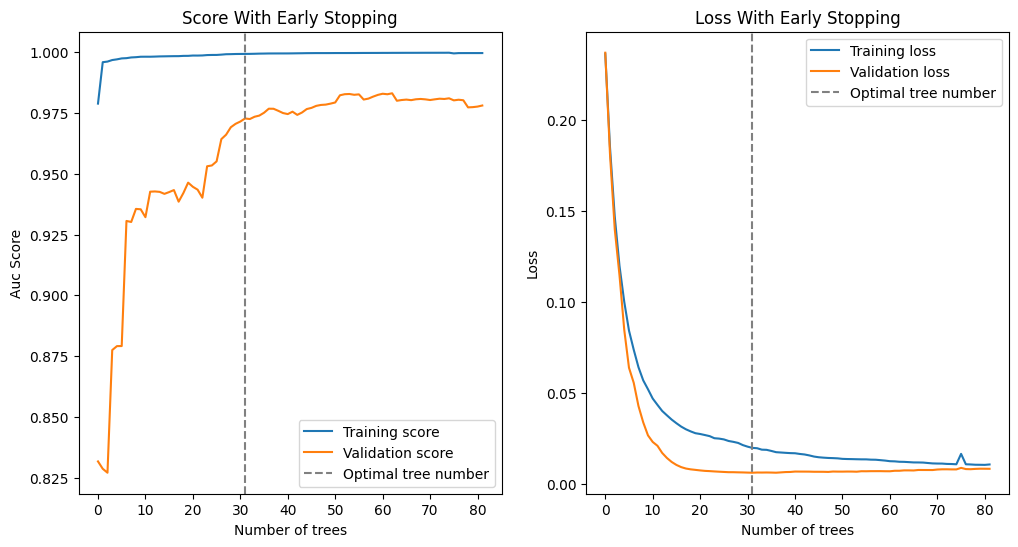

In [117]:
results_es = xgb_pipeline.named_steps['xgbclassifier'].evals_result()
results_es

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax1.plot(results_es["validation_0"]["auc"], label="Training score")
ax1.plot(results_es["validation_1"]["auc"], label="Validation score")
ax1.set_xlabel("Number of trees")
ax1.set_ylabel("Auc Score")
ax1.axvline(best_iteration, color="gray", label="Optimal tree number", linestyle='--')
ax1.set_title('Score With Early Stopping')
ax1.legend()

ax2.plot(results_es["validation_0"]["logloss"], label="Training loss")
ax2.plot(results_es["validation_1"]["logloss"], label="Validation loss")
ax2.set_xlabel("Number of trees")
ax2.set_ylabel("Loss")
ax2.axvline(best_iteration, color="gray", label="Optimal tree number", linestyle='--')
ax2.set_title('Loss With Early Stopping')
ax2.legend()


plt.show()

In [215]:
voting_clf = VotingClassifier(
	[
		('lr', LogisticRegression(random_state=SEED, max_iter=1000, **lr_best_params)),
		('xgb', XGBClassifier(random_state=SEED, **xgb_best_params))
	],
	voting='hard'
)
pipeline = Pipeline([
    ('preprocess', preprocess()),
    ('voting', voting_clf)
])
pipeline

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x3be3dea40>),
                                                                  ('pipeline',
                                                                   Pipeline(steps=[('standardscaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.comp...
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.2657312661875277,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=4,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=250,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...))]))])

In [216]:
voting_clf.fit(X_train_transformed, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=100,
                                                 class_weight={0: 0.1670854271356784,
                                                               1: 0.8329145728643216},
                                                 max_iter=1000, random_state=42,
                                                 solver='liblinear')),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.9359205162742357,
                                            device=None,
                                            early_stopping_rounds=No...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.2657312661875277,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=250, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))])

In [217]:
voting_clf.score(X_test_transformed, y_test)

0.9987824722100853

In [207]:
# fit_params = {
# 	'voting__lr__sample_weight': compute_sample_weight(class_weight={0: 0.90, 1: 1 - 0.90}, y=y_train),
# 	'voting__xgb__eval_set':[(X_train_transformed, y_train), (X_test_transformed, y_test)],
#     'voting__xgb__eval_metric':['auc', 'logloss']
# }


pipeline.fit(
    X_train,
    y_train,
    # **fit_params
    )

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x3be356e30>),
                                                                  ('pipeline',
                                                                   Pipeline(steps=[('standardscaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.comp...
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.2657312661875277,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=4,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=250,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...))],
                                  voting='soft'))])

In [211]:
pipeline.score(X_test, y_test, voting__lr__smaple_weight=compute_sample_weight(class_weight={0: 0.90, 1: 1 - 0.90}, y=y_test))

TypeError: Pipeline.score got unexpected argument(s) {'sample_weight', 'voting__lr__smaple_weight'}, which are not routed to any object.

### ------------------- Random Forest --------------------

#### *Random Forest*

In [13]:
def rf_objective(trial: optuna.Trial) -> float:
	rf_params = {
        'n_estimators': trial.suggest_int("n_estimators", 100, 300, step=50),
        'max_depth': trial.suggest_int("max_depth", 10, 110, step=20),
        'min_samples_split': trial.suggest_int("min_samples_split", 2, 10, step=2),
        'min_samples_leaf': trial.suggest_int("min_samples_leaf", 1, 5, step=1),
        'max_features': trial.suggest_categorical('max_features', choices=['sqrt', 'log2', None]),
        'class_weight': trial.suggest_categorical('class_weight', choices=[{0: weight, 1: 1 - weight} for weight in np.linspace(0.0, 0.99, 200)])
	}
	model = RandomForestClassifier(
		random_state=SEED,
		verbose=1,
		**rf_params
	)

	fit_params = {
		'sample_weight': compute_sample_weight(class_weight={0: 0.90, 1: 1 - 0.90}, y=y_train)
	}
	score = cross_val_score(model,
                            X_train_transformed,
                            y_train,
                            cv=5,
                            scoring='roc_auc',
                            fit_params=fit_params).mean()

	if trial.should_prune():
		raise optuna.TrialPruned()

	return score

In [14]:
rf_study = tune_model(rf_objective, study_name='random-forest')

[I 2024-06-28 15:13:59,713] Using an existing study with name 'random-forest' instead of creating a new one.
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  5.6min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  5.7min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  5.7min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  5.9min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  6.4min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed: 72.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed: 75.0min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed: 23.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed: 92.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed: 25.0min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed: 112.2min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed: 113.2min
[Parallel(n_jobs=1)]: Done  49 task

In [15]:
rf_study.best_params

{'n_estimators': 300,
 'max_depth': 70,
 'min_samples_split': 4,
 'min_samples_leaf': 5,
 'max_features': 'log2',
 'class_weight': {'0': 0.1542211055276382, '1': 0.8457788944723618}}

In [17]:
rf_study.trials_dataframe().sample(10)

number     value             datetime_start          datetime_complete  \
6        6  0.999120 2024-06-27 21:25:00.792118 2024-06-28 10:55:12.809263   
9        9  0.998343 2024-06-28 15:13:59.767141 2024-06-28 18:05:09.153447   
24      24  0.997104 2024-06-28 22:05:30.976773 2024-06-29 00:29:02.975591   
1        1       NaN 2024-06-27 21:25:00.735925                        NaT   
19      19  0.999202 2024-06-28 20:12:28.754146 2024-06-28 22:37:52.099711   
29      29  0.997774 2024-06-29 00:17:25.154895 2024-06-29 03:23:40.222118   
0        0       NaN 2024-06-27 21:25:00.734524                        NaT   
23      23  0.999188 2024-06-28 21:10:49.578657 2024-06-28 23:49:04.449777   
20      20  0.997615 2024-06-28 20:17:39.701889 2024-06-29 00:06:38.010179   
21      21  0.997852 2024-06-28 20:30:46.633699 2024-06-29 02:06:30.362956   

                 duration                                params_class_weight  \
6  0 days 13:30:12.017145  {'0': 0.18904522613065328, '1': 0.810954773869...   
9  0 days 02:51:09.386306  {'0': 0.26864321608040204, '1': 0.731356783919...   
24 0 days 02:23:31.998818  {'0': 0.8755778894472362, '1': 0.1244221105527...   
1                     NaT  {'0': 0.13432160804020102, '1': 0.865678391959...   
19 0 days 02:25:23.345565  {'0': 0.36316582914572865, '1': 0.636834170854...   
29 0 days 03:06:15.067223  {'0': 0.08954773869346734, '1': 0.910452261306...   
0                     NaT  {'0': 0.3134170854271357, '1': 0.6865829145728...   
23 0 days 02:38:14.871120  {'0': 0.24874371859296482, '1': 0.751256281407...   
20 0 days 03:48:58.308290  {'0': 0.7412562814070351, '1': 0.2587437185929...   
21 0 days 05:35:43.729257  {'0': 0.6566834170854271, '1': 0.3433165829145...   

    params_max_depth params_max_features  params_min_samples_leaf  \
6                 50                log2                        4   
9                110                sqrt                        2   
24                10                sqrt                        5   
1                 50                None                        2   
19                30                sqrt                        2   
29                30                None                        5   
0                110                None                        5   
23                50                sqrt                        4   
20                50                sqrt                        1   
21               110                None                        5   

    params_min_samples_split  params_n_estimators     state  
6                          6                  100  COMPLETE  
9                          6                  100  COMPLETE  
24                         4                  300  COMPLETE  
1                         10                  200   RUNNING  
19                         2                  200  COMPLETE  
29                         4                  150  COMPLETE  
0                          4                  150   RUNNING  
23                         2                  250  COMPLETE  
20                        10                  300  COMPLETE  
21                         8                  200  COMPLETE

In [19]:
optuna.visualization.plot_param_importances(rf_study)

In [ ]:
optuna.visualization.plot_param_importances(
	xgb_study, 
	target=lambda t: t.duration.total_seconds(),
	target_name="duration"
)

In [21]:
rf_best_params = rf_study.best_params
rf_cast_class_weight = {int(key): value for key, value in rf_best_params['class_weight'].items()}
rf_best_params['class_weight'] = rf_cast_class_weight
rf_best_params

{'n_estimators': 300,
 'max_depth': 70,
 'min_samples_split': 4,
 'min_samples_leaf': 5,
 'max_features': 'log2',
 'class_weight': {0: 0.1542211055276382, 1: 0.8457788944723618}}

In [22]:
print("Best trial:")
trial = rf_study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
print(rf_study.best_params)
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value: 0.9992630177139048
  Params: 
{'n_estimators': 300, 'max_depth': 70, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': {'0': 0.1542211055276382, '1': 0.8457788944723618}}
    n_estimators: 300
    max_depth: 70
    min_samples_split: 4
    min_samples_leaf: 5
    max_features: log2
    class_weight: {'0': 0.1542211055276382, '1': 0.8457788944723618}


In [37]:
rf_best_model = RandomForestClassifier(random_state=SEED, **rf_best_params).set_fit_request(sample_weight=True)
rf_pipeline = get_pipeline(rf_best_model, preprocess())
rf_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x32c37a920>),
                                                                  ('pipeline',
                                                                   Pipeline(steps=[('standardscaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x3a819bbb0>)]))])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight={0: 0.1542211055276382,
                                                      1: 0.8457788944723618},
                                        max_depth=70, max_features='log2',
                                        min_samples_leaf=5, min_samples_split=4,
                                        n_estimators=300, random_state=42))],
         verbose=True)

In [28]:
rf_pipeline.named_steps['randomforestclassifier']

RandomForestClassifier(class_weight={0: 0.1542211055276382,
                                     1: 0.8457788944723618},
                       max_depth=70, max_features='log2', min_samples_leaf=5,
                       min_samples_split=4, n_estimators=300, random_state=42)

In [38]:
rf_pipeline.named_steps['randomforestclassifier'].get_metadata_routing()

{'fit': {'sample_weight': True}, 'score': {'sample_weight': None}}

In [45]:
rf_pipeline.fit(
    X_train,
    y_train,
    randomforestclassifier_sample_weight=compute_sample_weight(class_weight={0: 0.1542211055276382, 1: 0.8457788944723618}, y=y_train)
)

TypeError: Pipeline.fit got unexpected argument(s) {'randomforestclassifier_sample_weight'}, which are not routed to any object.

In [ ]:
rf_pipeline.score(X_test, y_test)

In [52]:
data.loc[data['type']=='TRANSFER']

step      type      amount     nameOrig  oldbalanceOrg  \
2           1  TRANSFER      181.00  C1305486145         181.00   
19          1  TRANSFER   215310.30  C1670993182         705.00   
24          1  TRANSFER   311685.89  C1984094095       10835.00   
58          1  TRANSFER    62610.80  C1976401987       79114.00   
78          1  TRANSFER    42712.39   C283039401       10363.39   
...       ...       ...         ...          ...            ...   
6362610   742  TRANSFER    63416.99   C778071008       63416.99   
6362612   743  TRANSFER  1258818.82  C1531301470     1258818.82   
6362614   743  TRANSFER   339682.13  C2013999242      339682.13   
6362616   743  TRANSFER  6311409.28  C1529008245     6311409.28   
6362618   743  TRANSFER   850002.52  C1685995037      850002.52   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  
2                   0.0   C553264065            0.00            0.00        1  
19                  0.0  C1100439041        22425.00            0.00        0  
24                  0.0   C932583850         6267.00      2719172.89        0  
58              16503.2  C1937962514          517.00         8383.29        0  
78                  0.0  C1330106945        57901.66        24044.18        0  
...                 ...          ...             ...             ...      ...  
6362610             0.0  C1812552860            0.00            0.00        1  
6362612             0.0  C1470998563            0.00            0.00        1  
6362614             0.0  C1850423904            0.00            0.00        1  
6362616             0.0  C1881841831            0.00            0.00        1  
6362618             0.0  C2080388513            0.00            0.00        1  

[532909 rows x 10 columns]

In [38]:
import os
import glob
import pickle
from fraud_detection.config import LOCAL_REGISTRY_PATH
local_model_directory = os.path.join(LOCAL_REGISTRY_PATH, "models")
local_model_paths = glob.glob(f"{local_model_directory}/*")
most_recent_model_path_on_disk = sorted(local_model_paths)[-1]

IndexError: list index out of range

In [39]:
local_model_directory

'/Users/sylvain/CODE/Weena24/online-payment-fraud-detection/src/results/models'

In [28]:
with open(most_recent_model_path_on_disk, 'rb') as model_filename:
	latest_model = pickle.load(model_filename)
latest_model

{'context': 'evaluate', 'row_count': 1908786}